<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sentiment-Analysis-by-States" data-toc-modified-id="Sentiment-Analysis-by-States-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sentiment Analysis by States</a></span><ul class="toc-item"><li><span><a href="#AZ-Hotel-Review" data-toc-modified-id="AZ-Hotel-Review-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>AZ Hotel Review</a></span></li><li><span><a href="#CA-Hotel-Review" data-toc-modified-id="CA-Hotel-Review-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>CA Hotel Review</a></span></li><li><span><a href="#CO-Hotel-Review" data-toc-modified-id="CO-Hotel-Review-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>CO Hotel Review</a></span></li><li><span><a href="#FL-Hotel-Review" data-toc-modified-id="FL-Hotel-Review-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>FL Hotel Review</a></span></li><li><span><a href="#GA-Hotel-Review" data-toc-modified-id="GA-Hotel-Review-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>GA Hotel Review</a></span></li><li><span><a href="#HI-Hotel-Review" data-toc-modified-id="HI-Hotel-Review-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>HI Hotel Review</a></span></li><li><span><a href="#IL-Hotel-Review" data-toc-modified-id="IL-Hotel-Review-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>IL Hotel Review</a></span></li><li><span><a href="#NY-Hotel-Review" data-toc-modified-id="NY-Hotel-Review-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>NY Hotel Review</a></span></li><li><span><a href="#OR-Hotel-Review" data-toc-modified-id="OR-Hotel-Review-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>OR Hotel Review</a></span></li><li><span><a href="#PA-Hotel-Review" data-toc-modified-id="PA-Hotel-Review-1.10"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>PA Hotel Review</a></span></li><li><span><a href="#TN-Hotel-Review" data-toc-modified-id="TN-Hotel-Review-1.11"><span class="toc-item-num">1.11&nbsp;&nbsp;</span>TN Hotel Review</a></span></li><li><span><a href="#TX-Hotel-Review" data-toc-modified-id="TX-Hotel-Review-1.12"><span class="toc-item-num">1.12&nbsp;&nbsp;</span>TX Hotel Review</a></span></li><li><span><a href="#VA-Hotel-Review" data-toc-modified-id="VA-Hotel-Review-1.13"><span class="toc-item-num">1.13&nbsp;&nbsp;</span>VA Hotel Review</a></span></li><li><span><a href="#WA-Hotel-Review" data-toc-modified-id="WA-Hotel-Review-1.14"><span class="toc-item-num">1.14&nbsp;&nbsp;</span>WA Hotel Review</a></span></li><li><span><a href="#Compare-15-States" data-toc-modified-id="Compare-15-States-1.15"><span class="toc-item-num">1.15&nbsp;&nbsp;</span>Compare 15 States</a></span></li></ul></li></ul></div>

# Sentiment Analysis by States

In [1]:
import numpy as np
import pickle
from collections import Counter
import re

# nlp libraries/api
import en_core_web_lg
from spacy import displacy
import gensim
#from neuralcoref import Coref

spacy = en_core_web_lg.load()
#coref = Coref(nlp=spacy)


In [2]:
# Load opinion lexicon
neg_file = open("neg_words.txt",encoding = "ISO-8859-1")
pos_file = open("pos_words.txt",encoding = "ISO-8859-1")
neg = [line.strip() for line in neg_file.readlines()]
pos = [line.strip() for line in pos_file.readlines()]
opinion_words = neg + pos


In [3]:
def check_similarity(aspects, word):
    '''
    checks for word2vec similarity values between category word and the term
    returns most similar word
    '''
    similarity = []
    for aspect in aspects:
        sim = [word2vec.n_similarity([aspect], word.split())]
        for splited in word.split():
            sim.append(word2vec.n_similarity([aspect], [splited]))
        similarity.append(max(sim))
    # set threshold for max value
    if max(similarity) > 0.2:
        return aspects[np.argmax(similarity)]
    else:
        return None


def assign_term_to_aspect(aspect_sent, terms_dict, sent_dict, pred):
    '''
    function: takes in a sentiment dictionary and appends the aspect dictionary
    inputs: sent_dict is a Counter in the form Counter(term:sentiment value)
            aspect_sent is total sentiment tally
            terms_dict is dict with individual aspect words associated with sentiment
    output: return two types of aspect dictionaries:
            updated terms_dict and aspect_sent
    '''
    aspects = ['location', 'checkin', 'food', 'building', 'rooms', 'cleanliness', 'value', 'service', 'business']

    # First, check word2vec
    # Note: the .split() is used for the term because word2vec can't pass compound nouns
    for term in sent_dict:
        try:
            # The conditions for when to use the NB classifier as default vs word2vec
            aspect = check_similarity(aspects, term)
            if aspect:
                terms_dict[aspect.upper()][term] += sent_dict[term]
                if sent_dict[term] > 0:
                    aspect_sent[aspect.upper()]["pos"] += sent_dict[term]
                else:
                    aspect_sent[aspect.upper()]["neg"] += abs(sent_dict[term])
            elif pred:
                aspect = str(pred[0]).strip("(',)")
                terms_dict[aspect.upper()][term] += sent_dict[term]
                if sent_dict[term] > 0:
                    aspect_sent[aspect.upper()]["pos"] += sent_dict[term]
                else:
                    aspect_sent[aspect.upper()]["neg"] += abs(sent_dict[term])
            # if unable to classify via NB or word2vec, then put them in misc. bucket
            else:
                terms_dict["OTHER"][term] += sent_dict[term]
                if sent_dict[term] > 0:
                    aspect_sent["OTHER"]["pos"] += sent_dict[term]
                else:
                    aspect_sent["OTHER"]["neg"] += abs(sent_dict[term])
        except:
            #print(term, "not in vocab")
            continue
    return aspect_sent, terms_dict


def modify_sentiment(token, sentiment):
    for child in token.children:
        # if there's a adj modifier (i.e. very, pretty, etc.) add more weight to sentiment
        # This could be better updated for modifiers that either positively or negatively emphasize
        # can't catch "there are nowhere near enough loungers"
        if ((child.dep_ == "amod") or (child.dep_ == "advmod")) and (child.text in opinion_words):
            sentiment *= 1.5
        # check for negation words and flip the sign of sentiment
        if child.dep_ == "neg":
            sentiment *= -1
    return sentiment


def add_sentiment(token, sent_dict, sentiment):
    if (token.dep_ == "advmod"):
        return sent_dict
    elif (token.dep_ == "acomp"):
        sent_dict = for_acomp(token, sent_dict, sentiment)
    elif (token.dep_ == "amod"):
        sent_dict = for_amod(token, sent_dict, sentiment)
    elif (token.dep_ == "compound"):
        sent_dict = for_compound(token, sent_dict, sentiment)
    elif (token.dep_ == "conj"):
        sent_dict = add_sentiment(token.head, sent_dict, sentiment)
    elif (token.dep_ == "dobj"):
        sent_dict = for_dobj(token, sent_dict, sentiment)
    elif (token.dep_ == "relcl"):
        if token.head.pos_ == "NOUN" or token.head.pos_ == "PROPN":
            sent_dict[token.head.lemma_] += sentiment
    else:
        # if verb, check if there's a direct object
        if token.head.dep_ == "advcl" or token.head.dep_ == "ROOT":
            sent_dict = for_advcl(token.head, sent_dict, sentiment, token)
        for child in token.children:
            if (token.pos_ == "VERB") & (child.dep_ == "dobj") & (child.pos_ != 'PRON'):
                sent_dict = check_compound(child, sent_dict, sentiment, token)
            # check for nouns
            elif child.pos_ == "NOUN" or child.pos_ == "PROPN":
                sent_dict = check_compound(child, sent_dict, sentiment, token)
            if ((token.pos_ == "VERB") or (token.pos_ == "ADJ")) & (child.dep_ == "prep"):
                sent_dict = for_prep(child, sent_dict, sentiment)
    return sent_dict


def add_subchild(child, sent_dict, sentiment, token, added):
    if child.children == []:
        return sent_dict, added
    else:
        conj = 0
        for subchild in child.children:
            if (subchild.dep_ in ["compound", "amod", "nmod"]) & (subchild != token):
                sent_dict[subchild.lemma_ + ' ' + child.lemma_] += sentiment
                for sub in subchild.children:
                    if sub.pos_ in ["NOUN", "PROPN"]:
                        sent_dict[sub.lemma_ + ' ' + child.lemma_] += sentiment
                added = True
            # check for conjugates (a AND b), then add both to dictionary
            elif subchild.text == "and" or subchild.text == ",":
                conj += 1
        for subchild in child.children:
            if (conj > 0) & (subchild.pos_ == "NOUN" or subchild.pos_ == "PROPN"):
                sent_dict = check_compound(subchild, sent_dict, sentiment, child)
                conj -= 1
    return sent_dict, added


def check_compound(child, sent_dict, sentiment, token=None):
    added = False
    sent_dict, added = add_subchild(child, sent_dict, sentiment, token, added)
    if not added:
        sent_dict[child.lemma_] += sentiment
    return sent_dict


def for_compound(token, sent_dict, sentiment):
    if token.head.dep_ == "compound":
        sent_dict = for_compound(token.head, sent_dict, sentiment)
    elif token.head.pos_ in ["NOUN", "PROPN"]:
        sent_dict = check_compound(token.head, sent_dict, sentiment)
    return sent_dict


def for_acomp(token, sent_dict, sentiment):
    for ancestor in token.ancestors:
        if ancestor.dep_ == "attr":
            sent_dict[ancestor] += sentiment
        if ancestor.dep_ in ["advcl", "ROOT", "conj", "ccomp"]:
            sent_dict = for_advcl(ancestor, sent_dict, sentiment, token)
    return sent_dict


def for_advcl(ancestor, sent_dict, sentiment, token):
    for child in ancestor.children:
        if (child.dep_ in ["nsubj", "compound"] ) & (child.pos_ in ["NOUN", "PROPN"]):
            sent_dict = check_compound(child, sent_dict, sentiment, token)
    return sent_dict


def for_amod(token, sent_dict, sentiment):
    if token.head.dep_ == "appos":
        sent_dict = check_compound(token.head, sent_dict, sentiment, token)
    elif token.head.dep_ == "pobj":
        if token.head.head.head.dep_ in ["advcl", "ROOT", "conj"]:
            sent_dict = for_advcl(token.head.head.head, sent_dict, sentiment, token)
    if token.head.pos_ == "NOUN" or token.head.pos_ == "PROPN":  # token.head.dep_ != "compound", so "free room delivery" not added twice
        sent_dict = check_compound(token.head, sent_dict, sentiment, token)
    return sent_dict


def for_dobj(token, sent_dict, sentiment):
    if token.head.dep_ == "conj":
        head = token.head.head
        head_child = token.head
    else:
        head = token.head
        head_child = token
    for child in head.children:
        if (child.dep_ == "nsubj") & (child.pos_ == "NOUN" or child.pos_ == "PROPN"):
            sent_dict = check_compound(child, sent_dict, sentiment, head_child)
    return sent_dict


def for_prep(token, sent_dict, sentiment):
    for child in token.children:
        if child.pos_ == "NOUN" or child.pos_ == "PROPN":
            sent_dict = check_compound(child, sent_dict, sentiment, token)
    return sent_dict


def feature_sentiment(sentence):
    '''
    input: dictionary and sentence
    function: appends dictionary with new features if the feature did not exist previously,
              then updates sentiment to each of the new or existing features
    output: updated dictionary
    '''
    sent_dict = Counter()
    sentence = spacy(sentence)
    for token in sentence:
        # check if the word is an opinion word, then assign sentiment
        if (token.lemma_ in opinion_words) or (token.text in opinion_words):
            sentiment = 1 if ((token.text in pos) or (token.lemma_ in pos)) else -1
            # if target is an adverb modifier (i.e. pretty, highly, etc.)
            # but happens to be an opinion word, ignore and pass
            sentiment = modify_sentiment(token, sentiment)
            sent_dict = add_sentiment(token, sent_dict, sentiment)
    #print(sent_dict)
    return sent_dict


def classify_and_sent(sentence, aspect_sent, terms_dict):
    '''
    function: classify the sentence into a category, and assign sentiment
    note: aspect_dict is a parent dictionary with all the aspects
    input: sentence & aspect dictionary, which is going to be updated
    output: updated aspect dictionary
    '''
    # classify sentence with NB classifier
    predicted = svm_model.predict([sentence])
    pred = mlb.inverse_transform(predicted)
    if "('OTHER')," in pred:
        pred.remove("('OTHER'),")
    if "('NOTRELATED')," in pred:
        pred.remove("('NOTRELATED'),")

    # get aspect names and their sentiment in a dictionary form
    sent_dict = feature_sentiment(sentence)

    # try to categorize the aspect names into the 4 aspects in aspect_dict
    aspect_sent, terms_dict = assign_term_to_aspect(aspect_sent, terms_dict, sent_dict, pred)
    return aspect_sent, terms_dict


#def replace_pronouns(text):
 #   coref.one_shot_coref(text)
  #  return coref.get_resolved_utterances()[0]

from nltk.tokenize import sent_tokenize

def split_sentence(text):
    '''
    splits review into a list of sentences using spacy's sentence parser
    '''
    review = spacy(text)
    bag_sentence = []
    start = 0
    for token in review:
        if token.sent_start:
            bag_sentence.append(review[start:(token.i - 1)])
            start = token.i
        if token.i == len(review) - 1:
            bag_sentence.append(review[start:(token.i + 1)])
    return bag_sentence

# Remove special characters using regex
def remove_special_char(sentence):
    return re.sub(r"[^a-zA-Z0-9.',:;?]+", ' ', sentence)
# "ROOMS", "CLEANLINESS", "VALUE", "SERVICE", "LOCATION", "CHECKIN", "BUSINESS", "FOOD", "BUILDING", "OTHER", "NOTRELATED"
def review_pipe(review, aspect_sent,
                terms_dict={'LOCATION':Counter(), 'CHECKIN':Counter(), 'FOOD':Counter(), 'BUILDING':Counter(), 'ROOM':Counter(), 'CLEANLINESS':Counter(), 'VALUE':Counter(), 'SERVICE':Counter(), 'BUSINESS':Counter(), 'OTHER':Counter()}):
    #review = replace_pronouns(review)
    sentences = split_sentence(review)
    for sentence in sentences:
        sentence = remove_special_char(str(sentence))
        aspect_sent, terms_dict = classify_and_sent(sentence.lower(), aspect_sent, terms_dict)
    return aspect_sent, terms_dict

In [4]:
# Uncomment below if running for first time.
# Setup nltk corpora path and Google Word2Vec location
#google_vec_file = 'GoogleNews-vectors-negative300.bin'
#word2vec = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)
#pickle.dump(word2vec, open("word2vec_google.pkl", 'wb'))

# If above script has been run, load saved word embedding
word2vec = pickle.load(open("word2vec_google.pkl", 'rb'))

# load the Multi-label binarizer from previous notebook
mlb = pickle.load(open("mlb.pkl", 'rb'))

# load the fitted naive bayes model from previous notebook
svm_model = pickle.load(open("svm_model.pkl", 'rb'))

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def gen_text(term_dict):
    text_pos, text_neg = [], []
    for a in term_dict:
        for k in term_dict[a]:
            if k != 'hotel':
                if term_dict[a][k] > 0:
                    text_pos.append(' '.join([str(k)]))
                    #text_pos.append(' '.join([str(k)] * ((round(term_dict[a][k]))+1)))
                else:
                    #text_neg.append(' '.join([str(k)] * (abs(round(term_dict[a][k]))+1)))
                    text_neg.append(' '.join([str(k)]))
    return text_pos, text_neg


def wc(text, bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 2000, random_state=42, max_font_size = 50)
    wc.generate(' '.join(text))
    plt.figtext(.5,.71,title, fontsize=100, fontweight="bold", ha='center')
    plt.imshow(wc)
    plt.axis('off')

In [6]:
import pandas as pd
from collections import defaultdict
def gen_dict(file):
    with open(file) as fp: 
        reviews = []
        Lines = fp.readlines() 
        for line in Lines: 
            reviews.append(line.split('Thank you for your')[0])
    aspect_sent={'LOCATION':Counter(), 'CHECKIN':Counter(), 'FOOD':Counter(), 'BUILDING':Counter(), 'ROOMS':Counter(), 'CLEANLINESS':Counter(), 'VALUE':Counter(), 'SERVICE':Counter(), 'BUSINESS':Counter(), 'OTHER':Counter()}
    term_dict={'LOCATION':Counter(), 'CHECKIN':Counter(), 'FOOD':Counter(), 'BUILDING':Counter(), 'ROOMS':Counter(), 'CLEANLINESS':Counter(), 'VALUE':Counter(), 'SERVICE':Counter(), 'BUSINESS':Counter(), 'OTHER':Counter()}
    for review in reviews:
        aspect_sent, term_dict = review_pipe(review, aspect_sent, term_dict)
    return aspect_sent, term_dict


def gen_rate(aspect_sent):
    aspect, pos_list, neg_list = [], [], []
    for k, v in aspect_sent.items():
        aspect.append(k)
        pos_list.append(v['pos'])
        neg_list.append(v['neg'])
    df = pd.DataFrame({'aspect': aspect, 'pos': pos_list, 'neg': neg_list})
    df = df.append({'aspect':'TOTAL', 'pos': sum(df['pos']), 'neg': sum(df['neg']), 'rate': 0}, ignore_index=True)
    df['rate'] = round(((df['pos']) / (df['pos'] + df['neg']) + 0.25) * 4, 1)
    return df

## AZ Hotel Review

In [7]:
aspect_sent, AZ_term_dict = gen_dict("hotel_reviewAZ.txt")
AZ_df = gen_rate(aspect_sent)
AZ_df

aspect    pos    neg  rate
0      LOCATION   76.5   13.0   4.4
1       CHECKIN   52.0    5.0   4.6
2          FOOD  108.5   27.0   4.2
3      BUILDING   35.0   17.0   3.7
4         ROOMS  285.5   30.0   4.6
5   CLEANLINESS   13.5    7.5   3.6
6         VALUE   30.0    4.0   4.5
7       SERVICE  125.0   17.0   4.5
8      BUSINESS   17.0    2.0   4.6
9         OTHER   56.5   11.0   4.3
10        TOTAL  799.5  133.5   4.4

In [8]:
total_df = pd.DataFrame(columns = ["state", "location", "checkin", 'food', 'building', 'room', 'cleanliness', 'value', 'service', 'business', 'other', 'total'])
a_series = pd. Series(['AZ'] + list(AZ_df['rate']), index = total_df. columns)
total_df = total_df.append(a_series, ignore_index=True)

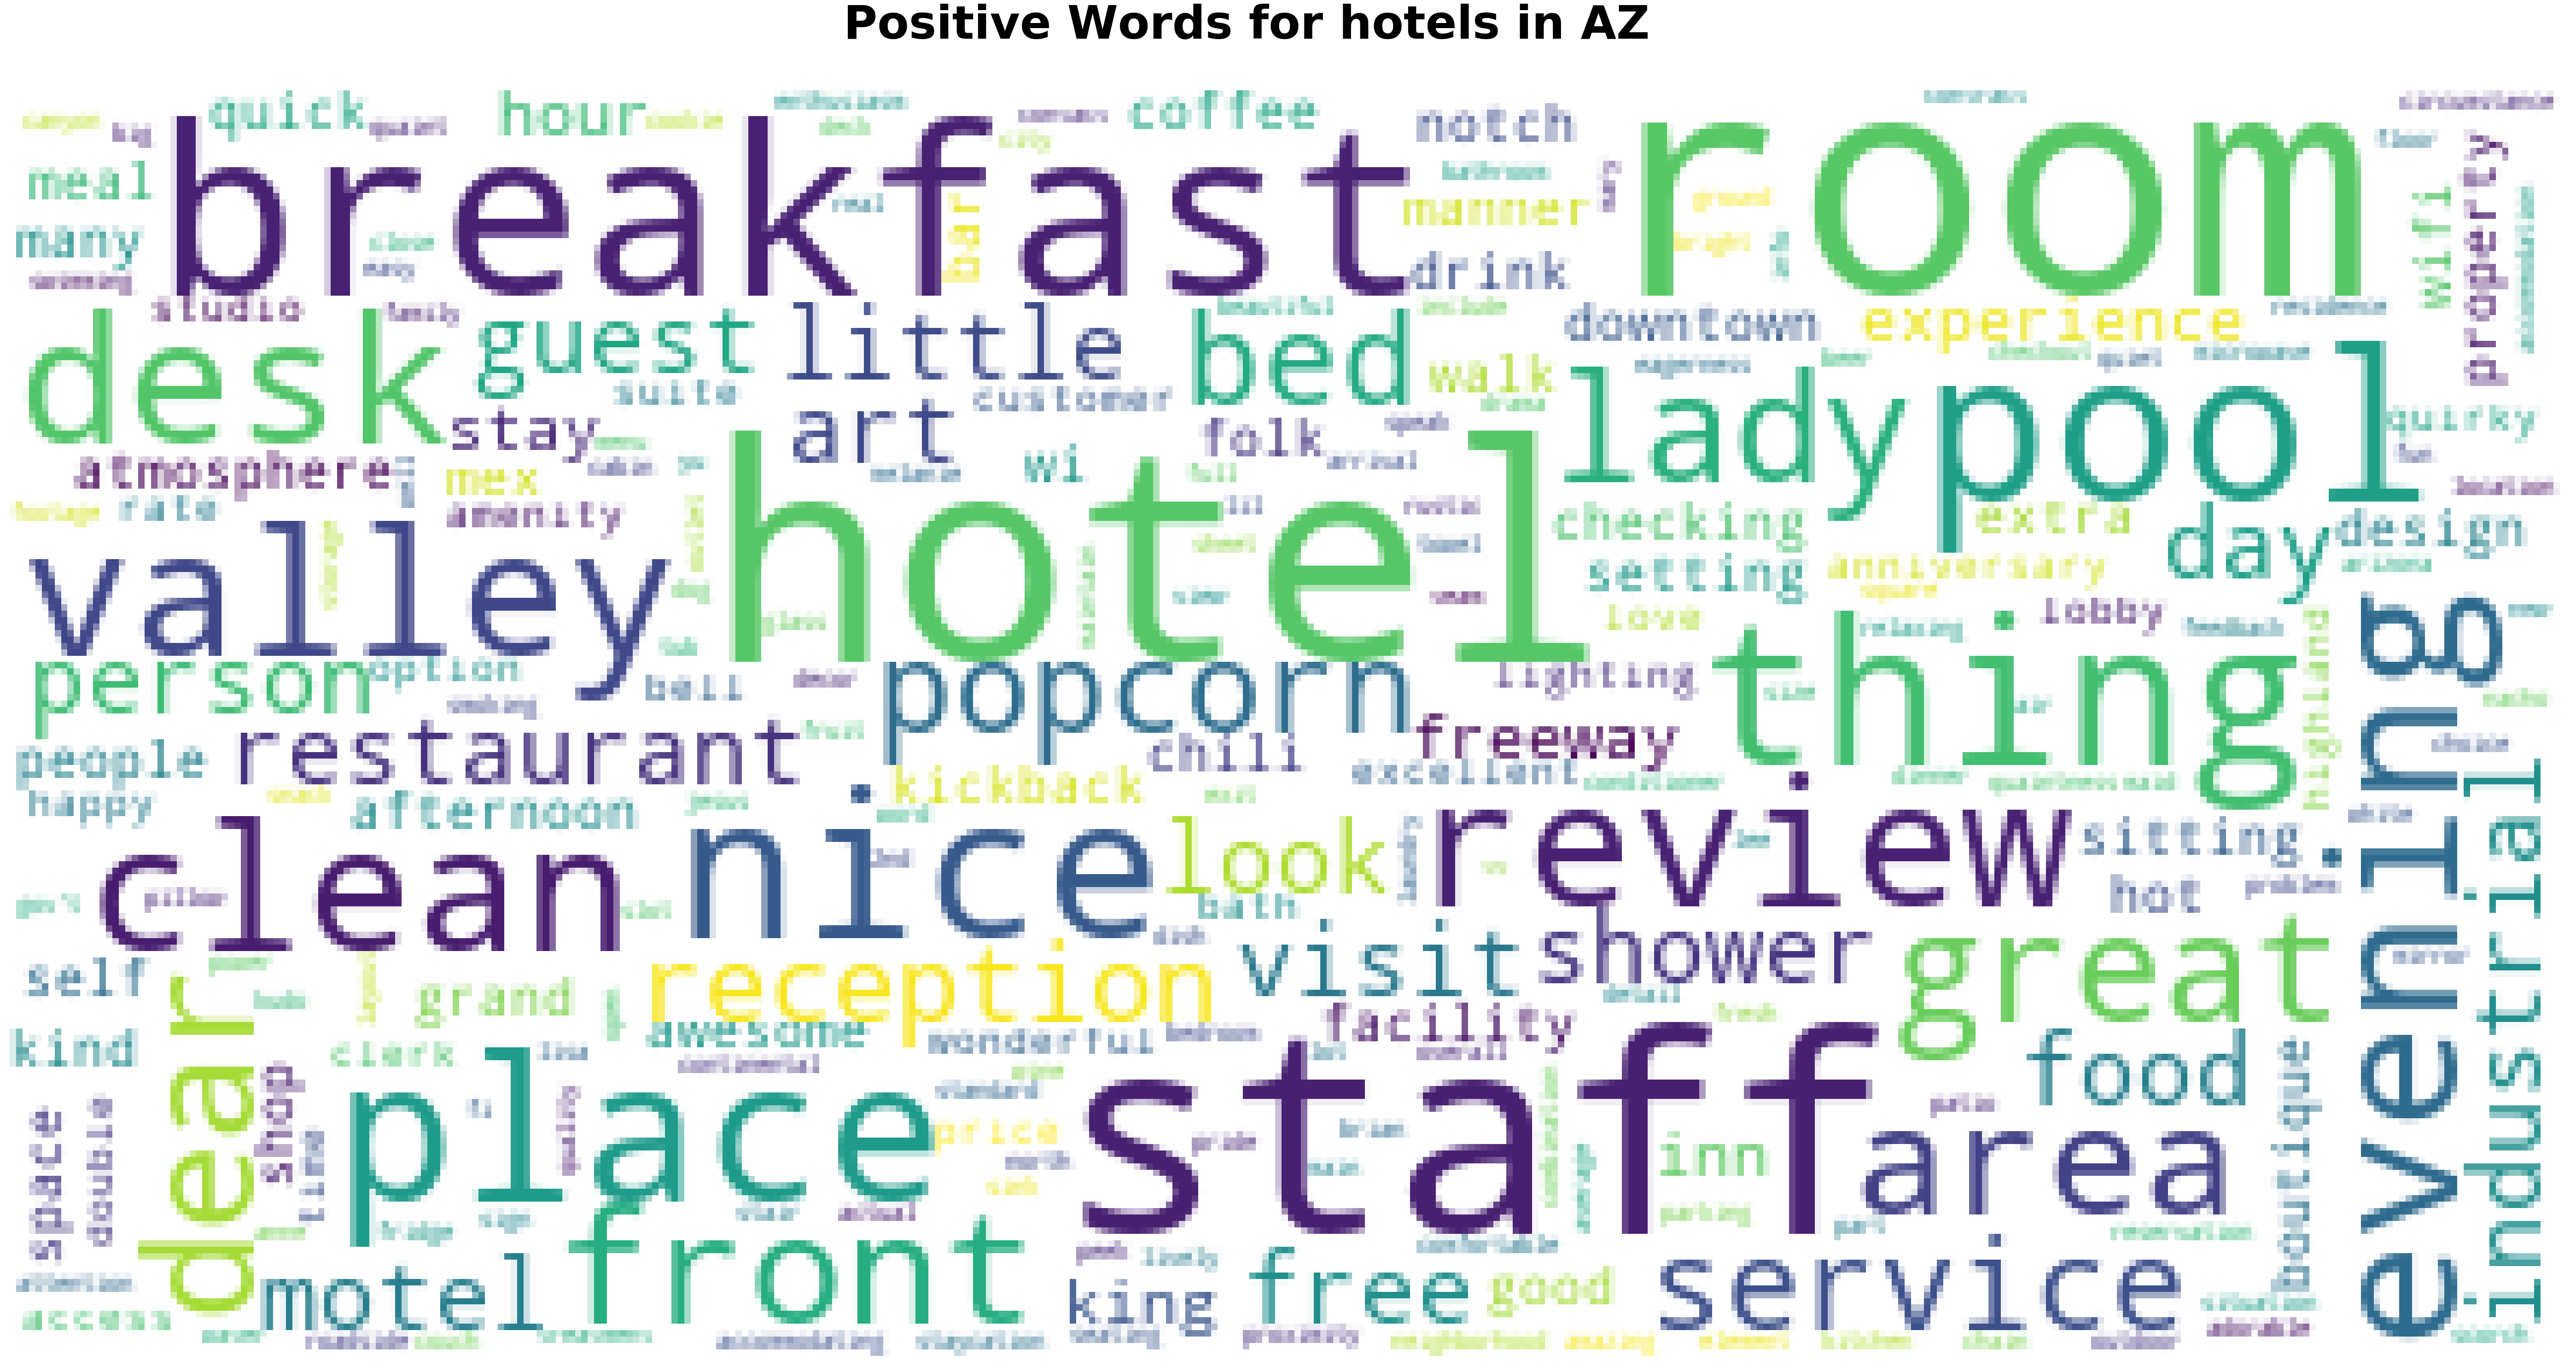

In [9]:
text_pos, text_neg = [], []
text_pos, text_neg = gen_text(AZ_term_dict)
wc(text_pos,'white','Positive Words for hotels in AZ' )

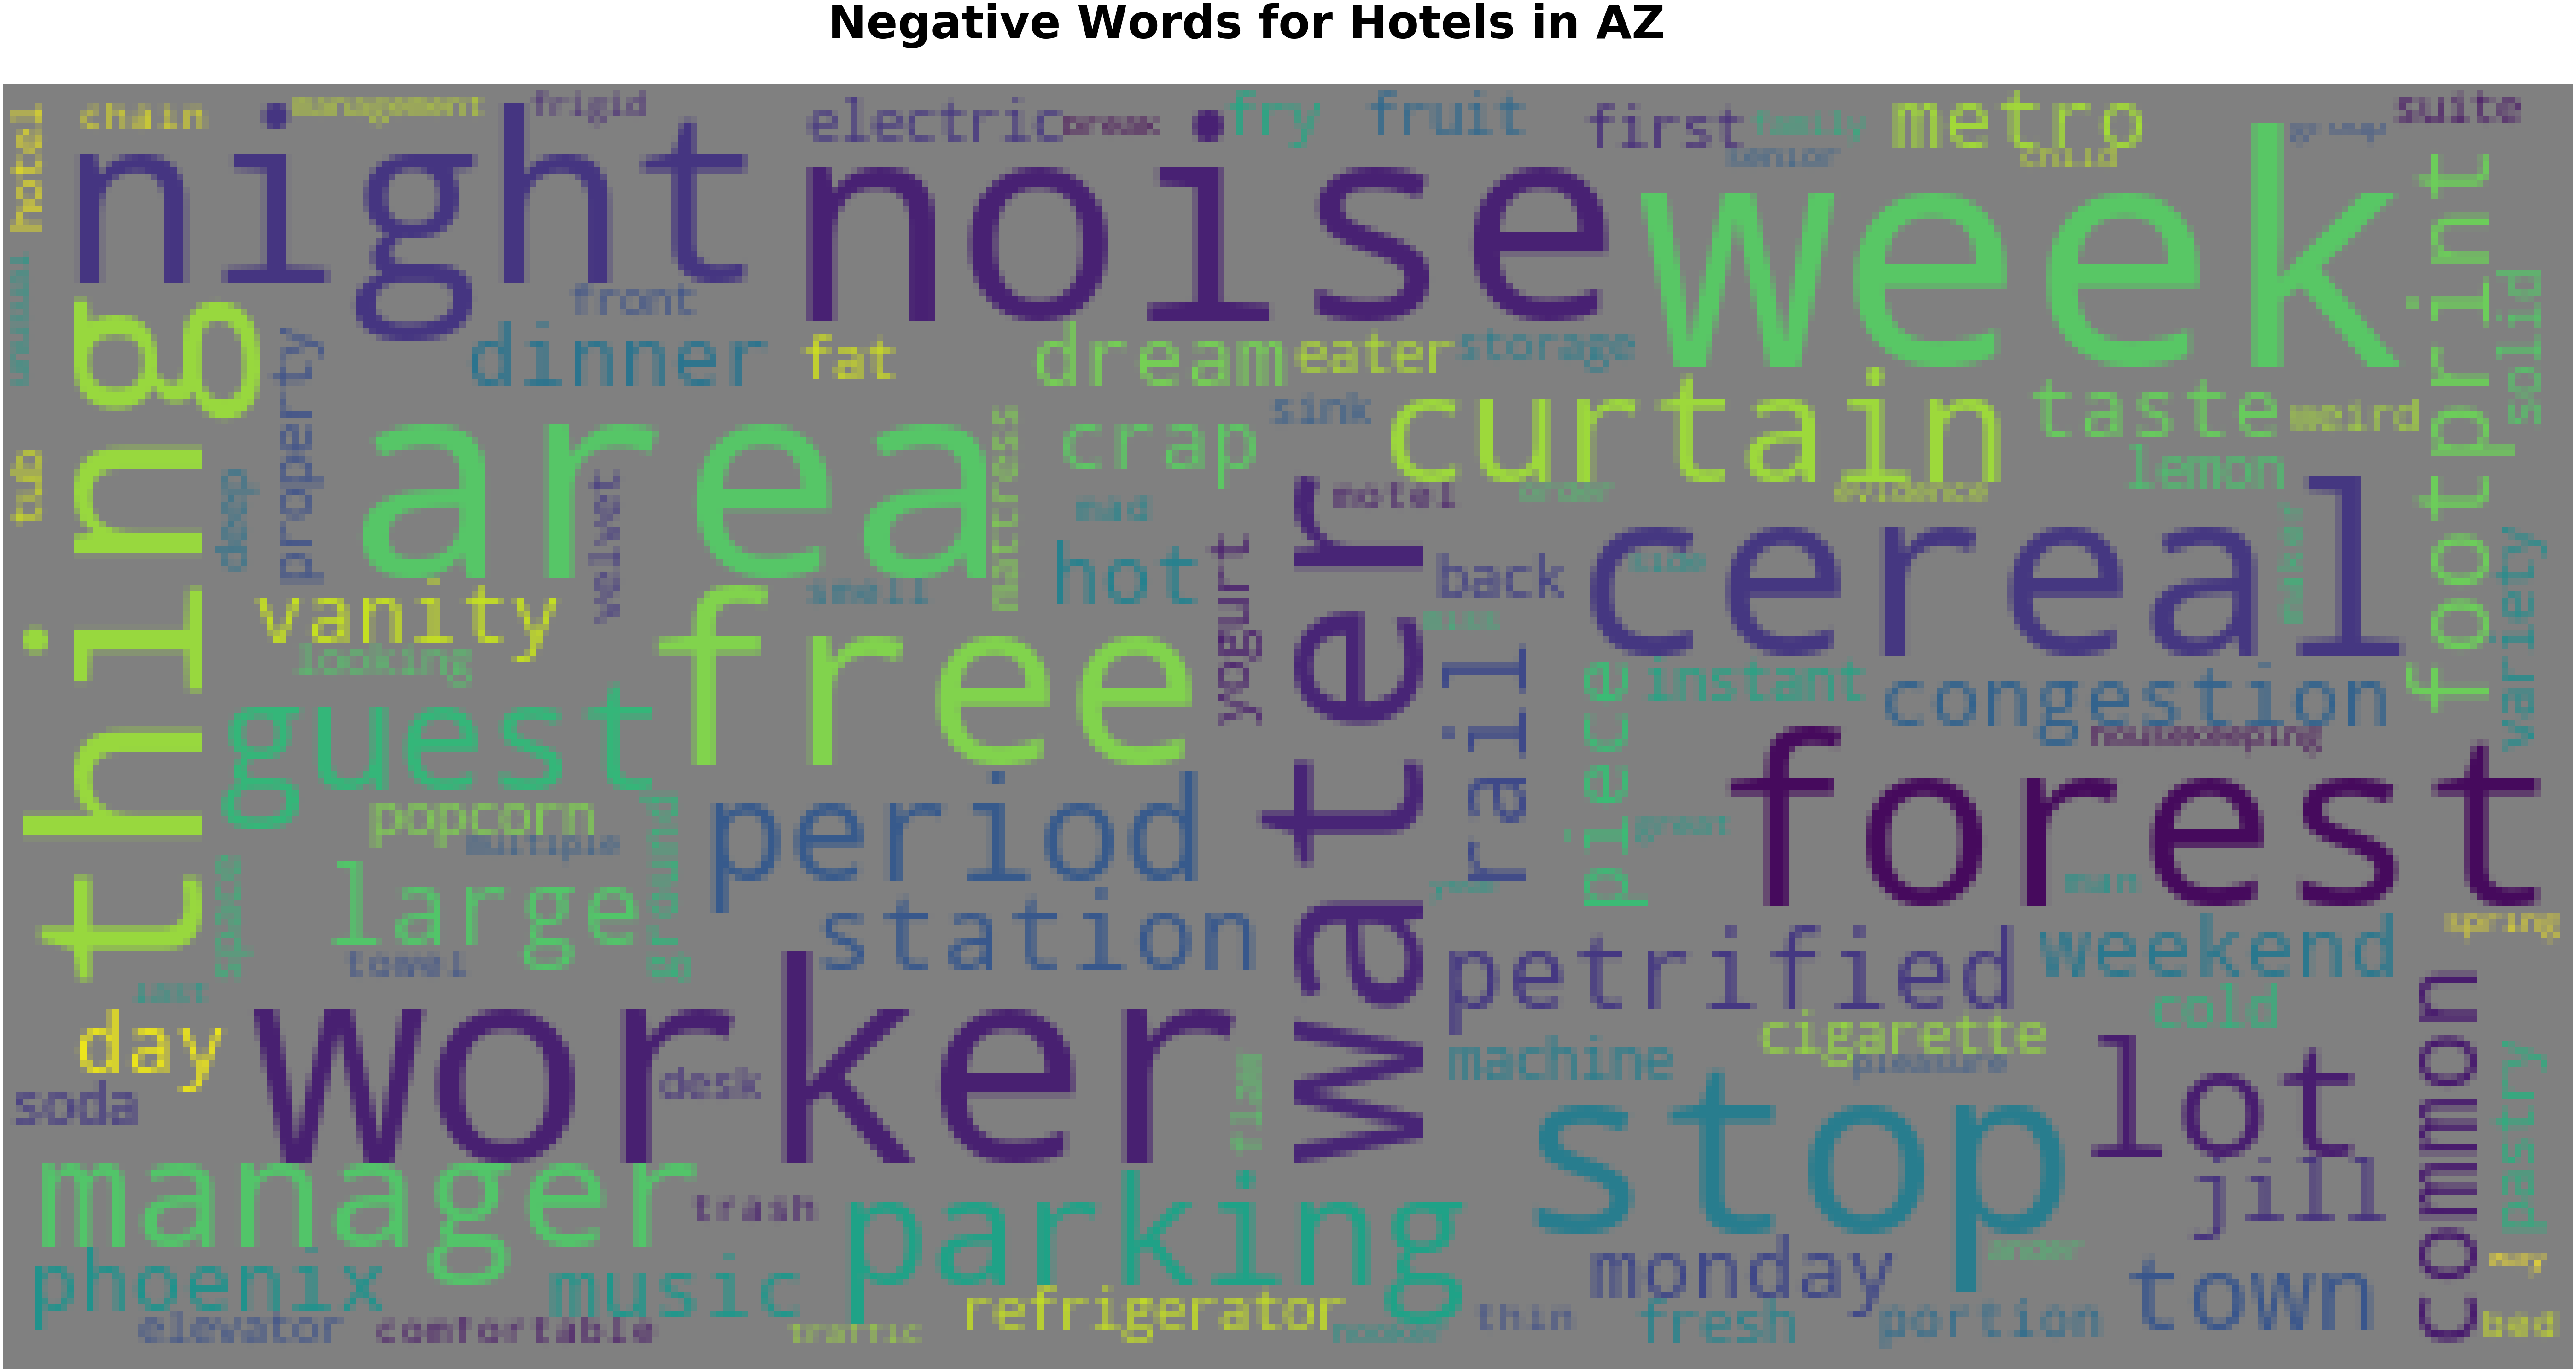

In [10]:
wc(text_neg,'grey','Negative Words for Hotels in AZ' )

In [11]:
lowest = defaultdict()
highest = defaultdict()
for i in AZ_term_dict:
    if AZ_term_dict[i]:
        highest[i] = AZ_term_dict[i].most_common()[:10]
        lowest[i] = AZ_term_dict[i].most_common()[-10:]
highest_df = pd.DataFrame(highest)
lowest_df = pd.DataFrame(lowest)
lowest_df = lowest_df.drop(["OTHER"],1)
highest_df = highest_df.drop(["OTHER"],1)
highest_df

LOCATION              CHECKIN                        FOOD  \
0      (place, 16.5)         (wifi, 10.0)           (breakfast, 19.0)   
1   (location, 12.5)         (wi fi, 5.5)                 (food, 9.5)   
2          (view, 5)            (tv, 3.0)                  (drink, 6)   
3  (front person, 2)  (amazing review, 2)              (afternoon, 5)   
4         (visit, 2)        (checkout, 2)  (continental breakfast, 3)   
5     (proximity, 2)  (checking staff, 2)             (atmosphere, 3)   
6        (manner, 2)        (checking, 2)         (free breakfast, 3)   
7        (folk, 1.5)          (peek, 1.5)               (people, 2.5)   
8    (patio area, 1)          (dear f, 1)          (coffee shop, 2.5)   
9        (person, 1)         (brian f, 1)             (restaurant, 2)   

             BUILDING               ROOMS               CLEANLINESS  \
0    (property, 10.0)        (room, 54.5)              (amenity, 4)   
1        (setting, 3)       (hotel, 27.0)            (overall, 1.5)   
2   (free parking, 3)         (bed, 19.0)                 (maid, 1)   
3  (nice property, 2)       (shower, 7.5)               (detail, 1)   
4         (that, 1.5)     (bathroom, 6.5)           (clean lady, 1)   
5        (stair, 1.5)            (bar, 6)          (clean staff, 1)   
6   (good setting, 1)  (hotel staff, 5.0)      (bright lighting, 1)   
7            (lot, 1)        (decor, 4.5)                (pride, 1)   
8            (art, 1)   (front desk, 3.5)  (quality hospitality, 1)   
9       (downtown, 1)            (day, 3)                (noise, 0)   

                 VALUE                SERVICE              BUSINESS  
0          (price, 13)          (staff, 44.0)   (bad management, 3)  
1         (freeway, 3)           (service, 9)              (job, 3)  
2           (value, 2)        (experience, 7)   (positive thing, 2)  
3            (love, 2)    (friendly staff, 6)      (quirky shop, 2)  
4        (exchange, 1)    (entire staff, 3.5)         (boutique, 2)  
5      (steep side, 1)        (only thing, 3)  (industrial look, 1)  
6           (touch, 1)    (staff member, 2.5)      (small child, 1)  
7     (summer rate, 1)            (love, 2.5)        (nice self, 1)  
8          (option, 1)     (guest service, 2)         (industry, 1)  
9  (several option, 1)  (customer service, 2)           (family, 0)

In [12]:
lowest_df

LOCATION              CHECKIN                FOOD  \
0        (common area, 0)       (free wifi, 1)         (solid, -1)   
1  (petrified forest, -1)        (feedback, 1)   (first night, -1)   
2            (forest, -1)          (dear p, 1)    (cold water, -1)   
3              (town, -1)           (lee p, 1)   (fresh fruit, -1)   
4        (large area, -1)              (wi, 1)        (yogurt, -1)   
5      (station stop, -1)            (yu c, 1)    (only thing, -1)   
6         (rail stop, -1)          (monday, 0)       (variety, -1)   
7         (footprint, -1)           (jill, -1)        (cereal, -2)   
8        (congestion, -1)  (phoenix metro, -1)  (soda machine, -2)   
9       (vanity area, -1)   (crap weekend, -2)   (lemon water, -2)   

                 BUILDING                 ROOMS               CLEANLINESS  \
0            (parking, 0)     (hotel guest, -1)          (clean staff, 1)   
1          (back lot, -1)   (weird curtain, -1)      (bright lighting, 1)   
2       (parking lot, -1)   (storage space, -1)                (pride, 1)   
3           (portion, -1)            (sink, -1)  (quality hospitality, 1)   
4            (ground, -1)            (flaw, -1)                (noise, 0)   
5    (looking worker, -1)     (chain motel, -1)           (trash man, -1)   
6      (front worker, -1)      (thin towel, -1)         (noise maker, -1)   
7       (desk worker, -1)         (night, -1.5)               (smell, -1)   
8          (elevator, -1)     (other guest, -2)         (mad noise, -1.5)   
9  (property manager, -6)  (velvet curtain, -3)        (housekeeping, -2)   

                 VALUE               SERVICE              BUSINESS  
0           (touch, 1)              (end, 1)              (job, 3)  
1     (summer rate, 1)             (lane, 1)   (positive thing, 2)  
2          (option, 1)        (pleasure, -1)      (quirky shop, 2)  
3  (several option, 1)           (ander, -1)         (boutique, 2)  
4             (fee, 1)          (hooker, -1)  (industrial look, 1)  
5      (importance, 1)  (multiple group, -1)      (small child, 1)  
6     (price point, 1)      (last order, -1)        (nice self, 1)  
7            (way, -1)         (manager, -1)         (industry, 1)  
8           (side, -1)         (traffic, -1)           (family, 0)  
9       (evidence, -1)            (week, -2)      (management, -1)

## CA Hotel Review

In [13]:
aspect_sent, CA_term_dict = gen_dict("hotel_reviewCA.txt")
CA_df = gen_rate(aspect_sent)
CA_df

aspect        pos       neg  rate
0      LOCATION   3312.500   455.500   4.5
1       CHECKIN   1603.750   268.500   4.4
2          FOOD   3003.750   589.000   4.3
3      BUILDING   1302.500   550.875   3.8
4         ROOMS   7977.750  2002.125   4.2
5   CLEANLINESS    882.000   327.000   3.9
6         VALUE    894.000   203.000   4.3
7       SERVICE   4409.250   462.000   4.6
8      BUSINESS    694.250   110.500   4.5
9         OTHER   2245.625   331.000   4.5
10        TOTAL  26325.375  5299.500   4.3

In [14]:
a_series = pd. Series(['CA'] + list(CA_df['rate']), index = total_df. columns)
total_df = total_df.append(a_series, ignore_index=True)

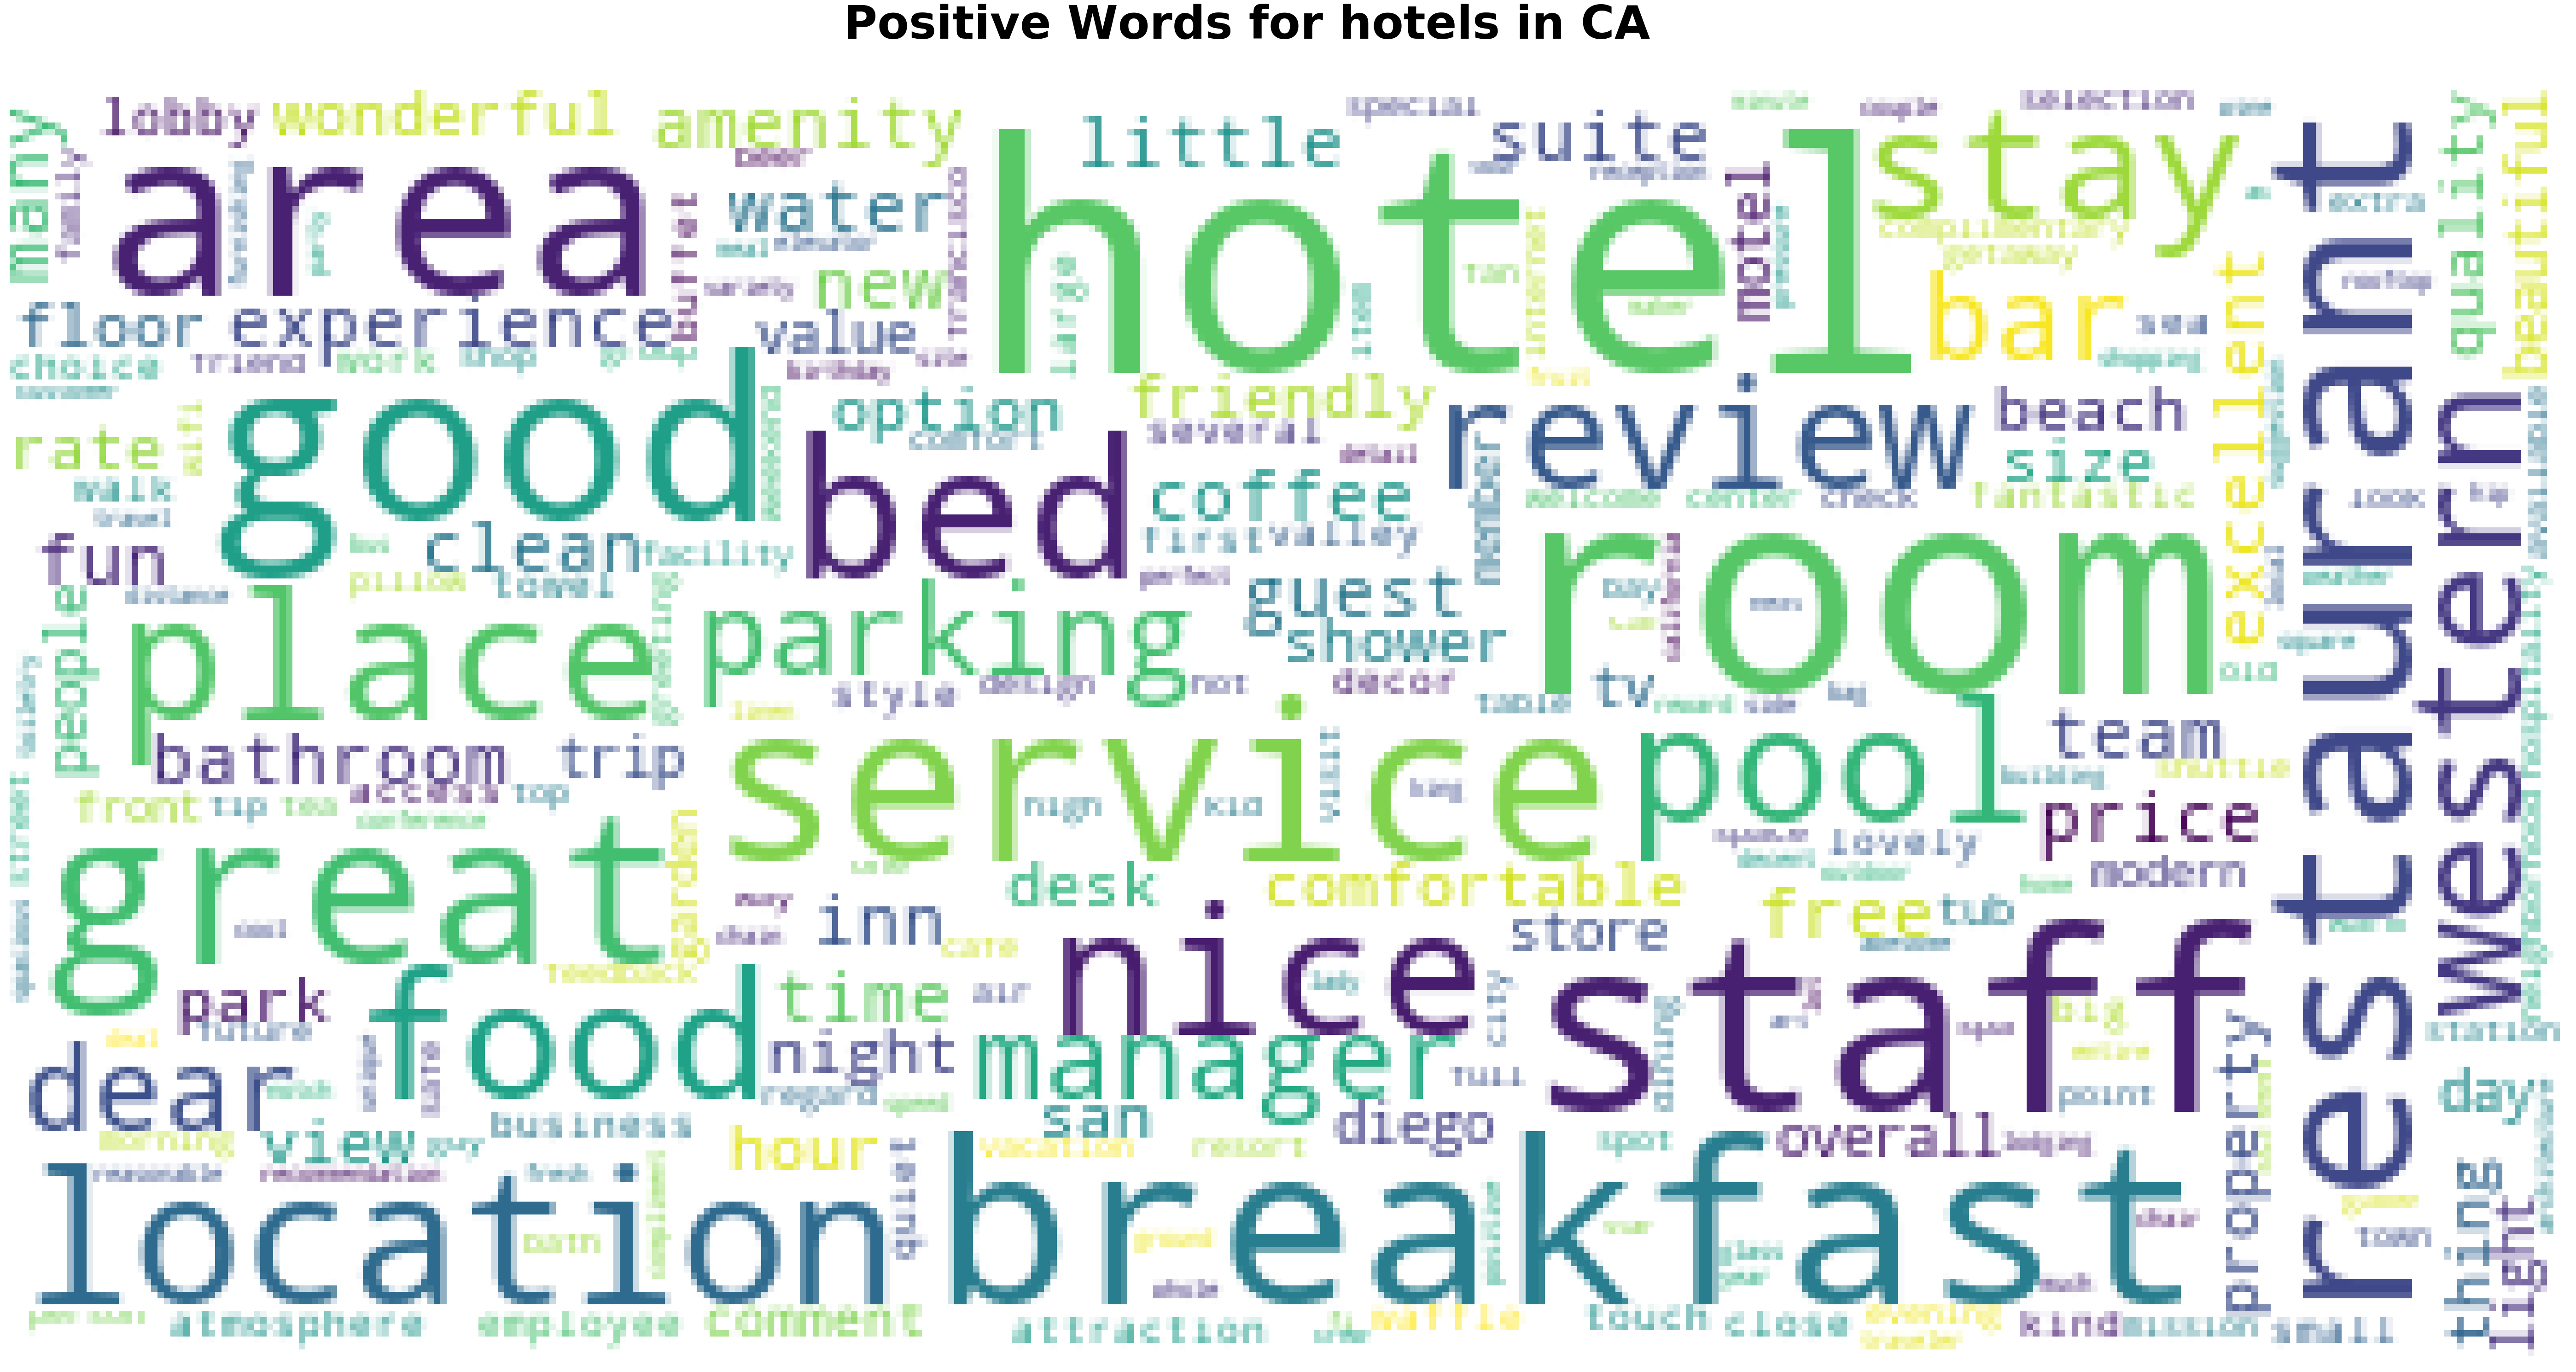

In [15]:
text_pos, text_neg = gen_text(CA_term_dict)
wc(text_pos,'white','Positive Words for hotels in CA' )

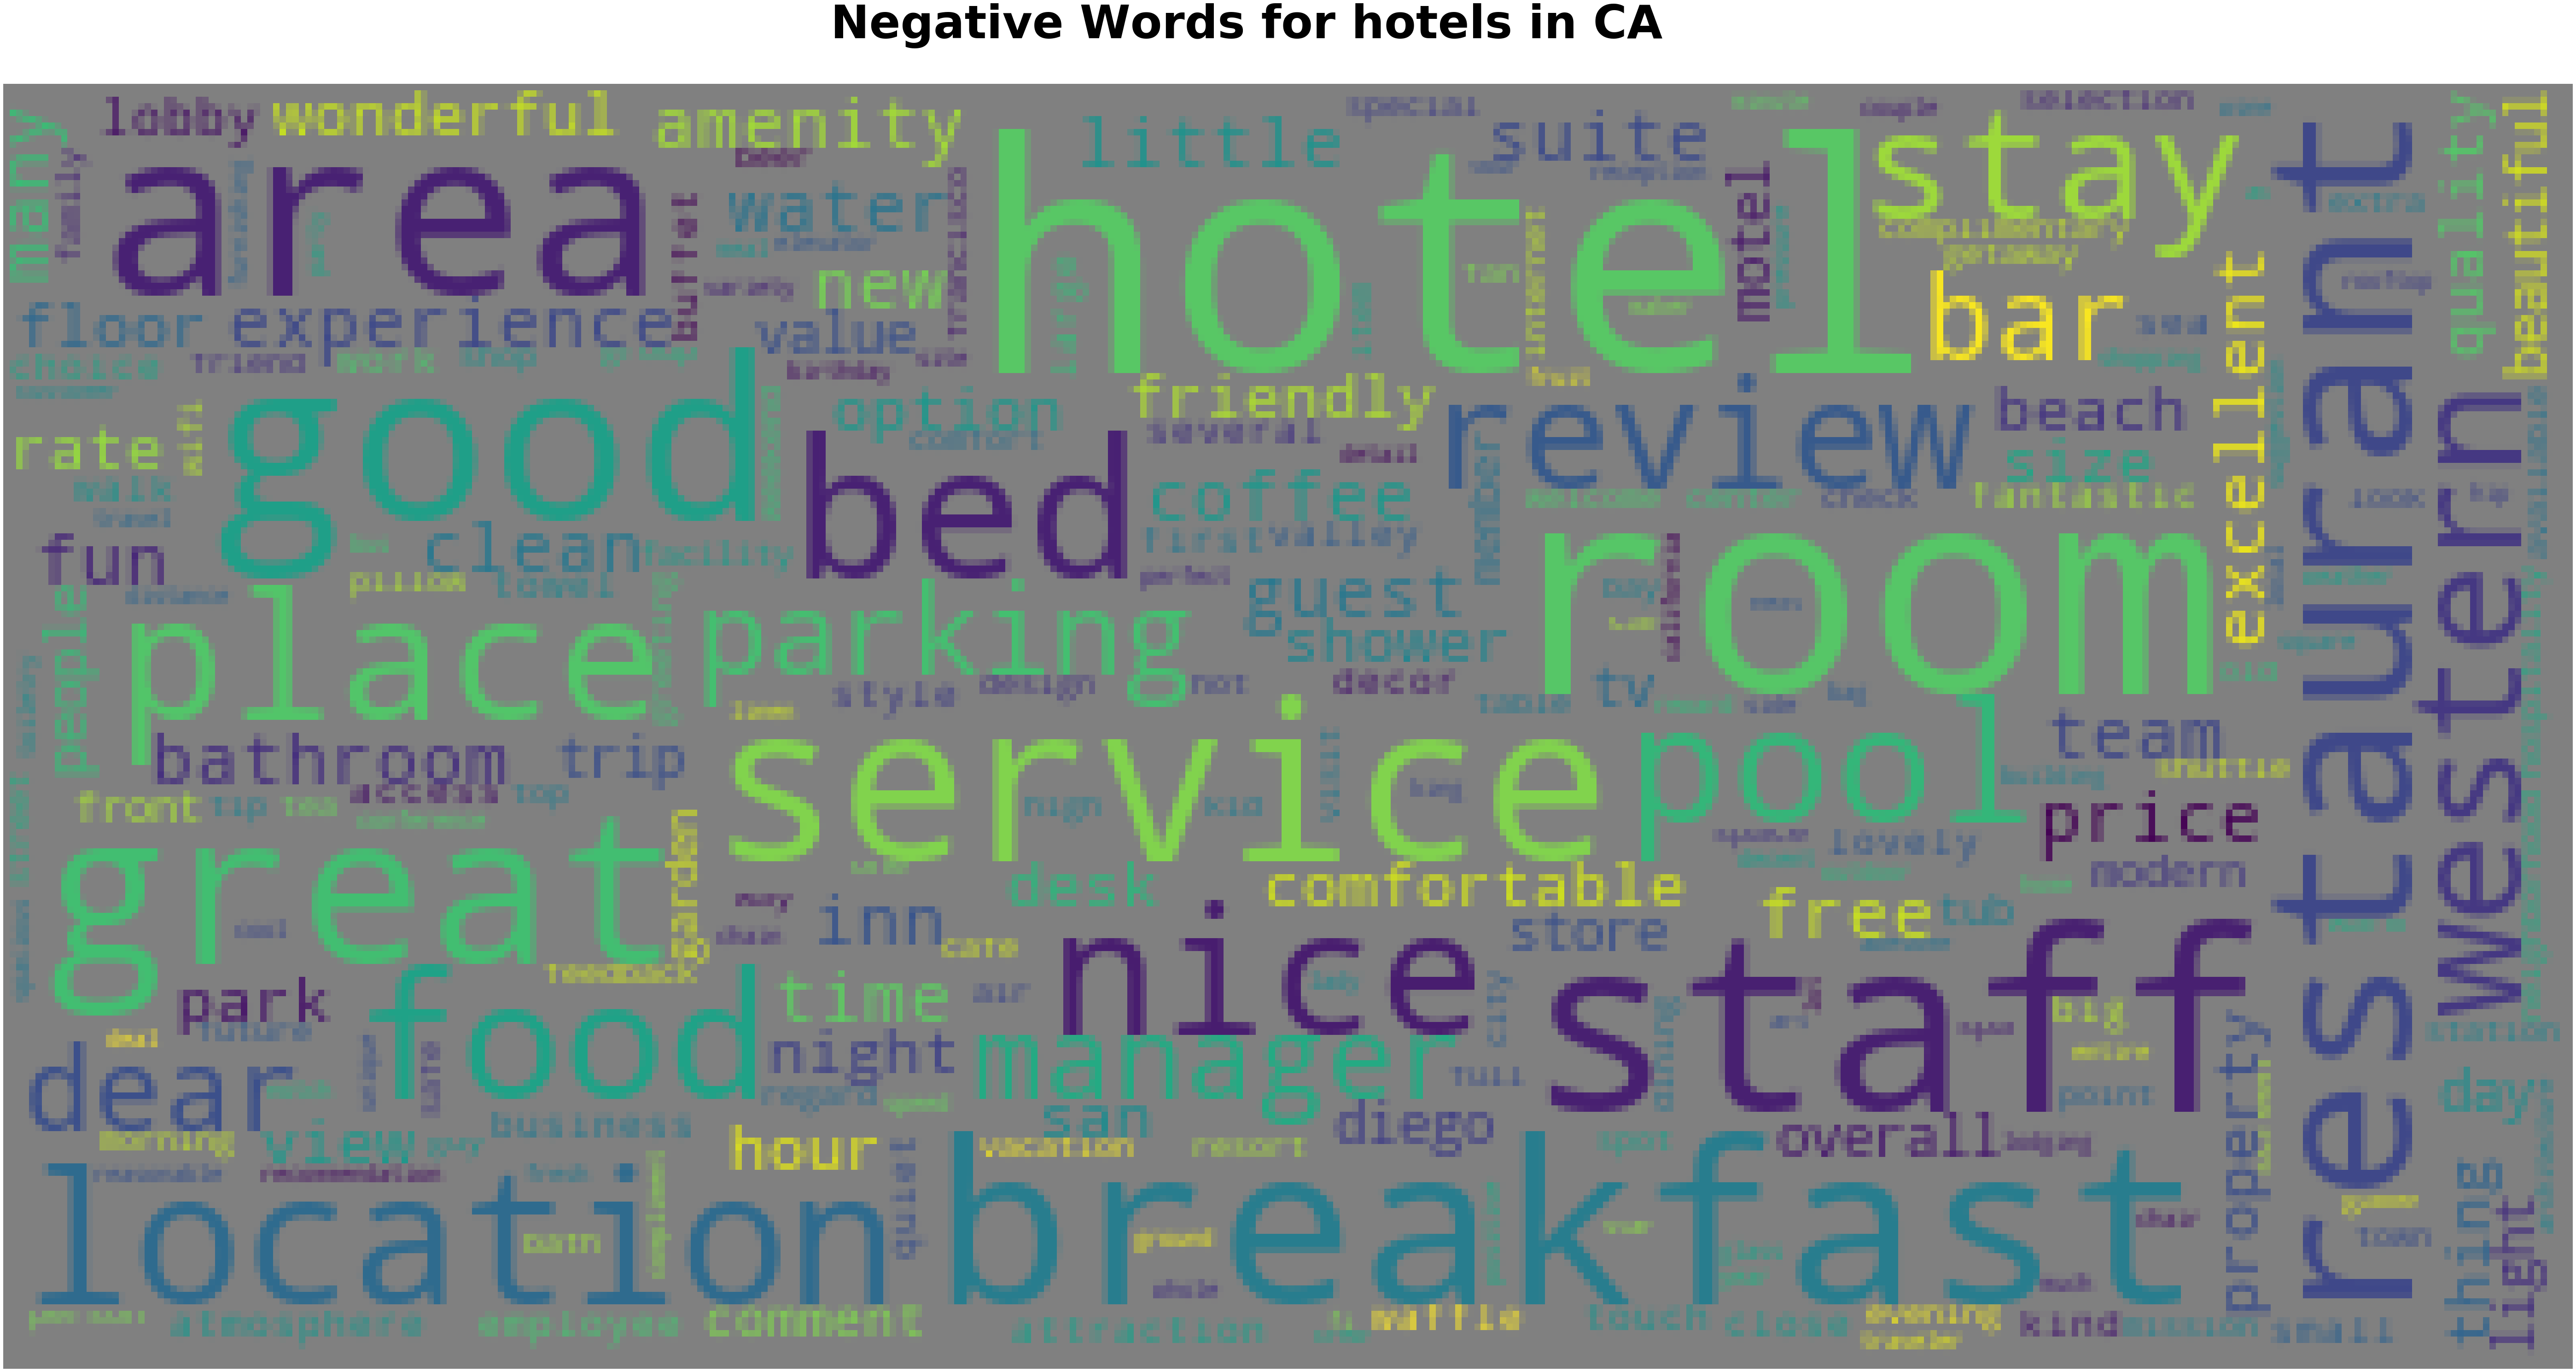

In [16]:
wc(text_pos,'grey','Negative Words for hotels in CA' )

In [17]:
lowest = defaultdict()
highest = defaultdict()
for i in CA_term_dict:
    if CA_term_dict[i]:
        highest[i] = CA_term_dict[i].most_common()[:10]
        lowest[i] = CA_term_dict[i].most_common()[-10:]
highest_df = pd.DataFrame(highest)
lowest_df = pd.DataFrame(lowest)
lowest_df = lowest_df.drop(["OTHER"],1)
highest_df = highest_df.drop(["OTHER"],1)
highest_df

LOCATION                CHECKIN  \
0         (location, 815.5)      (feedback, 173.0)   
1           (place, 282.25)           (wifi, 81.0)   
2             (view, 134.0)          (wi fi, 51.5)   
3              (area, 63.5)      (san diego, 27.5)   
4              (size, 58.0)          (check, 26.5)   
5            (choice, 50.0)      (kind word, 25.5)   
6         (pool area, 47.0)      (free wifi, 18.5)   
7    (great location, 39.5)          (valet, 18.5)   
8              (walk, 39.5)           (mike, 12.5)   
9  (walking distance, 28.5)  (valet parking, 12.0)   

                            FOOD              BUILDING                  ROOMS  \
0             (breakfast, 399.5)      (parking, 109.0)        (room, 1527.75)   
1            (restaurant, 138.5)      (property, 72.5)        (hotel, 788.75)   
2                  (food, 112.0)        (ground, 69.0)           (bed, 428.5)   
3                 (people, 53.0)          (city, 36.5)          (pool, 134.0)   
4       (breakfast buffet, 49.0)           (lot, 28.0)  (hotel staff, 111.75)   
5  (continental breakfast, 47.5)  (free parking, 24.0)            (tub, 91.5)   
6                 (coffee, 43.5)  (office manager, 20)          (guest, 86.0)   
7            (western sea, 41.5)        (part, 19.625)     (clean room, 76.5)   
8         (free breakfast, 36.5)         (block, 12.5)          (decor, 50.0)   
9                     (wine, 30)          (that, 11.5)     (front desk, 49.5)   

                  CLEANLINESS                     VALUE  \
0             (amenity, 96.5)            (value, 140.0)   
1                (regard, 81)            (price, 131.0)   
2             (comfort, 31.0)              (rate, 61.0)   
3             (quality, 30.0)         (value guest, 18)   
4        (satisfaction, 27.0)             (bonus, 15.5)   
5  (housekeeping staff, 19.5)              (deal, 15.5)   
6         (good regard, 19.5)  (overall experience, 15)   
7         (clean staff, 19.5)            (option, 11.5)   
8                (rating, 19)        (expectation, 9.5)   
9           (cleanliness, 15)          (great value, 9)   

                    SERVICE                  BUSINESS  
0           (staff, 1439.5)            (family, 53.5)  
1         (service, 290.75)               (job, 51.0)  
2       (experience, 221.0)          (business, 41.5)  
3      (desk staff, 105.75)          (shopping, 31.0)  
4    (friendly staff, 95.5)          (employee, 22.5)  
5       (front staff, 90.5)          (customer, 20.0)  
6            (access, 69.0)  (relation manager, 17.5)  
7  (customer service, 60.0)   (general manager, 16.5)  
8              (stay, 60.0)                (shop, 15)  
9     (helpful staff, 42.0)      (sea management, 15)

In [18]:
lowest_df

LOCATION                CHECKIN                     FOOD  \
0             (hill, -2.5)           (steven, -2)      (random people, -3)   
1     (only complaint, -3)         (mcdonald, -2)  (provide shampoo, -3.0)   
2                (del, -3)  (afternoon nap, -2.5)             (diaper, -3)   
3          (workout, -3.0)           (tv box, -3)              (plate, -3)   
4          (sink area, -3)           (hilton, -3)            (egg tot, -3)   
5  (parking situation, -3)           (flight, -3)            (bread, -4.0)   
6          (situation, -4)        (tater tot, -3)               (corn, -4)   
7    (limited storage, -4)          (antonio, -3)           (boil egg, -6)   
8          (complaint, -4)   (tv reception, -3.5)      (garbage truck, -7)   
9             (outlet, -7)         (high etc, -4)             (egg, -23.0)   

                BUILDING                ROOMS               CLEANLINESS  \
0      (parking fee, -5)  (only negative, -7)  (air conditioning, -3.5)   
1       (glass door, -5)           (dust, -7)   (noise pollution, -3.5)   
2   (construction, -6.5)         (sink, -9.0)         (clean rip, -4.0)   
3             (door, -7)         (child, -10)         (bad smell, -5.5)   
4            (smoke, -7)      (carpet, -11.0)                (lack, -6)   
5   (parking lot, -9.25)  (only thing, -11.5)         (noise issue, -6)   
6          (road, -10.0)       (thing, -12.0)                (odor, -8)   
7  (street noise, -12.5)          (side, -12)        (road noise, -8.5)   
8      (elevator, -17.0)      (toilet, -14.0)            (smell, -24.0)   
9        (street, -21.0)      (bunk bed, -25)            (noise, -57.0)   

                   VALUE                 SERVICE                   BUSINESS  
0              (sum, -2)  (arrogant staff, -2.5)         (job demand, -1.5)  
1             (dust, -2)   (only drawback, -3.5)               (time, -1.5)  
2  (different level, -2)                (ac, -4)               (credit, -2)  
3     (disadvantage, -2)         (daily fee, -4)                (buyer, -2)  
4  (slight downside, -2)             (phone, -4)    (commercial street, -2)  
5       (downside, -2.5)               (del, -4)          (plaster job, -2)  
6   (fair warning, -2.5)     (traffic noise, -4)         (desk manager, -2)  
7   (additional fee, -4)            (lift, -4.5)           (boot print, -2)  
8     (noise level, -16)    (poor service, -6.5)                 (bank, -3)  
9   (only downside, -17)          (traffic, -20)  (cancellation policy, -5)

## CO Hotel Review

In [19]:
aspect_sent, CO_term_dict = gen_dict("hotel_reviewCO.txt")
CO_df = gen_rate(aspect_sent)
CO_df

aspect     pos    neg  rate
0      LOCATION   69.00  11.00   4.4
1       CHECKIN   32.50   2.00   4.8
2          FOOD  117.50  11.00   4.7
3      BUILDING   10.00   5.00   3.7
4         ROOMS  223.75  29.25   4.5
5   CLEANLINESS   22.50   1.00   4.8
6         VALUE    6.00   1.00   4.4
7       SERVICE   76.00  14.50   4.4
8      BUSINESS   20.00   0.00   5.0
9         OTHER   33.50   3.50   4.6
10        TOTAL  610.75  78.25   4.5

In [20]:
a_series = pd. Series(['CO'] + list(CO_df['rate']), index = total_df. columns)
total_df = total_df.append(a_series, ignore_index=True)

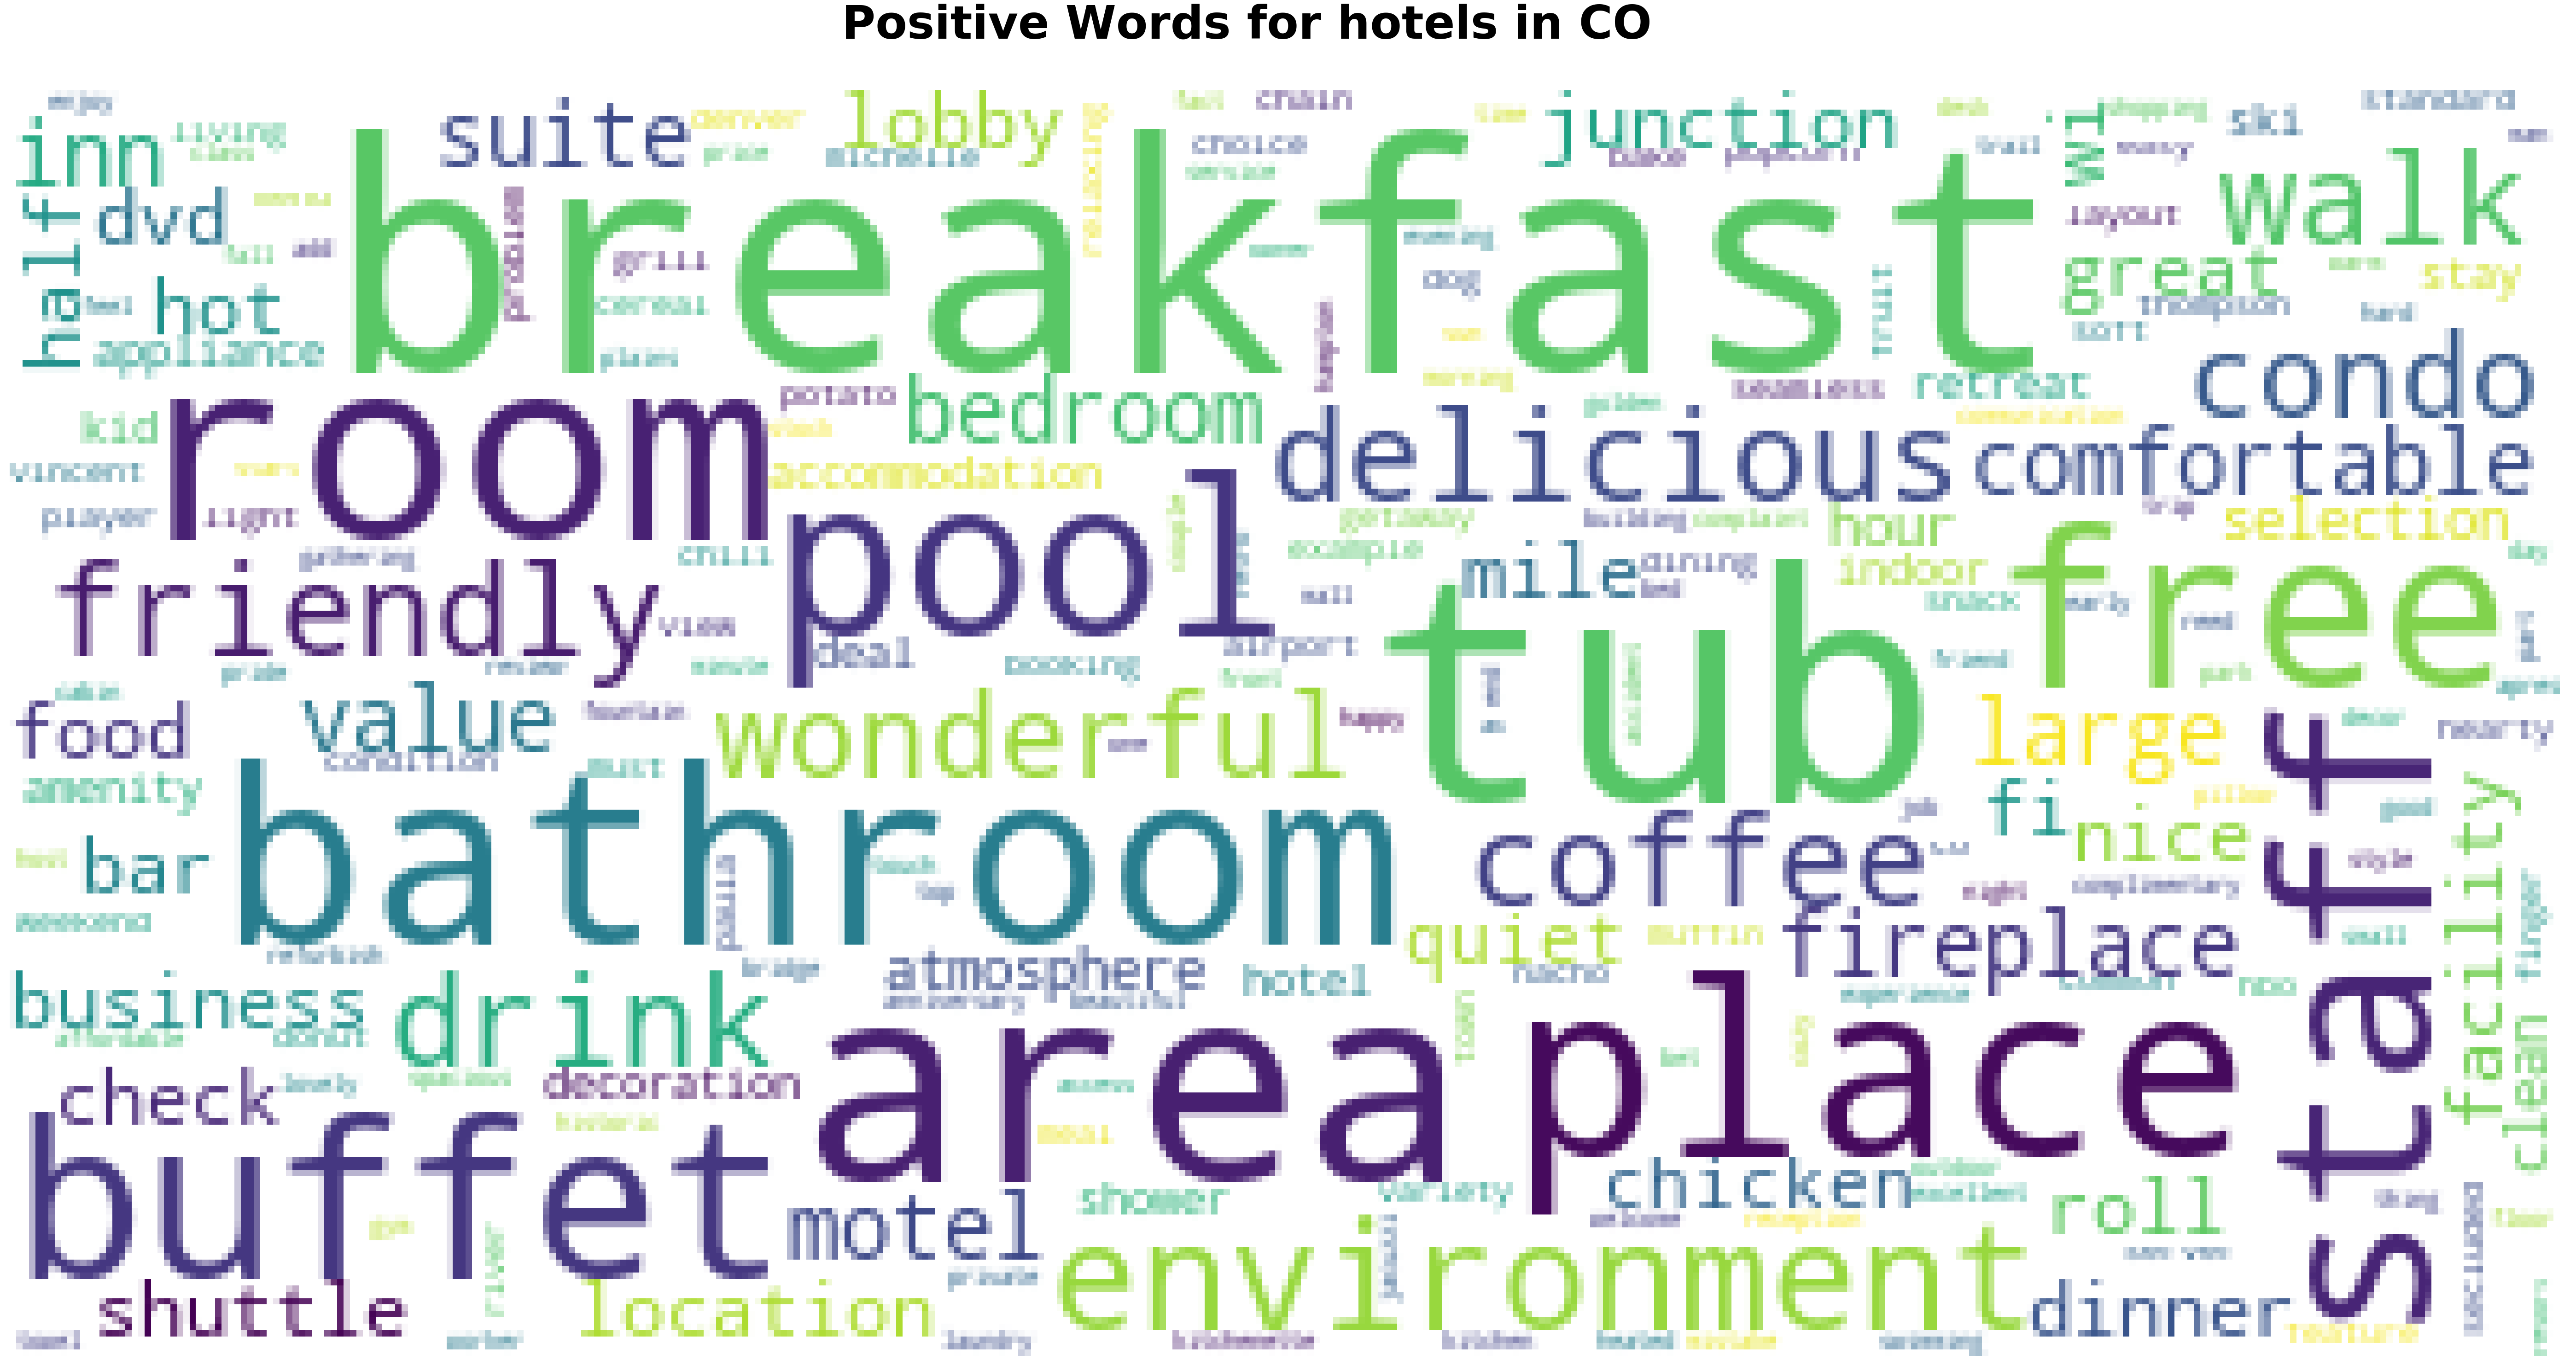

In [21]:
text_pos, text_neg = gen_text(CO_term_dict)
wc(text_pos,'white','Positive Words for hotels in CO' )

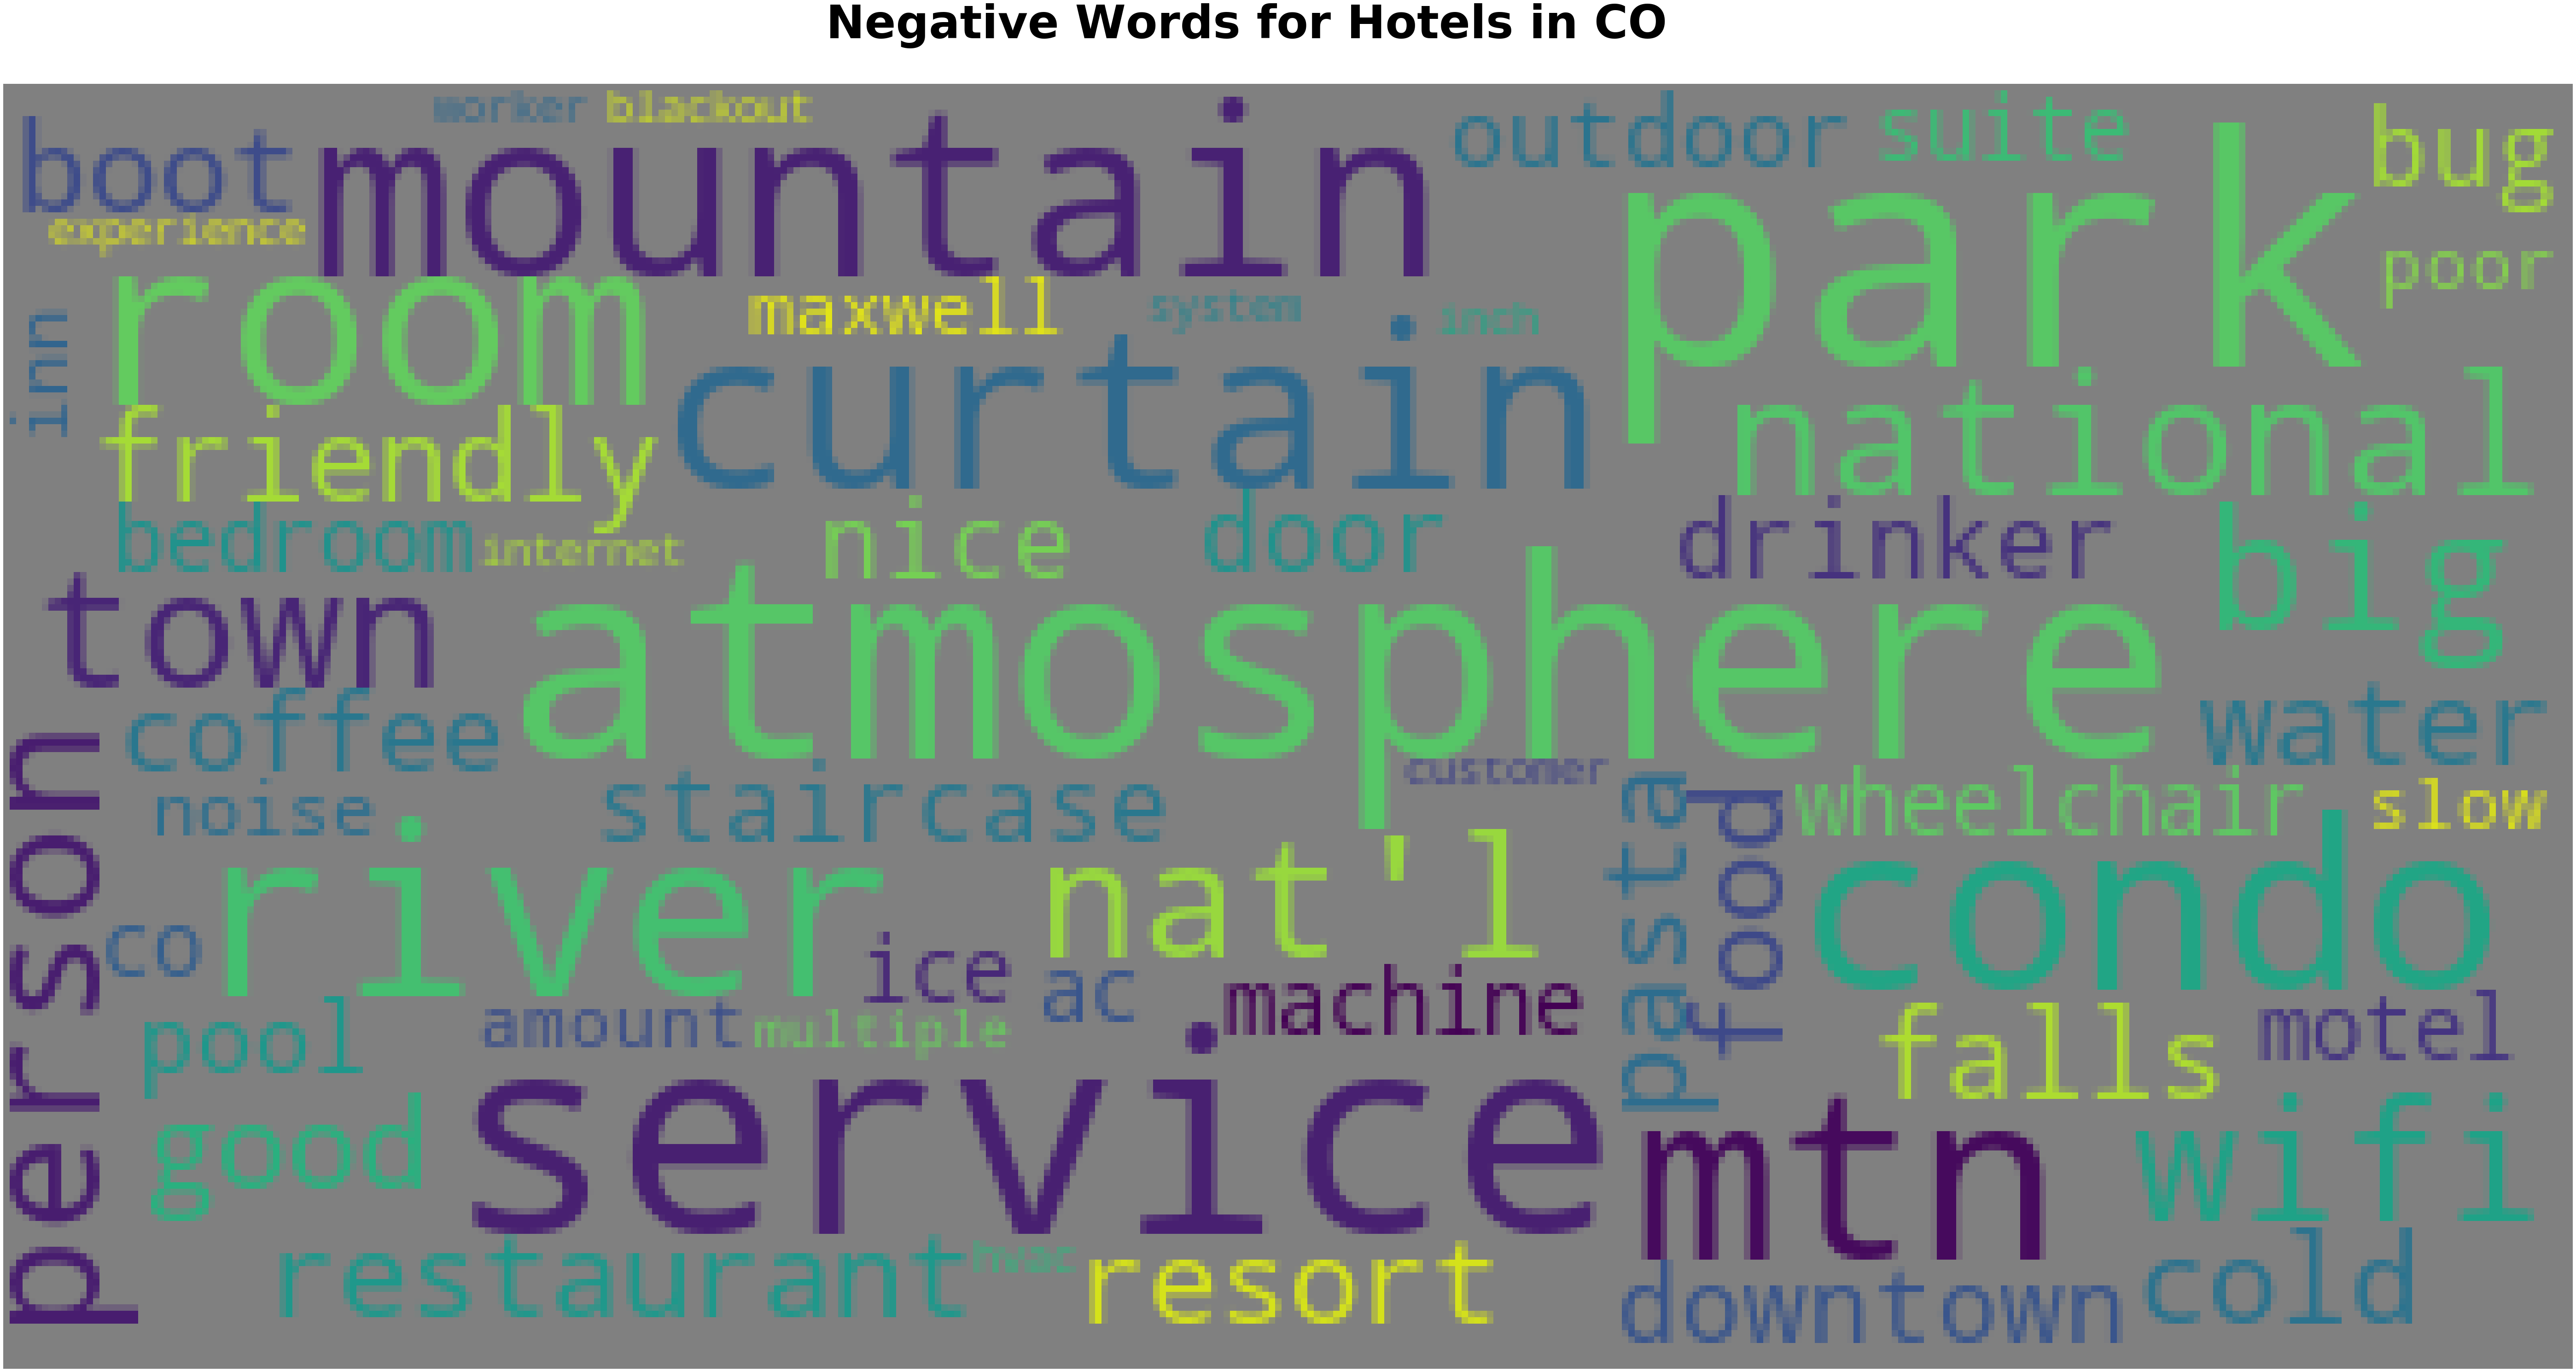

In [22]:
wc(text_neg,'grey','Negative Words for Hotels in CO' )

In [23]:
lowest = defaultdict()
highest = defaultdict()
for i in CO_term_dict:
    if CO_term_dict[i]:
        highest[i] = CO_term_dict[i].most_common()[:5]
        lowest[i] = CO_term_dict[i].most_common()[-5:]
highest_df = pd.DataFrame(highest)
lowest_df = pd.DataFrame(lowest)
lowest_df = lowest_df.drop(["OTHER"],1)
highest_df = highest_df.drop(["OTHER"],1)
highest_df

LOCATION        CHECKIN                    FOOD  \
0     (place, 16.5)     (wi fi, 5)         (breakfast, 12)   
1    (location, 10)        (wi, 5)         (delicious, 12)   
2         (view, 6)   (free fi, 3)      (quiet buffet, 10)   
3   (easy place, 3)  (michelle, 2)   (friendly buffet, 10)   
4  (great place, 3)    (server, 2)  (delicious buffet, 10)   

                 BUILDING             ROOMS                CLEANLINESS  \
0        (park condos, 2)      (room, 35.5)                   (ski, 5)   
1              (floor, 1)       (bed, 17.0)                (minute, 5)   
2           (fountain, 1)    (hotel, 11.75)               (amenity, 4)   
3                (the, 1)  (bathroom, 11.0)  (beautiful decoration, 4)   
4  (historic building, 1)   (hot tub, 11.0)            (decoration, 2)   

              VALUE             SERVICE                   BUSINESS  
0        (price, 2)       (staff, 37.0)                 (owner, 4)  
1  (early value, 1)   (desk staff, 8.0)       (end appliance, 2.5)  
2    (add value, 1)        (service, 5)      (small atmosphere, 2)  
3        (value, 1)  (front staff, 4.5)  (friendly environment, 2)  
4         (deal, 1)           (free, 4)   (welcome environment, 2)

In [24]:
lowest_df

LOCATION               CHECKIN                  FOOD  \
0     (nat'l park, -1)          (vincent, 1)            (boot, -1)   
1       (mtn park, -1)             (roll, 1)           (water, -1)   
2         (person, -2)  (airport shuttle, 1)     (falls river, -1)   
3  (mountain park, -3)  (booking problem, 1)  (coffee drinker, -1)   
4  (national park, -3)            (wifi, -1)       (cold food, -2)   

               BUILDING                 ROOMS                CLEANLINESS  \
0  (refurbish condo, 1)              (ac, -1)  (beautiful decoration, 4)   
1        (downtown, -1)         (curtain, -1)            (decoration, 2)   
2       (staircase, -1)        (co motel, -2)        (nice amenity, 1.5)   
3            (door, -1)  (maxwell inn, -2.25)                 (pride, 1)   
4           (condo, -2)     (ice machine, -3)                (noise, -1)   

              VALUE                 SERVICE              BUSINESS  
0  (early value, 1)  (blackout curtain, -1)  (top appliance, 1.5)  
1    (add value, 1)       (hvac system, -1)      (environment, 1)  
2        (value, 1)          (worker, -1.5)              (job, 1)  
3         (deal, 1)  (customer service, -2)    (shopping mall, 1)  
4      (amount, -1)          (internet, -3)   (business class, 1)

## FL Hotel Review

In [25]:
aspect_sent, FL_term_dict = gen_dict("hotel_reviewFL.txt")
FL_df = gen_rate(aspect_sent)
FL_df

aspect       pos      neg  rate
0      LOCATION   1231.00   152.50   4.6
1       CHECKIN    611.50   110.50   4.4
2          FOOD   1297.50   345.50   4.2
3      BUILDING    413.00   128.25   4.1
4         ROOMS   3330.00   828.25   4.2
5   CLEANLINESS    296.25   127.00   3.8
6         VALUE    367.00    61.50   4.4
7       SERVICE   1807.50   217.00   4.6
8      BUSINESS    255.50    67.00   4.2
9         OTHER    847.50   177.50   4.3
10        TOTAL  10456.75  2215.00   4.3

In [26]:
a_series = pd. Series(['FL'] + list(FL_df['rate']), index = total_df. columns)
total_df = total_df.append(a_series, ignore_index=True)

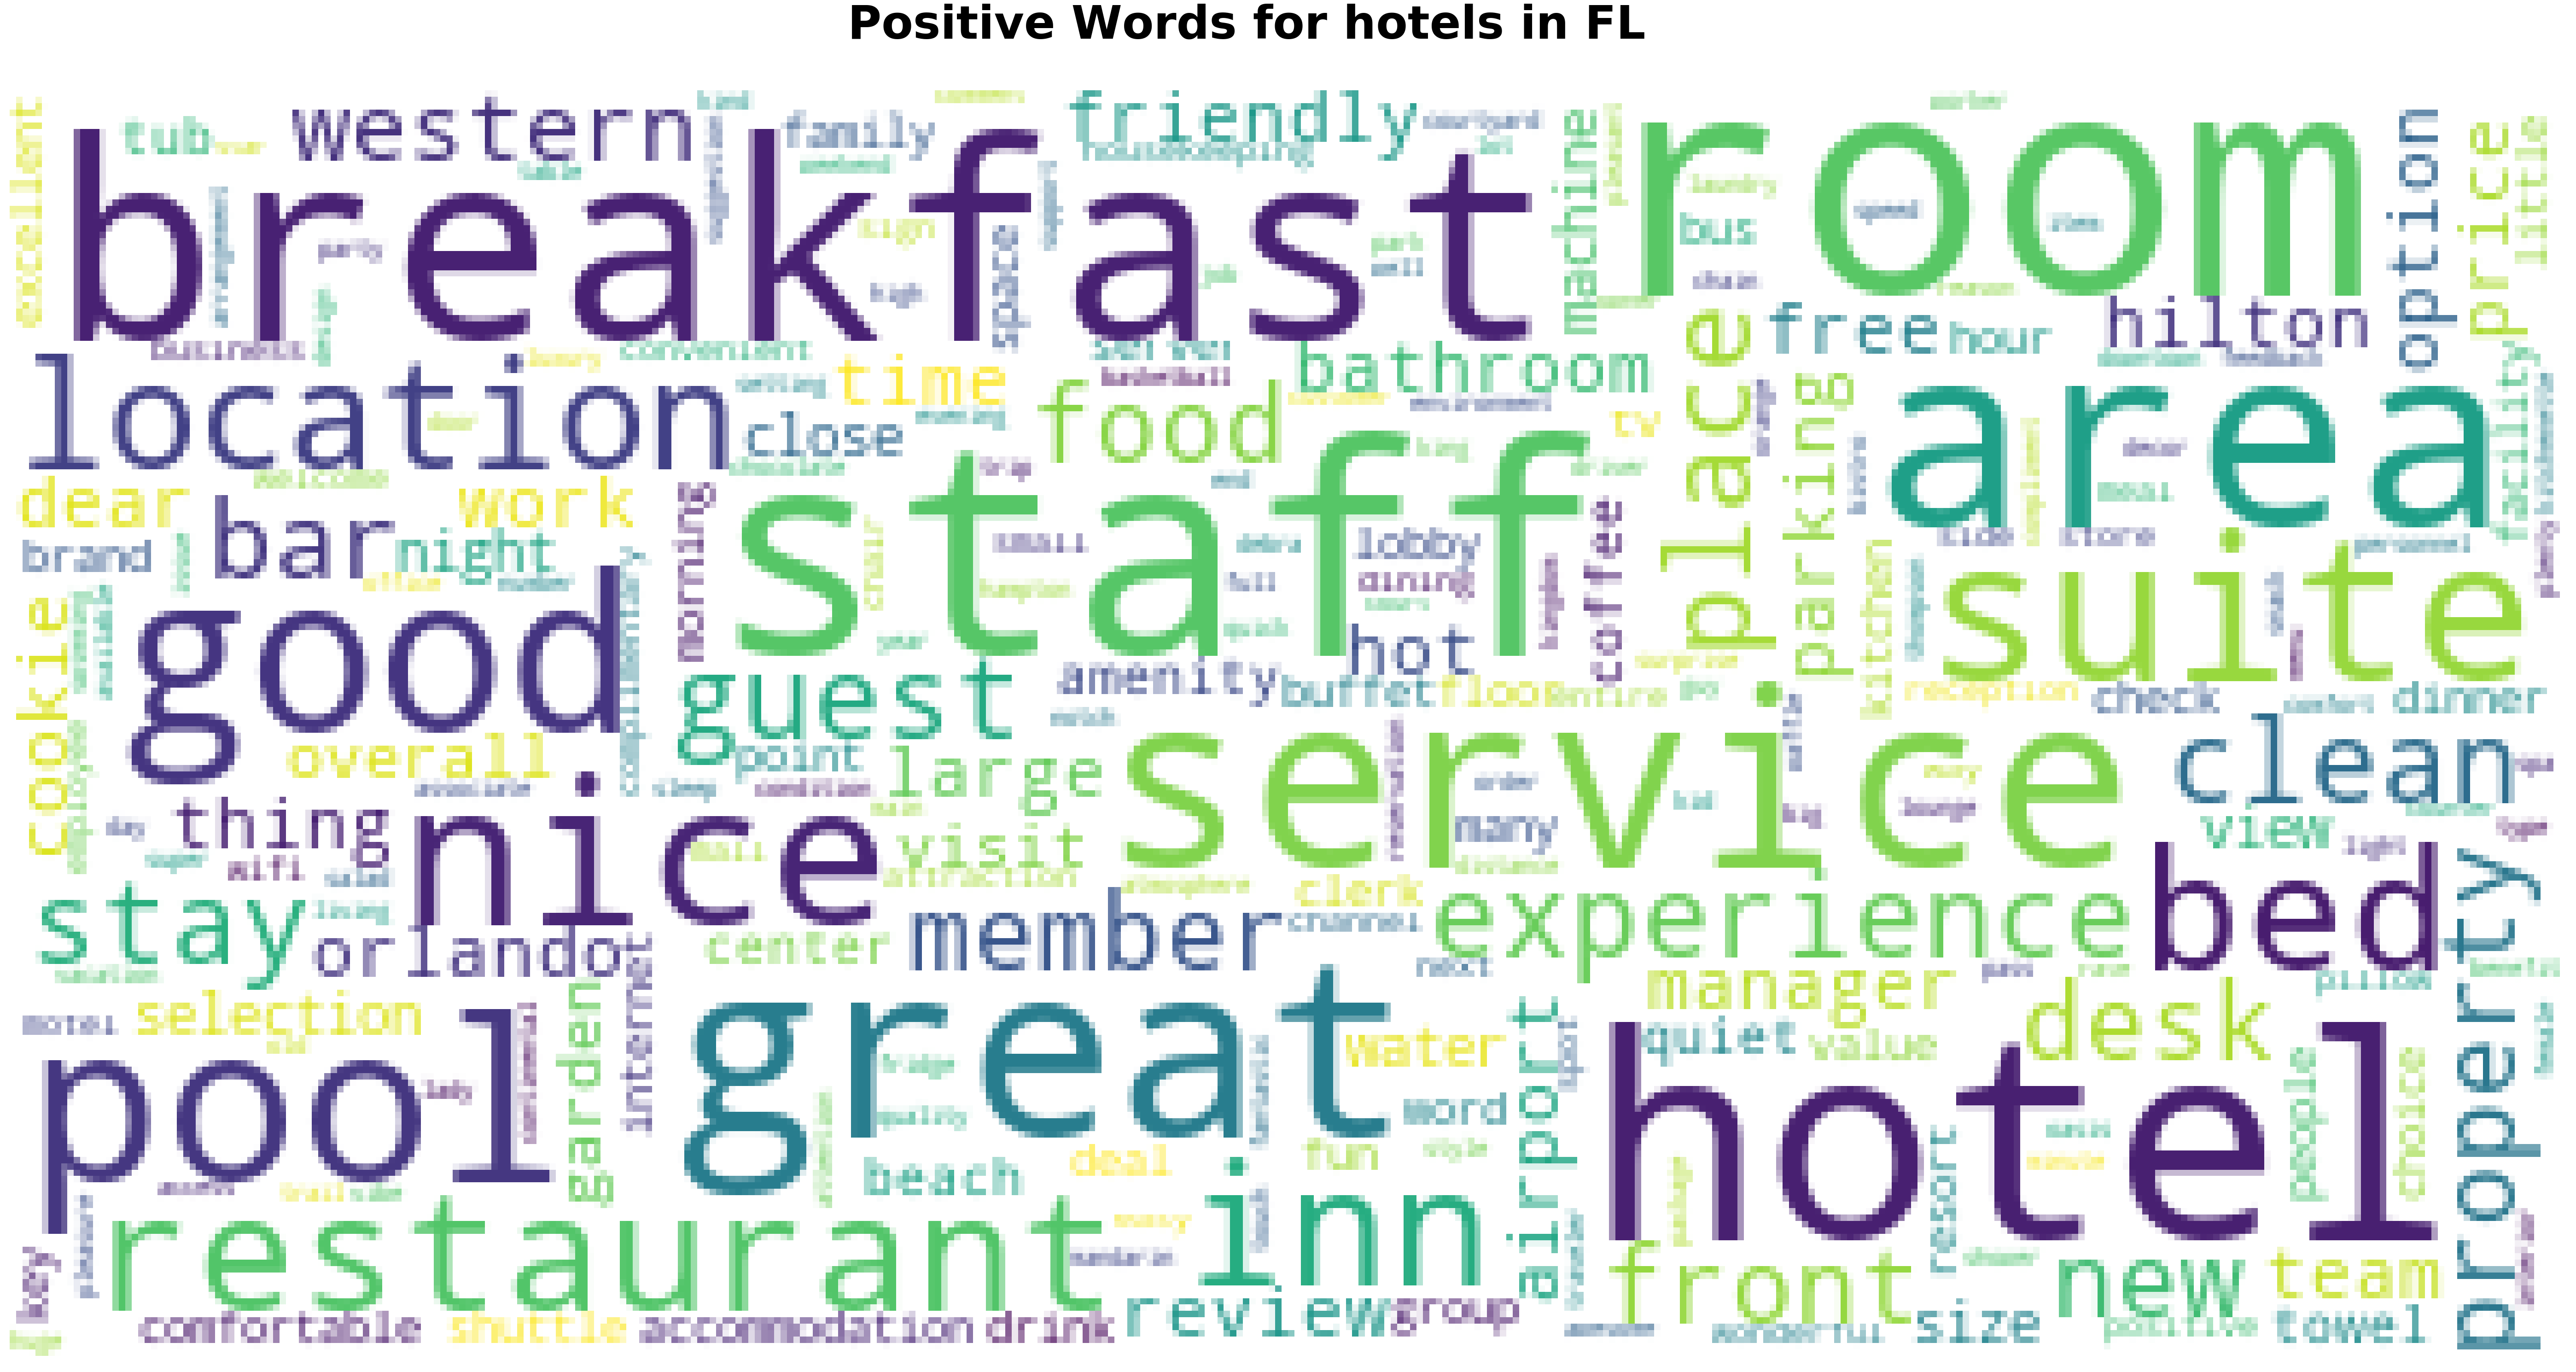

In [27]:
text_pos, text_neg = gen_text(FL_term_dict)
wc(text_pos,'white','Positive Words for hotels in FL' )

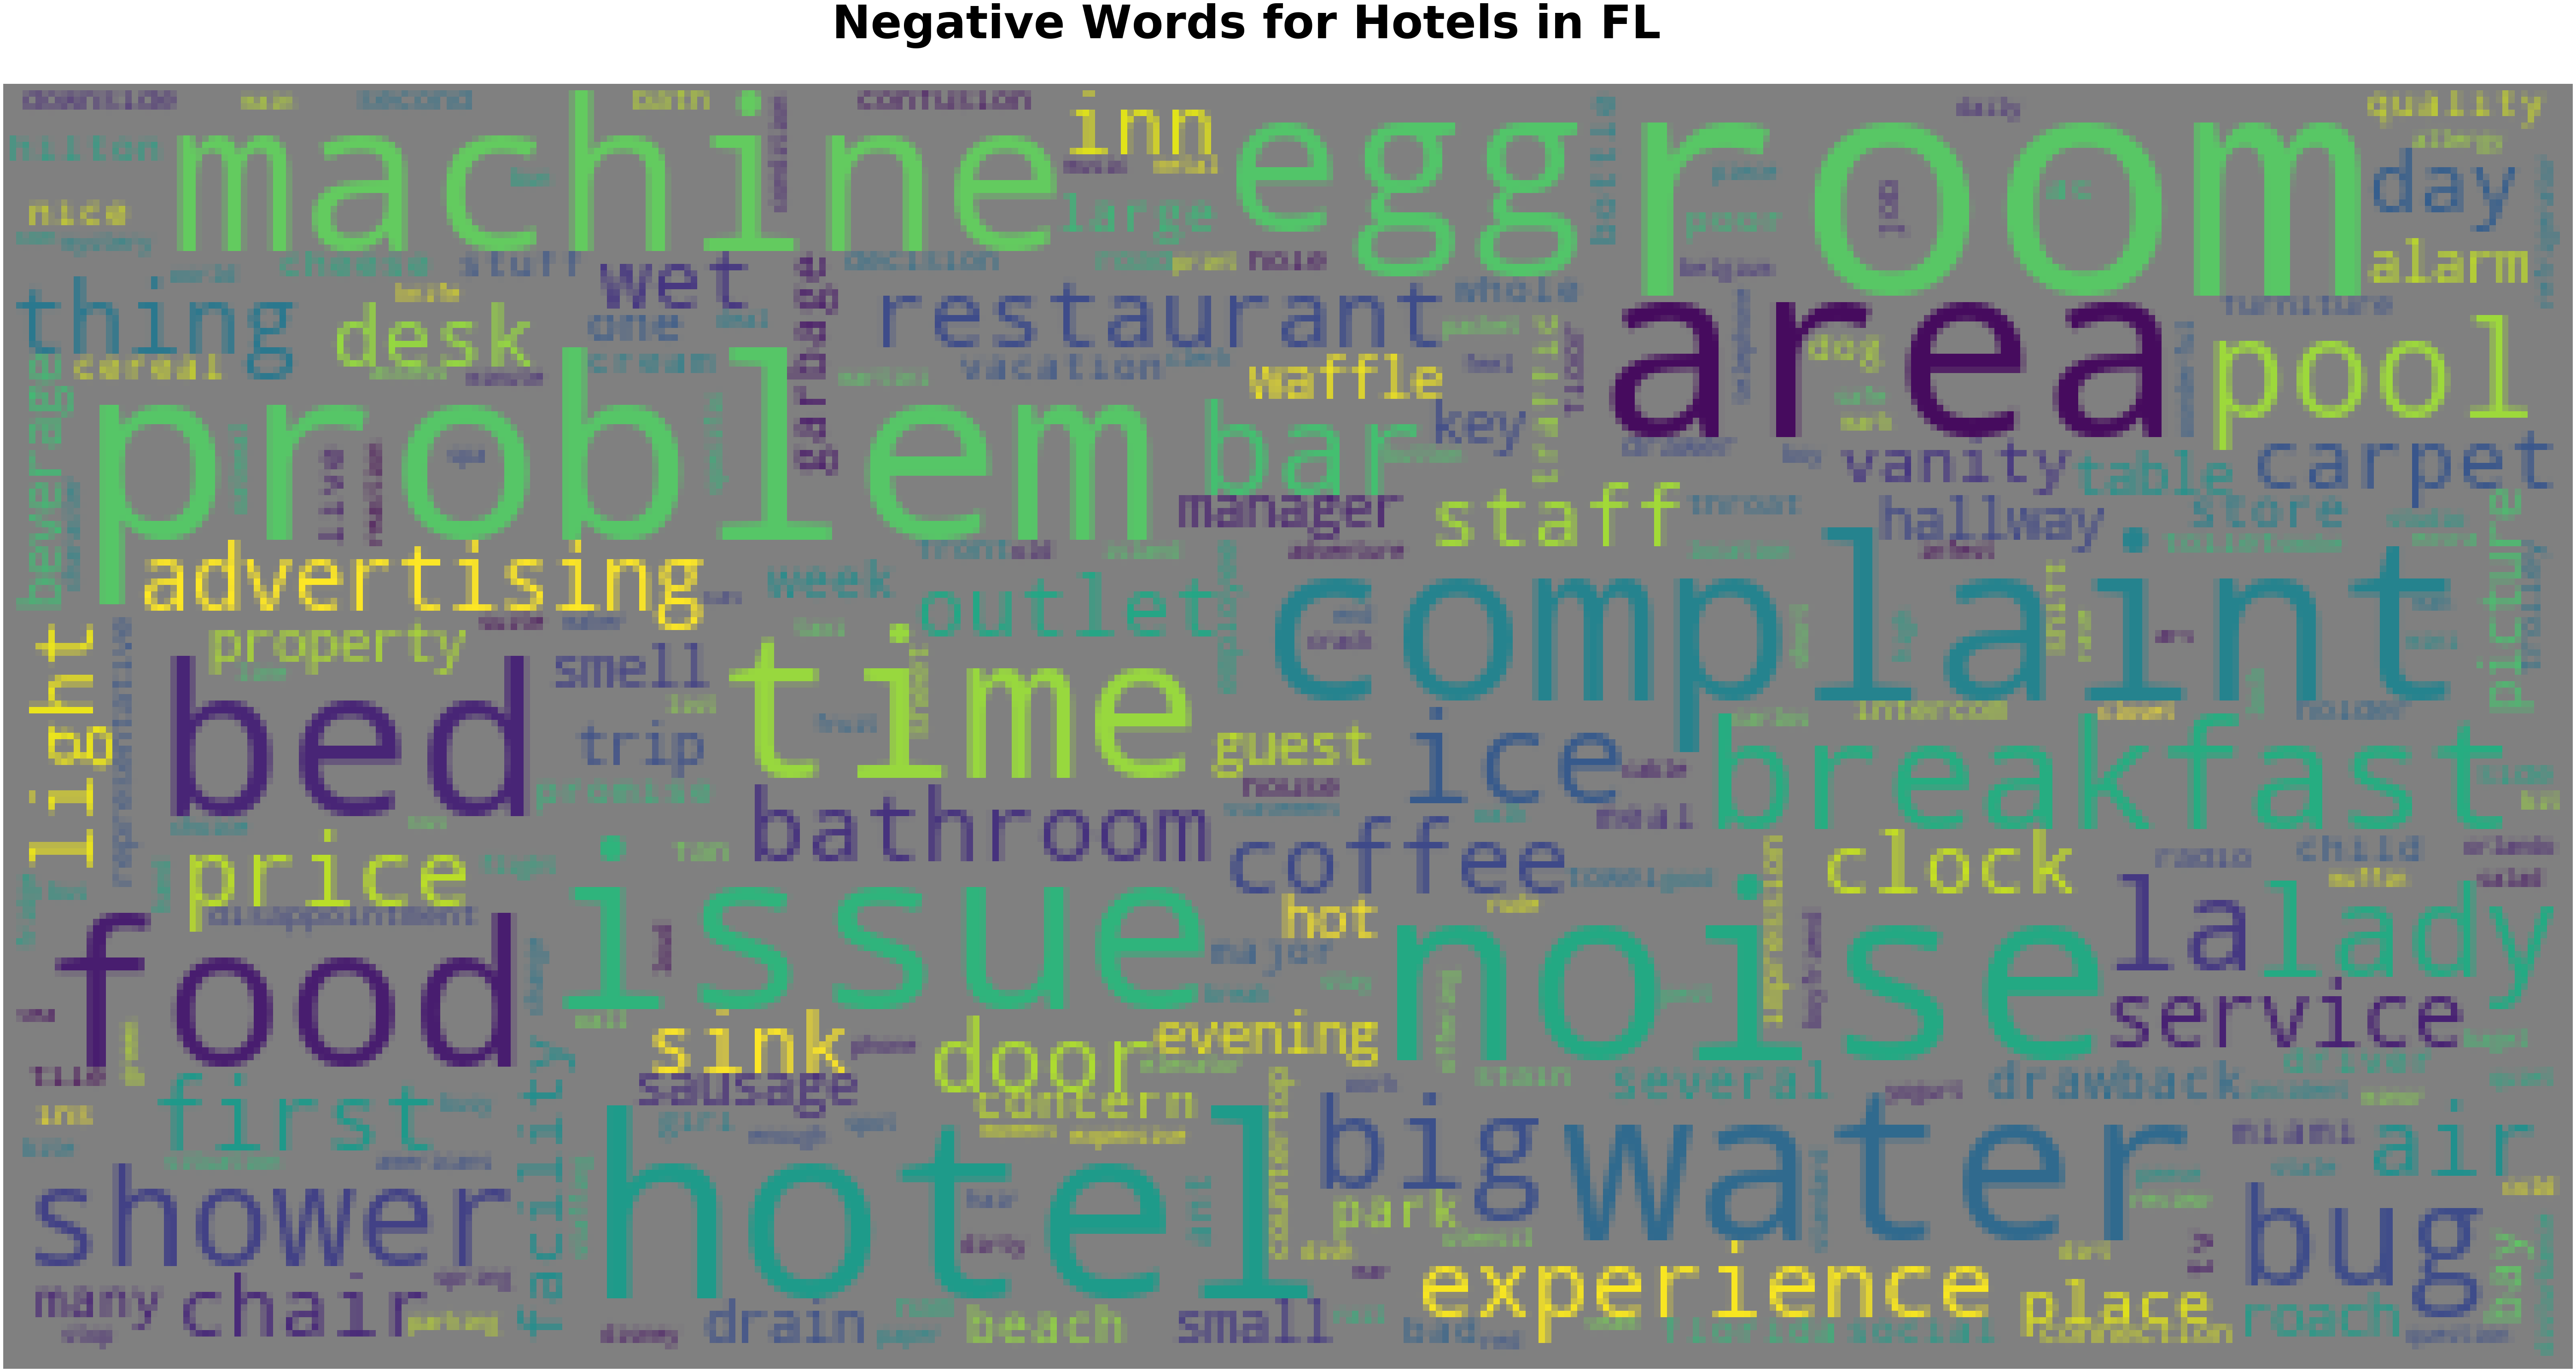

In [28]:
wc(text_neg,'grey','Negative Words for Hotels in FL' )

In [29]:
lowest = defaultdict()
highest = defaultdict()
for i in FL_term_dict:
    if FL_term_dict[i]:
        highest[i] = FL_term_dict[i].most_common()[:10]
        lowest[i] = FL_term_dict[i].most_common()[-10:]
highest_df = pd.DataFrame(highest)
lowest_df = pd.DataFrame(lowest)
lowest_df = lowest_df.drop(["VALUE"],1)
highest_df = highest_df.drop(["VALUE"],1)
highest_df

LOCATION                  CHECKIN  \
0       (location, 231.0)         (feedback, 45.5)   
1          (place, 136.0)             (wifi, 23.0)   
2      (pool area, 49.25)            (check, 13.5)   
3            (view, 44.5)           (hilton, 13.0)   
4            (area, 29.0)      (hilton member, 13)   
5        (facility, 27.5)        (free wifi, 12.0)   
6            (size, 22.5)    (orlando airport, 12)   
7          (choice, 21.5)  (airport shuttle, 10.5)   
8  (great location, 19.0)            (brandon, 10)   
9  (breakfast area, 10.0)          (kind word, 10)   

                              FOOD            BUILDING                ROOMS  \
0              (breakfast, 251.75)    (property, 49.0)        (room, 663.0)   
1                     (food, 69.5)     (parking, 43.5)       (hotel, 376.0)   
2               (restaurant, 51.5)          (part, 17)         (bed, 151.0)   
3           (free breakfast, 34.0)  (free parking, 12)        (pool, 131.5)   
4         (breakfast buffet, 19.0)           (lot, 10)   (clean room, 51.0)   
5                    (water, 18.5)       (ground, 9.5)        (suite, 41.0)   
6  (complimentary breakfast, 17.5)       (floor, 8.25)  (hotel staff, 32.5)   
7                     (dinner, 15)         (home, 7.5)            (day, 27)   
8                    (drink, 13.0)           (that, 6)    (nice room, 22.0)   
9                  (variety, 12.5)       (design, 5.5)          (spa, 21.0)   

                 CLEANLINESS                VALUE                    SERVICE  \
0            (amenity, 28.5)        (price, 55.0)            (staff, 548.75)   
1            (quality, 22.5)        (value, 44.0)           (service, 132.0)   
2            (comfort, 17.5)         (rate, 25.0)         (experience, 71.5)   
3          (cleanliness, 10)          (level, 20)            (shuttle, 50.5)   
4         (clean staff, 8.5)    (expectation, 20)   (shuttle service, 33.25)   
5        (friendliness, 7.5)         (bonus, 9.5)  (customer service, 30.25)   
6              (warmth, 6.5)     (many option, 9)        (desk staff, 23.25)   
7        (housekeeping, 5.5)  (valuable guest, 8)               (stay, 22.5)   
8  (housekeeping staff, 5.0)          (amount, 7)       (front staff, 21.75)   
9        (satisfaction, 5.0)         (loyalty, 7)       (friendly staff, 19)   

                BUSINESS  
0         (family, 22.0)  
1              (job, 21)  
2      (employee, 14.75)  
3       (business, 14.5)  
4  (single employee, 12)  
5       (customer, 6.25)  
6       (environment, 6)  
7        (boutique, 5.5)  
8          (shopping, 5)  
9            (future, 5)

In [30]:
lowest_df

LOCATION                 CHECKIN                  FOOD  \
0               (foot, -2)            (button, -2)    (quality food, -3)   
1              (event, -2)        (whole load, -2)  (only complaint, -3)   
2                 (la, -2)           (problem, -2)         (hot dog, -3)   
3         (only issue, -2)    (only complaint, -2)       (sausage, -3.5)   
4      (other concern, -2)     (jorge manager, -2)       (cigarette, -4)   
5         (congestion, -2)         (bolt lock, -2)   (frosted flake, -4)   
6  (area furnishing, -2.5)  (english muffin, -2.5)  (cream cheese, -4.5)   
7             (person, -3)             (coz, -3.0)          (milk, -5.5)   
8             (remote, -3)            (b list, -3)         (cream, -5.5)   
9           (wet spot, -4)                (oj, -4)          (egg, -13.0)   

            BUILDING                 ROOMS              CLEANLINESS  \
0       (hvac, -2.0)  (only criticism, -4)        (daily noise, -2)   
1  (barn door, -2.5)    (shower drain, -4)     (constant noise, -2)   
2     (plumbing, -4)    (first room, -4.5)               (odor, -2)   
3     (building, -4)       (bed sheet, -5)       (road noise, -2.5)   
4         (pipe, -4)        (sofa bed, -5)    (air condition, -3.0)   
5        (smoke, -5)            (sink, -6)  (noise disturbance, -4)   
6         (mold, -7)       (hallway, -6.5)        (smoke smell, -5)   
7       (door, -8.5)           (sheet, -7)       (rude staff, -5.0)   
8       (road, -9.0)  (only complaint, -9)           (smell, -10.5)   
9      (wall, -10.0)       (carpet, -15.0)           (noise, -12.5)   

                        VALUE                 SERVICE  \
0           (price point, -1)       (housekeeper, -2)   
1     (only disadvantage, -1)      (vice manager, -2)   
2                (matter, -1)  (cable connection, -2)   
3               (knife, -1.5)          (couple, -2.5)   
4              (downside, -2)             (phone, -3)   
5     (employee discount, -2)              (sink, -3)   
6              (standard, -2)            (goal, -3.0)   
7   (worth advertising, -2.5)        (front lady, -3)   
8  (relationship price, -3.0)         (telephone, -4)   
9           (noise level, -5)           (traffic, -8)   

                         BUSINESS  
0            (corporate rate, -1)  
1          (family confusion, -1)  
2                 (good deal, -1)  
3          (evening social, -1.0)  
4     (general environment, -1.5)  
5    (respectful environment, -2)  
6  (disappointed advertising, -2)  
7             (same employee, -2)  
8        (fake advertising, -2.5)  
9       (money advertising, -2.5)

## GA Hotel Review

In [31]:
aspect_sent, GA_term_dict = gen_dict("hotel_reviewGA.txt")
GA_df = gen_rate(aspect_sent)
GA_df

aspect      pos      neg  rate
0      LOCATION   666.50   121.00   4.4
1       CHECKIN   389.75    70.75   4.4
2          FOOD   738.50   111.00   4.5
3      BUILDING   230.50   115.50   3.7
4         ROOMS  2015.50   528.50   4.2
5   CLEANLINESS   209.00    66.00   4.0
6         VALUE   210.00    43.00   4.3
7       SERVICE  1225.00   183.00   4.5
8      BUSINESS   166.75    33.00   4.3
9         OTHER   509.00    93.50   4.4
10        TOTAL  6360.50  1365.25   4.3

In [32]:
a_series = pd. Series(['GA'] + list(GA_df['rate']), index = total_df. columns)
total_df = total_df.append(a_series, ignore_index=True)

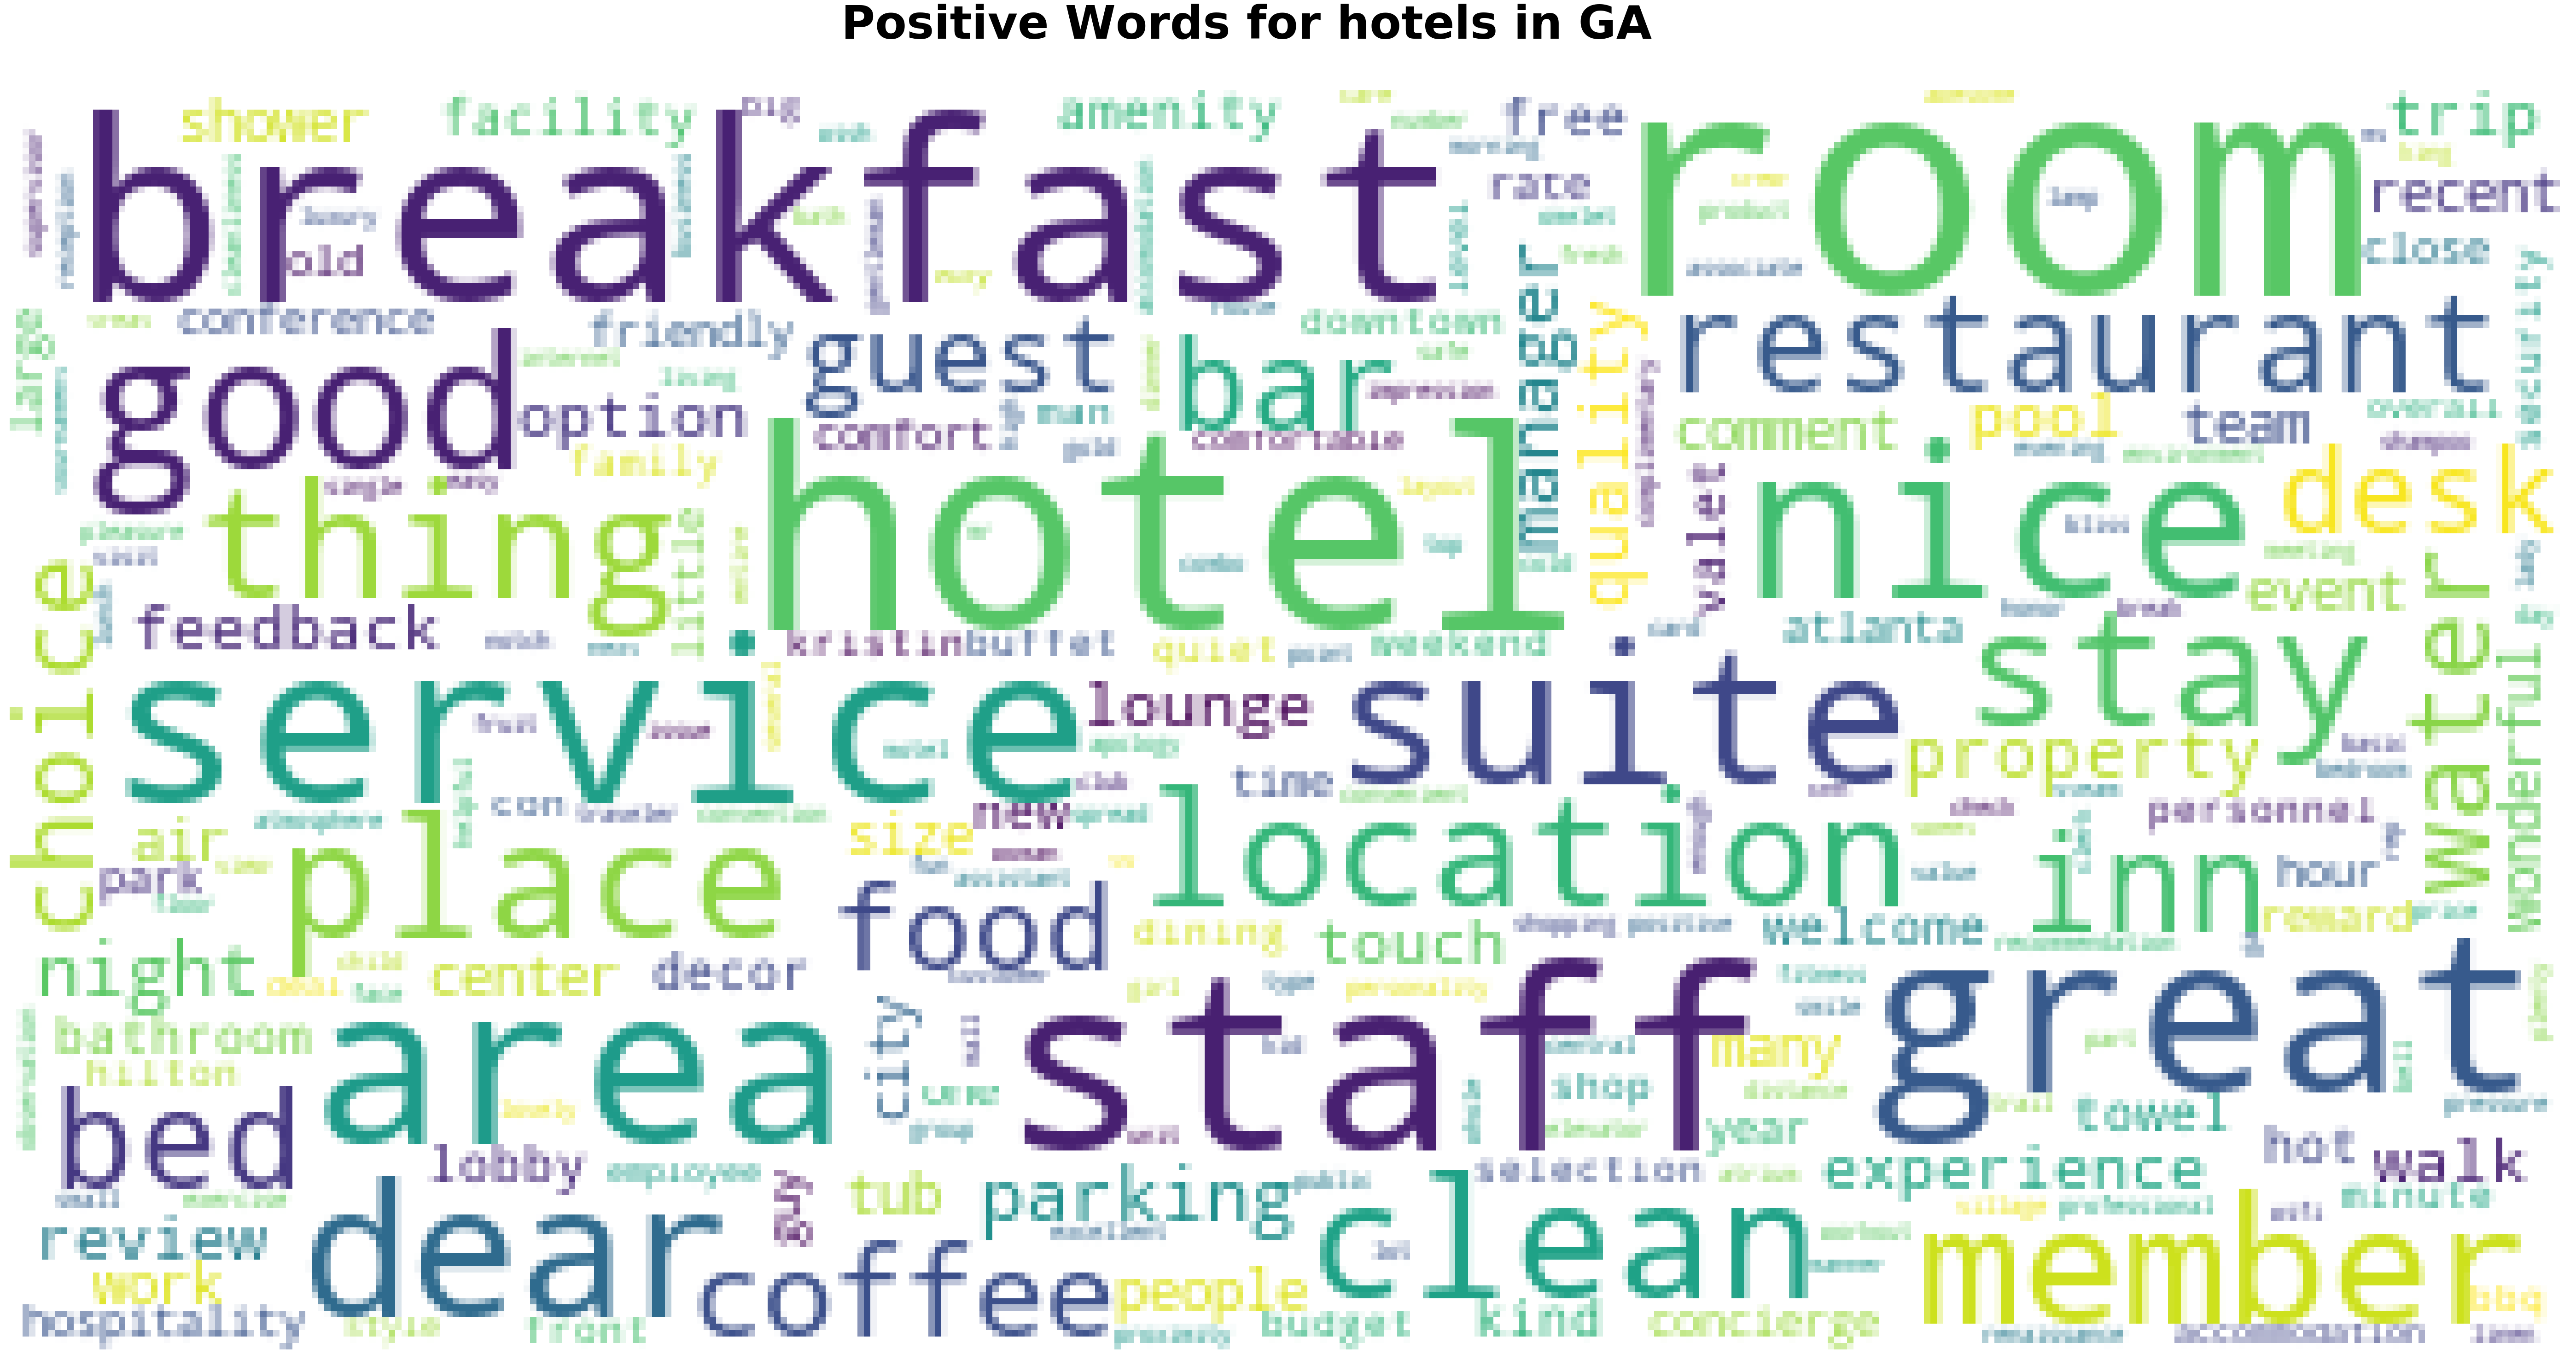

In [33]:
text_pos, text_neg = gen_text(GA_term_dict)
wc(text_pos,'white','Positive Words for hotels in GA' )

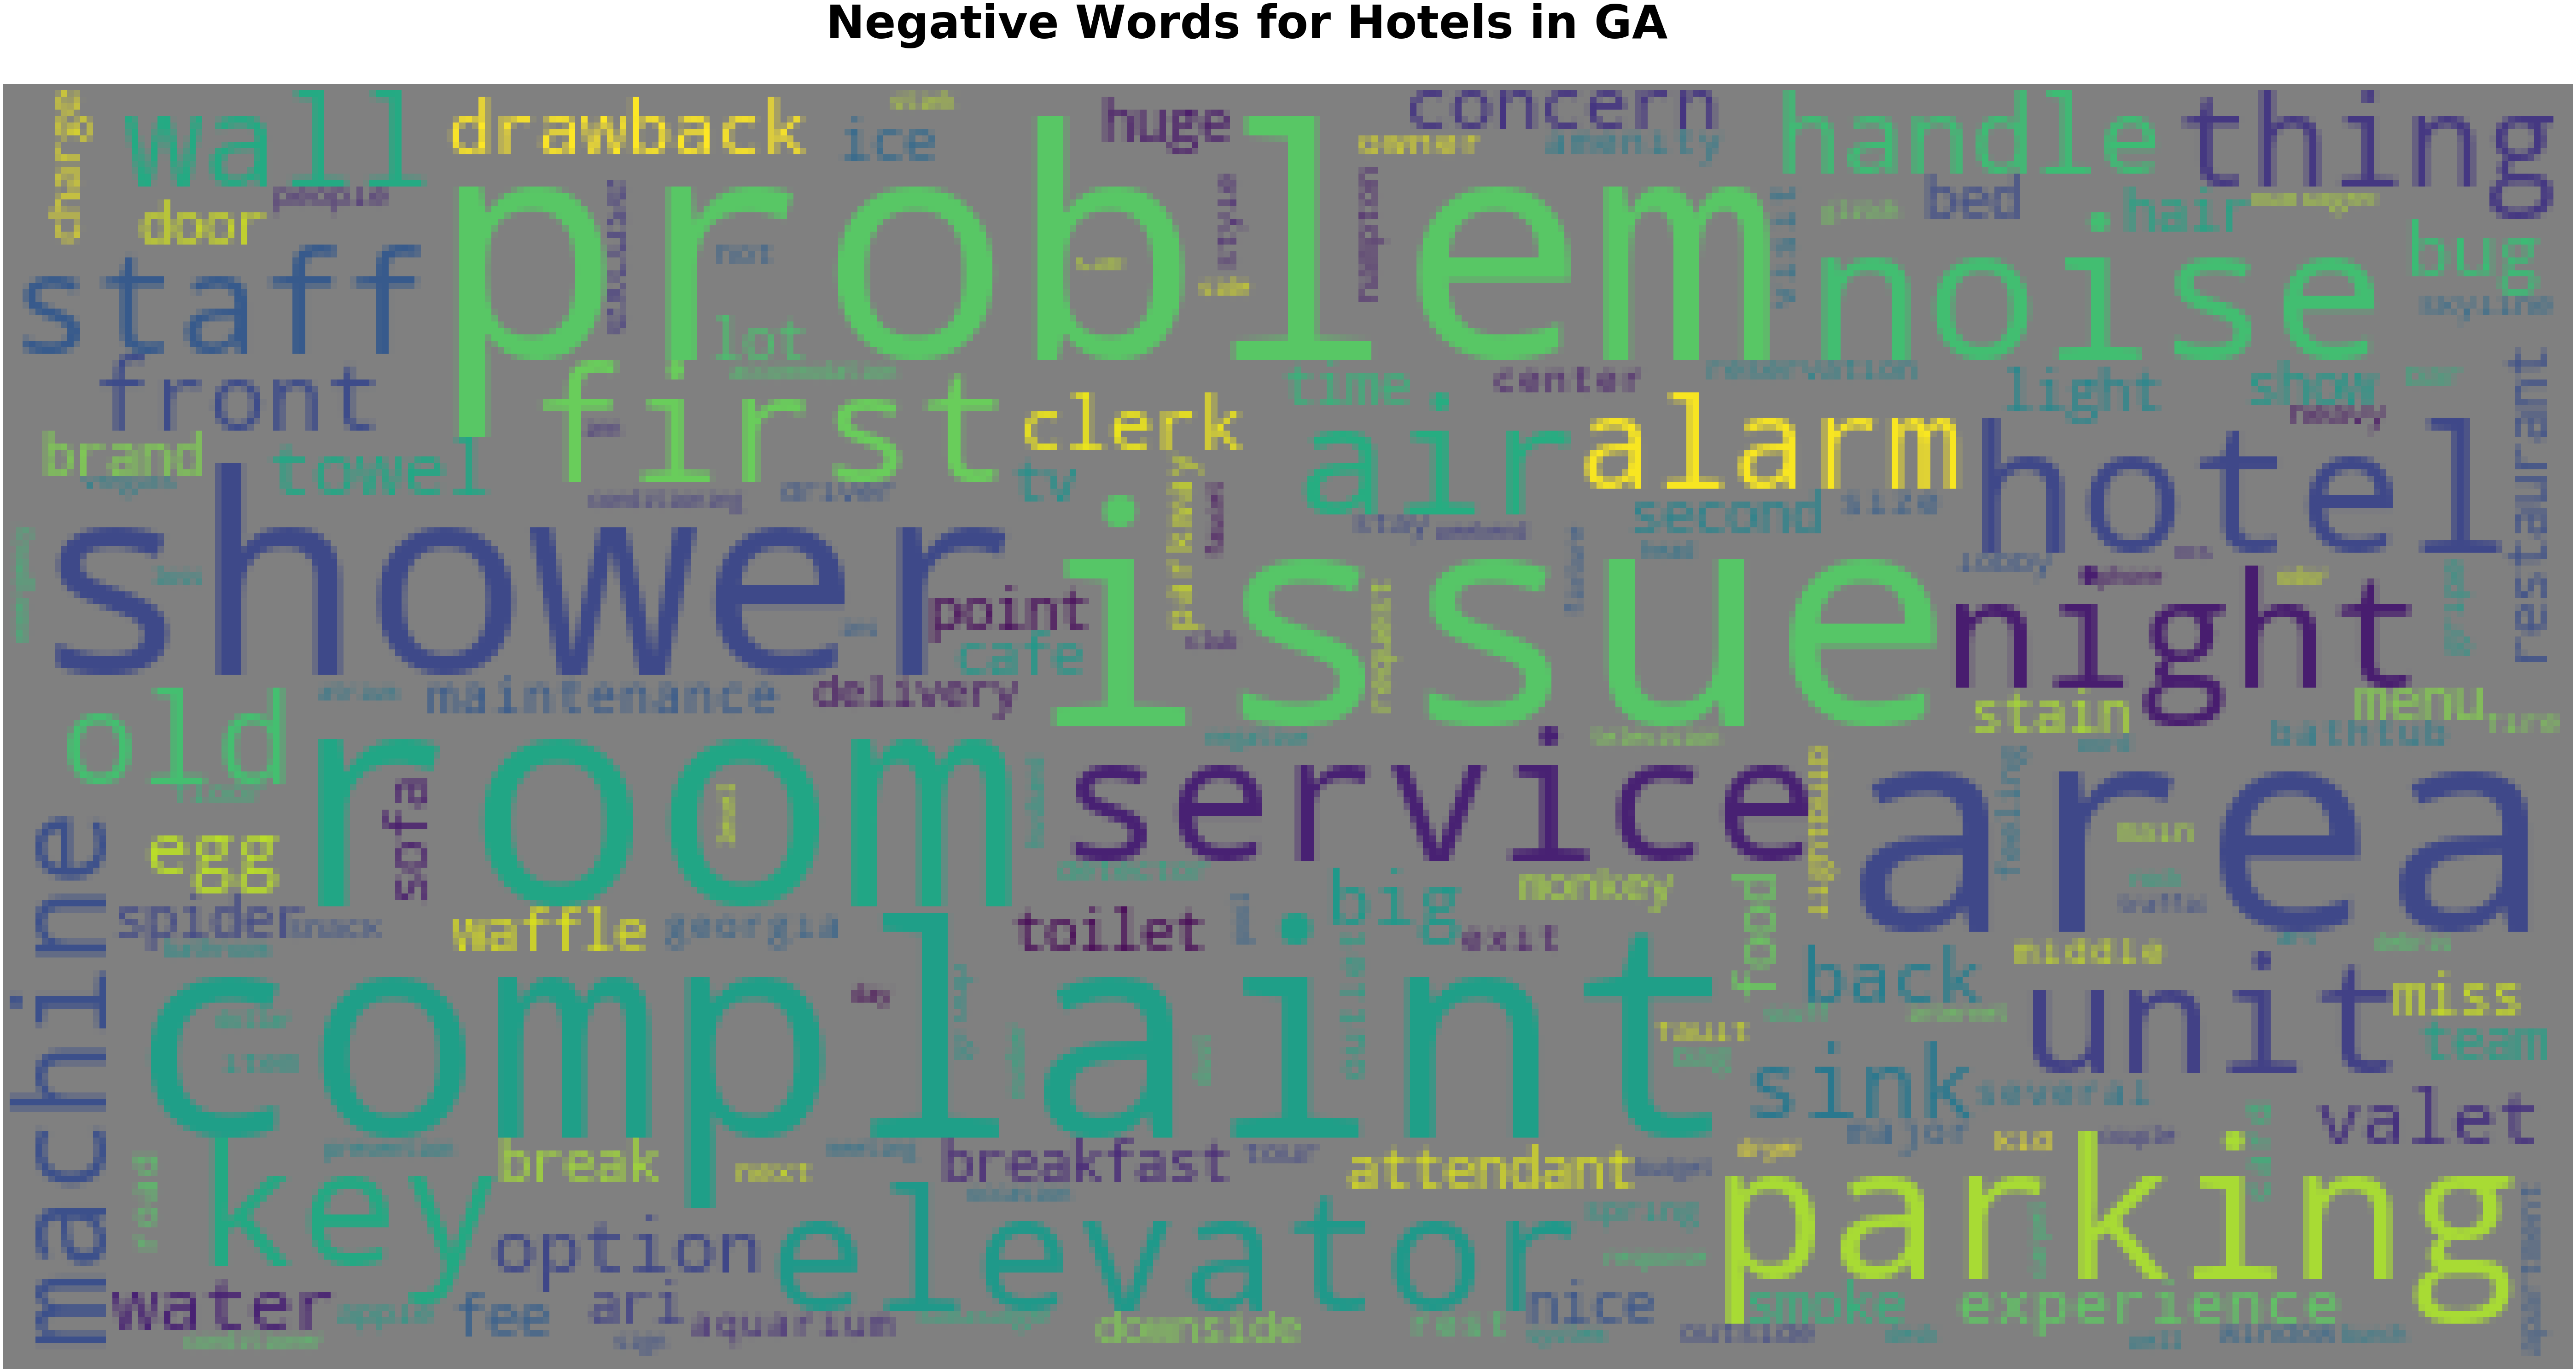

In [34]:
wc(text_neg,'grey','Negative Words for Hotels in GA' )

In [35]:
lowest = defaultdict()
highest = defaultdict()
for i in GA_term_dict:
    if GA_term_dict[i]:
        highest[i] = GA_term_dict[i].most_common()[:10]
        lowest[i] = GA_term_dict[i].most_common()[-10:]
highest_df = pd.DataFrame(highest)
lowest_df = pd.DataFrame(lowest)
lowest_df = lowest_df.drop(["OTHER"],1)
highest_df = highest_df.drop(["OTHER"],1)
highest_df

LOCATION             CHECKIN                         FOOD  \
0      (location, 170.0)    (feedback, 86.5)           (breakfast, 106.0)   
1          (place, 40.5)        (check, 9.0)                 (food, 33.0)   
2           (view, 24.0)        (valet, 8.0)                (water, 29.5)   
3           (area, 23.0)          (wi fi, 7)           (restaurant, 27.5)   
4             (size, 13)       (server, 6.5)              (bedding, 14.5)   
5       (facility, 12.5)        (atlanta, 6)               (people, 14.0)   
6   (neighborhood, 11.5)      (bellman, 5.5)                 (coffee, 13)   
7            (choice, 7)        (free fi, 5)       (breakfast buffet, 12)   
8  (walking distance, 7)         (wifi, 5.0)  (continental breakfast, 11)   
9             (visit, 7)  (hipster bbq, 4.5)          (free breakfast, 8)   

              BUILDING                   ROOMS               CLEANLINESS  \
0      (parking, 27.0)          (room, 428.75)           (amenity, 31.0)   
1     (property, 20.5)          (hotel, 289.5)             (quality, 13)   
2  (free parking, 8.0)            (bed, 133.5)          (cleanliness, 7)   
3          (part, 6.5)        (bathroom, 36.0)               (regard, 6)   
4          (city, 5.5)           (guest, 19.5)        (clean staff, 6.0)   
5           (lot, 4.5)      (clean room, 18.5)      (great amenity, 6.0)   
6       (working, 4.5)     (hotel staff, 17.5)    (attentive staff, 6.0)   
7          (ground, 4)           (lobby, 15.5)  (breakfast quality, 6.0)   
8     (entire team, 4)             (bar, 14.0)       (satisfaction, 5.5)   
9      (downtown, 3.0)  (guest experience, 14)              (pride, 4.5)   

                 VALUE                   SERVICE          BUSINESS  
0        (price, 31.5)            (staff, 401.0)       (job, 14.5)  
1        (value, 19.5)           (service, 86.0)  (business, 12.5)  
2    (expectation, 12)        (experience, 58.0)   (shopping, 7.5)  
3         (rate, 10.0)  (customer service, 30.0)      (company, 7)  
4  (reward member, 10)    (friendly staff, 23.5)       (family, 6)  
5         (loyalty, 8)        (desk staff, 16.0)  (environment, 5)  
6    (reward point, 6)           (comment, 15.5)   (employee, 4.5)  
7     (big bonus, 5.5)       (front staff, 15.0)  (good unit, 4.5)  
8          (option, 5)           (attention, 13)        (brand, 4)  
9       (add bonus, 5)              (access, 13)    (work desk, 4)

In [36]:
lowest_df

LOCATION                 CHECKIN                    FOOD  \
0             (worry, -1)            (button, -1)          (cold air, -1)   
1     (evening event, -2)              (knee, -1)  (waffle machine, -1.5)   
2     (movie channel, -2)           (schmuck, -1)    (waffle maker, -1.5)   
3  (distance amenity, -2)   (valet parking, -1.5)           (sausage, -2)   
4      (circumstance, -2)             (diane, -2)         (bad apple, -2)   
5   (major complaint, -2)             (tracy, -2)          (eat area, -2)   
6    (only complaint, -4)            (willie, -2)       (water stain, -2)   
7    (several outlet, -4)  (short circuiting, -2)      (great buffet, -2)   
8       (wall outlet, -4)   (fyi elevator, -2.25)           (blood, -3.5)   
9  (breakfast area, -5.0)             (guy, -2.5)    (only complaint, -4)   

                  BUILDING                  ROOMS               CLEANLINESS  \
0                (kid, -2)            (towel, -4)  (air conditioning, -1.5)   
1                (key, -2)           (camera, -4)           (nastiness, -2)   
2           (door gap, -2)   (only problem, -4.5)      (cleaning staff, -2)   
3        (smoke alarm, -2)     (sour towel, -4.5)           (stink bug, -2)   
4        (entire stay, -2)            (air, -5.0)               (stink, -2)   
5  (electrical hazard, -2)  (air conditioner, -5)   (noise disturbance, -2)   
6       (construction, -3)             (ac, -6.5)         (overflowing, -2)   
7      (outside noise, -3)   (only complaint, -7)              (lack, -3.5)   
8             (door, -3.5)         (toilet, -9.5)               (smell, -5)   
9             (wall, -4.5)         (carpet, -9.5)               (noise, -9)   

                   VALUE                 SERVICE                  BUSINESS  
0     (other glitch, -1)             (voice, -2)             (printer, -1)  
1         (strength, -1)   (service failure, -2)         (other brand, -1)  
2  (earn reputation, -1)     (huge drawback, -2)    (business meeting, -1)  
3    (overall level, -1)  (experience clerk, -2)  (conference planner, -1)  
4         (budget, -1.5)           (problem, -2)           (lot owner, -1)  
5          (shelf, -1.5)           (husband, -2)             (car ins, -1)  
6       (television, -2)             (issue, -3)         (large group, -1)  
7             (side, -2)           (billing, -3)         (credit card, -2)  
8       (downside, -2.5)            (prison, -3)              (shop, -3.0)  
9  (only downside, -4.5)             (reply, -4)        (management, -4.5)

## HI Hotel Review

In [37]:
aspect_sent, HI_term_dict = gen_dict("hotel_reviewHI.txt")
HI_df = gen_rate(aspect_sent)
HI_df

aspect      pos    neg  rate
0      LOCATION   397.25   31.5   4.7
1       CHECKIN   151.50    9.0   4.8
2          FOOD   152.50   35.5   4.2
3      BUILDING    92.50   30.5   4.0
4         ROOMS   710.25   94.0   4.5
5   CLEANLINESS    88.00    9.0   4.6
6         VALUE    99.00    1.0   5.0
7       SERVICE   559.00   30.5   4.8
8      BUSINESS    64.75    8.0   4.6
9         OTHER   352.50   24.5   4.7
10        TOTAL  2667.25  273.5   4.6

In [38]:
a_series = pd. Series(['HI'] + list(HI_df['rate']), index = total_df. columns)
total_df = total_df.append(a_series, ignore_index=True)

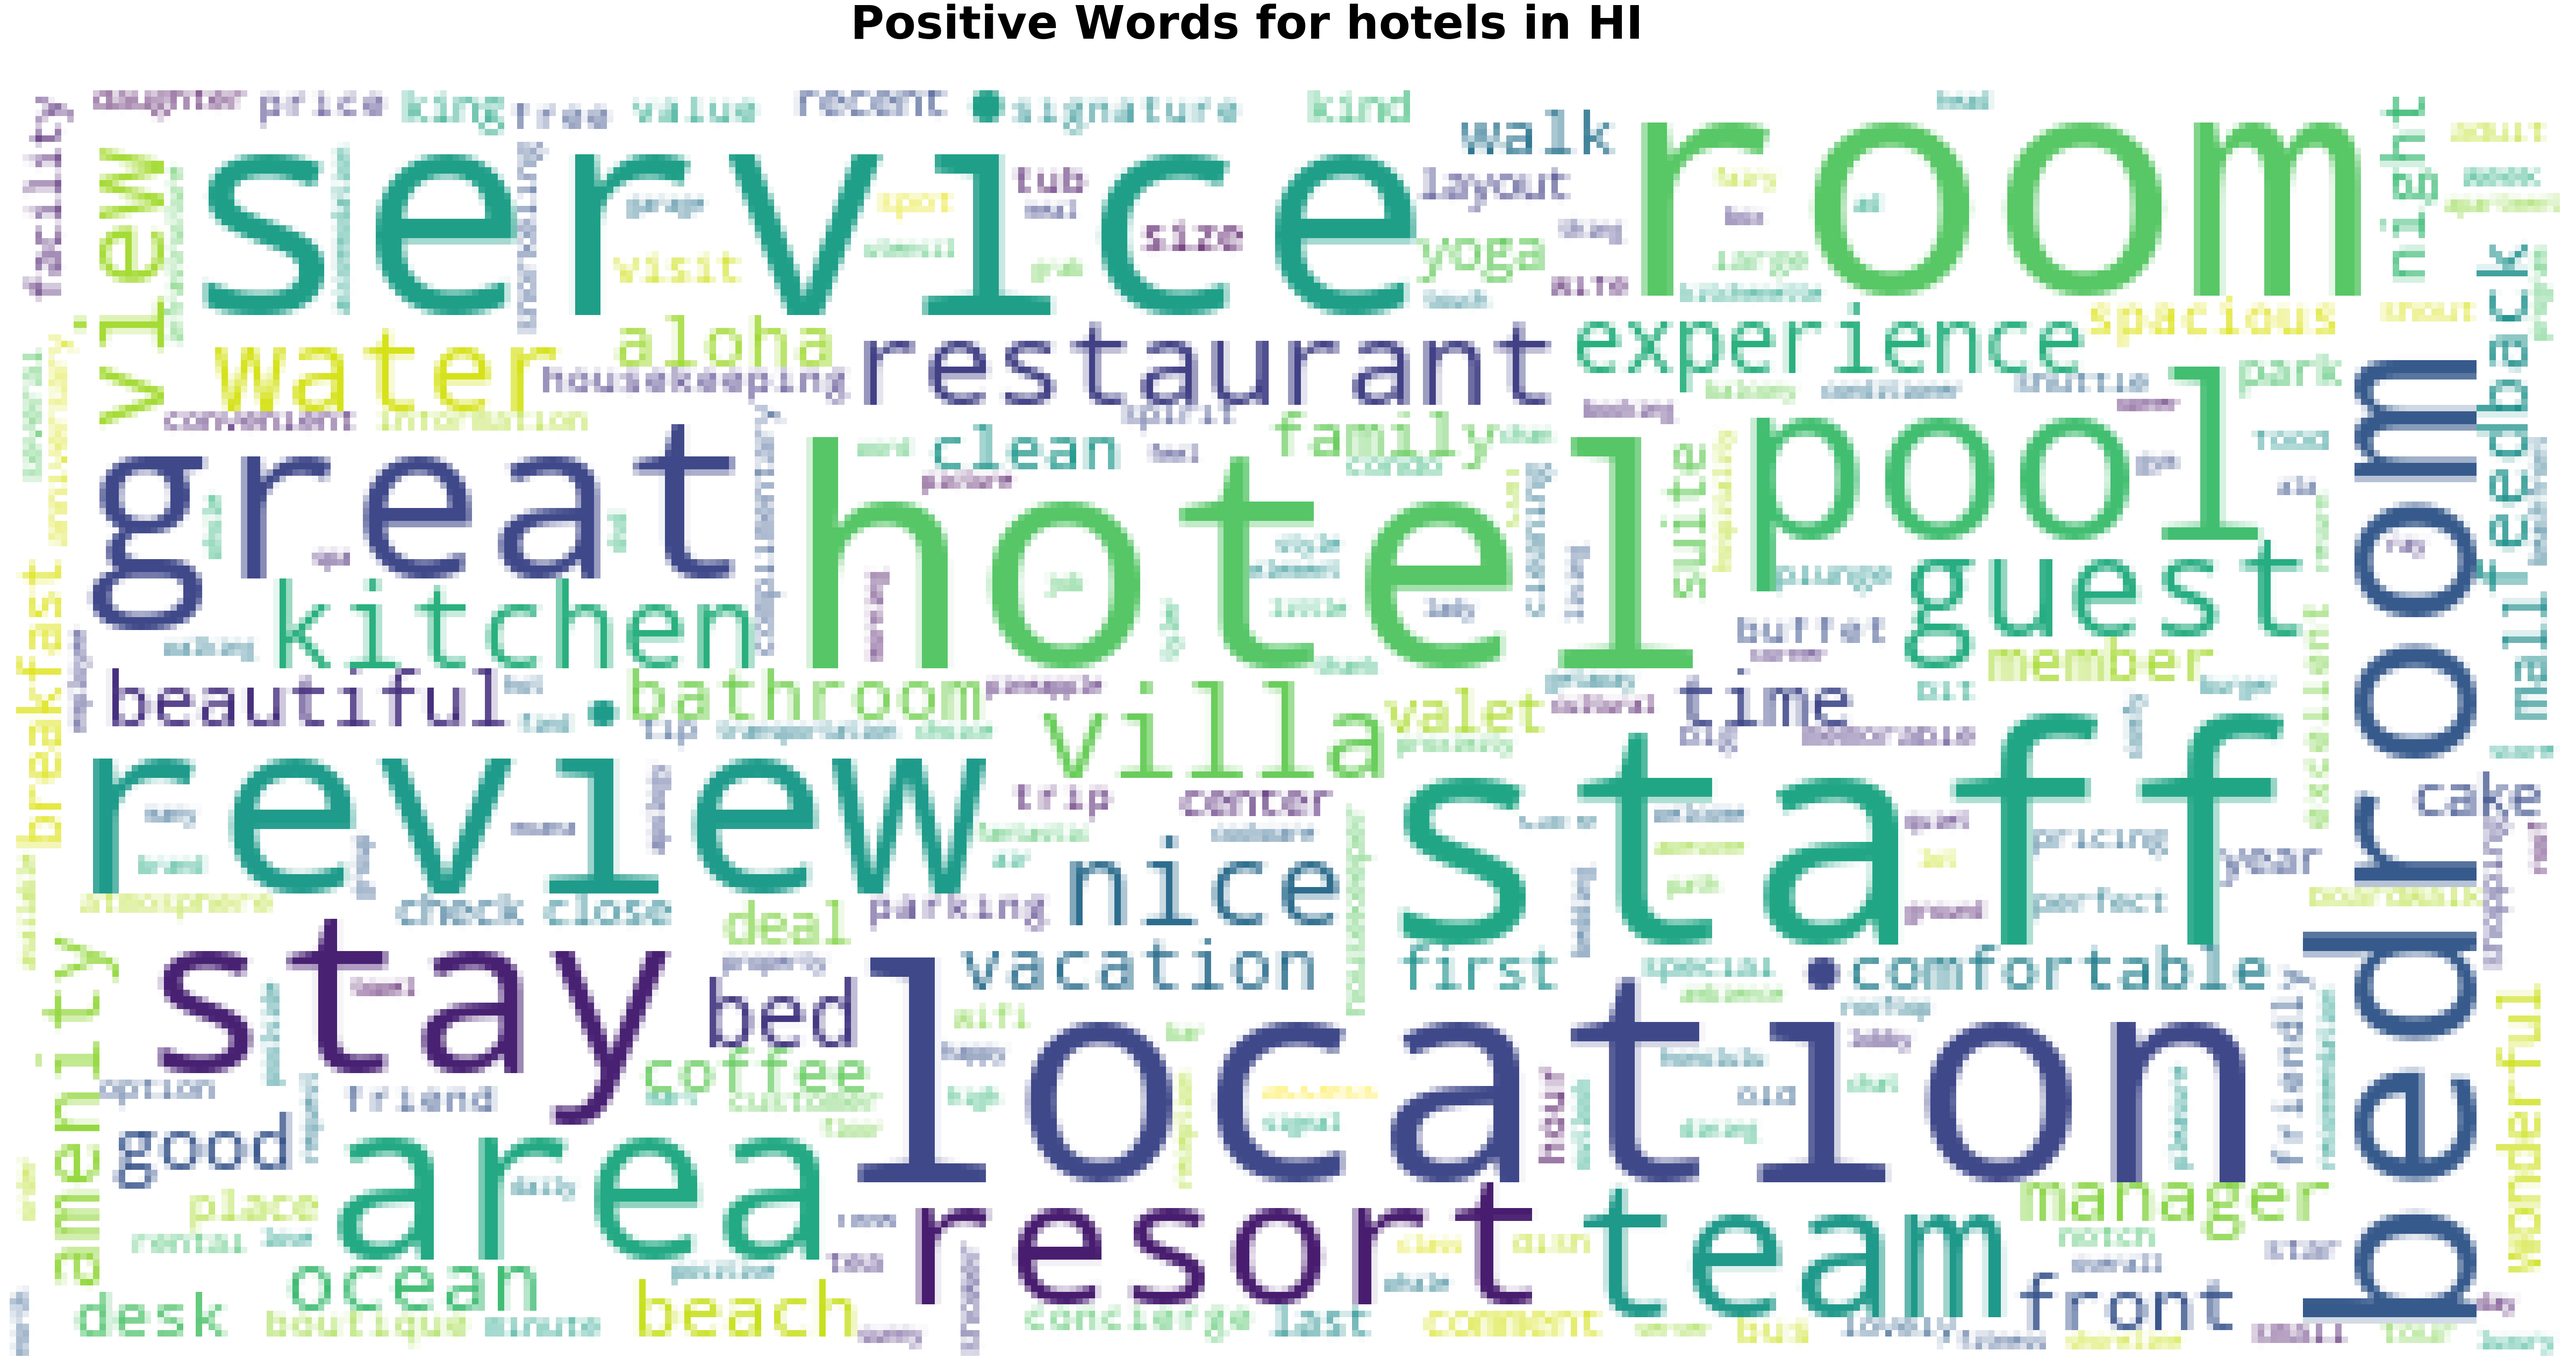

In [39]:
text_pos, text_neg = gen_text(HI_term_dict)
wc(text_pos,'white','Positive Words for hotels in HI' )

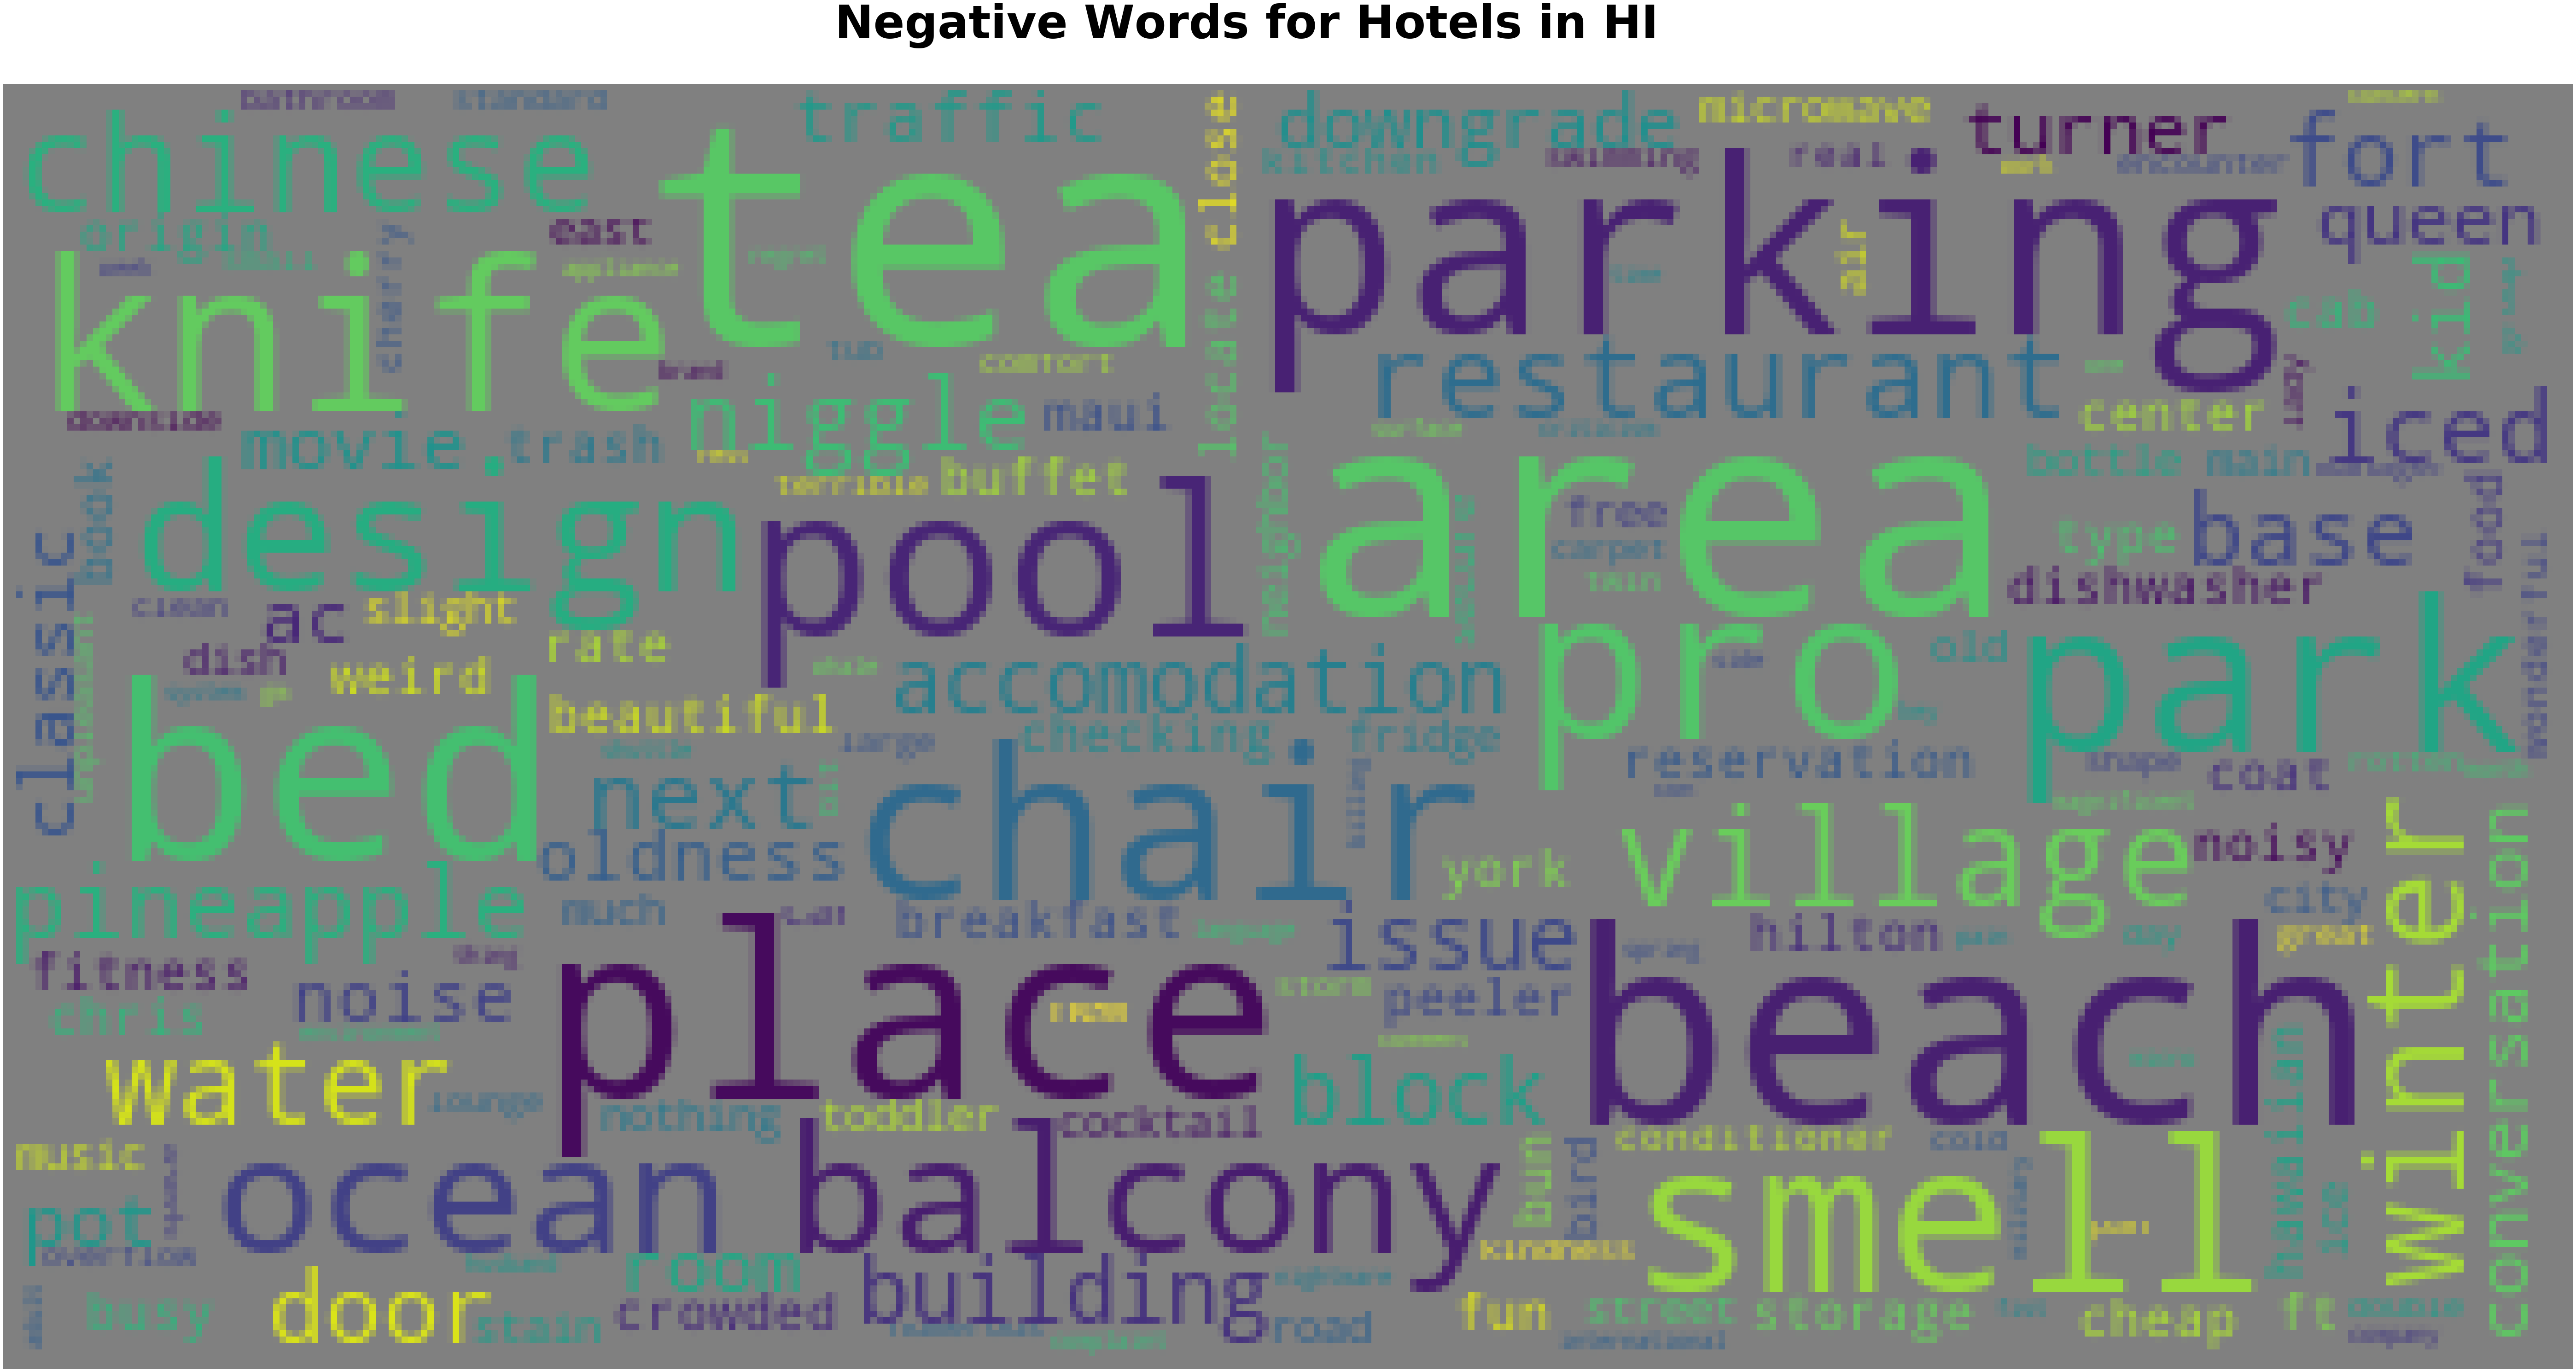

In [40]:
wc(text_neg,'grey','Negative Words for Hotels in HI' )

In [41]:
lowest = defaultdict()
highest = defaultdict()
for i in HI_term_dict:
    if HI_term_dict[i]:
        highest[i] = HI_term_dict[i].most_common()[:10]
        lowest[i] = HI_term_dict[i].most_common()[-10:]
highest_df = pd.DataFrame(highest)
lowest_df = pd.DataFrame(lowest)
lowest_df = lowest_df.drop(["OTHER"],1)
highest_df = highest_df.drop(["OTHER"],1)
highest_df

LOCATION           CHECKIN                   FOOD  \
0         (location, 106.0)  (feedback, 16.0)     (restaurant, 14.5)   
1              (view, 29.5)      (valet, 8.0)              (food, 9)   
2               (place, 22)          (dvd, 6)            (coffee, 7)   
3                (spot, 10)       (mahalo, 6)  (breakfast buffet, 7)   
4           (pool area, 10)         (wifi, 6)            (people, 3)   
5       (close location, 7)  (kind word, 5.5)             (drink, 3)   
6             (facility, 7)   (dvd rental, 5)       (breakfast, 2.5)   
7                (visit, 6)     (honolulu, 4)           (water, 2.5)   
8     (central location, 6)        (check, 3)      (atmosphere, 2.5)   
9  (convenient location, 5)  (wifi signal, 3)    (grill cheese, 2.5)   

              BUILDING                 ROOMS                 CLEANLINESS  \
0      (property, 9.5)         (room, 151.5)             (amenity, 17.5)   
1           (lot, 4.5)         (hotel, 77.0)  (housekeeping staff, 11.0)   
2            (part, 4)           (bed, 32.5)      (signature amenity, 7)   
3          (ground, 4)          (pool, 29.5)        (courteous staff, 6)   
4         (beach, 3.5)        (resort, 15.0)           (housekeeping, 6)   
5  (property staff, 3)      (bathroom, 10.0)            (clean staff, 4)   
6   (parking lot, 2.5)    (accommodation, 8)                (quality, 4)   
7       (setting, 2.5)  (spacious room, 7.0)                (fitness, 3)   
8          (home, 2.5)    (hotel staff, 6.5)          (affordability, 3)   
9           (floor, 2)              (gym, 6)           (overall stay, 3)   

                         VALUE                  SERVICE  \
0                (price, 22.0)          (staff, 210.75)   
1            (expectation, 18)          (service, 32.0)   
2                  (value, 14)   (friendly staff, 21.5)   
3                  (rate, 5.5)       (experience, 19.5)   
4  (introductory pricing, 2.5)  (reception staff, 13.5)   
5        (reasonable price, 2)    (helpful staff, 12.5)   
6           (reward member, 2)             (stay, 12.5)   
7              (good value, 2)         (reception, 9.5)   
8              (discount, 1.5)     (valet service, 9.0)   
9     (available pricing, 1.5)           (concierge, 7)   

                  BUSINESS  
0             (family, 11)  
1                 (job, 4)  
2         (employee, 3.75)  
3         (social hour, 3)  
4     (shopping center, 3)  
5            (activity, 3)  
6            (business, 3)  
7    (boutique style, 2.5)  
8  (staff management, 2.5)  
9                (plan, 2)

In [42]:
lowest_df

LOCATION                 CHECKIN                 FOOD  \
0      (crowded area, -1)             (cheryl, 1)       (cocktail, -1)   
1        (noisy area, -1)                (cab, 0)    (only niggle, -1)   
2    (fitness center, -1)              (chris, 0)  (slight niggle, -1)   
3             (ocean, -1)       (reservation, -1)           (dish, -1)   
4  (beautiful park, -1.5)    (hilton village, -1)        (nothing, -1)   
5    (locate balcony, -2)  (hawaiian village, -1)           (bird, -1)   
6         (fun place, -2)       (york winter, -1)     (close food, -2)   
7         (busy area, -2)          (checking, -1)      (microwave, -2)   
8             (knife, -2)         (trash can, -1)          (music, -2)   
9            (peeler, -3)         (maui coat, -1)         (fridge, -3)   

               BUILDING                    ROOMS               CLEANLINESS  \
0  (toddler design, -1)      (numerous pool, -1)           (beach walk, 1)   
1            (city, -1)            (cold ac, -1)           (clean lady, 0)   
2            (door, -1)  (air conditioner, -1.5)        (beach manager, 0)   
3     (knife block, -1)        (queen bed, -1.5)        (rotten smell, -1)   
4        (neighbor, -1)     (lounge chair, -1.5)      (terrible smell, -1)   
5    (east balcony, -2)     (turner classic, -2)             (oldness, -1)   
6           (block, -2)      (movie classic, -2)            (kindness, -1)   
7  (secure parking, -2)             (turner, -2)               (noise, -1)   
8  (old building, -2.5)              (movie, -2)  (unpleasant oldness, -2)   
9        (building, -3)                 (ac, -2)               (smell, -2)   

                   VALUE                SERVICE                   BUSINESS  
0              (self, 1)    (military base, -1)            (rental car, 1)  
1             (faith, 1)     (conversation, -1)        (family picture, 1)  
2  (cultural element, 1)              (key, -1)             (desk team, 1)  
3        (snorkeling, 1)           (system, -1)       (family vacation, 1)  
4             (front, 1)             (week, -1)           (loyal owner, 1)  
5           (balance, 1)            (adult, -1)      (shuttle company, -1)  
6      (photographer, 1)          (billing, -1)          (environment, -1)  
7            (option, 1)         (language, -2)            (appliance, -1)  
8             (other, 1)             (pain, -2)  (international brand, -1)  
9    (only downside, -1)  (traffic noise, -5.5)                (micro, -2)

## IL Hotel Review

In [43]:
aspect_sent, IL_term_dict = gen_dict("hotel_reviewIL.txt")
IL_df = gen_rate(aspect_sent)
IL_df

aspect      pos     neg  rate
0      LOCATION   657.00   53.50   4.7
1       CHECKIN   345.00   37.50   4.6
2          FOOD   554.75   89.00   4.4
3      BUILDING   215.50   51.00   4.2
4         ROOMS  1525.25  310.75   4.3
5   CLEANLINESS   171.00   37.50   4.3
6         VALUE   137.50   31.00   4.3
7       SERVICE   847.25  104.50   4.6
8      BUSINESS   116.50   13.00   4.6
9         OTHER   450.50   59.50   4.5
10        TOTAL  5020.25  787.25   4.5

In [44]:
a_series = pd. Series(['IL'] + list(IL_df['rate']), index = total_df. columns)
total_df = total_df.append(a_series, ignore_index=True)

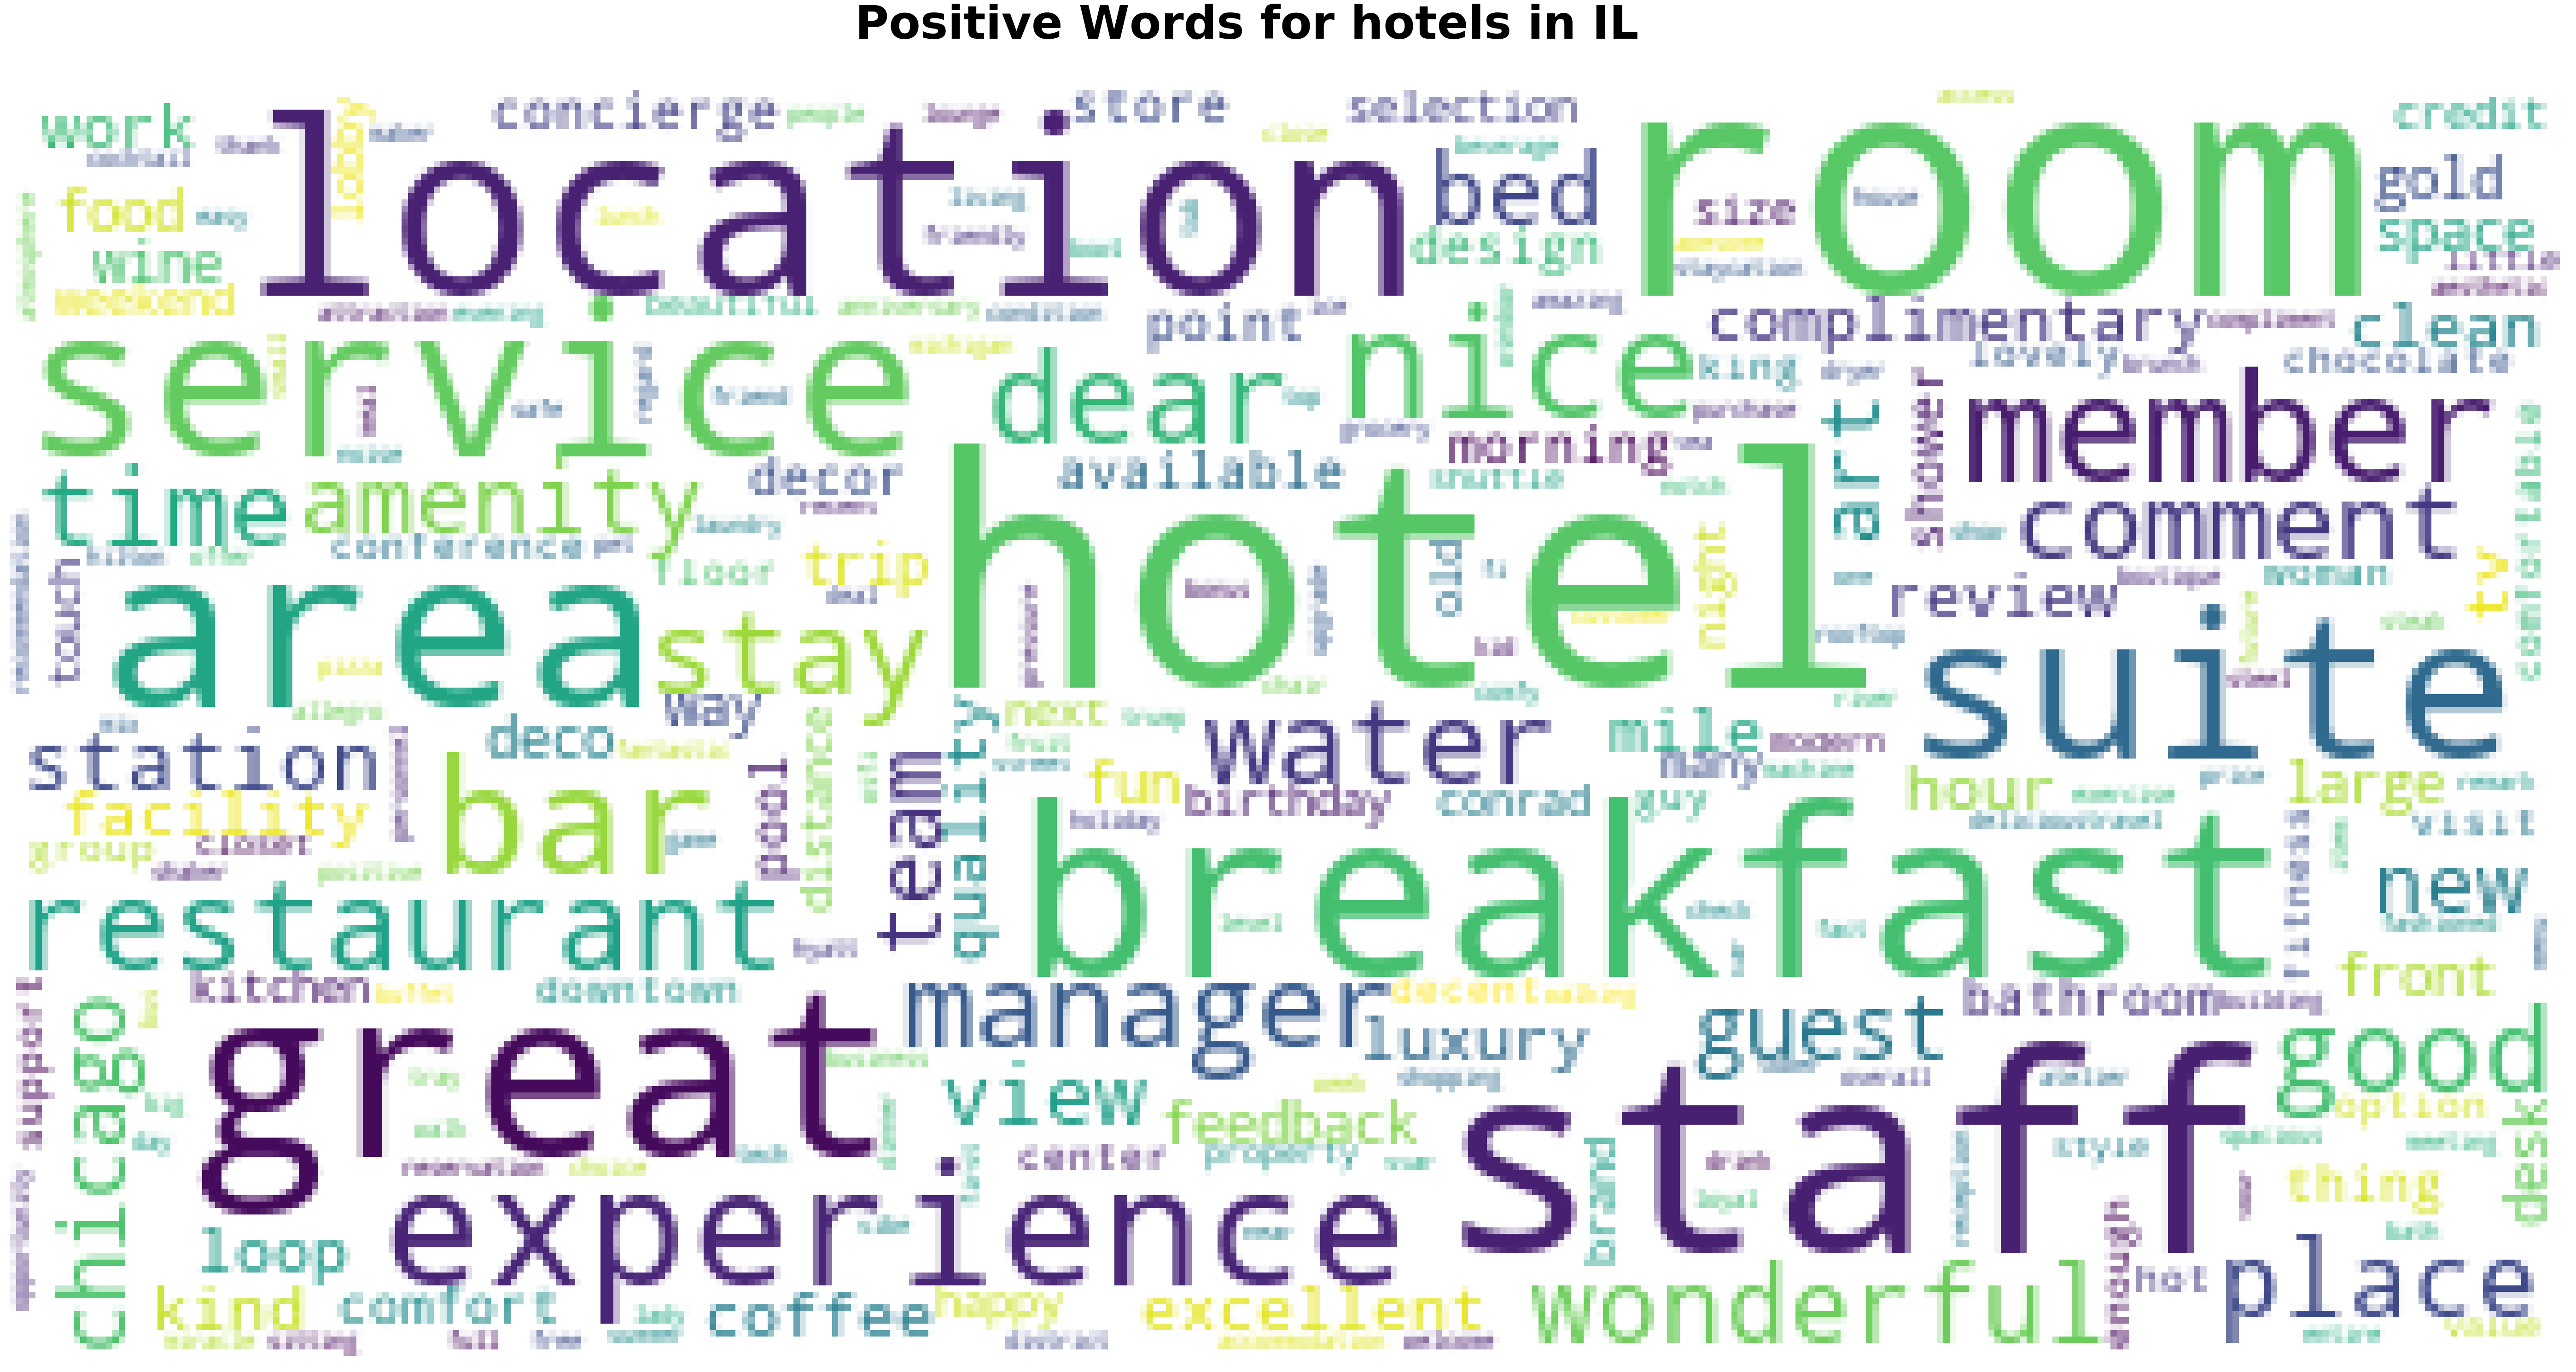

In [45]:
text_pos, text_neg = gen_text(IL_term_dict)
wc(text_pos,'white','Positive Words for hotels in IL' )

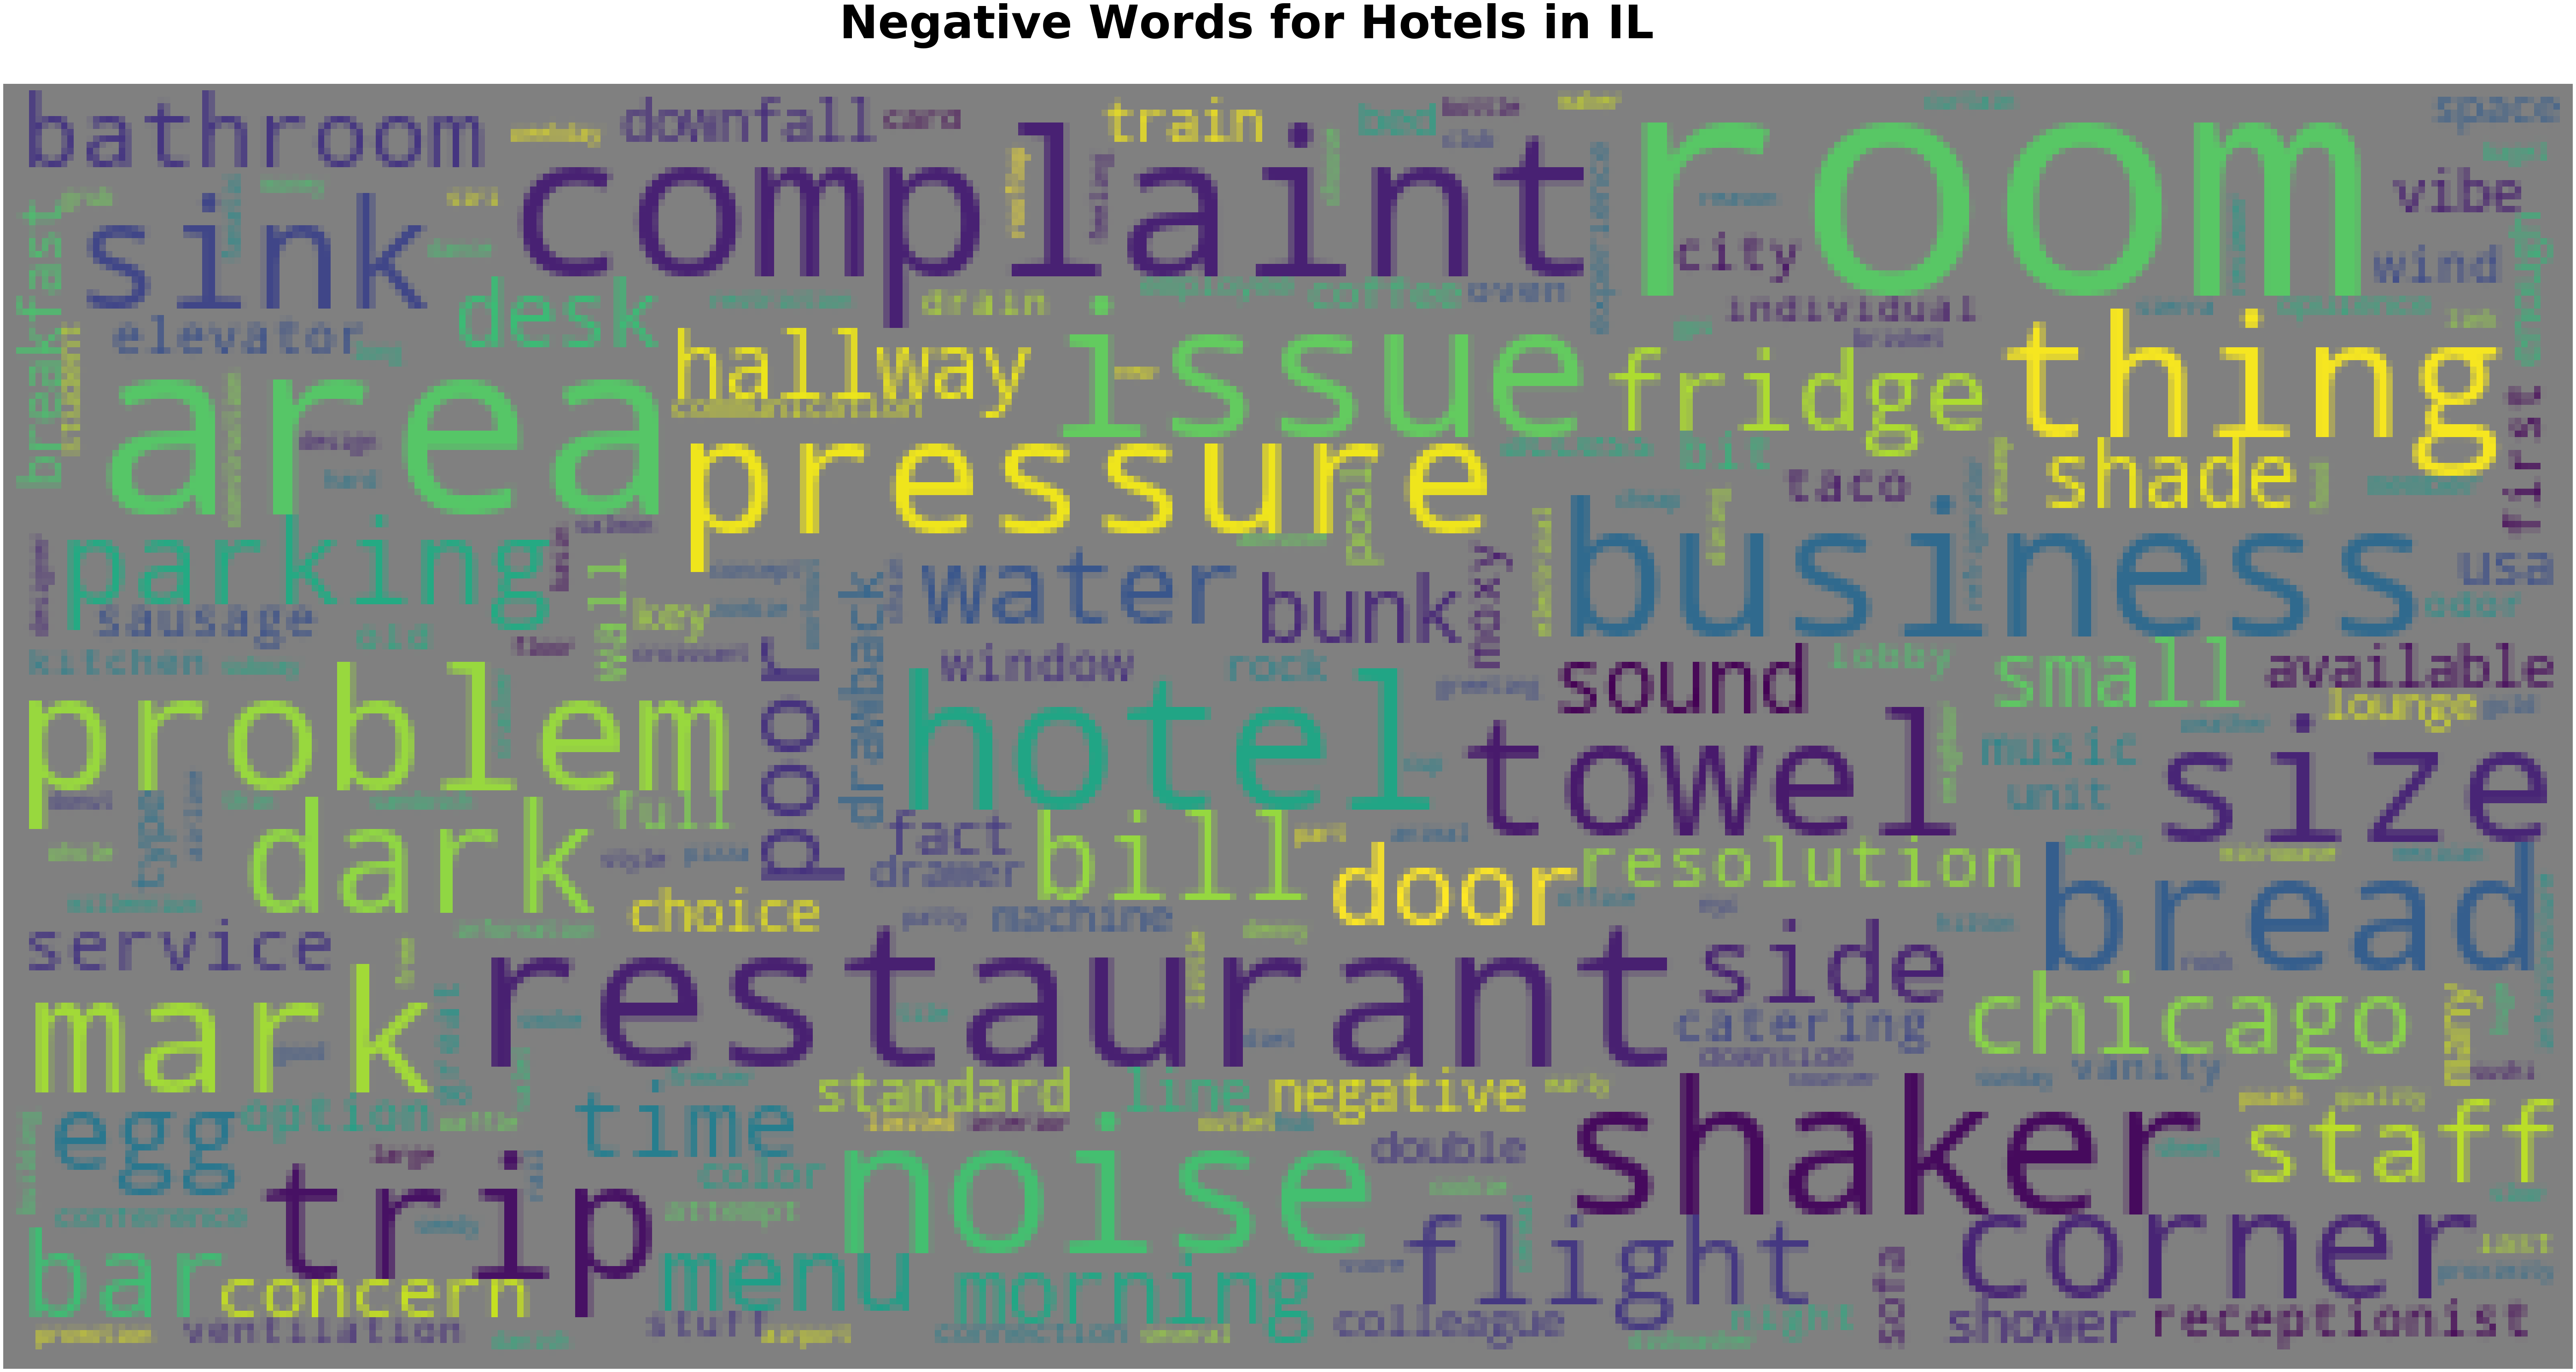

In [46]:
wc(text_neg,'grey','Negative Words for Hotels in IL' )

In [47]:
lowest = defaultdict()
highest = defaultdict()
for i in IL_term_dict:
    if IL_term_dict[i]:
        highest[i] = IL_term_dict[i].most_common()[:10]
        lowest[i] = IL_term_dict[i].most_common()[-10:]
highest_df = pd.DataFrame(highest)
lowest_df = pd.DataFrame(lowest)
lowest_df = lowest_df.drop(["OTHER"],1)
highest_df = highest_df.drop(["OTHER"],1)
highest_df

LOCATION                CHECKIN                        FOOD  \
0       (location, 168.5)          (wifi, 15.75)           (breakfast, 68.0)   
1            (view, 50.5)         (feedback, 15)                (food, 43.0)   
2           (place, 32.0)         (conrad, 11.5)          (restaurant, 38.5)   
3              (mile, 20)           (wi fi, 8.5)    (breakfast buffet, 18.5)   
4             (visit, 14)           (chicago, 7)                (coffee, 11)   
5  (walking distance, 12)           (check, 6.0)     (great restaurant, 7.5)   
6              (size, 10)           (kelly, 6.0)                 (people, 7)   
7     (great location, 9)         (free fi, 5.5)  (continental breakfast, 7)   
8  (downtown location, 7)  (robert manager, 5.5)           (coffee maker, 7)   
9             (area, 6.5)             (frill, 5)           (atmosphere, 6.5)   

           BUILDING                ROOMS             CLEANLINESS  \
0  (property, 26.5)        (room, 331.0)         (amenity, 22.5)   
1        (city, 12)       (hotel, 176.0)            (regard, 16)   
2   (downtown, 7.5)          (bed, 65.0)          (quality, 9.5)   
3        (floor, 6)       (suite, 22.25)        (cleanliness, 7)   
4      (rooftop, 6)  (hotel staff, 21.0)      (clean staff, 6.0)   
5  (trump tower, 5)   (clean room, 18.0)            (fitness, 6)   
6      (upgrade, 5)  (comfort suite, 18)       (housekeeping, 5)   
7       (ground, 5)  (tod chamber, 18.0)            (regards, 5)   
8  (rooftop bar, 5)        (guest, 15.5)  (courteous staff, 4.0)   
9     (roof bar, 5)   (front desk, 13.0)             (warmth, 4)   

                       VALUE                 SERVICE                BUSINESS  
0              (value, 19.5)         (staff, 282.25)        (shopping, 11.5)  
1              (price, 18.0)         (service, 72.5)        (employee, 11.0)  
2                (rate, 9.0)      (experience, 42.0)              (job, 9.5)  
3              (option, 7.5)            (travel, 24)           (customer, 5)  
4           (expectation, 5)      (desk staff, 16.0)           (family, 4.0)  
5                (cost, 4.5)  (customer service, 14)  (online reputation, 4)  
6                 (bonus, 4)     (front staff, 13.5)    (general manager, 3)  
7           (opportunity, 4)            (team, 11.0)       (kind manager, 3)  
8               (offer, 3.5)    (staff member, 10.5)             (future, 2)  
9  (overall experience, 3.0)          (access, 10.5)  (overall operation, 2)

In [48]:
lowest_df

LOCATION                CHECKIN                        FOOD  \
0   (only downfall, -1)          (problem, -1)  (catering restriction, -2)   
1          (shaker, -1)              (nyc, -1)                 (money, -2)   
2  (limited choice, -1)  (chicago parking, -1)              (taco bar, -2)   
3  (breakfast area, -1)     (chicago wind, -1)         (quality bread, -2)   
4     (choice line, -1)           (danish, -1)        (sandwich bread, -2)   
5      (large area, -1)        (promotion, -1)    (rooftop restaurant, -2)   
6  (counter area, -1.5)         (greeting, -1)      (sushi restaurant, -2)   
7      (basin area, -2)             (siri, -2)                (salmon, -2)   
8       (huge area, -2)              (gps, -2)      (water pressure, -2.5)   
9       (sink area, -4)        (airport, -2.5)          (refrigerator, -4)   

                  BUILDING                       ROOMS  \
0         (door towel, -1)            (desk clerk, -2)   
1  (fanatic colleague, -1)        (breakfast room, -2)   
2           (window, -1.5)         (kitchen staff, -2)   
3    (slow elevator, -1.5)           (closet door, -2)   
4         (neighbor, -1.5)        (enough space, -2.5)   
5      (first floor, -1.5)          (shower drain, -3)   
6          (new maker, -2)              (bunk bed, -3)   
7        (thin wall, -2.5)               (sheet, -4.0)   
8       (city noise, -2.5)          (hang space, -4.5)   
9         (elevator, -9.5)  (window ventilation, -5.5)   

                CLEANLINESS                        VALUE  \
0             (culture, -1)              (down side, -1)   
1              (health, -1)                   (hand, -1)   
2  (daily housekeeping, -1)                   (quad, -1)   
3            (aircon, -1.5)              (dimension, -1)   
4        (noise factor, -2)            (damage mark, -1)   
5       (such attitude, -2)              (complaint, -1)   
6       (night noise, -2.5)               (key card, -2)   
7              (lack, -2.5)               (number, -2.5)   
8               (noise, -3)  (irritating downside, -2.5)   
9  (poor ventilation, -4.5)        (only downside, -3.5)   

                SERVICE                   BUSINESS  
0            (time, -2)               (company, 1)  
1  (service coffee, -2)  (hospitality industry, 0)  
2             (van, -2)   (business conference, 0)  
3    (travel agent, -2)         (business trip, 0)  
4              (ac, -2)      (front employee, 0.0)  
5         (manager, -3)       (desk employee, 0.0)  
6  (multiple delay, -3)  (business traveler, -0.5)  
7          (desert, -3)           (small type, -1)  
8    (cancellation, -4)        (business card, -1)  
9  (interruption, -5.5)           (business, -3.5)

## LA Hotel Review

In [95]:
aspect_sent, LA_term_dict = gen_dict("hotel_reviewLA.txt")
LA_df = gen_rate(aspect_sent)
LA_df

aspect      pos      neg  rate
0      LOCATION  1103.00    99.50   4.7
1       CHECKIN   615.75    77.50   4.6
2          FOOD  1140.50   177.75   4.5
3      BUILDING   408.25   135.00   4.0
4         ROOMS  2545.25   501.50   4.3
5   CLEANLINESS   203.00    91.00   3.8
6         VALUE   284.50    38.50   4.5
7       SERVICE  1488.75   129.50   4.7
8      BUSINESS   170.50    25.00   4.5
9         OTHER   678.00   110.50   4.4
10        TOTAL  8637.50  1385.75   4.4

In [96]:
a_series = pd. Series(['LA'] + list(LA_df['rate']), index = total_df. columns)
total_df = total_df.append(a_series, ignore_index=True)

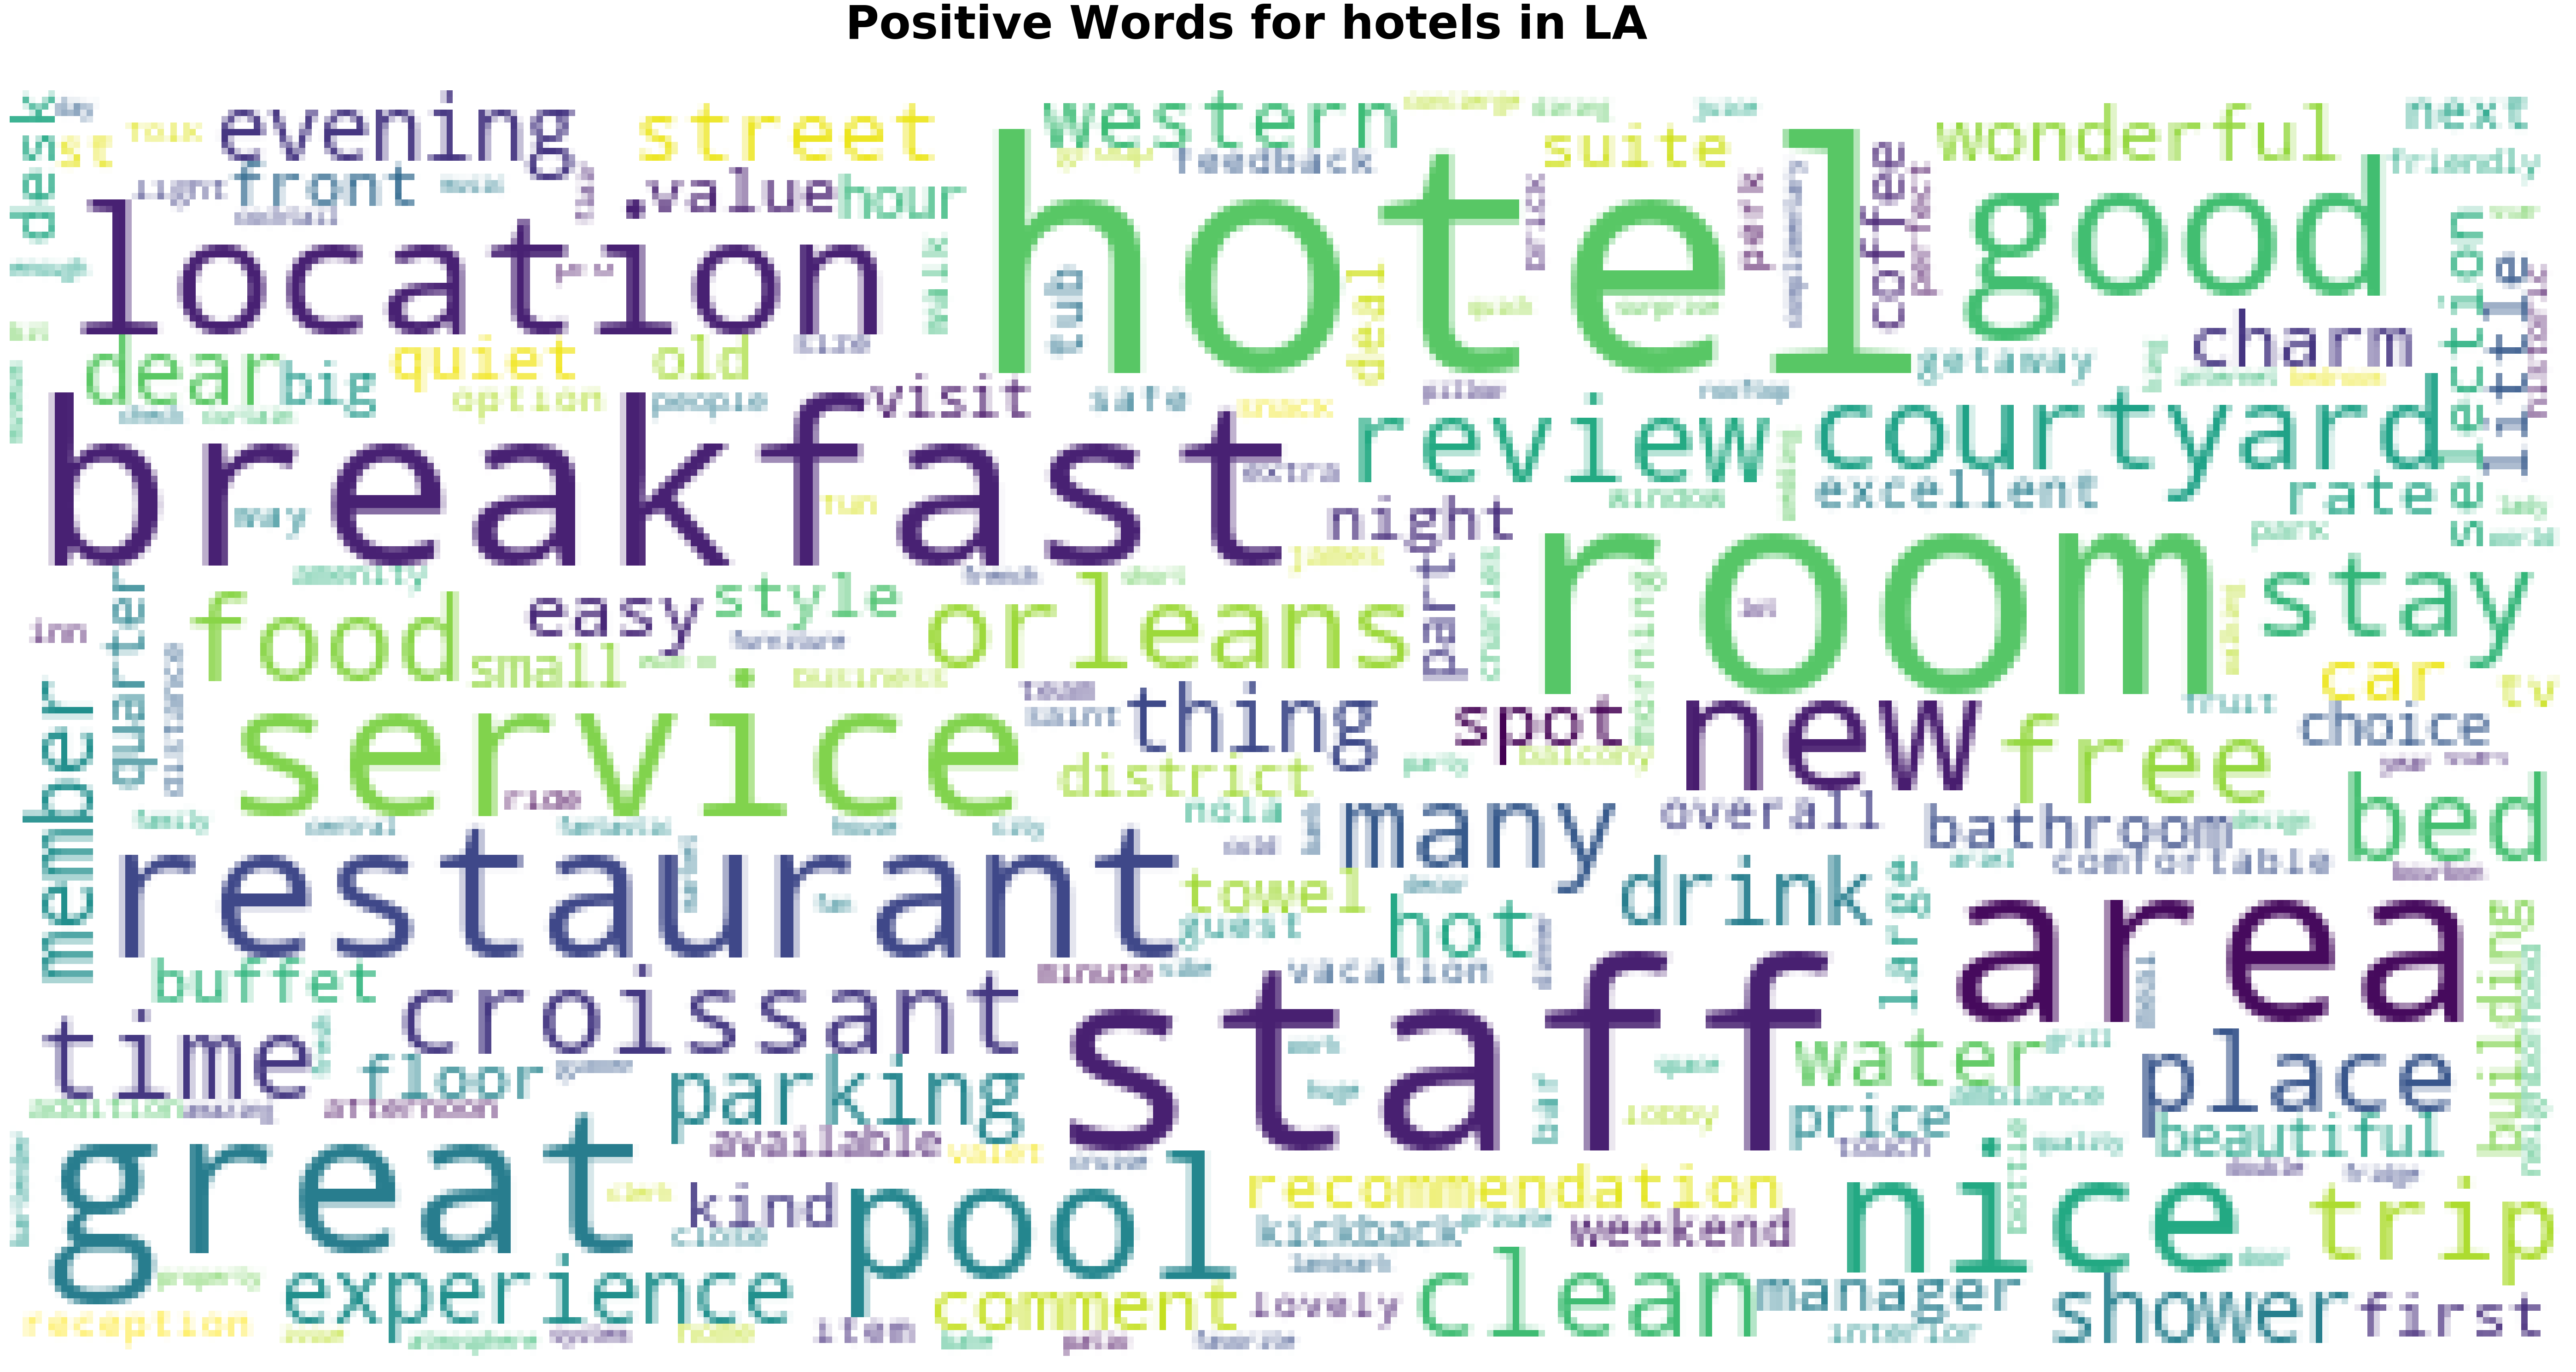

In [97]:
text_pos, text_neg = gen_text(LA_term_dict)
wc(text_pos,'white','Positive Words for hotels in LA' )

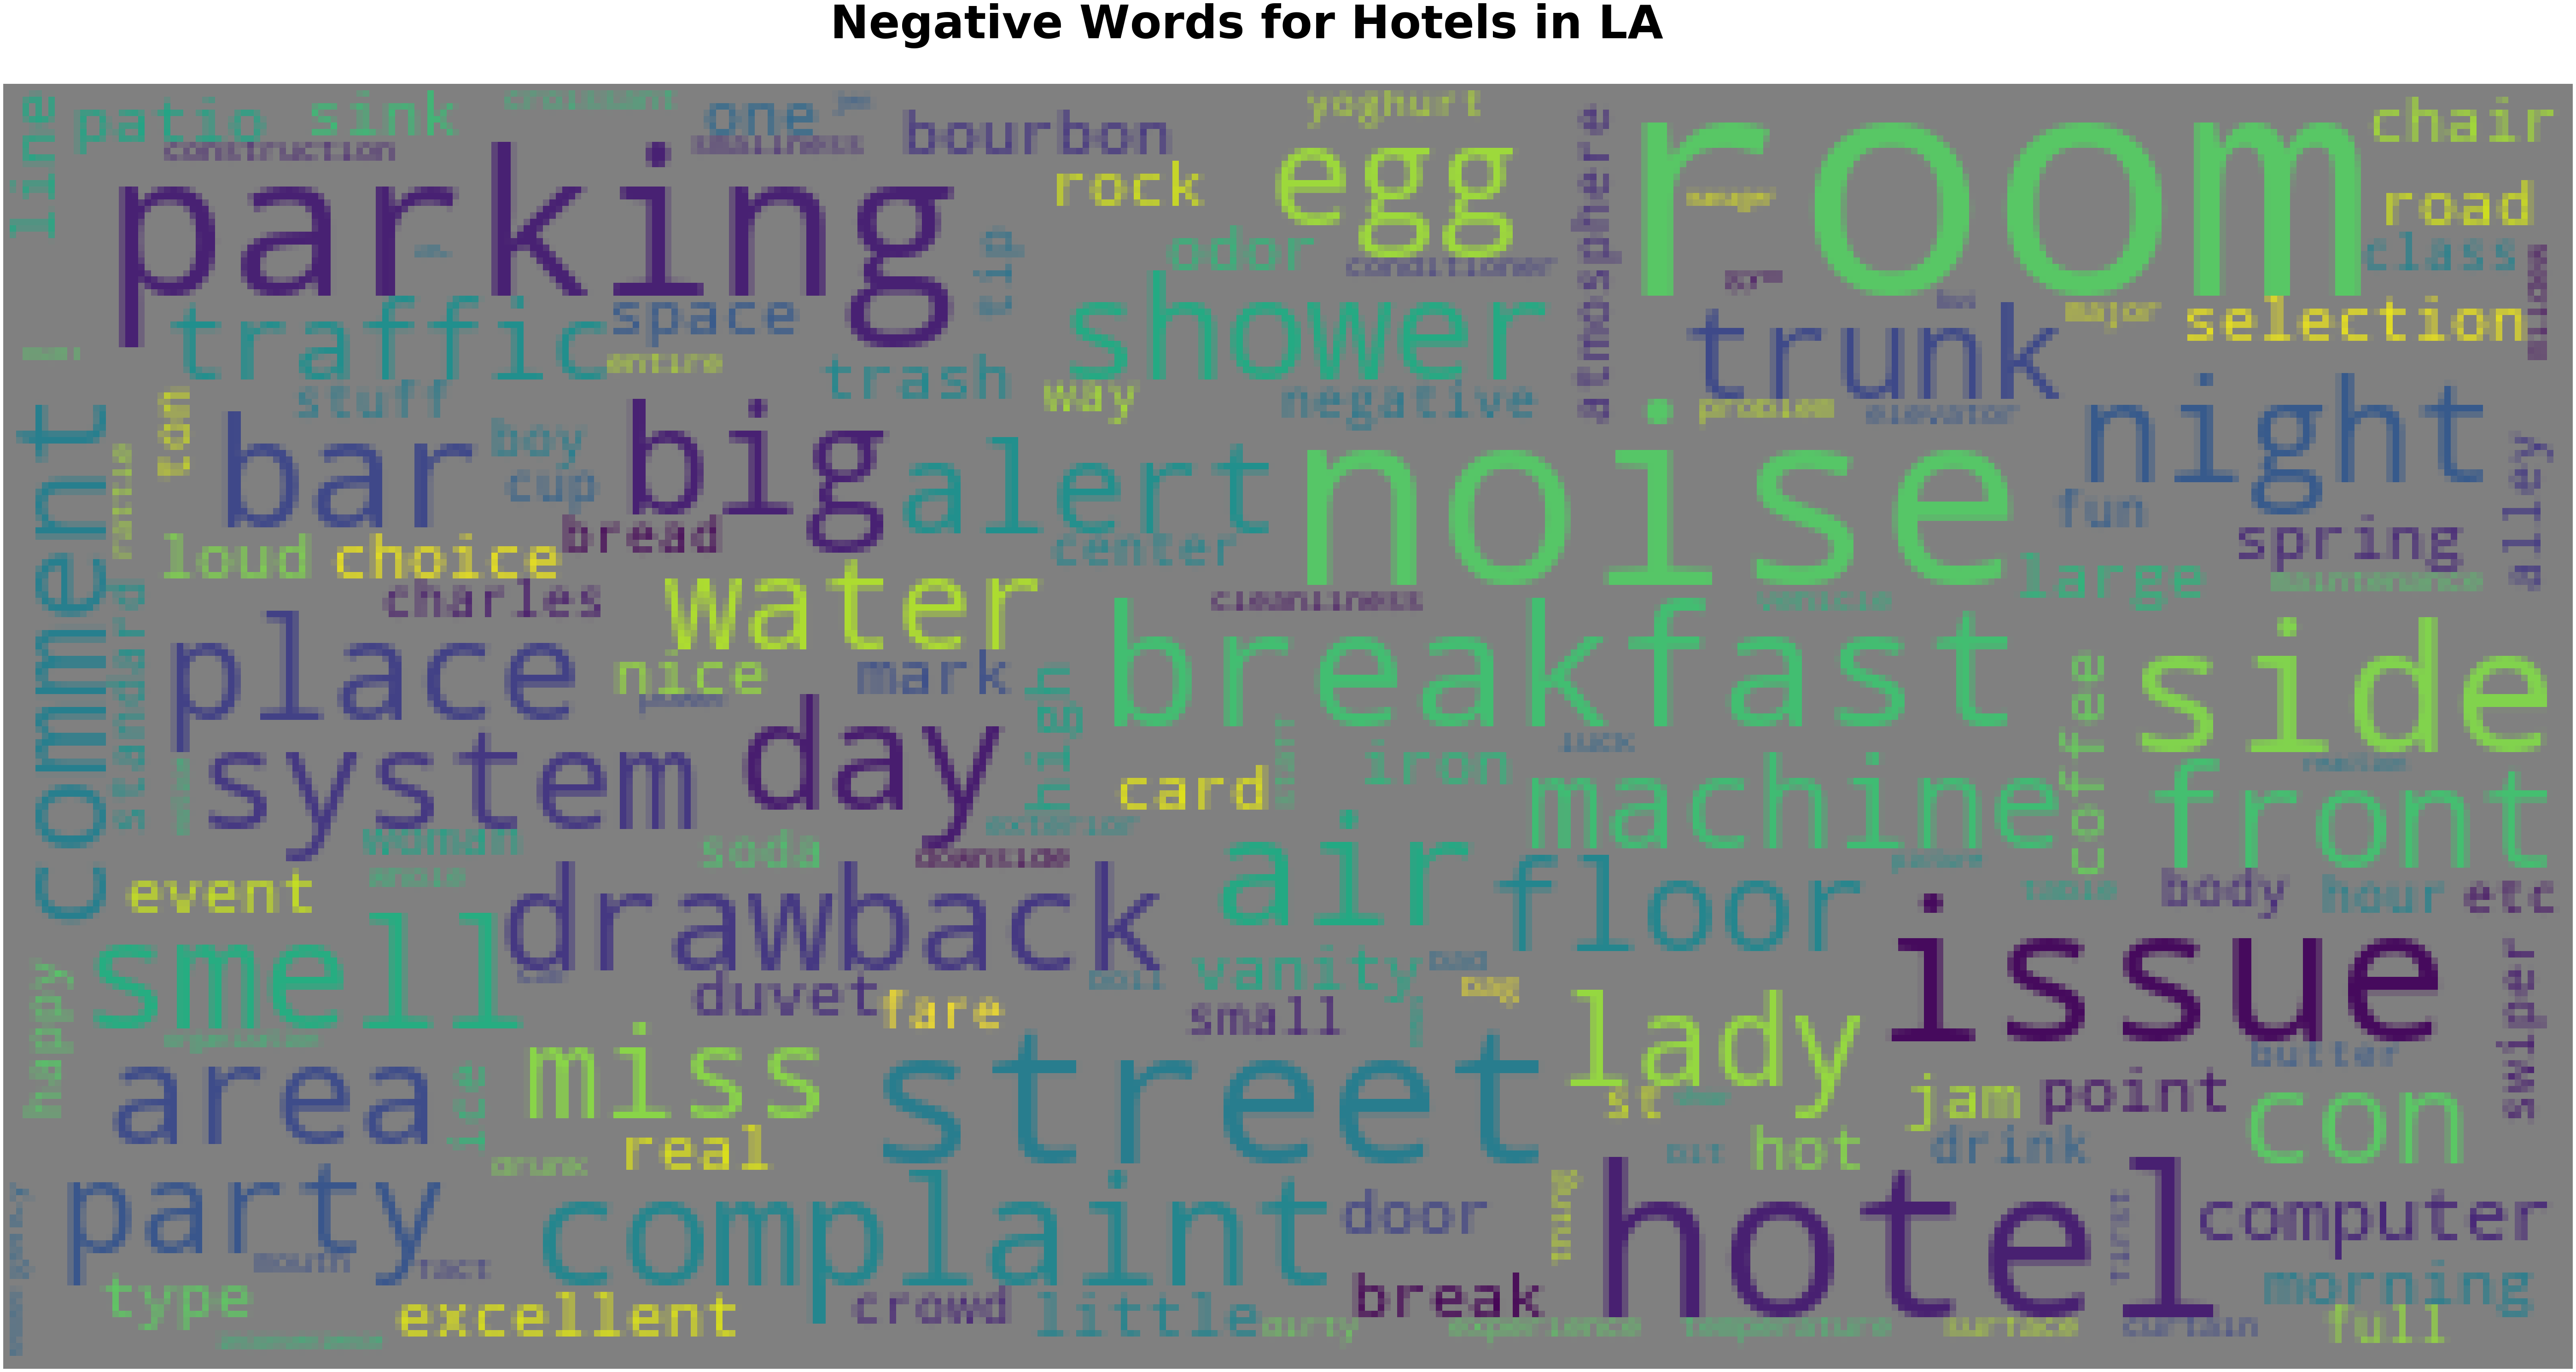

In [98]:
wc(text_neg,'grey','Negative Words for Hotels in LA' )

In [99]:
lowest = defaultdict()
highest = defaultdict()
for i in NY_term_dict:
    if NY_term_dict[i]:
        highest[i] = NY_term_dict[i].most_common()[:10]
        lowest[i] = NY_term_dict[i].most_common()[-10:]
highest_df = pd.DataFrame(highest)
lowest_df = pd.DataFrame(lowest)
lowest_df = lowest_df.drop(["VALUE"],1)
highest_df = highest_df.drop(["VALUE"],1)
highest_df

LOCATION             CHECKIN                   FOOD  \
0          (location, 48.5)     (feedback, 4.5)      (breakfast, 28.5)   
1                (view, 12)       (george, 4.5)  (free breakfast, 5.5)   
2                (place, 7)         (john, 3.5)        (restaurant, 4)   
3               (choice, 4)  (martini maker, 3)            (people, 4)   
4           (park views, 4)        (martini, 3)        (espresso, 3.5)   
5     (central location, 4)         (wifi, 3.0)  (decent breakfast, 3)   
6  (workout facility, 3.25)    (elizabeth, 2.5)    (full breakfast, 3)   
7                 (walk, 3)           (ritz, 2)            (food, 3.0)   
8       (great location, 3)       (new york, 2)  (breakfast buffet, 3)   
9          (great views, 3)          (touch, 2)    (espresso bar, 2.5)   

             BUILDING                  ROOMS             CLEANLINESS  \
0      (parking, 6.0)          (room, 75.25)             (regard, 8)   
1          (lot, 5.0)          (hotel, 52.5)            (amenity, 5)   
2           (home, 5)            (bed, 17.5)        (clean lot, 3.0)   
3  (team square, 5.0)    (hotel staff, 11.5)       (availability, 2)   
4        (setting, 2)             (lobby, 6)            (quality, 2)   
5           (part, 2)  (holiday square, 6.0)         (evaluation, 2)   
6   (silver frame, 2)  (express square, 6.0)  (quality bedding, 1.5)   
7  (property kind, 2)             (guest, 5)      (star rating, 1.5)   
8   (entire house, 1)      (inn square, 5.0)             (rating, 1)   
9          (porch, 1)           (linen, 3.5)             (mildew, 1)   

                     VALUE              SERVICE                BUSINESS  
0             (price, 6.5)       (staff, 69.25)           (owner, 12.5)  
1               (value, 6)      (service, 24.5)       (management, 5.0)  
2         (expectation, 4)     (experience, 12)  (general manager, 4.0)  
3         (value guest, 4)  (friendly staff, 6)             (family, 3)  
4           (pricing, 3.5)       (doorman, 4.5)           (shopping, 3)  
5              (rate, 2.5)          (travel, 4)  (management team, 2.5)  
6  (high expectation, 1.5)       (concierge, 3)             (future, 2)  
7              (need, 1.5)   (super service, 3)        (great maker, 2)  
8   (exceptional smile, 1)           (guy, 3.0)         (past owner, 1)  
9            (standard, 1)           (sue, 2.5)        (environment, 1)

In [100]:
lowest_df

LOCATION             CHECKIN                        FOOD  \
0    (upper side, -1)      (free wifi, 1)         (typical style, -1)   
1     (open area, -1)     (great wifi, 1)              (lemonade, -1)   
2         (issue, -1)             (tv, 0)  (breakfast congestion, -1)   
3    (hells area, -1)        (flight, -1)            (trash need, -1)   
4  (kitchen area, -1)        (hudson, -1)              (eat area, -1)   
5  (only problem, -1)      (more ish, -1)       (fresh pancake, -1.5)   
6          (bang, -1)  (hudson river, -1)              (pastry, -1.5)   
7        (middle, -1)    (hum review, -1)             (cigarette, -2)   
8  (central park, -2)     (reduction, -1)         (garbage truck, -2)   
9       (problem, -2)         (check, -4)                 (egg, -2.5)   

                BUILDING                ROOMS             CLEANLINESS  \
0        (stairwell, -1)         (couple, -1)       (complacency, -1)   
1         (sidewalk, -1)    (minor issue, -1)            (stench, -1)   
2         (dumpster, -1)           (sink, -1)   (maintenance guy, -1)   
3  (entire building, -1)    (brown decor, -1)             (trash, -1)   
4   (whirlwind city, -1)    (exhaust fan, -1)       (garbage bag, -1)   
5           (window, -2)  (old furniture, -1)        (bad aspect, -1)   
6           (road, -2.0)         (aspect, -1)  (air conditioning, -2)   
7    (outside fan, -2.5)          (spa, -1.5)             (noise, -2)   
8           (street, -3)          (motel, -2)      (low lighting, -2)   
9            (horse, -4)          (radio, -2)  (cleaning staff, -2.5)   

                  VALUE                     SERVICE                 BUSINESS  
0      (great value, 1)  (complimentary bottle, -1)           (small bar, 1)  
1           (impact, 1)              (surprise, -1)                 (job, 1)  
2  (reward standard, 1)        (only complaint, -1)              (parent, 1)  
3           (number, 1)                (effort, -1)            (customer, 1)  
4             (fee, -1)      (elevator service, -1)        (professional, 1)  
5             (one, -1)                  (lift, -1)                (shop, 1)  
6      (few dollar, -1)    (issue resolution, -1.5)             (company, 1)  
7   (only downside, -1)         (spa service, -1.5)         (great group, 1)  
8     (only aspect, -1)                 (one, -1.5)     (chinese market, -1)  
9         (penny, -3.0)                (tone, -1.5)  (restaurant market, -1)

## NY Hotel Review

In [49]:
aspect_sent, NY_term_dict = gen_dict("hotel_reviewNY.txt")
NY_df = gen_rate(aspect_sent)
NY_df

aspect      pos    neg  rate
0      LOCATION   156.25   22.0   4.5
1       CHECKIN    76.50   13.0   4.4
2          FOOD   167.50   36.0   4.3
3      BUILDING    47.50   27.5   3.5
4         ROOMS   367.25   78.5   4.3
5   CLEANLINESS    42.00   14.5   4.0
6         VALUE    46.50    9.0   4.4
7       SERVICE   217.25   23.0   4.6
8      BUSINESS    46.00    3.0   4.8
9         OTHER   124.50   13.0   4.6
10        TOTAL  1291.25  239.5   4.4

In [50]:
a_series = pd. Series(['NY'] + list(NY_df['rate']), index = total_df. columns)
total_df = total_df.append(a_series, ignore_index=True)

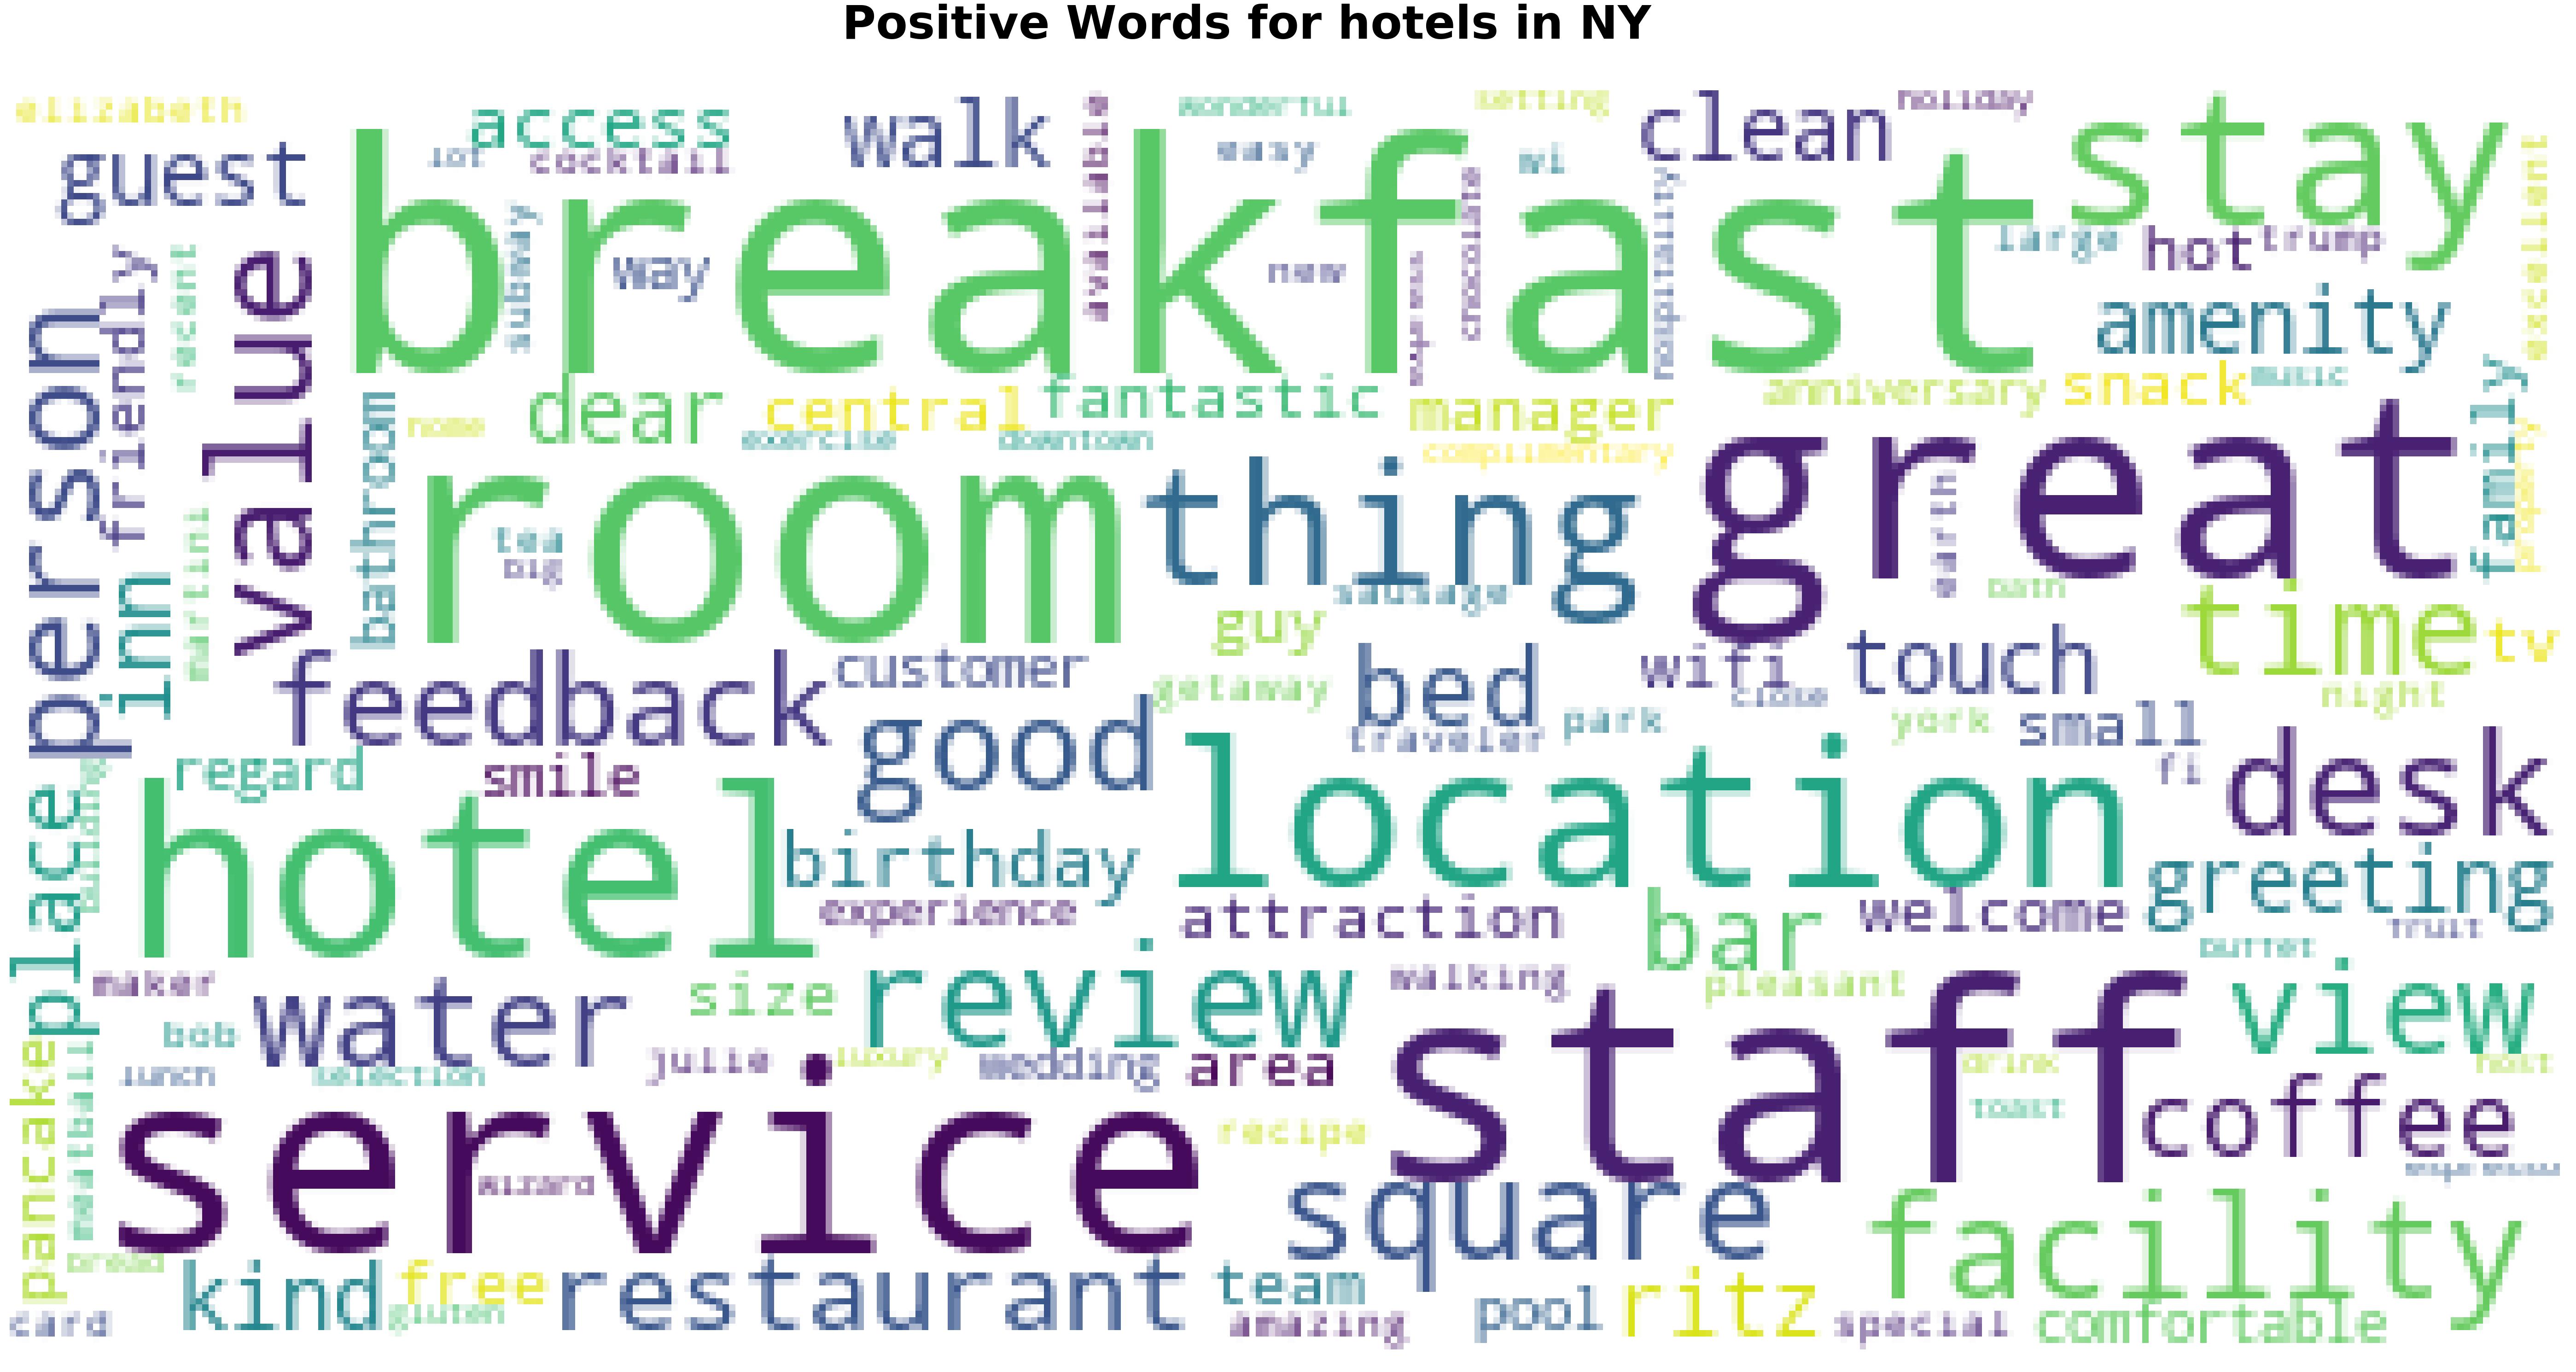

In [51]:
text_pos, text_neg = gen_text(NY_term_dict)
wc(text_pos,'white','Positive Words for hotels in NY' )

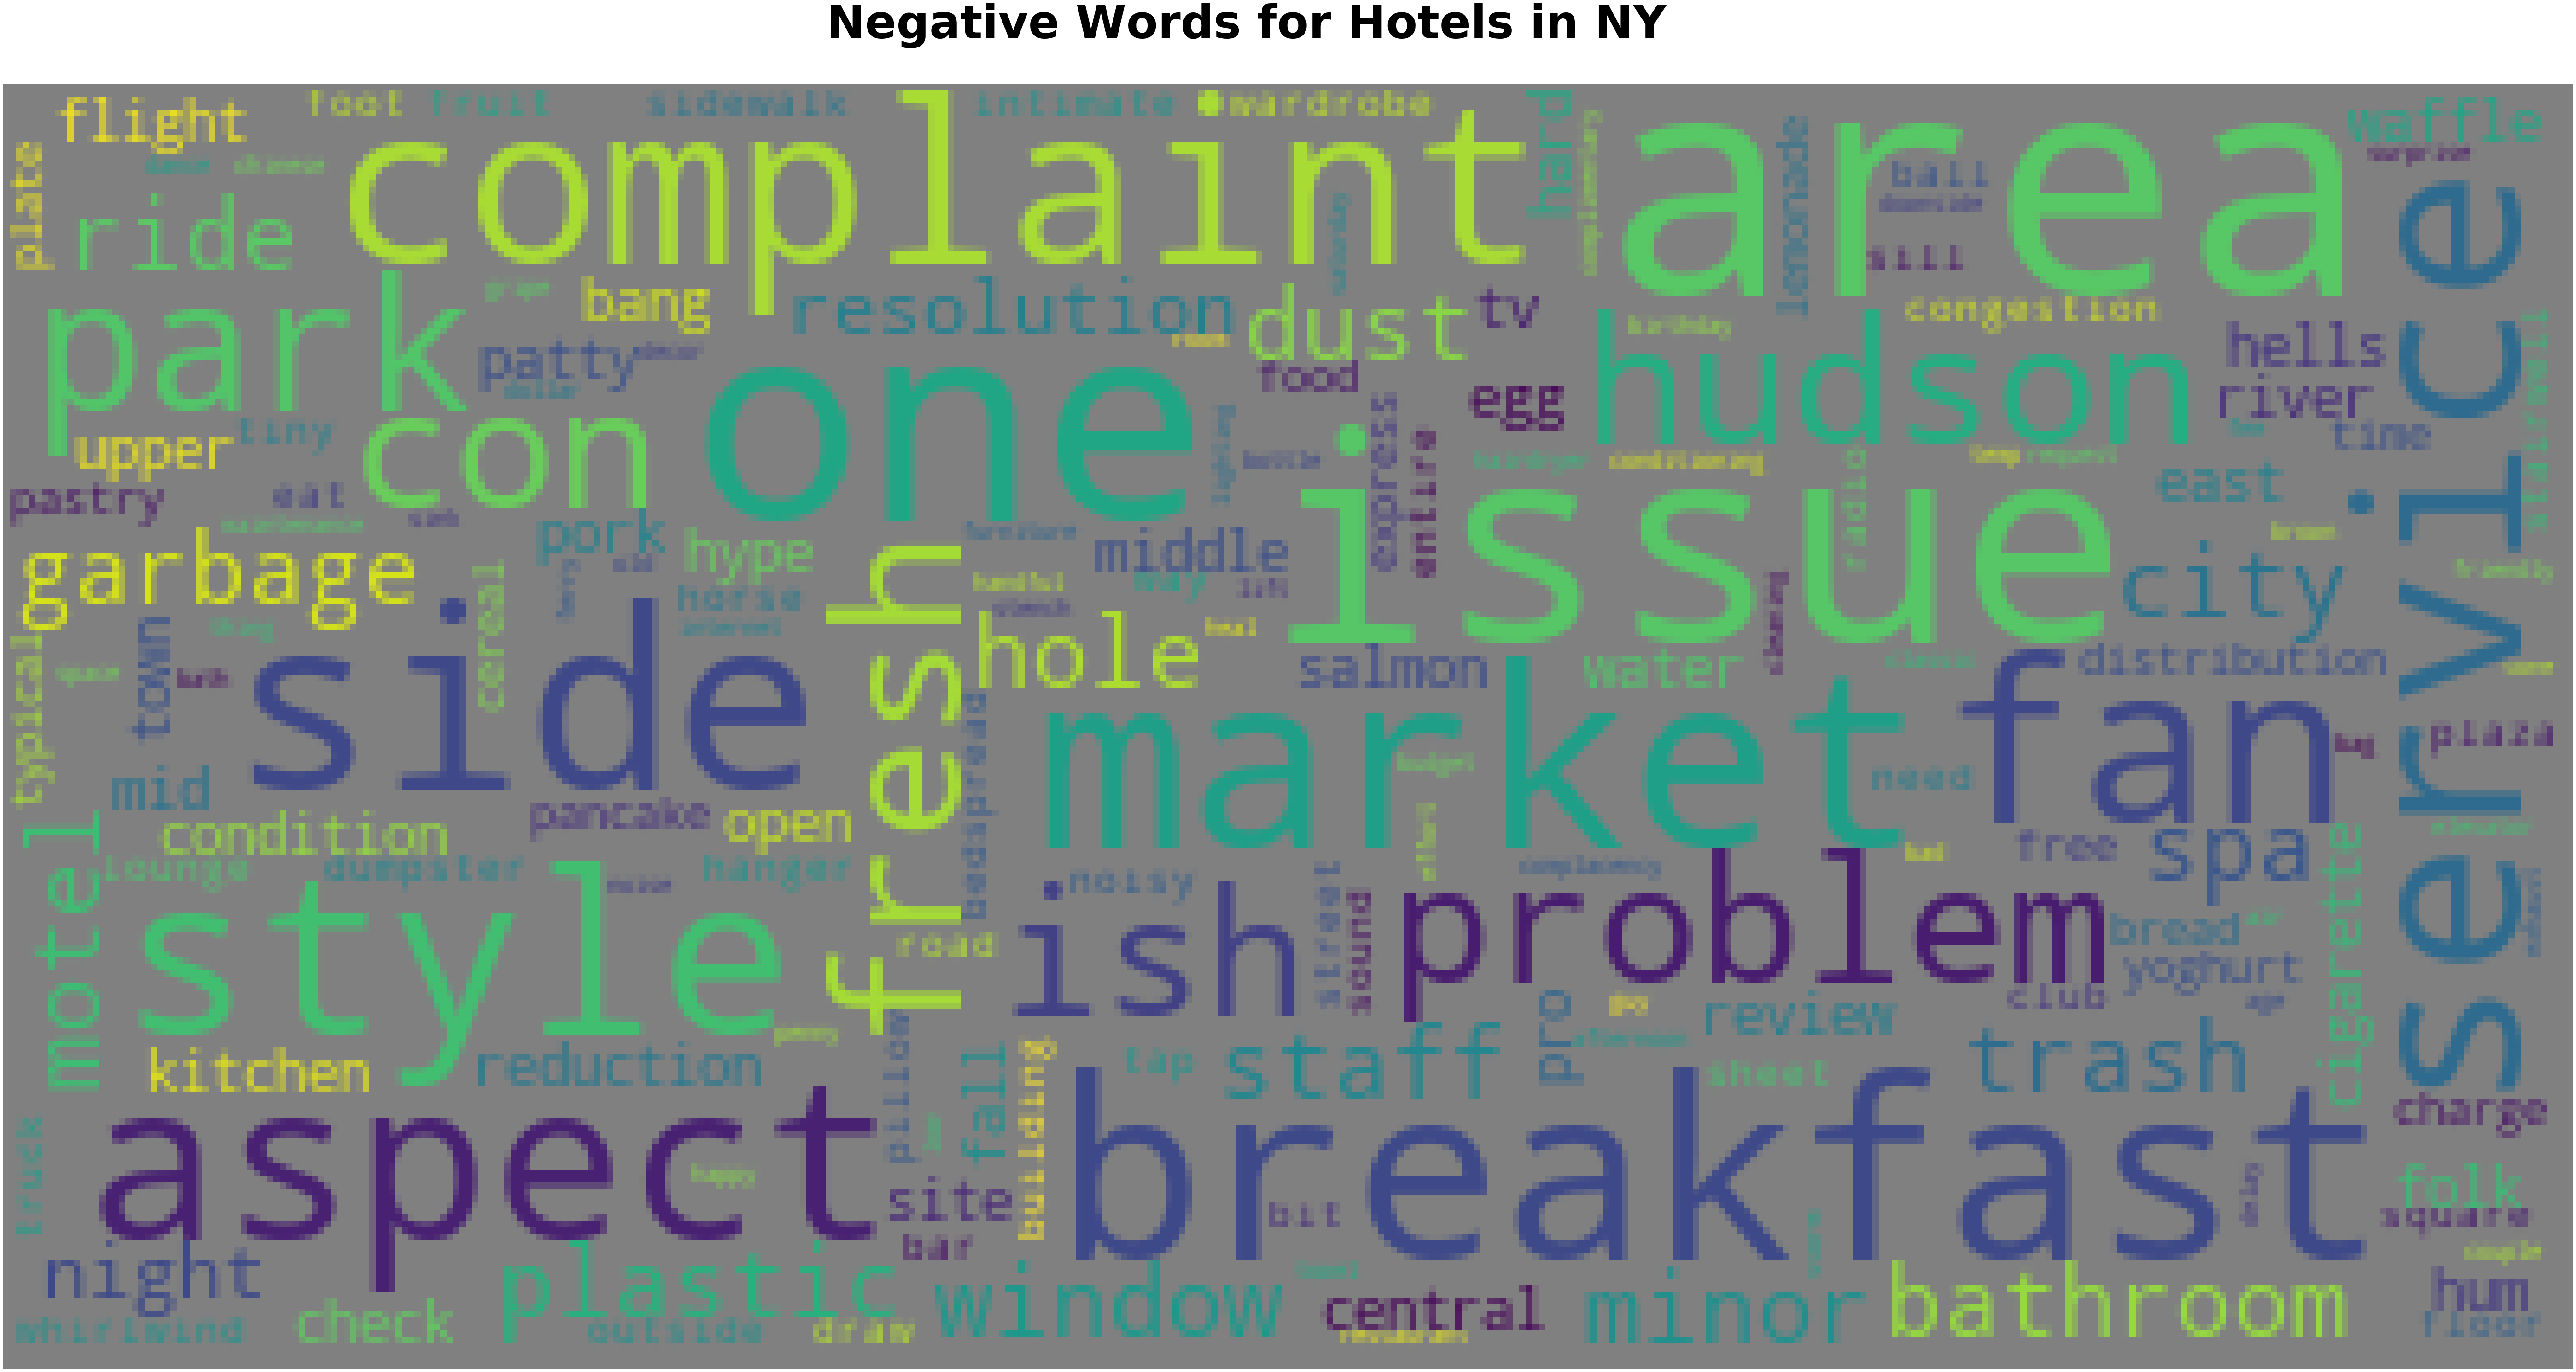

In [52]:
wc(text_neg,'grey','Negative Words for Hotels in NY' )

In [54]:
lowest = defaultdict()
highest = defaultdict()
for i in NY_term_dict:
    if NY_term_dict[i]:
        highest[i] = NY_term_dict[i].most_common()[:10]
        lowest[i] = NY_term_dict[i].most_common()[-10:]
highest_df = pd.DataFrame(highest)
lowest_df = pd.DataFrame(lowest)
lowest_df = lowest_df.drop(["OTHER"],1)
highest_df = highest_df.drop(["OTHER"],1)
highest_df

LOCATION             CHECKIN                   FOOD  \
0          (location, 48.5)     (feedback, 4.5)      (breakfast, 28.5)   
1                (view, 12)       (george, 4.5)  (free breakfast, 5.5)   
2                (place, 7)         (john, 3.5)        (restaurant, 4)   
3               (choice, 4)  (martini maker, 3)            (people, 4)   
4           (park views, 4)        (martini, 3)        (espresso, 3.5)   
5     (central location, 4)         (wifi, 3.0)  (decent breakfast, 3)   
6  (workout facility, 3.25)    (elizabeth, 2.5)    (full breakfast, 3)   
7                 (walk, 3)           (ritz, 2)            (food, 3.0)   
8       (great location, 3)       (new york, 2)  (breakfast buffet, 3)   
9          (great views, 3)          (touch, 2)    (espresso bar, 2.5)   

             BUILDING                  ROOMS             CLEANLINESS  \
0      (parking, 6.0)          (room, 75.25)             (regard, 8)   
1          (lot, 5.0)          (hotel, 52.5)            (amenity, 5)   
2           (home, 5)            (bed, 17.5)        (clean lot, 3.0)   
3  (team square, 5.0)    (hotel staff, 11.5)       (availability, 2)   
4        (setting, 2)             (lobby, 6)            (quality, 2)   
5           (part, 2)  (holiday square, 6.0)         (evaluation, 2)   
6   (silver frame, 2)  (express square, 6.0)  (quality bedding, 1.5)   
7  (property kind, 2)             (guest, 5)      (star rating, 1.5)   
8   (entire house, 1)      (inn square, 5.0)             (rating, 1)   
9          (porch, 1)           (linen, 3.5)             (mildew, 1)   

                     VALUE              SERVICE                BUSINESS  
0             (price, 6.5)       (staff, 69.25)           (owner, 12.5)  
1               (value, 6)      (service, 24.5)       (management, 5.0)  
2         (expectation, 4)     (experience, 12)  (general manager, 4.0)  
3         (value guest, 4)  (friendly staff, 6)             (family, 3)  
4           (pricing, 3.5)       (doorman, 4.5)           (shopping, 3)  
5              (rate, 2.5)          (travel, 4)  (management team, 2.5)  
6  (high expectation, 1.5)       (concierge, 3)             (future, 2)  
7              (need, 1.5)   (super service, 3)        (great maker, 2)  
8   (exceptional smile, 1)           (guy, 3.0)         (past owner, 1)  
9            (standard, 1)           (sue, 2.5)        (environment, 1)

In [55]:
lowest_df

LOCATION             CHECKIN                        FOOD  \
0    (upper side, -1)      (free wifi, 1)         (typical style, -1)   
1     (open area, -1)     (great wifi, 1)              (lemonade, -1)   
2         (issue, -1)             (tv, 0)  (breakfast congestion, -1)   
3    (hells area, -1)        (flight, -1)            (trash need, -1)   
4  (kitchen area, -1)        (hudson, -1)              (eat area, -1)   
5  (only problem, -1)      (more ish, -1)       (fresh pancake, -1.5)   
6          (bang, -1)  (hudson river, -1)              (pastry, -1.5)   
7        (middle, -1)    (hum review, -1)             (cigarette, -2)   
8  (central park, -2)     (reduction, -1)         (garbage truck, -2)   
9       (problem, -2)         (check, -4)                 (egg, -2.5)   

                BUILDING                ROOMS             CLEANLINESS  \
0        (stairwell, -1)         (couple, -1)       (complacency, -1)   
1         (sidewalk, -1)    (minor issue, -1)            (stench, -1)   
2         (dumpster, -1)           (sink, -1)   (maintenance guy, -1)   
3  (entire building, -1)    (brown decor, -1)             (trash, -1)   
4   (whirlwind city, -1)    (exhaust fan, -1)       (garbage bag, -1)   
5           (window, -2)  (old furniture, -1)        (bad aspect, -1)   
6           (road, -2.0)         (aspect, -1)  (air conditioning, -2)   
7    (outside fan, -2.5)          (spa, -1.5)             (noise, -2)   
8           (street, -3)          (motel, -2)      (low lighting, -2)   
9            (horse, -4)          (radio, -2)  (cleaning staff, -2.5)   

                  VALUE                     SERVICE                 BUSINESS  
0      (great value, 1)  (complimentary bottle, -1)           (small bar, 1)  
1           (impact, 1)              (surprise, -1)                 (job, 1)  
2  (reward standard, 1)        (only complaint, -1)              (parent, 1)  
3           (number, 1)                (effort, -1)            (customer, 1)  
4             (fee, -1)      (elevator service, -1)        (professional, 1)  
5             (one, -1)                  (lift, -1)                (shop, 1)  
6      (few dollar, -1)    (issue resolution, -1.5)             (company, 1)  
7   (only downside, -1)         (spa service, -1.5)         (great group, 1)  
8     (only aspect, -1)                 (one, -1.5)     (chinese market, -1)  
9         (penny, -3.0)                (tone, -1.5)  (restaurant market, -1)

## OR Hotel Review

In [56]:
aspect_sent, OR_term_dict = gen_dict("hotel_reviewOR.txt")
OR_df = gen_rate(aspect_sent)
OR_df

aspect    pos   neg  rate
0      LOCATION   95.0   5.0   4.8
1       CHECKIN   26.5   5.0   4.4
2          FOOD   70.0  15.0   4.3
3      BUILDING   31.5   6.5   4.3
4         ROOMS  208.5  22.0   4.6
5   CLEANLINESS   28.0   1.0   4.9
6         VALUE    8.0   1.0   4.6
7       SERVICE  104.0   3.0   4.9
8      BUSINESS   13.0   0.0   5.0
9         OTHER   47.5   5.0   4.6
10        TOTAL  632.0  63.5   4.6

In [57]:
a_series = pd. Series(['OR'] + list(OR_df['rate']), index = total_df. columns)
total_df = total_df.append(a_series, ignore_index=True)

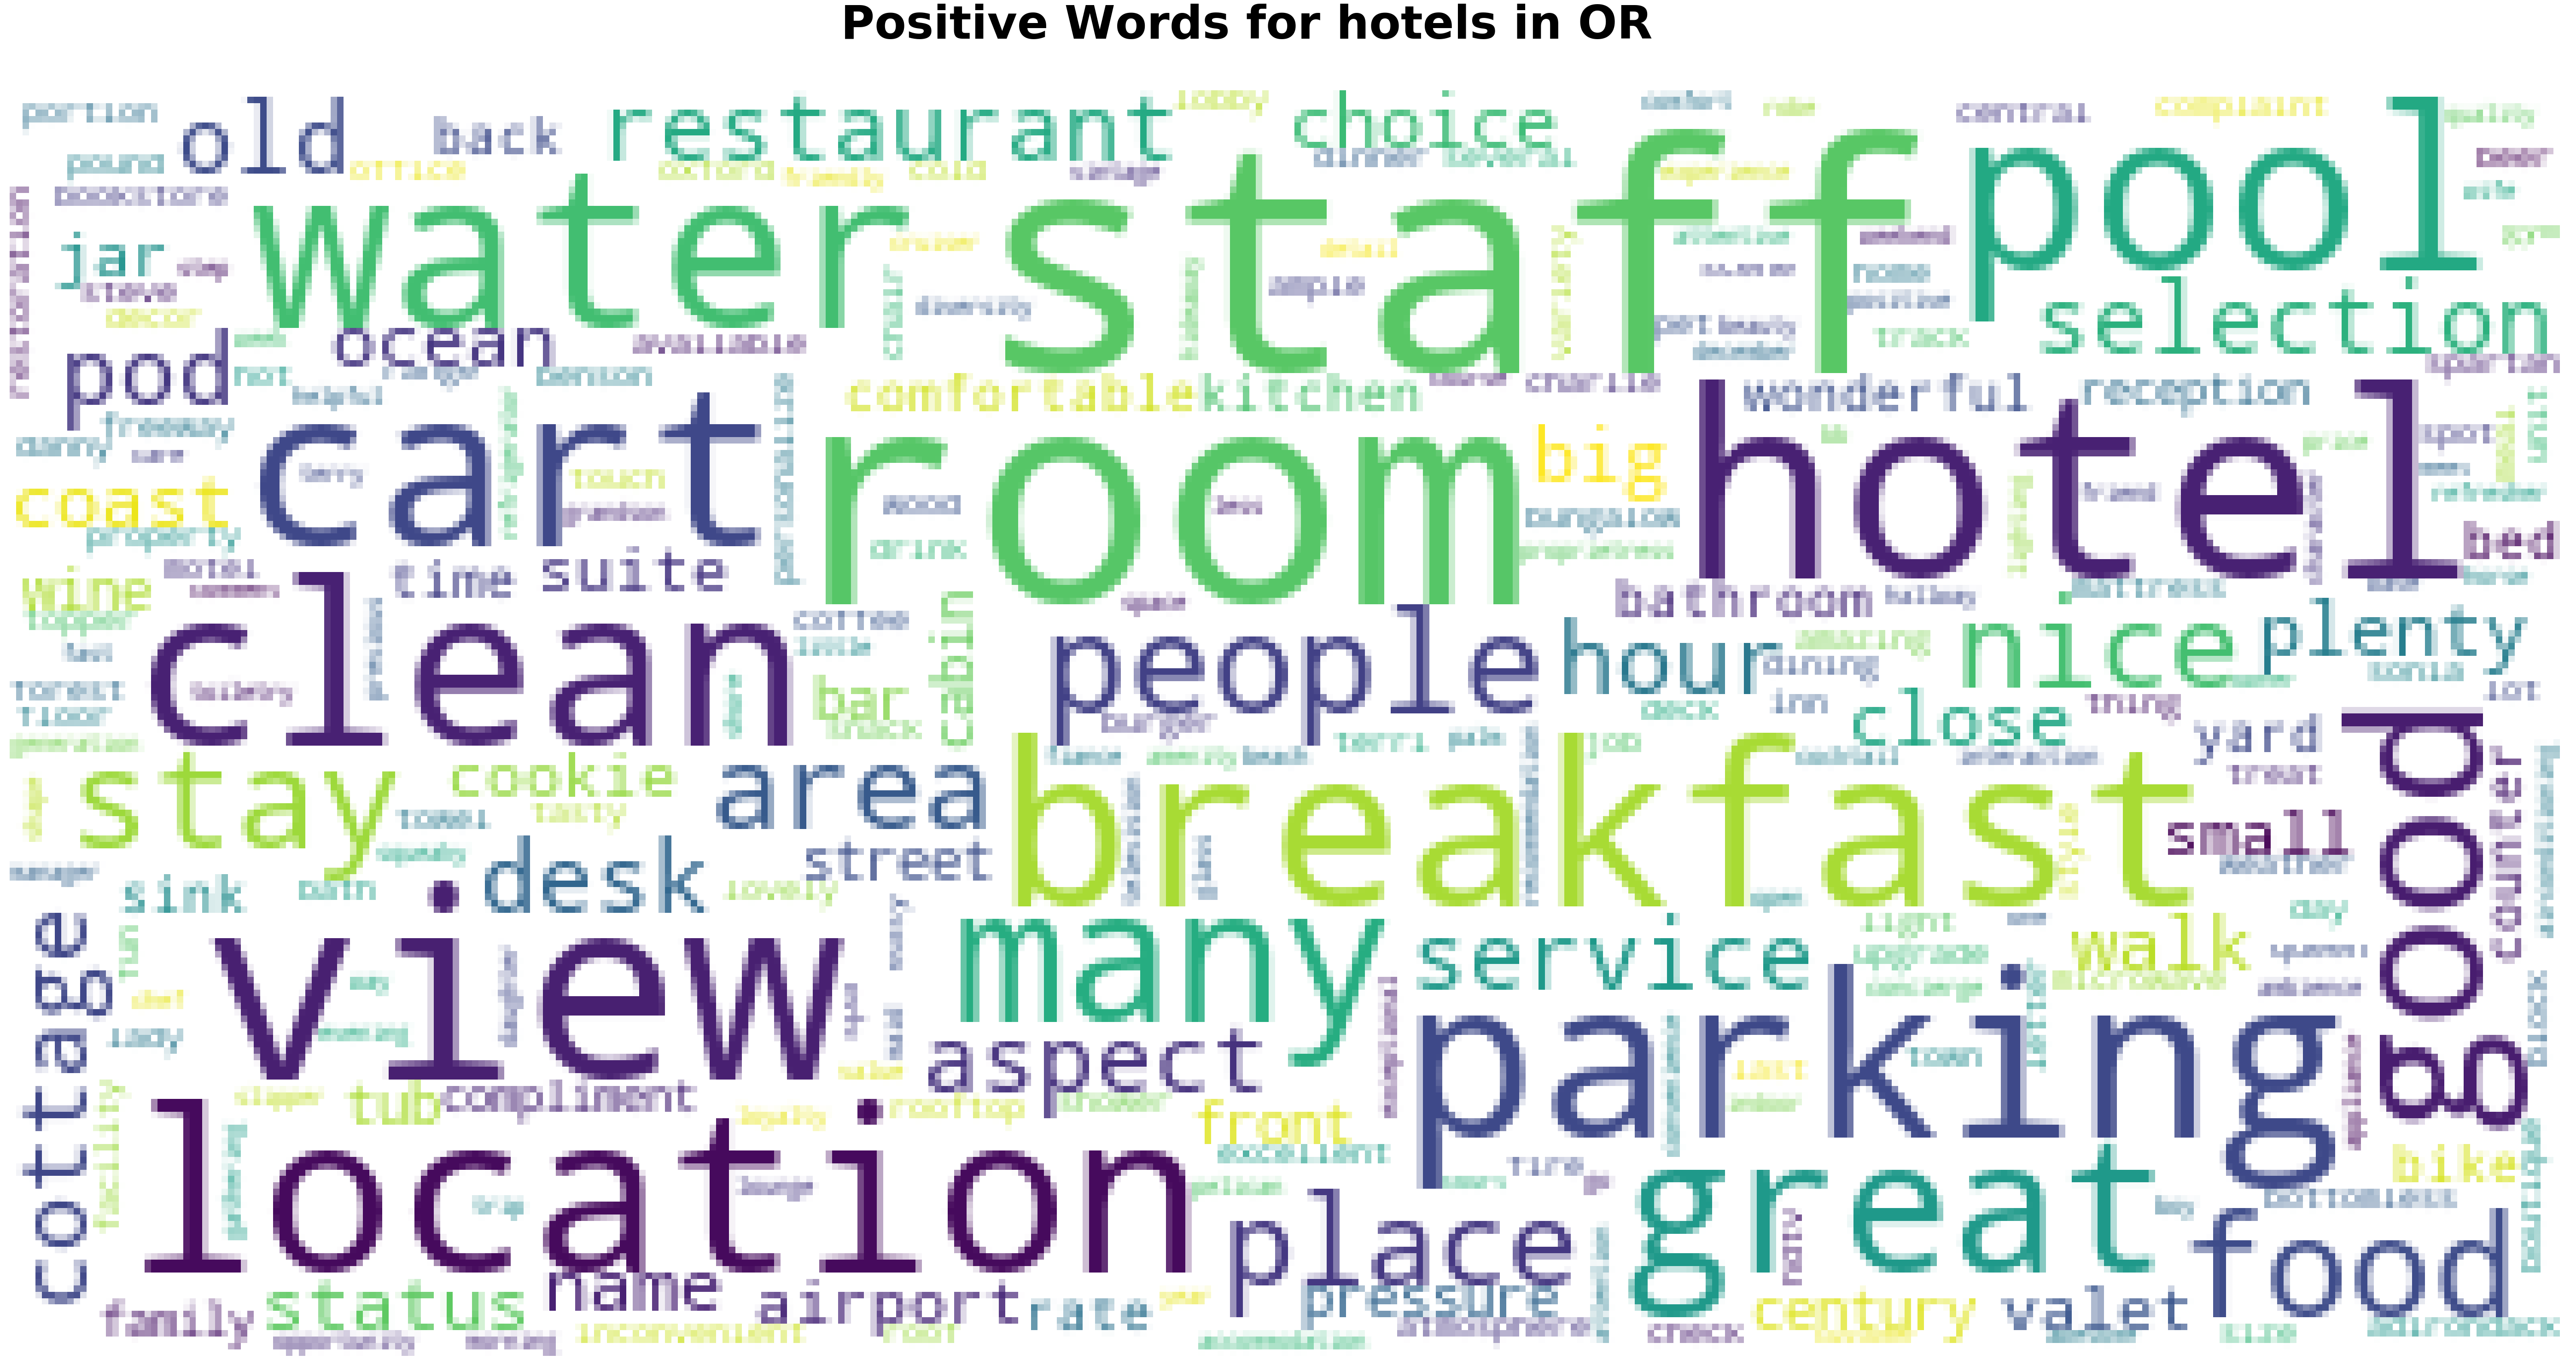

In [58]:
text_pos, text_neg = gen_text(OR_term_dict)
wc(text_pos,'white','Positive Words for hotels in OR' )

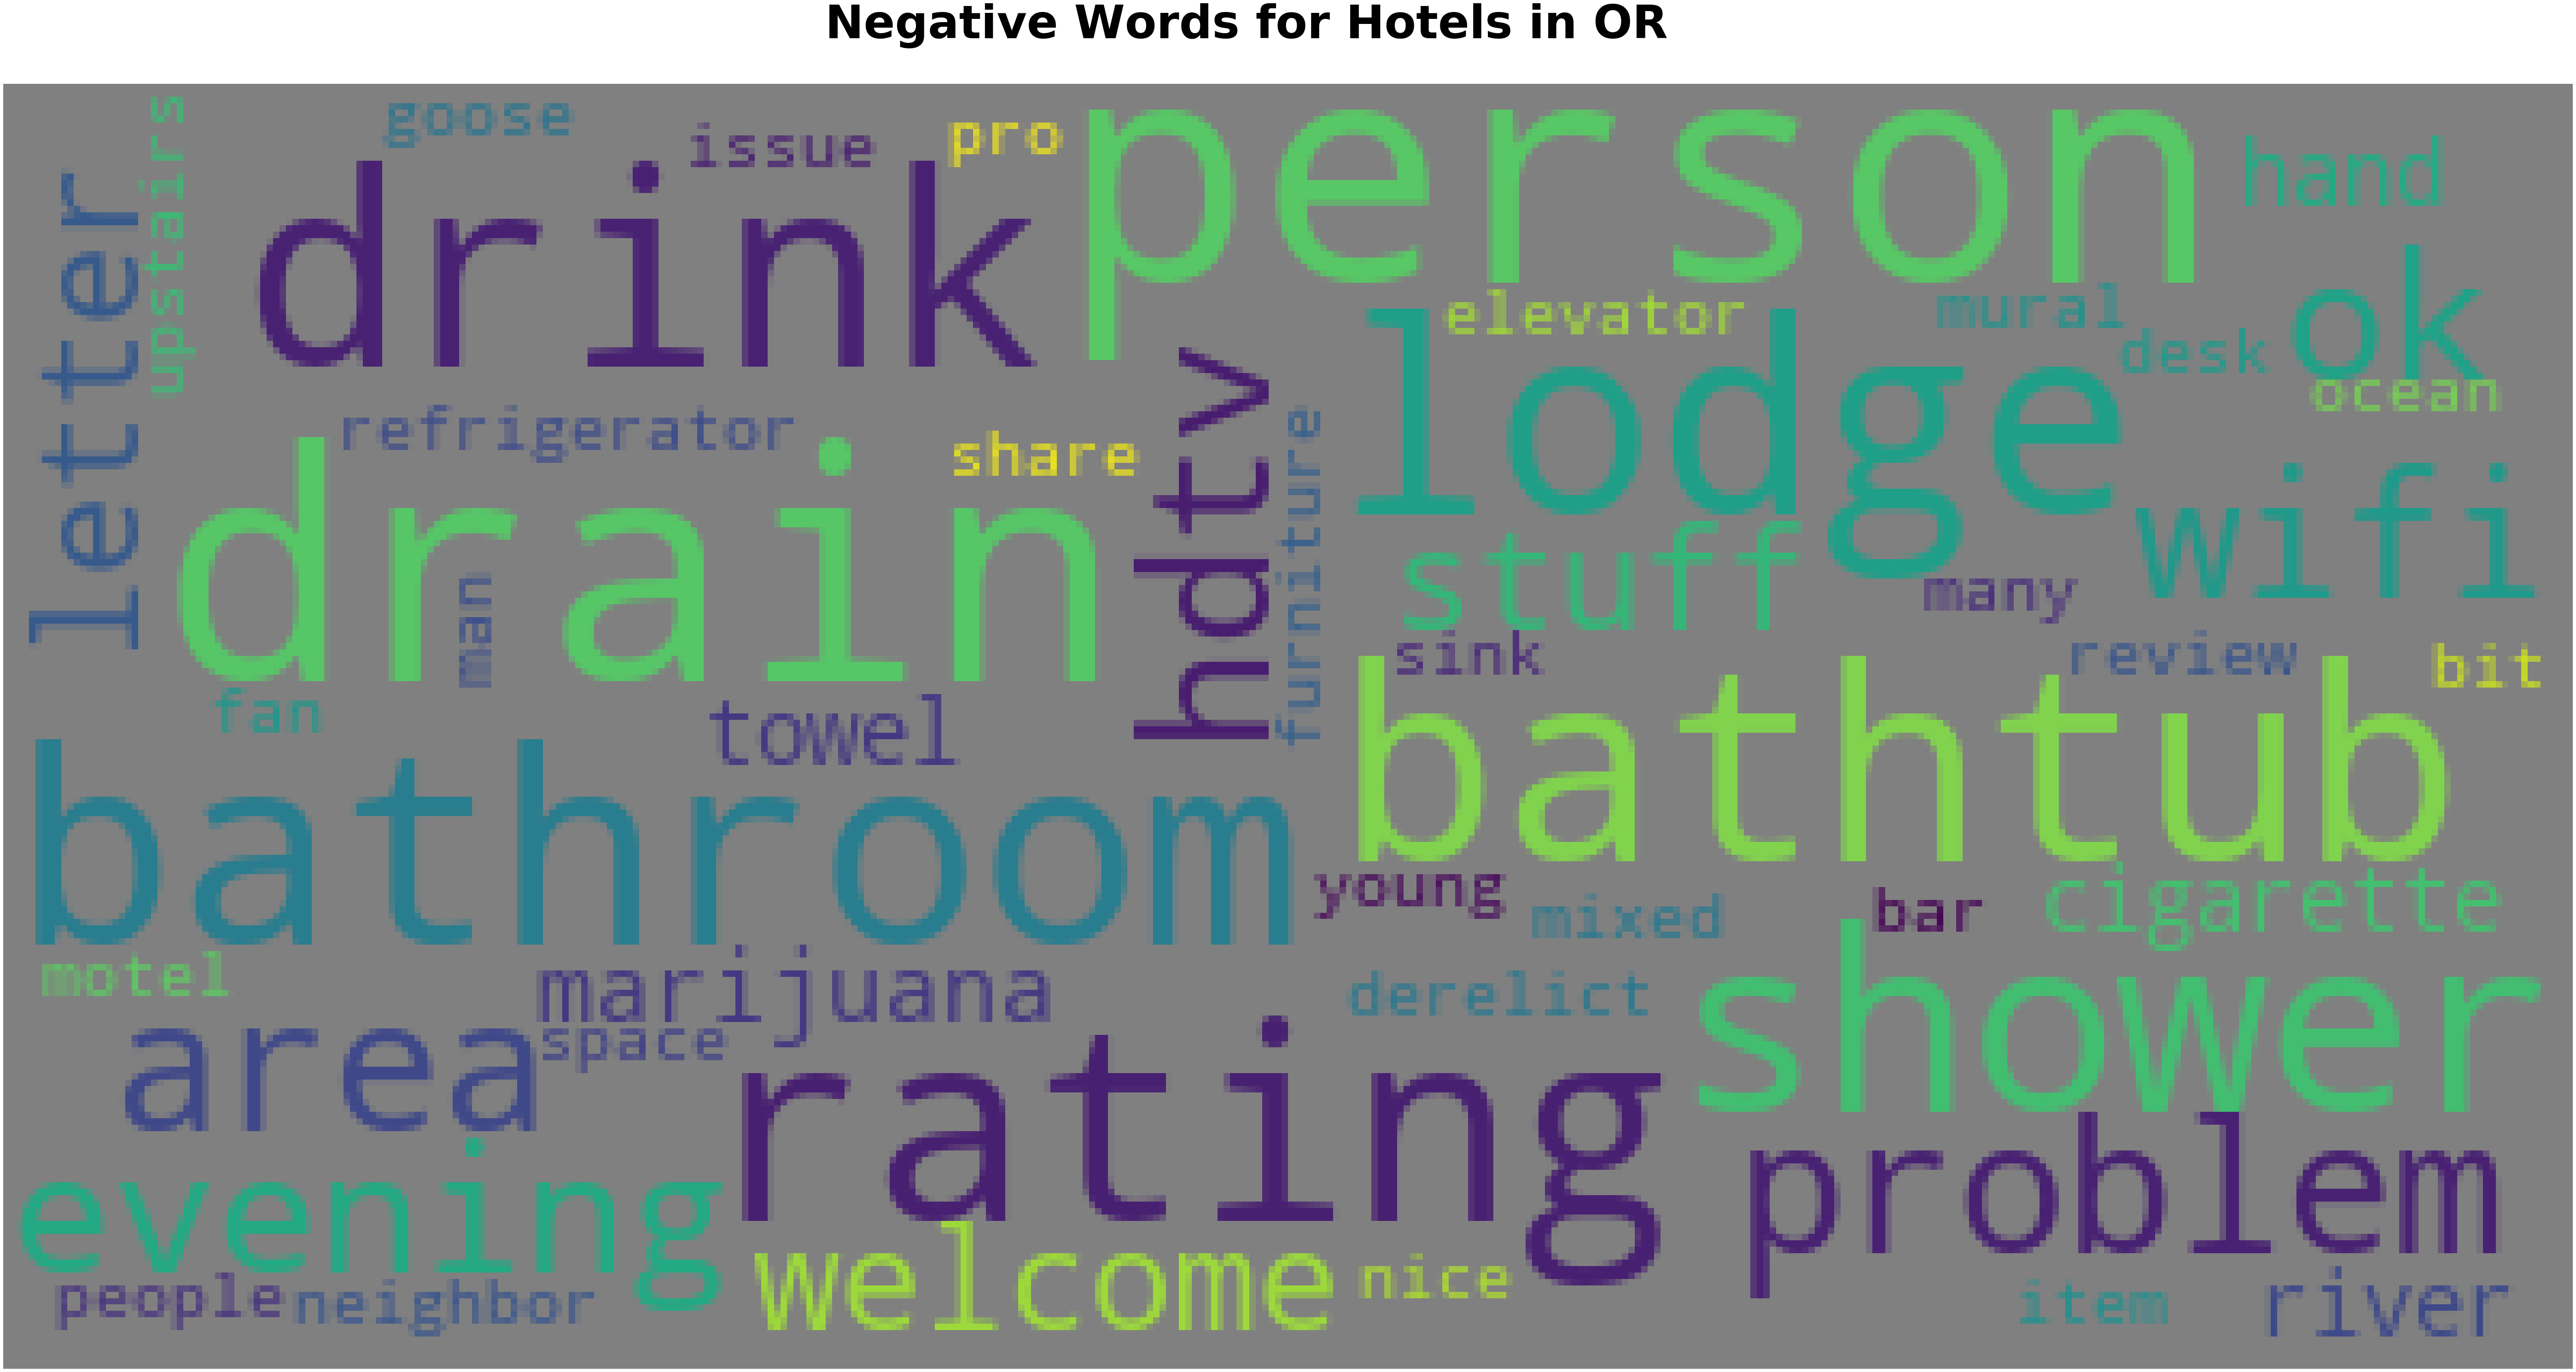

In [59]:
wc(text_neg,'grey','Negative Words for Hotels in OR' )

In [60]:
lowest = defaultdict()
highest = defaultdict()
for i in OR_term_dict:
    if OR_term_dict[i]:
        highest[i] = OR_term_dict[i].most_common()[:5]
        lowest[i] = OR_term_dict[i].most_common()[-5:]
highest_df = pd.DataFrame(highest)
lowest_df = pd.DataFrame(lowest)
lowest_df = lowest_df.drop(["OTHER"],1)
highest_df = highest_df.drop(["OTHER"],1)
highest_df

LOCATION              CHECKIN                 FOOD  \
0  (location, 24.5)         (danny, 3.0)     (breakfast, 8.5)   
1       (place, 15)         (sonia, 3.0)            (food, 6)   
2       (view, 8.5)        (oxford, 2.5)  (water pressure, 5)   
3       (plenty, 4)           (check, 2)           (water, 4)   
4         (spot, 3)  (airport people, 2)      (restaurant, 3)   

               BUILDING               ROOMS             CLEANLINESS  \
0  (parking staff, 4.5)        (room, 60.5)     (squeaky view, 7.0)   
1        (parking, 2.0)       (hotel, 15.5)       (clean view, 3.0)   
2      (rooftop bar, 2)       (lobby, 10.5)  (attentive staff, 2.5)   
3    (office lady, 1.5)          (bed, 9.5)             (detail, 2)   
4         (bungalow, 1)  (accommodation, 5)               (maid, 2)   

              VALUE              SERVICE                   BUSINESS  
0        (value, 2)        (staff, 42.5)               (owner, 5.5)  
1  (many aspect, 1)      (service, 10.5)  (small refrigerator, 3.5)  
2  (opportunity, 1)      (experience, 4)                (family, 2)  
3        (price, 1)    (desk staff, 3.5)      (family gathering, 1)  
4         (rate, 1)  (friendly staff, 3)             (appliance, 1)

In [61]:
lowest_df

LOCATION               CHECKIN              FOOD  \
0      (close place, 1)             (wifi, 0)  (nice drink, -1)   
1     (only problem, 0)            (hdtv, -1)        (item, -1)   
2            (area, -1)       (ok rating, -1)      (people, -1)   
3          (person, -1)           (stuff, -1)   (cigarette, -2)   
4  (evening person, -2)  (welcome letter, -1)       (river, -2)   

         BUILDING                 ROOMS        CLEANLINESS  \
0    (upgrade, 1)    (shower drain, -1)        (beauty, 1)   
1  (neighbor, -1)   (bathtub drain, -1)     (diversity, 1)   
2  (derelict, -1)           (space, -1)    (clean pool, 1)   
3     (mural, -1)  (bathroom fan, -2.0)      (lighting, 1)   
4  (elevator, -1)     (desk person, -2)  (just rating, -1)   

                 VALUE                SERVICE                   BUSINESS  
0           (price, 1)              (care, 1)               (owner, 5.5)  
1            (rate, 1)    (recommendation, 1)  (small refrigerator, 3.5)  
2  (loyalty status, 1)   (reception staff, 1)                (family, 2)  
3      (great view, 1)  (refresher course, 1)      (family gathering, 1)  
4            (bit, -1)        (young man, -1)             (appliance, 1)

## PA Hotel Review

In [62]:
aspect_sent, PA_term_dict = gen_dict("hotel_reviewPA.txt")
PA_df = gen_rate(aspect_sent)
PA_df

aspect      pos    neg  rate
0      LOCATION   218.50   19.5   4.7
1       CHECKIN   168.50   19.0   4.6
2          FOOD   268.75   30.5   4.6
3      BUILDING    87.00   21.0   4.2
4         ROOMS   724.25  128.5   4.4
5   CLEANLINESS    63.50   16.0   4.2
6         VALUE    82.50   12.0   4.5
7       SERVICE   463.75   26.0   4.8
8      BUSINESS    57.50    8.0   4.5
9         OTHER   210.50   24.0   4.6
10        TOTAL  2344.75  304.5   4.5

In [63]:
a_series = pd. Series(['PA'] + list(PA_df['rate']), index = total_df. columns)
total_df = total_df.append(a_series, ignore_index=True)

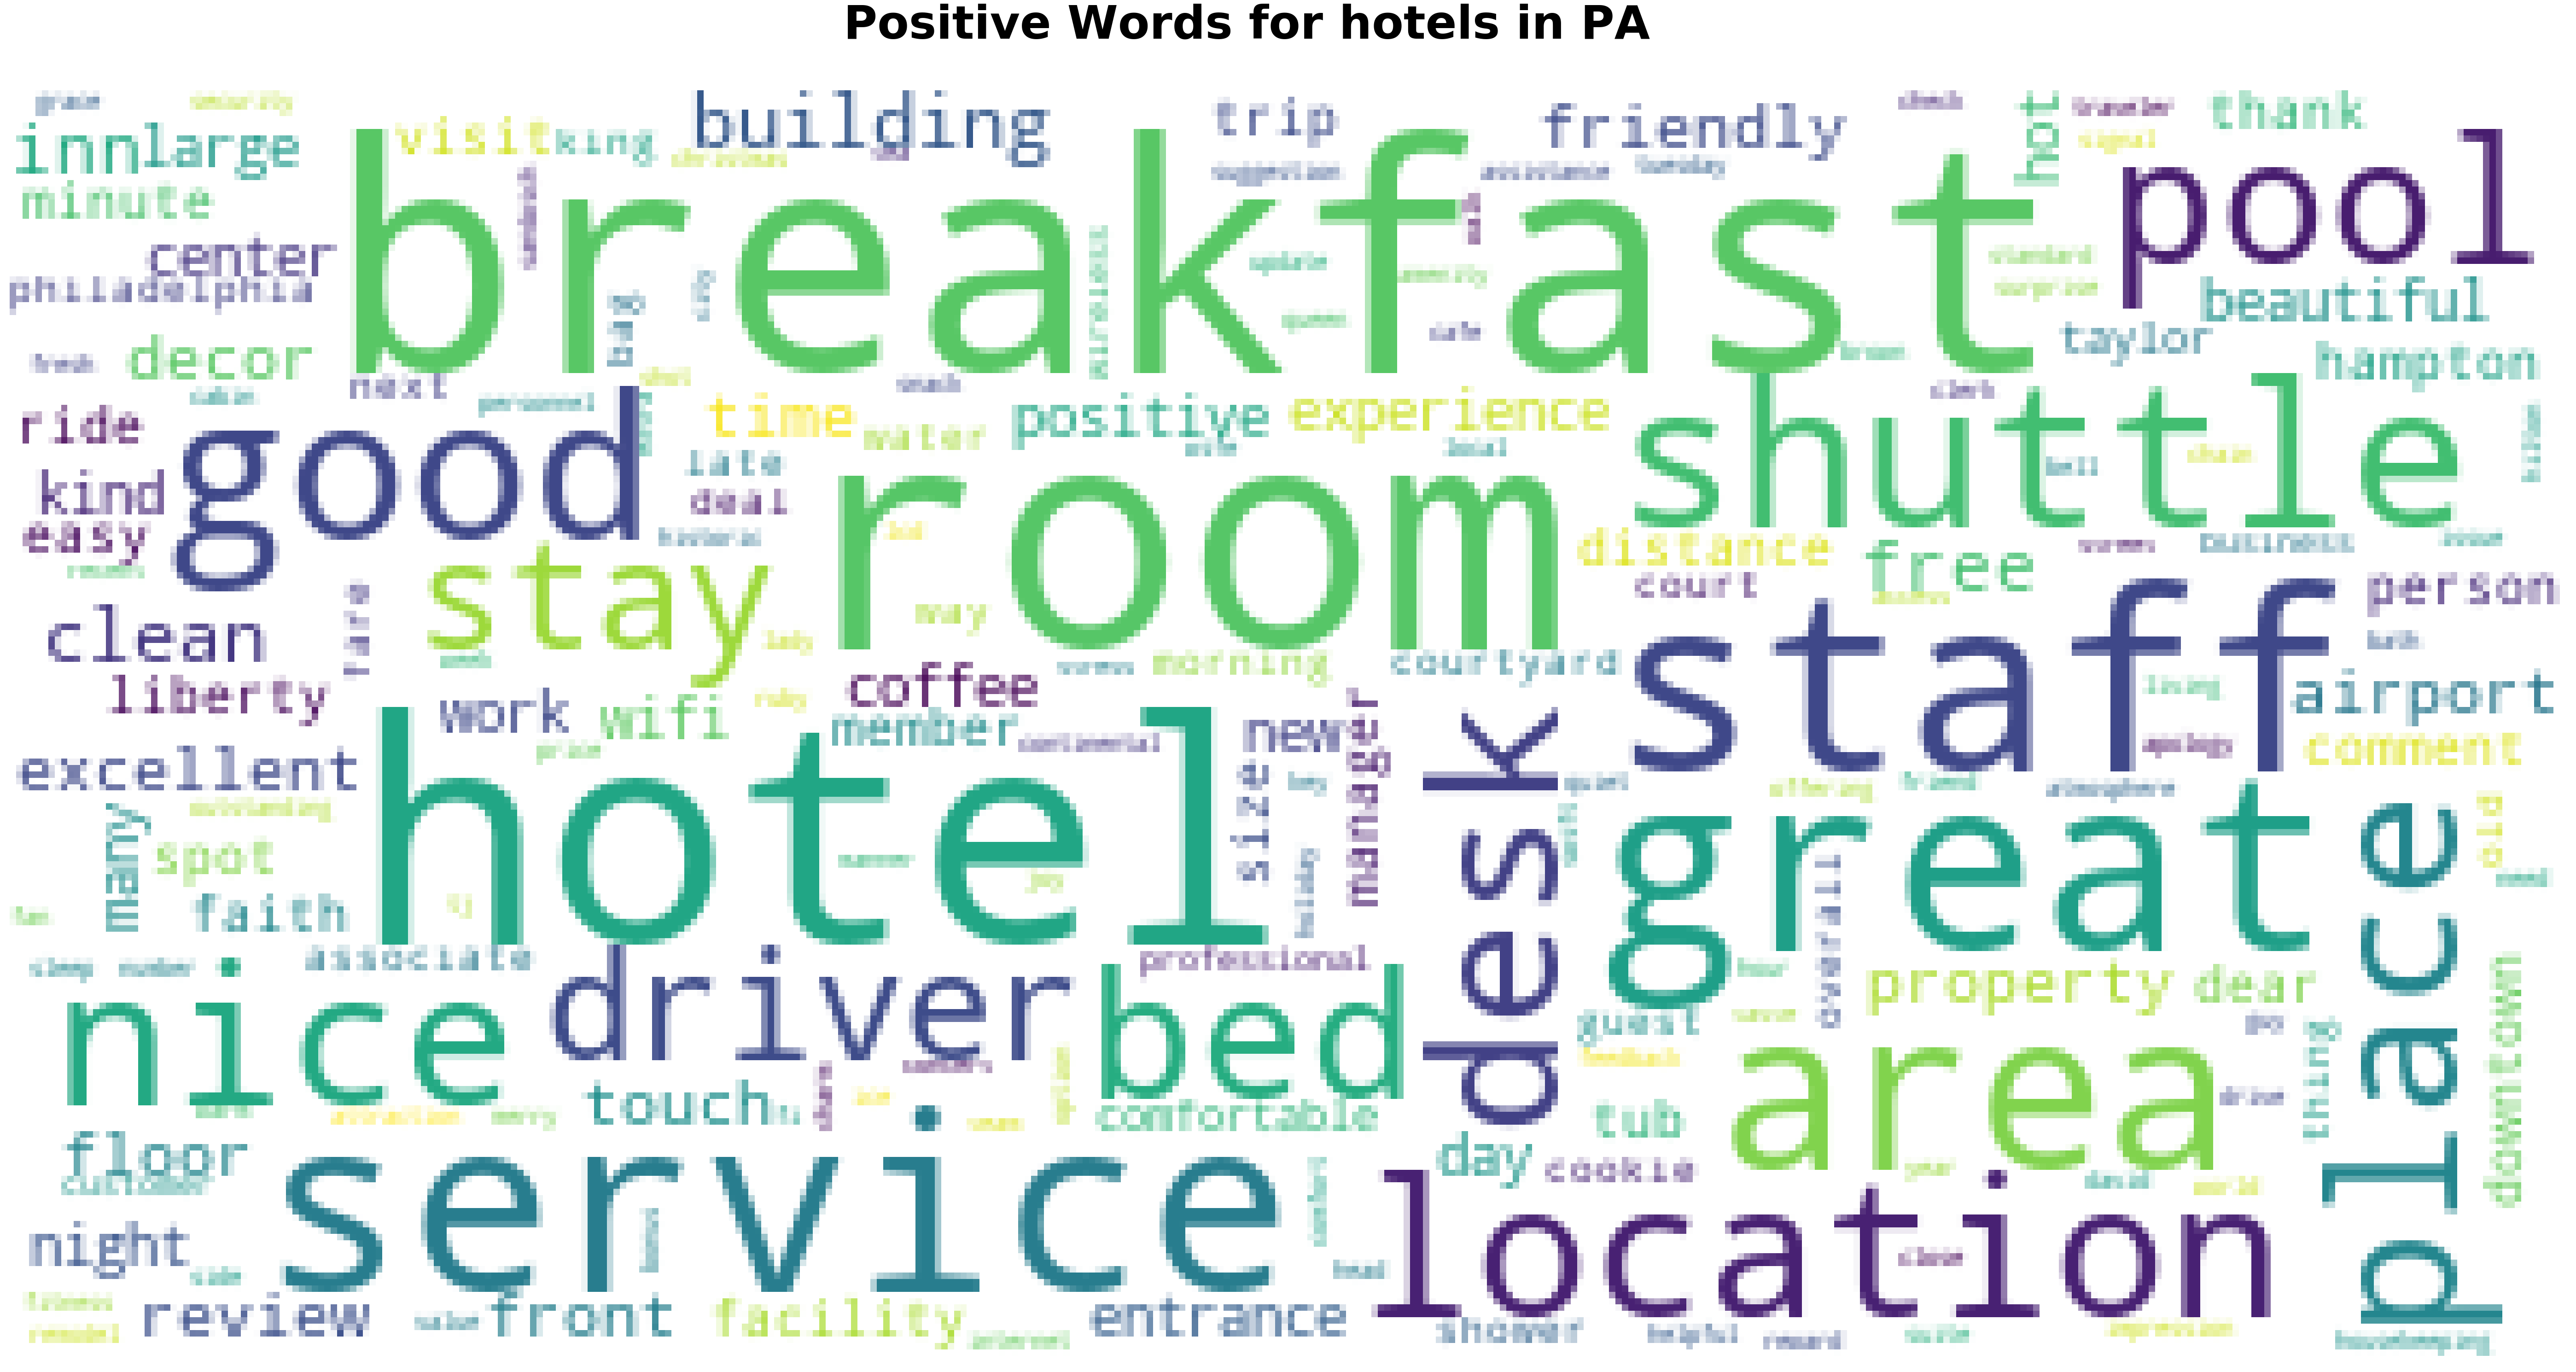

In [64]:
text_pos, text_neg = gen_text(PA_term_dict)
wc(text_pos,'white','Positive Words for hotels in PA' )

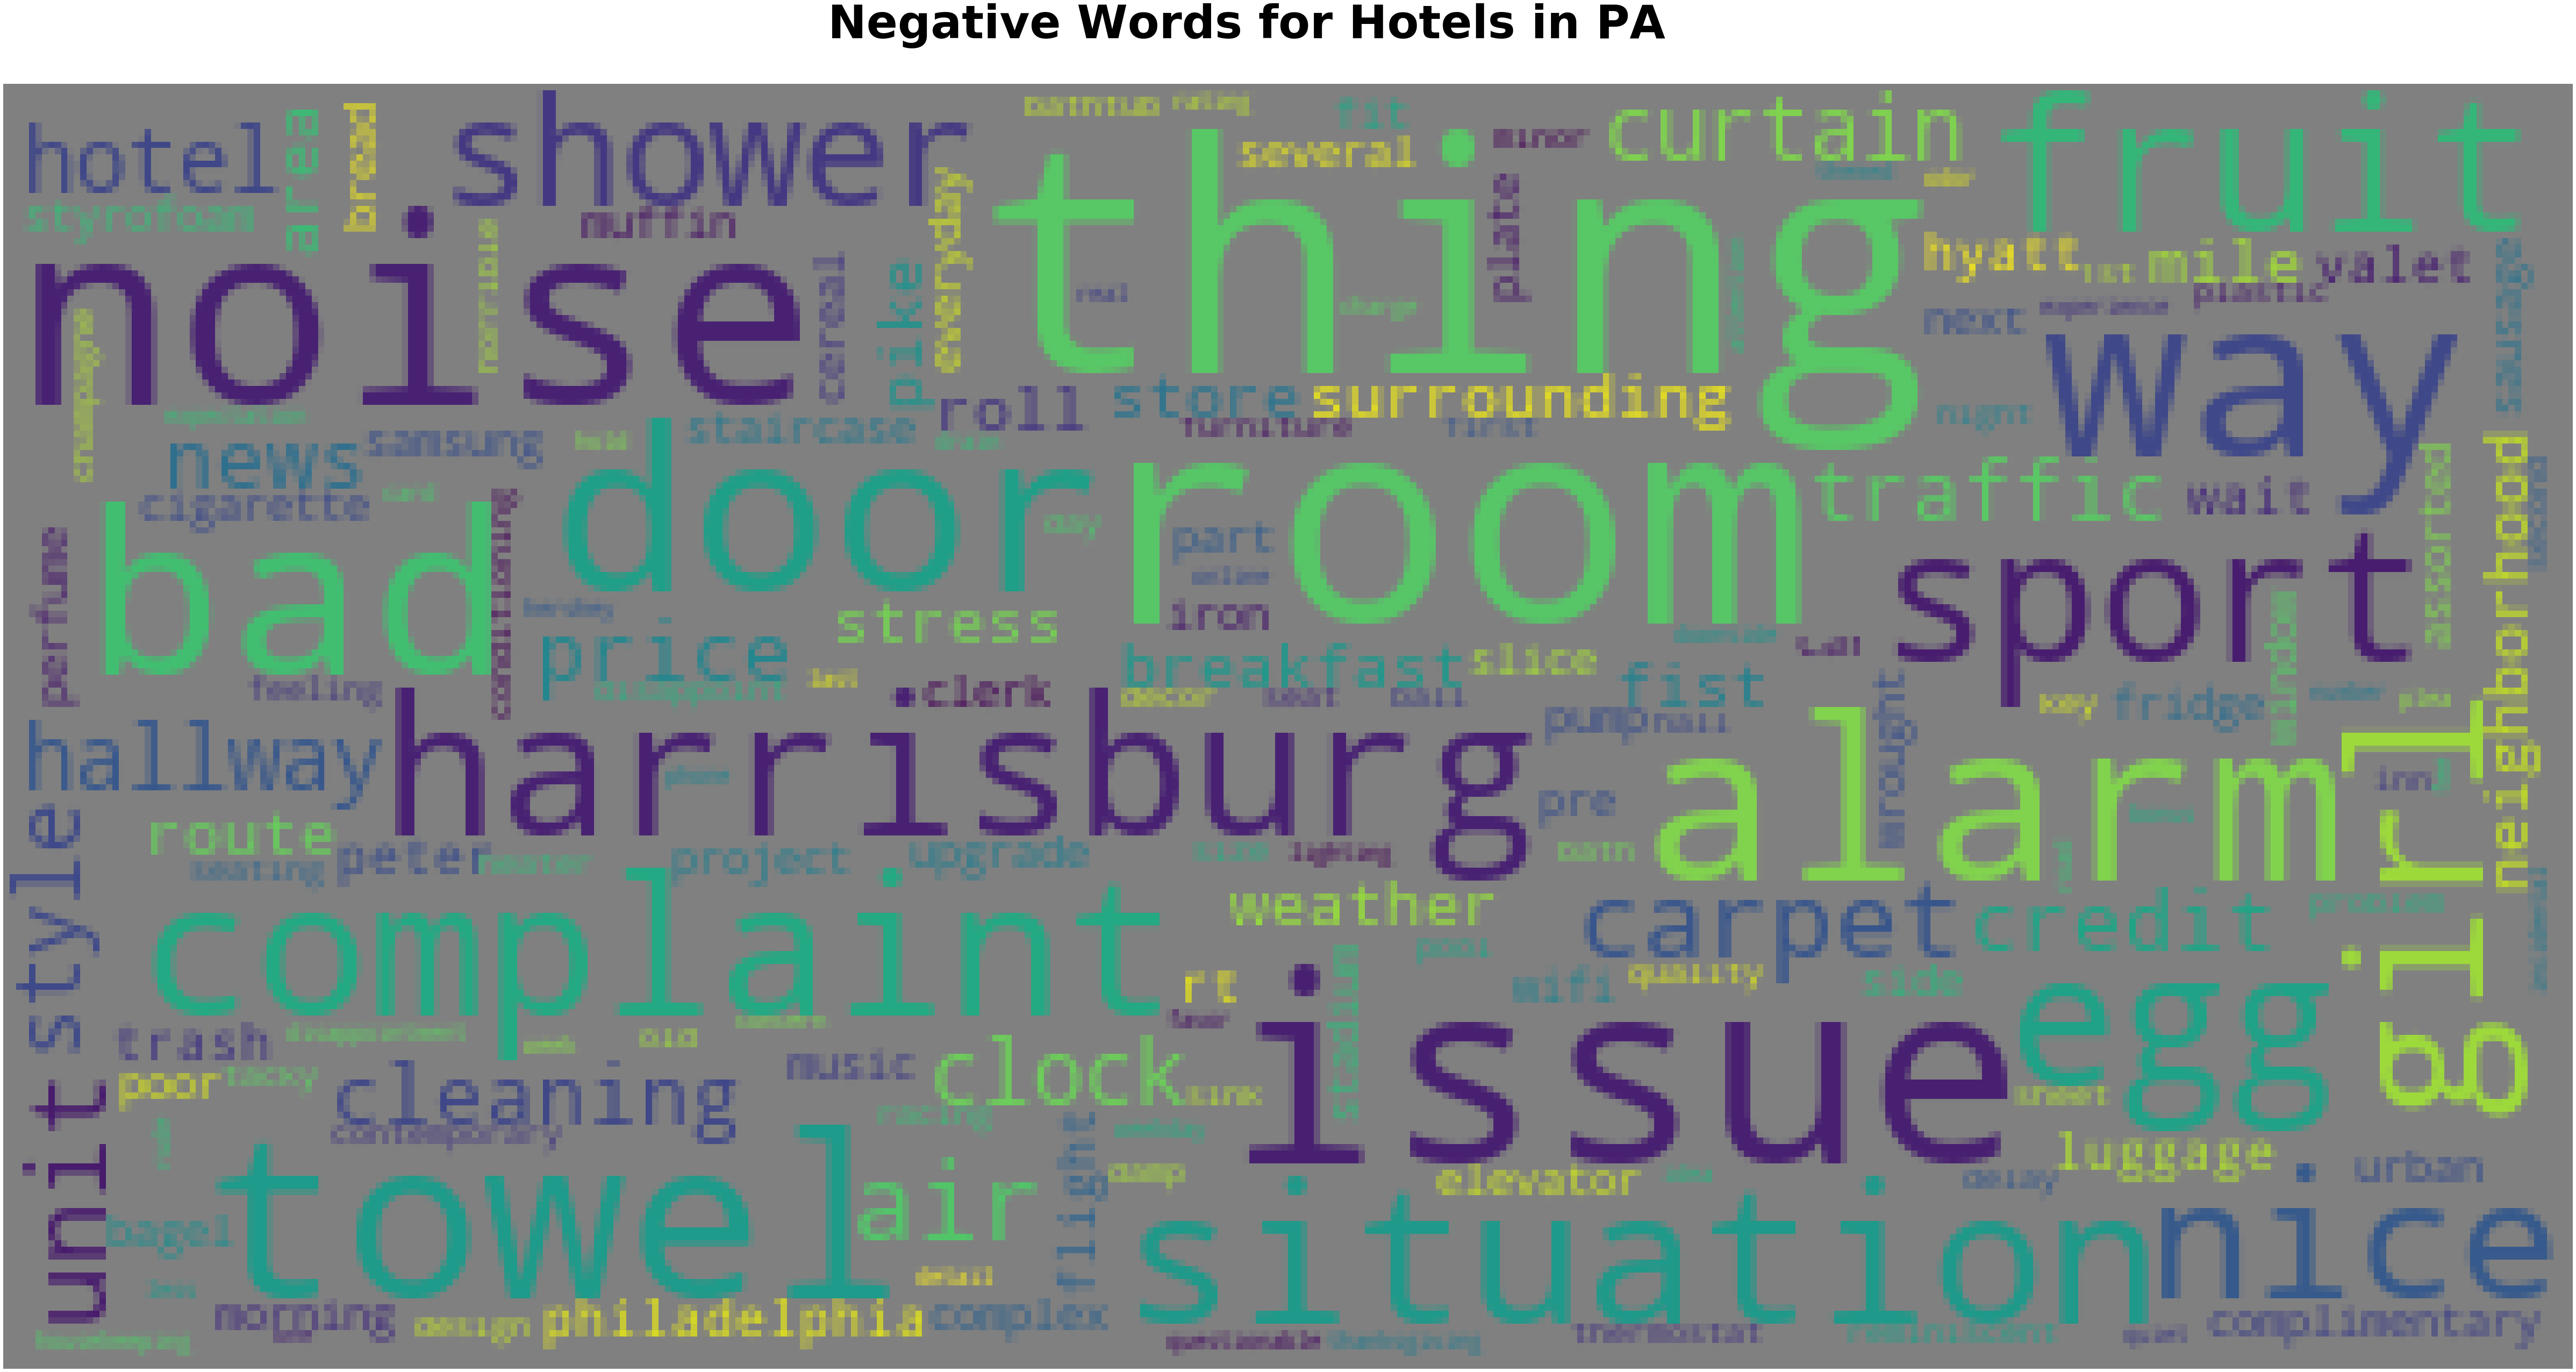

In [65]:
wc(text_neg,'grey','Negative Words for Hotels in PA' )

In [66]:
lowest = defaultdict()
highest = defaultdict()
for i in PA_term_dict:
    if PA_term_dict[i]:
        highest[i] = PA_term_dict[i].most_common()[:10]
        lowest[i] = PA_term_dict[i].most_common()[-10:]
highest_df = pd.DataFrame(highest)
lowest_df = pd.DataFrame(lowest)
lowest_df = lowest_df.drop(["OTHER"],1)
highest_df = highest_df.drop(["OTHER"],1)
highest_df

LOCATION                 CHECKIN                   FOOD  \
0          (location, 51.0)        (feedback, 29.0)      (breakfast, 80.0)   
1             (place, 20.5)              (wi fi, 9)           (food, 13.0)   
2                (view, 11)  (airport shuttle, 7.5)           (coffee, 10)   
3            (facility, 11)      (david manager, 7)   (good breakfast, 10)   
4               (park, 6.5)               (john, 7)  (free breakfast, 8.5)   
5                 (size, 5)               (wifi, 6)        (restaurant, 8)   
6               (walk, 3.5)        (christopher, 6)          (water, 7.25)   
7               (choice, 3)          (jessica, 4.5)   (quiet breakfast, 6)   
8  (convenient location, 3)              (check, 4)             (drink, 5)   
9                 (time, 3)        (faith jones, 4)   (hot breakfast, 4.5)   

                    BUILDING                   ROOMS           CLEANLINESS  \
0             (parking, 8.5)           (room, 198.0)         (amenity, 13)   
1            (property, 5.5)           (hotel, 84.0)  (clean breakfast, 6)   
2                 (floor, 3)             (bed, 37.0)          (comfort, 4)   
3       (nice entrance, 2.5)            (pool, 21.0)        (attendant, 4)   
4  (beautiful entrance, 2.5)     (hotel staff, 14.0)         (kindness, 4)   
5          (old building, 2)      (clean room, 11.0)      (clean place, 3)   
6                  (city, 2)           (lobby, 11.0)            (pride, 3)   
7       (lovely entrance, 2)  (guest expectation, 9)    (other amenity, 2)   
8       (impressive part, 2)         (bathroom, 8.5)         (attitude, 2)   
9                   (lot, 2)              (guest, 6)       (clean desk, 2)   

                VALUE                 SERVICE               BUSINESS  
0       (faith, 15.0)         (staff, 182.25)  (general manager, 12)  
1       (price, 14.0)         (service, 40.5)            (family, 7)  
2           (rate, 7)         (shuttle, 17.0)          (customer, 4)  
3          (value, 6)      (front staff, 9.0)               (job, 4)  
4        (loyalty, 5)  (excellent service, 9)       (work desk, 3.5)  
5       (option, 5.0)       (desk staff, 7.5)          (employee, 3)  
6  (faith manager, 5)             (lady, 7.5)           (success, 3)  
7           (cost, 2)   (friendly staff, 7.5)       (good desk, 2.5)  
8         (dollar, 2)       (experience, 6.5)      (retail place, 2)  
9        (opinion, 2)           (driver, 6.5)          (business, 2)

In [67]:
lowest_df

LOCATION                   CHECKIN                   FOOD  \
0    (harrisburg, -1)             (peter h, -1)           (fridge, -1)   
1          (mile, -1)               (valet, -1)          (pre egg, -1)   
2         (store, -1)                (wait, -1)      (slice fruit, -1)   
3         (route, -1)           (trash can, -1)          (sausage, -1)   
4   (surrounding, -1)                  (rt, -1)        (perfume, -1.5)   
5  (neighborhood, -1)               (clerk, -1)  (styrofoam plate, -2)   
6         (sport, -1)             (luggage, -2)     (next morning, -2)   
7   (complaint, -1.5)  (complimentary wifi, -2)  (assorted muffin, -2)   
8     (situation, -2)         (samsung fit, -2)            (bread, -2)   
9       (weather, -4)               (hyatt, -4)           (cereal, -2)   

               BUILDING                 ROOMS                  CLEANLINESS  \
0          (upgrade, 0)       (bad thing, -2)  (questionable cleaning, -1)   
1         (stadium, -1)  (shower curtain, -2)            (noise issue, -1)   
2    (several door, -1)            (ball, -2)                 (detail, -1)   
3  (iron staircase, -1)  (hallway carpet, -2)            (quiet noise, -1)   
4         (wrought, -1)    (second hotel, -2)               (lighting, -1)   
5            (door, -1)            (hall, -2)             (road noise, -1)   
6   (sport complex, -1)     (room size, -2.5)                   (odor, -1)   
7            (pump, -1)       (old towel, -3)  (housekeeping cleaning, -2)   
8        (window, -1.5)      (only thing, -4)                  (noise, -2)   
9      (elevator, -2.0)       (curtain, -5.0)               (rude way, -2)   

                 VALUE                 SERVICE                  BUSINESS  
0           (level, 1)           (concern, -1)  (professional driver, 1)  
1      (nice bonus, 0)         (attention, -1)              (company, 1)  
2            (fee, -1)              (idea, -1)              (license, 1)  
3         (number, -1)                (.5, -1)           (management, 1)  
4    (expectation, -1)   (weekday traffic, -1)          (environment, 1)  
5     (incidental, -1)           (thing, -1.5)      (business center, 1)  
6    (hotel price, -1)             (drain, -2)       (great customer, 1)  
7  (hershey price, -1)      (thanksgiving, -2)       (online rating, -1)  
8       (downside, -2)               (way, -3)              (credit, -2)  
9     (real issue, -2)  (bad experience, -3.0)         (credit card, -3)

## TN Hotel Review

In [68]:
aspect_sent, TN_term_dict = gen_dict("hotel_reviewTN.txt")
TN_df = gen_rate(aspect_sent)
TN_df

aspect      pos    neg  rate
0      LOCATION   60.750    6.5   4.6
1       CHECKIN   29.250    5.0   4.4
2          FOOD   50.000   15.5   4.1
3      BUILDING   13.500   11.5   3.2
4         ROOMS  194.000   49.5   4.2
5   CLEANLINESS   12.000   10.0   3.2
6         VALUE   17.500    0.0   5.0
7       SERVICE   79.375   10.5   4.5
8      BUSINESS   12.000    1.0   4.7
9         OTHER   23.500    9.0   3.9
10        TOTAL  491.875  118.5   4.2

In [69]:
a_series = pd. Series(['TN'] + list(TN_df['rate']), index = total_df. columns)
total_df = total_df.append(a_series, ignore_index=True)

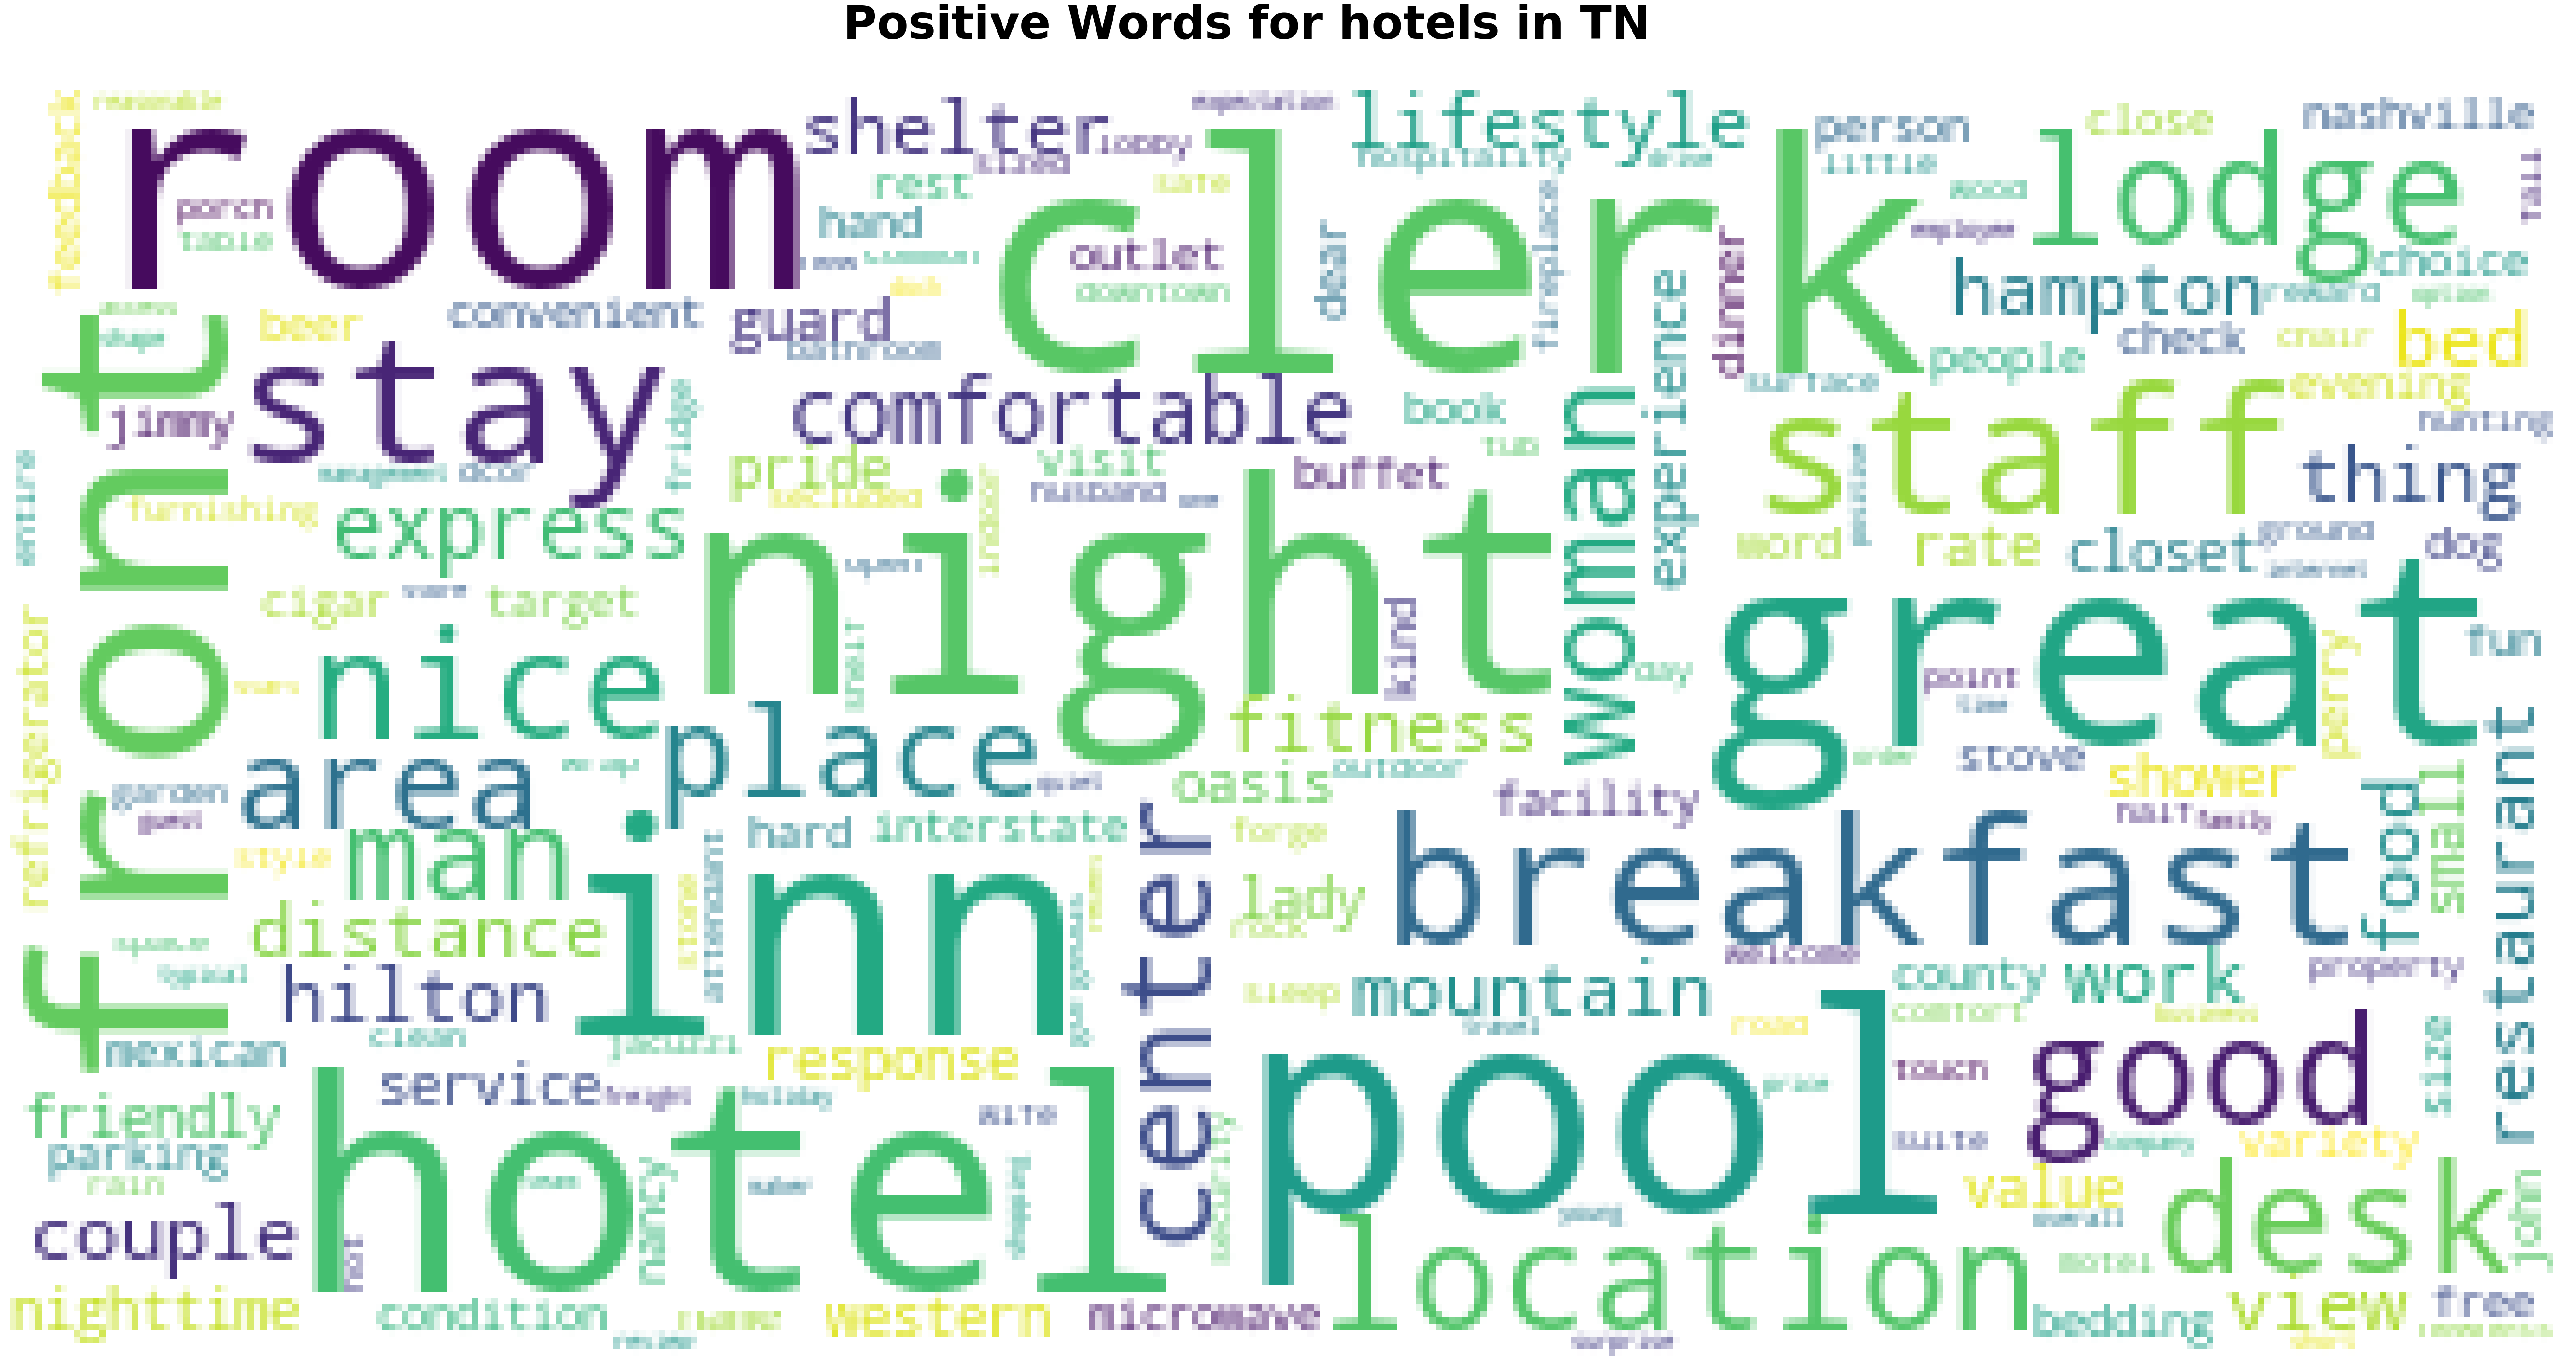

In [70]:
text_pos, text_neg = gen_text(TN_term_dict)
wc(text_pos,'white','Positive Words for hotels in TN' )

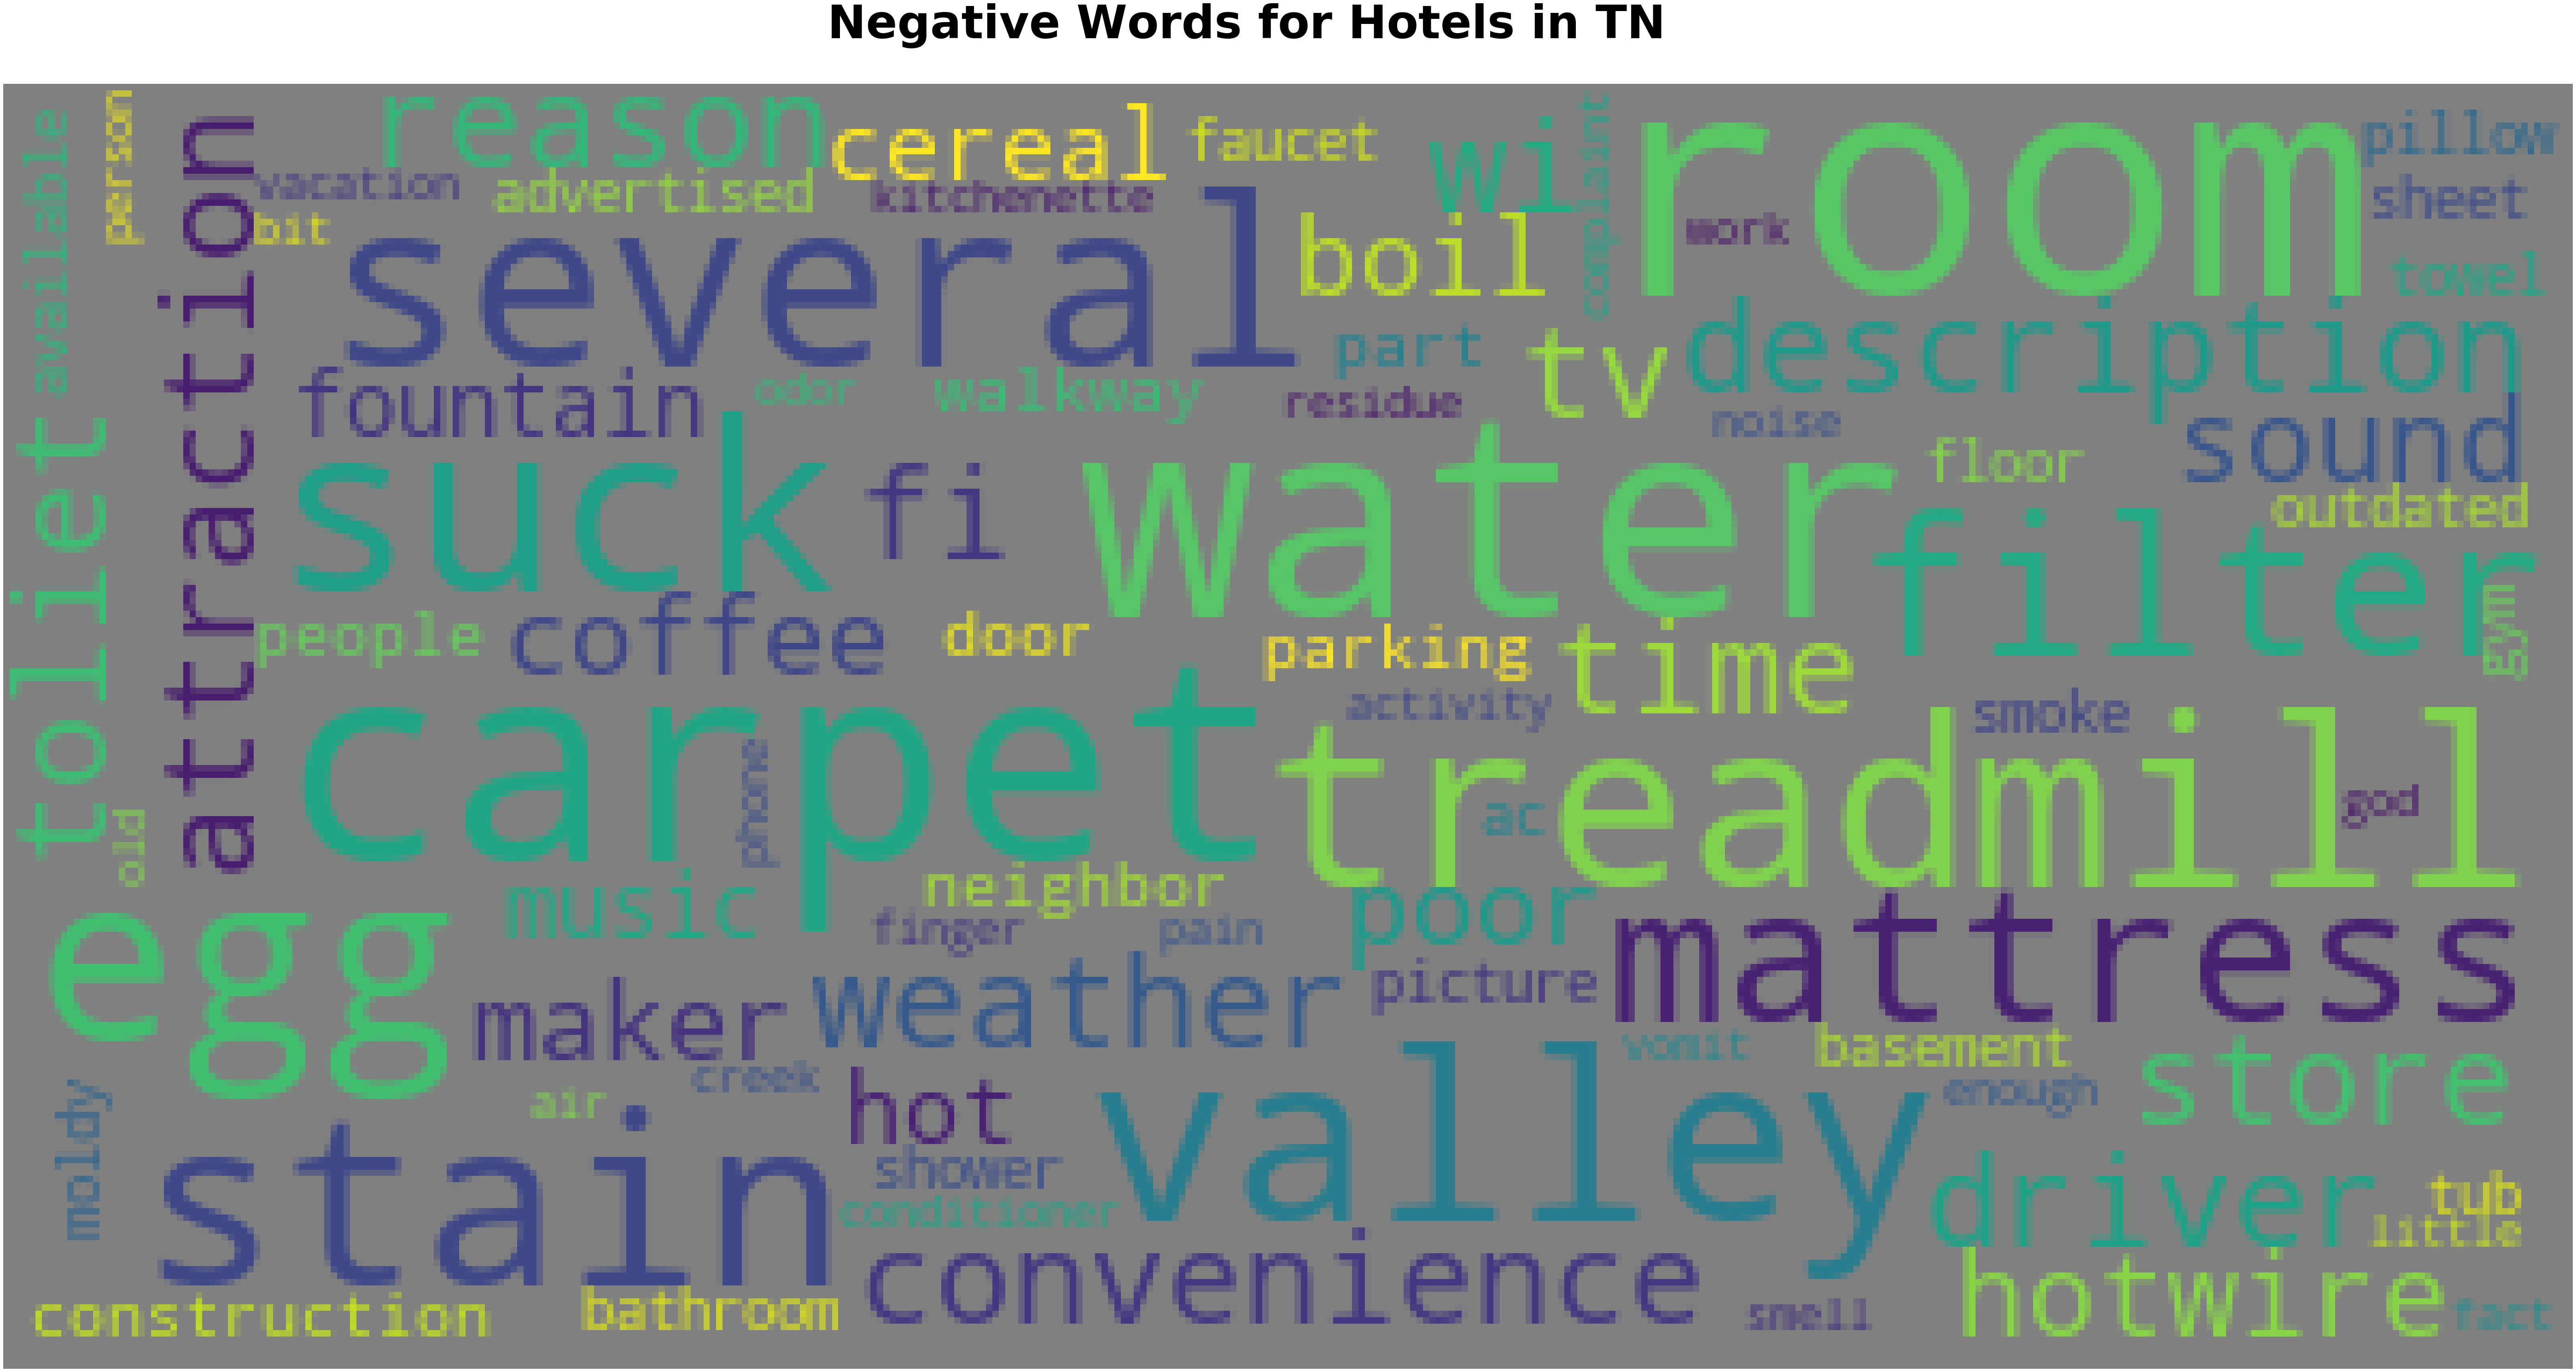

In [71]:
wc(text_neg,'grey','Negative Words for Hotels in TN' )

In [73]:
lowest = defaultdict()
highest = defaultdict()
for i in TN_term_dict:
    if TN_term_dict[i]:
        highest[i] = TN_term_dict[i].most_common()[:10]
        lowest[i] = TN_term_dict[i].most_common()[-10:]
highest_df = pd.DataFrame(highest)
lowest_df = pd.DataFrame(lowest)
lowest_df = lowest_df.drop(["OTHER"],1)
highest_df = highest_df.drop(["OTHER"],1)
highest_df

LOCATION               CHECKIN                   FOOD  \
0          (place, 10.5)           (john, 5.0)      (breakfast, 13.0)   
1         (location, 10)          (check, 3.0)          (people, 8.0)   
2          (facility, 5)       (dear perry, 3)       (microwave, 4.0)   
3            (outlet, 3)              (fun, 3)           (stove, 3.0)   
4  (great location, 2.5)      (front woman, 3)    (nice breakfast, 2)   
5           (name, 2.25)         (nancy, 2.25)  (free breakfast, 1.5)   
6         (condition, 2)              (man, 1)      (restaurant, 1.5)   
7  (close location, 1.5)           (couple, 1)   (night breakfast, 1)   
8            (rest, 1.5)             (hand, 1)      (refrigerator, 1)   
9          (choice, 1.5)  (jimmy lifestyle, 1)              (beer, 1)   

              BUILDING                   ROOMS               CLEANLINESS  \
0      (work space, 2)            (room, 36.0)                (pride, 2)   
1      (wood lodge, 2)           (hotel, 24.0)      (nighttime guard, 2)   
2         (touch, 1.5)             (bed, 12.5)       (security guard, 2)   
3           (forge, 1)     (hotel staff, 11.0)              (newness, 1)   
4          (ground, 1)  (comfortable bed, 4.5)            (attendant, 1)   
5      (furnishing, 1)     (outdoor pool, 4.0)              (fitness, 1)   
6    (new property, 1)       (front desk, 3.5)              (surface, 1)   
7  (downtown clerk, 1)        (hampton inn, 3)         (little thing, 1)   
8      (rock chair, 1)         (desk woman, 3)          (great pride, 1)   
9           (porch, 1)     (sized fridge, 3.0)  (conditioner filter, -1)   

                     VALUE                SERVICE                   BUSINESS  
0             (price, 4.0)        (staff, 35.375)            (employee, 3.5)  
1       (great value, 2.5)      (desk staff, 6.5)  (management company, 1.5)  
2          (quiet rate, 2)  (friendly staff, 4.0)               (freight, 1)  
3     (reasonable rate, 2)     (front staff, 3.5)           (small maker, 1)  
4               (night, 1)               (man, 3)                (family, 1)  
5               (value, 1)              (stay, 3)              (business, 1)  
6        (reward point, 1)            (access, 2)       (shopping center, 1)  
7               (shelf, 1)   (review response, 2)          (good western, 1)  
8         (expectation, 1)       (young man, 1.5)           (small store, 1)  
9  (overall experience, 1)   (guest service, 1.5)             (activity, -1)

In [74]:
lowest_df

LOCATION               CHECKIN                  FOOD  \
0                (view, 1)          (hampton, 1)      (hospitality, 1)   
1           (pool area, 1)           (hilton, 1)           (water, -1)   
2       (mountain view, 1)      (front clerk, 1)    (coffee maker, -1)   
3  (several attraction, 0)  (nashville clerk, 1)  (poor treadmill, -1)   
4   (convenience store, 0)            (wi fi, 0)        (boil egg, -1)   
5             (driver, -1)     (suck valley, -1)   (water sound, -1.5)   
6        (only reason, -1)            (suck, -1)          (cereal, -2)   
7               (time, -1)          (toliet, -1)             (egg, -2)   
8            (weather, -1)              (tv, -1)  (fountain music, -2)   
9      (description, -1.5)         (hotwire, -1)       (hot water, -3)   

               BUILDING                       ROOMS               CLEANLINESS  \
0       (rock chair, 1)                (pillow, -1)              (fitness, 1)   
1            (porch, 1)           (kitchenette, -1)              (surface, 1)   
2             (road, 1)                  (fact, -1)         (little thing, 1)   
3         (walkway, -1)  (advertised picture, -1.5)          (great pride, 1)   
4  (several people, -1)          (stain carpet, -2)  (conditioner filter, -1)   
5            (part, -1)                    (ac, -2)          (air filter, -1)   
6            (door, -1)                 (towel, -2)                (odor, -1)   
7      (neighbor, -1.5)                 (sheet, -2)       (vomit residue, -1)   
8         (parking, -3)                   (gym, -3)               (noise, -3)   
9    (construction, -3)           (room carpet, -3)               (smell, -3)   

                     VALUE               SERVICE                   BUSINESS  
0       (great value, 2.5)    (recent travel, 1)            (employee, 3.5)  
1          (quiet rate, 2)             (team, 1)  (management company, 1.5)  
2     (reasonable rate, 2)            (woman, 1)               (freight, 1)  
3               (night, 1)  (holiday express, 1)           (small maker, 1)  
4               (value, 1)         (internet, 1)                (family, 1)  
5        (reward point, 1)           (lady, 0.5)              (business, 1)  
6               (shelf, 1)    (creek valley, -1)       (shopping center, 1)  
7         (expectation, 1)     (work person, -1)          (good western, 1)  
8  (overall experience, 1)           (phone, -1)           (small store, 1)  
9              (option, 1)   (old treadmill, -2)             (activity, -1)

## TX Hotel Review

In [75]:
aspect_sent, TX_term_dict = gen_dict("hotel_reviewTX.txt")
TX_df = gen_rate(aspect_sent)
TX_df

aspect     pos     neg  rate
0      LOCATION   361.5   36.50   4.6
1       CHECKIN   192.0   33.00   4.4
2          FOOD   430.5   40.00   4.7
3      BUILDING   137.5   58.25   3.8
4         ROOMS  1068.5  249.00   4.2
5   CLEANLINESS   127.5   54.00   3.8
6         VALUE    93.0   12.50   4.5
7       SERVICE   646.5   76.75   4.6
8      BUSINESS   108.0    9.00   4.7
9         OTHER   298.5   52.50   4.4
10        TOTAL  3463.5  621.50   4.4

In [76]:
a_series = pd. Series(['TX'] + list(TX_df['rate']), index = total_df. columns)
total_df = total_df.append(a_series, ignore_index=True)

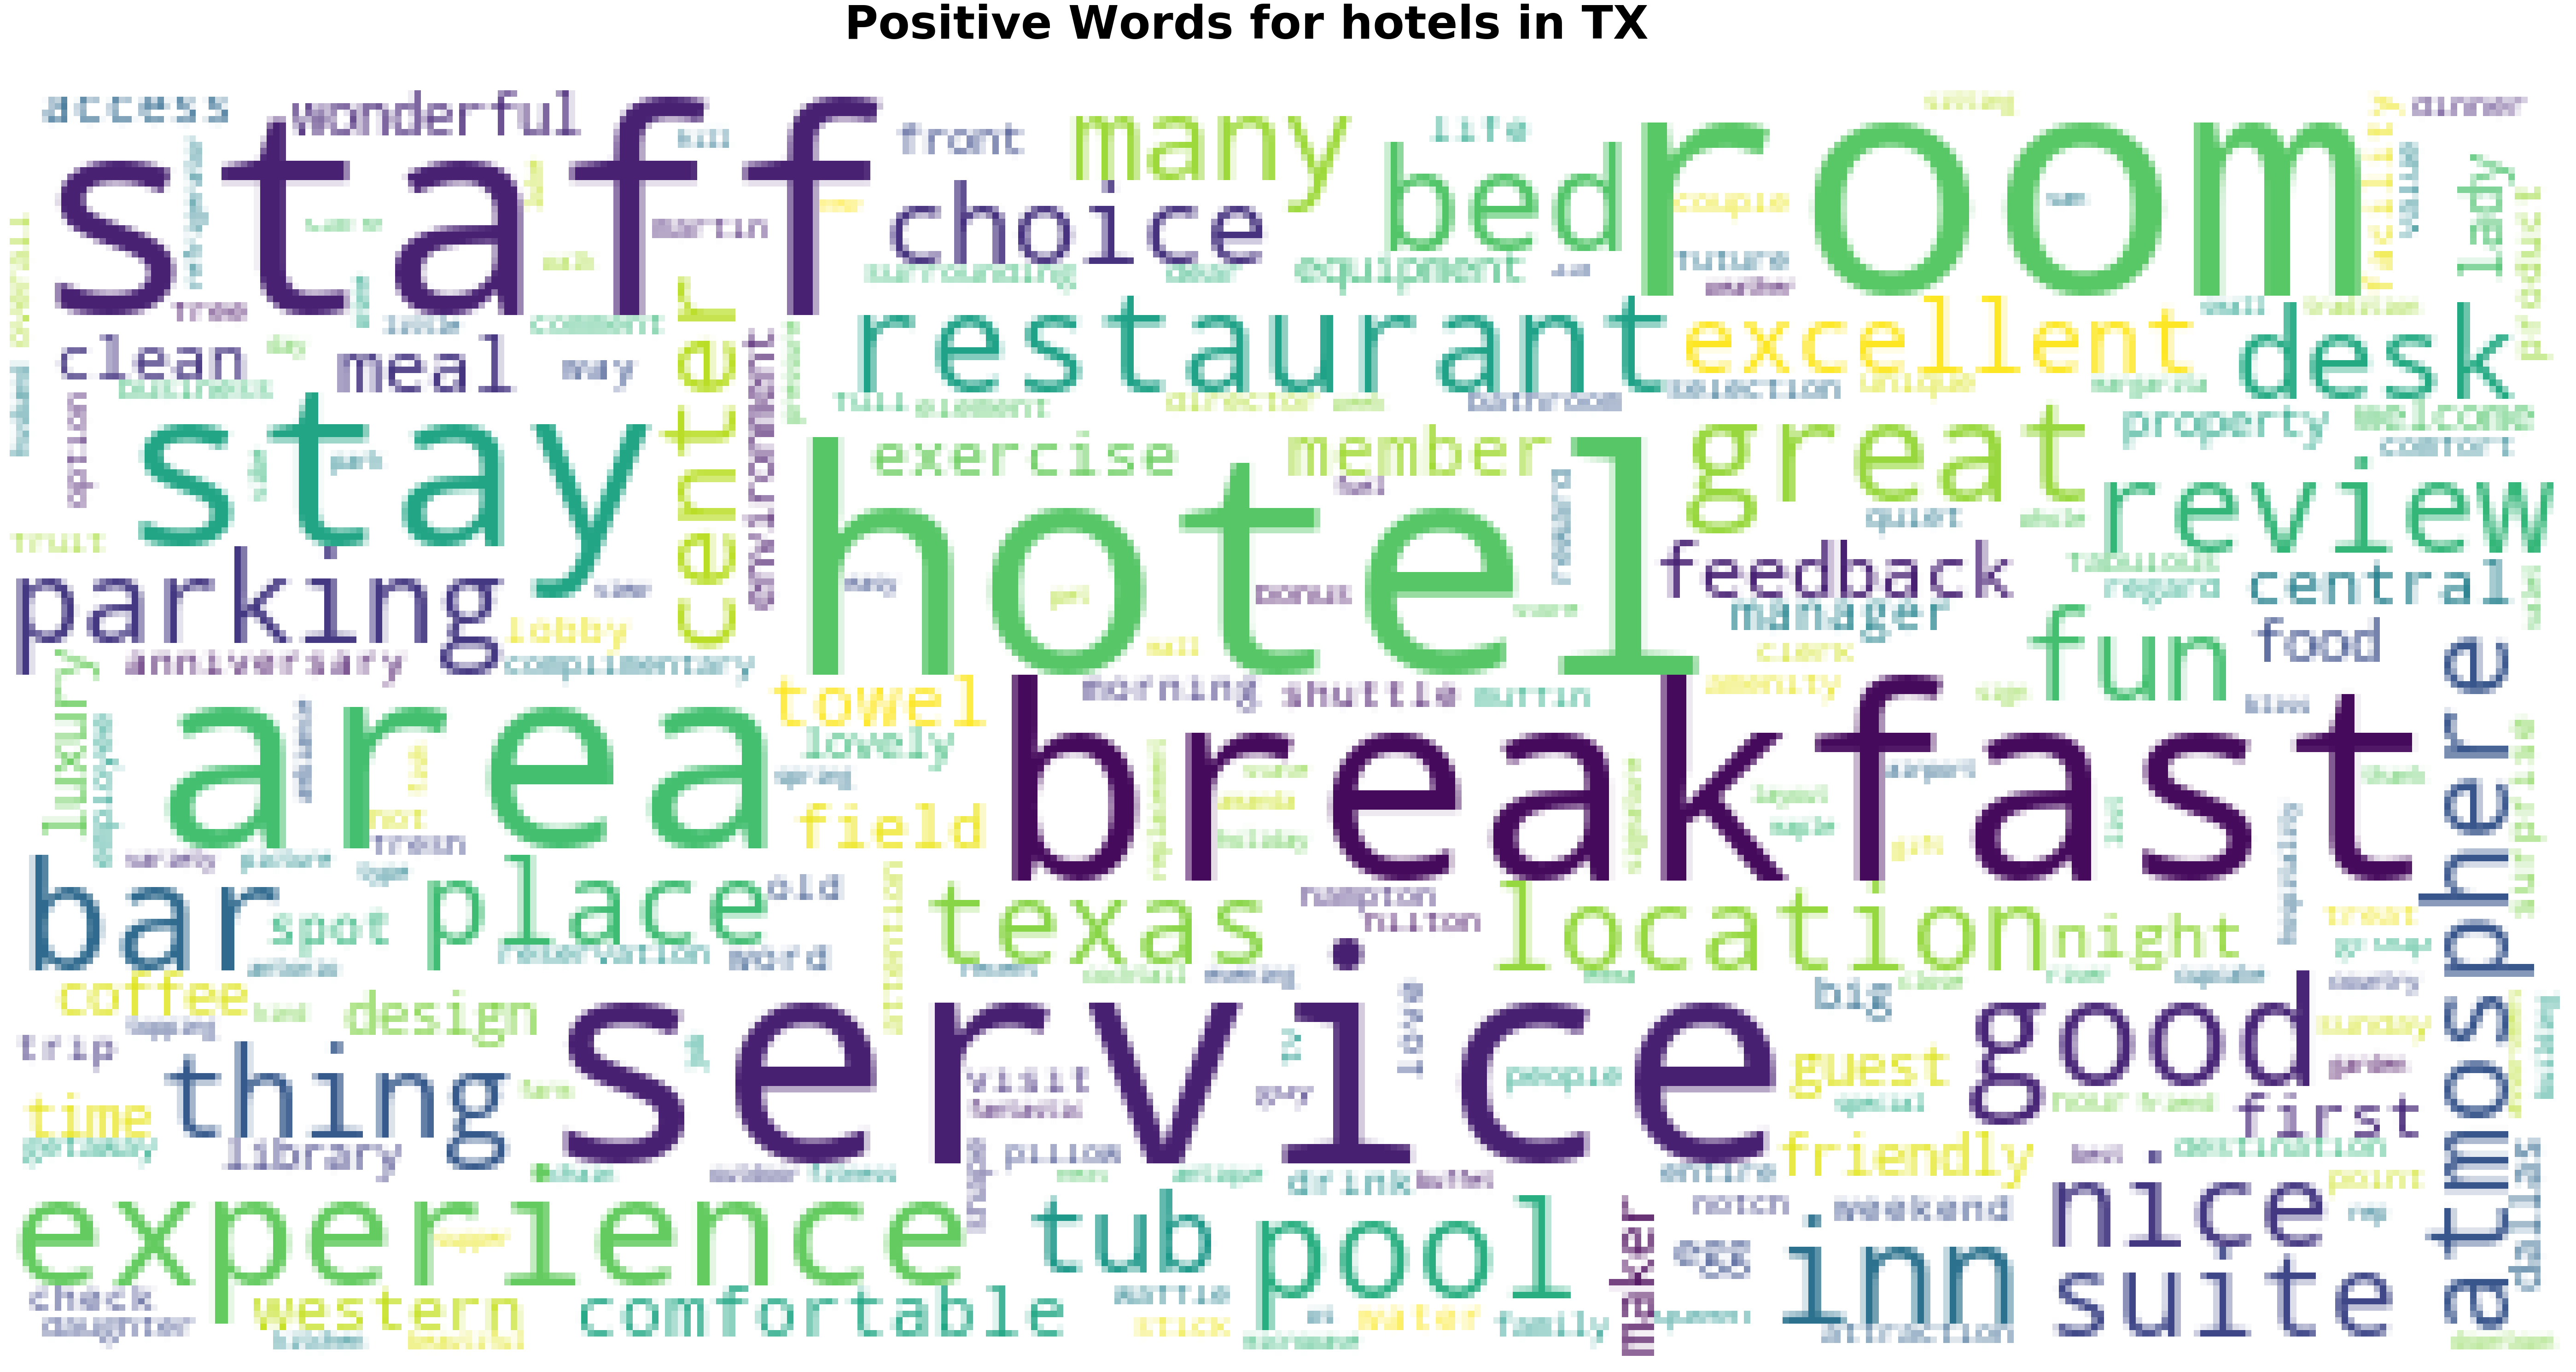

In [77]:
text_pos, text_neg = gen_text(TX_term_dict)
wc(text_pos,'white','Positive Words for hotels in TX' )

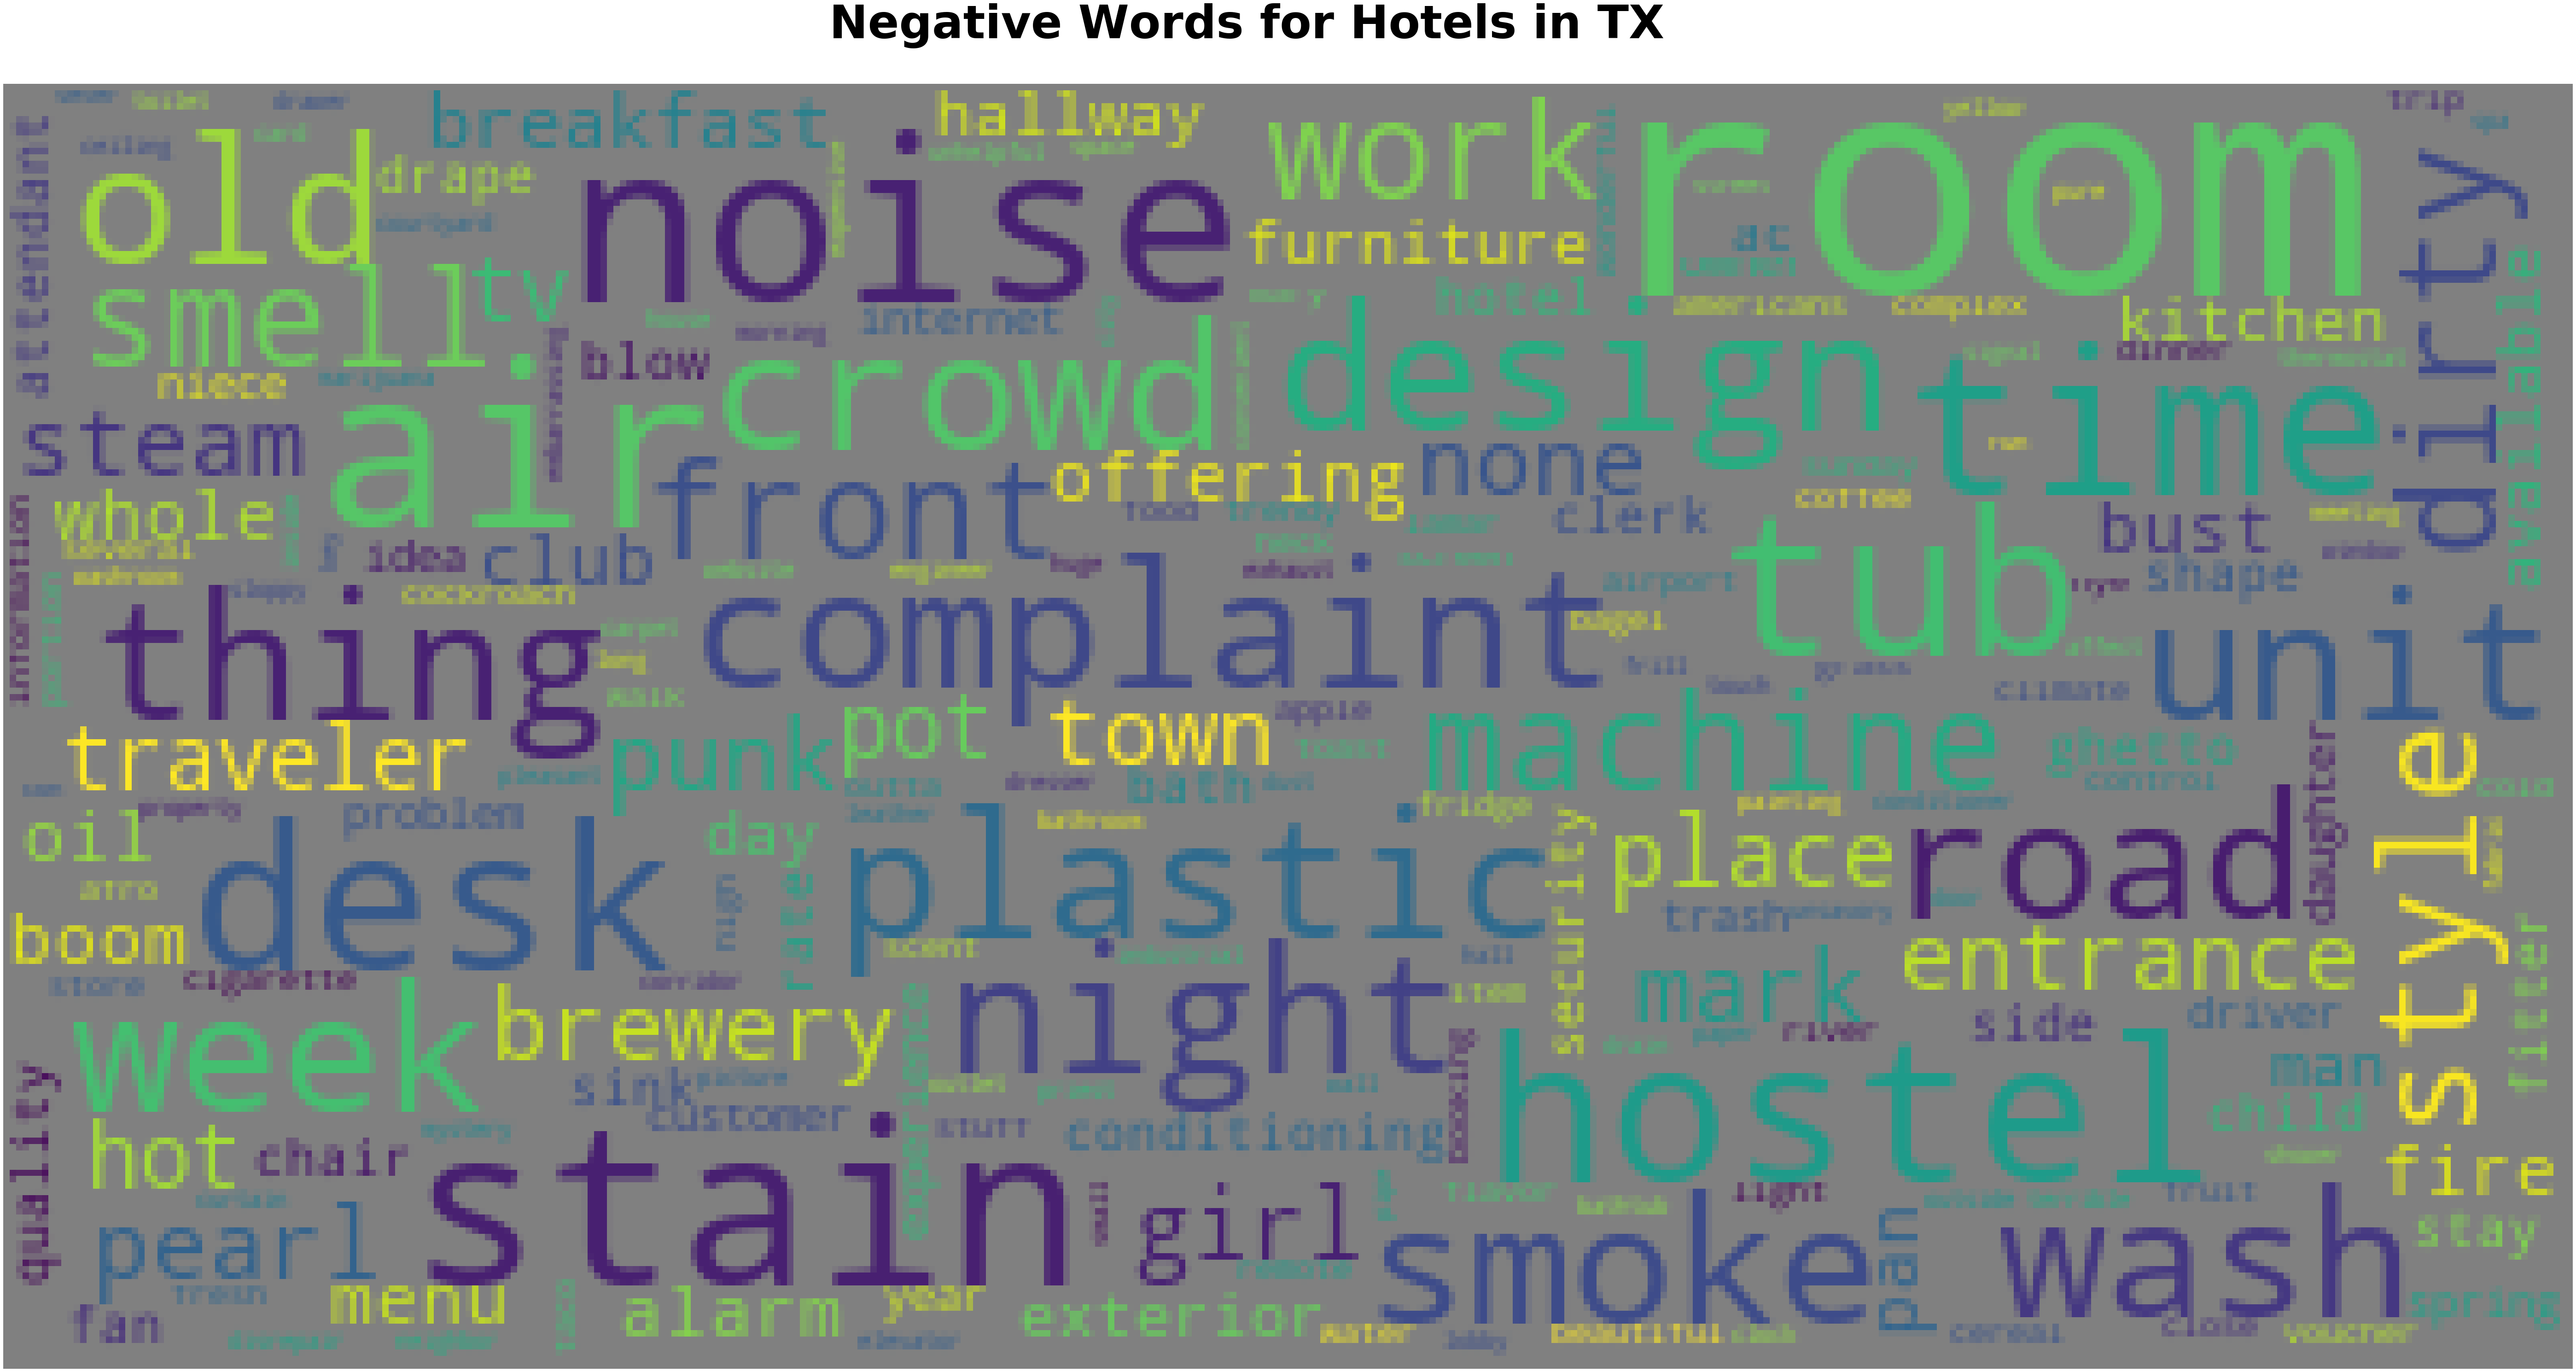

In [78]:
wc(text_neg,'grey','Negative Words for Hotels in TX' )

In [79]:
lowest = defaultdict()
highest = defaultdict()
for i in TX_term_dict:
    if TX_term_dict[i]:
        highest[i] = TX_term_dict[i].most_common()[:10]
        lowest[i] = TX_term_dict[i].most_common()[-10:]
highest_df = pd.DataFrame(highest)
lowest_df = pd.DataFrame(lowest)
lowest_df = lowest_df.drop(["VALUE"],1)
highest_df = highest_df.drop(["VALUE"],1)
highest_df

LOCATION                CHECKIN  \
0          (location, 66.5)         (feedback, 25)   
1             (place, 40.0)       (kind word, 5.0)   
2         (pool area, 12.5)  (jamie director, 4.5)   
3              (area, 12.0)         (lindsey, 4.5)   
4              (choice, 10)              (emma, 4)   
5              (visit, 9.5)         (fun bar, 3.5)   
6  (nearby restaurant, 8.5)      (online check, 3)   
7               (size, 8.5)              (look, 3)   
8               (vibe, 8.0)              (wifi, 3)   
9             (ambiance, 6)          (checkout, 3)   

                           FOOD               BUILDING                ROOMS  \
0             (breakfast, 79.5)      (property, 14.75)        (room, 245.5)   
1                  (food, 34.0)        (parking, 10.5)      (hotel, 162.75)   
2            (restaurant, 22.5)        (building, 8.5)         (bed, 61.25)   
3                  (coffee, 11)         (library, 8.5)     (hotel emma, 23)   
4                (dinner, 10.5)               (lot, 7)  (hotel staff, 18.0)   
5                    (water, 8)          (design, 4.5)          (bar, 17.5)   
6             (atmosphere, 7.5)      (architecture, 4)         (pool, 10.0)   
7                 (people, 7.5)  (delight design, 3.5)     (dear guest, 10)   
8                  (drink, 4.5)  (friendly parking, 3)    (clean room, 8.5)   
9  (continental breakfast, 4.5)         (bomb fire, 3)         (decor, 7.5)   

                 CLEANLINESS                  SERVICE            BUSINESS  \
0              (amenity, 21)           (staff, 235.0)           (job, 16)   
1          (cleanliness, 14)          (service, 62.5)    (employee, 10.0)   
2         (friendliness, 11)       (experience, 34.5)       (business, 7)   
3         (helpfulness, 8.5)           (greeting, 16)        (owner, 5.0)   
4                (regard, 6)             (stay, 13.0)     (management, 5)   
5               (comfort, 6)     (friendly staff, 11)    (environment, 5)   
6          (housekeeping, 4)    (shuttle driver, 8.5)         (parent, 5)   
7            (turndown, 3.0)       (notch service, 6)       (future, 5.0)   
8     (welcome amenity, 3.0)     (shuttle service, 6)  (farmer market, 4)   
9  (excellent atmosphere, 3)  (customer service, 5.5)         (family, 3)   

             OTHER  
0     (stay, 64.5)  
1     (time, 18.0)  
2  (husband, 11.5)  
3      (review, 8)  
4   (attention, 7)  
5         (way, 7)  
6       (input, 7)  
7  (first time, 5)  
8       (notch, 5)  
9     (comment, 5)

In [80]:
lowest_df

LOCATION                  CHECKIN               FOOD  \
0         (plastic, -1)      (road traveler, -1)     (cold air, -1)   
1            (mark, -1)         (hot sunday, -1)     (oil boom, -1)   
2  (close entrance, -1)               (trip, -1)  (other stuff, -1)   
3           (crowd, -1)  (wonderful airport, -1)    (cigarette, -1)   
4       (town girl, -1)            (voucher, -1)         (taco, -1)   
5            (town, -1)              (nye, -1.5)          (pan, -1)   
6          (none, -1.5)         (steam punk, -2)          (pot, -1)   
7           (scent, -2)          (tv remote, -2)   (coffee pot, -3)   
8          (flavor, -2)          (screen tv, -2)       (fridge, -4)   
9           (light, -4)     (afro americans, -4)    (hot water, -4)   

             BUILDING                   ROOMS                CLEANLINESS  \
0   (punk design, -2)            (c unit, -3)              (problem, -2)   
1  (steam design, -2)           (hallway, -3)              (weekend, -2)   
2      (elevator, -2)       (alarm clock, -3)              (request, -2)   
3    (night club, -2)     (conditioner, -3.0)           (road noise, -2)   
4          (fire, -2)  (available hostel, -3)         (foul smell, -2.5)   
5      (neighbor, -2)          (mirror, -3.0)               (wash, -2.5)   
6      (entrance, -2)              (sink, -3)              (noise, -2.5)   
7       (outside, -2)              (girl, -4)                (trash, -3)   
8        (door, -3.0)          (downfall, -4)  (noise disturbance, -4.5)   
9          (dust, -3)                 (c, -6)                (smell, -5)   

                        SERVICE                    BUSINESS  \
0                (manger, -1.5)            (credit card, 1)   
1            (stream video, -2)              (partner, 0.5)   
2           (inconvenience, -2)  (welcoming personality, 0)   
3                 (silence, -2)          (owner desk, -0.5)   
4                     (ice, -2)           (work desk, -0.5)   
5                  (zipper, -2)              (computer, -1)   
6                   (child, -2)     (business traveler, -1)   
7                   (phone, -2)           (work family, -1)   
8  (internet connection, -2.25)            (customer, -1.5)   
9             (surly man, -5.0)            (owner wife, -2)   

                  OTHER  
0            (none, -1)  
1      (background, -1)  
2       (highway, -1.5)  
3          (spring, -2)  
4            (hand, -2)  
5  (only complaint, -2)  
6         (problem, -2)  
7    (other driver, -2)  
8      (van driver, -2)  
9    (confirmation, -2)

## VA Hotel Review

In [81]:
aspect_sent, VA_term_dict = gen_dict("hotel_reviewVA.txt")
VA_df = gen_rate(aspect_sent)
VA_df

aspect    pos   neg  rate
0      LOCATION   53.5  11.0   4.3
1       CHECKIN   26.5   2.0   4.7
2          FOOD   84.5  14.0   4.4
3      BUILDING   26.5   5.0   4.4
4         ROOMS  222.5  25.0   4.6
5   CLEANLINESS   10.0   4.0   3.9
6         VALUE   13.0   2.0   4.5
7       SERVICE  121.5   6.0   4.8
8      BUSINESS   17.0   2.0   4.6
9         OTHER   36.0   5.0   4.5
10        TOTAL  611.0  76.0   4.6

In [82]:
a_series = pd. Series(['VA'] + list(VA_df['rate']), index = total_df. columns)
total_df = total_df.append(a_series, ignore_index=True)

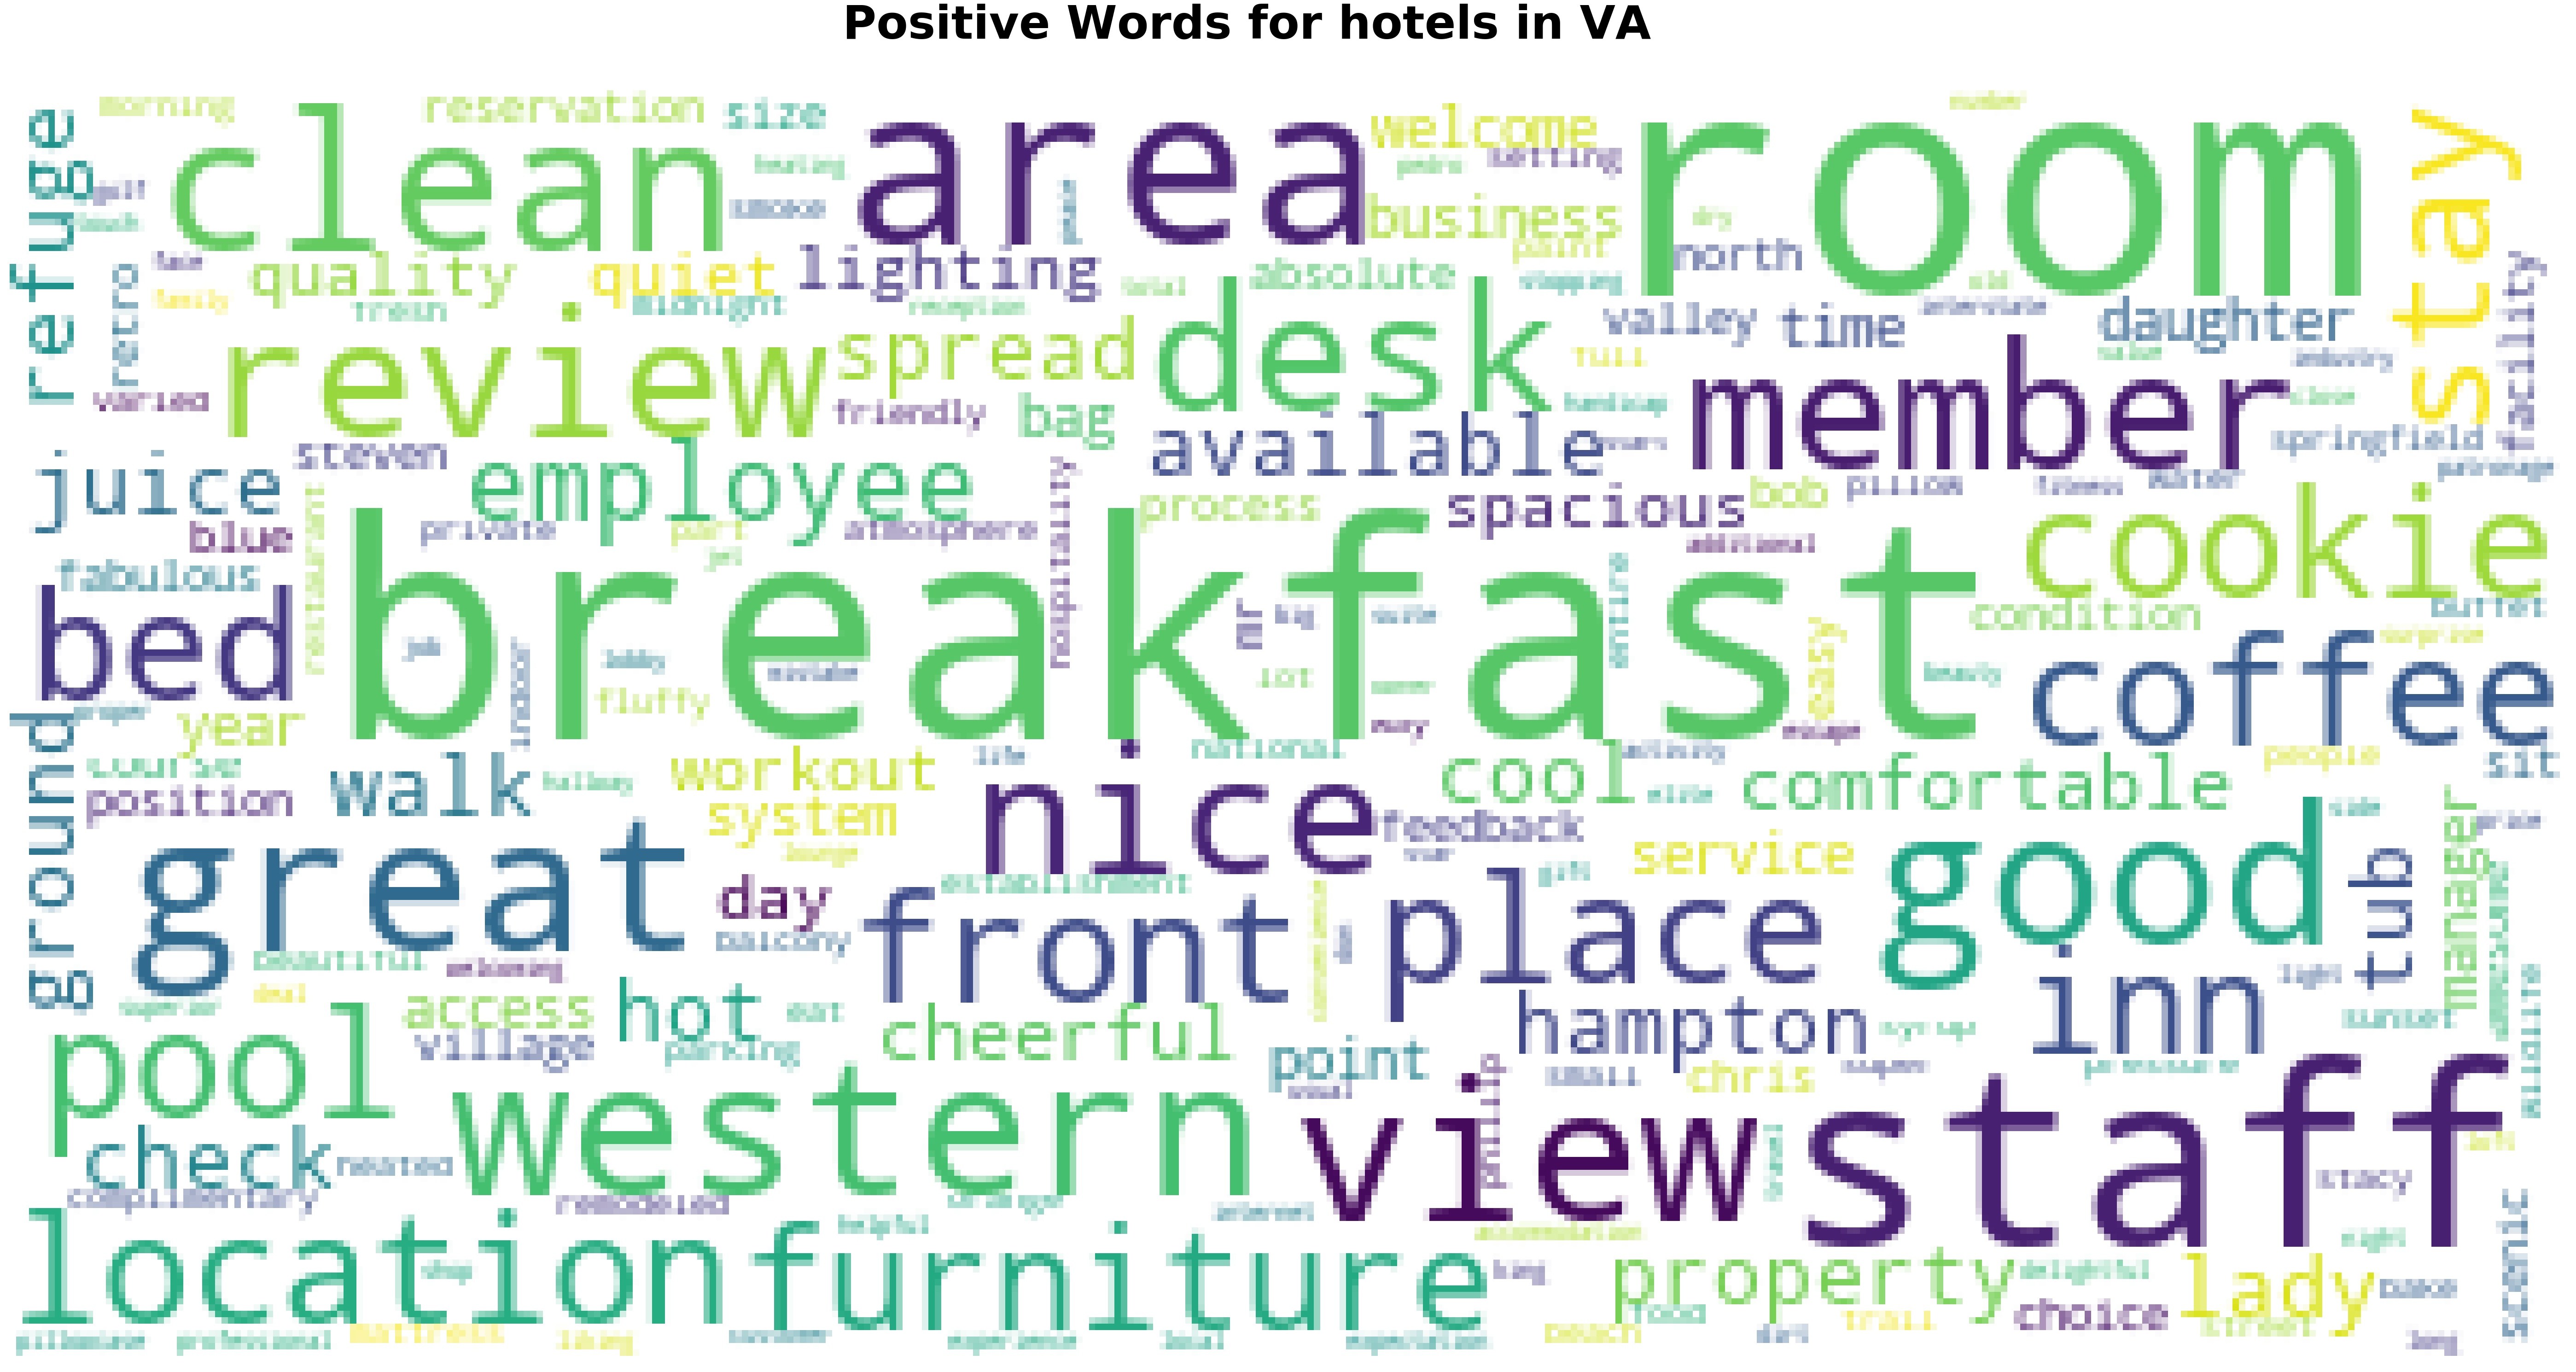

In [83]:
text_pos, text_neg = gen_text(VA_term_dict)
wc(text_pos,'white','Positive Words for hotels in VA' )

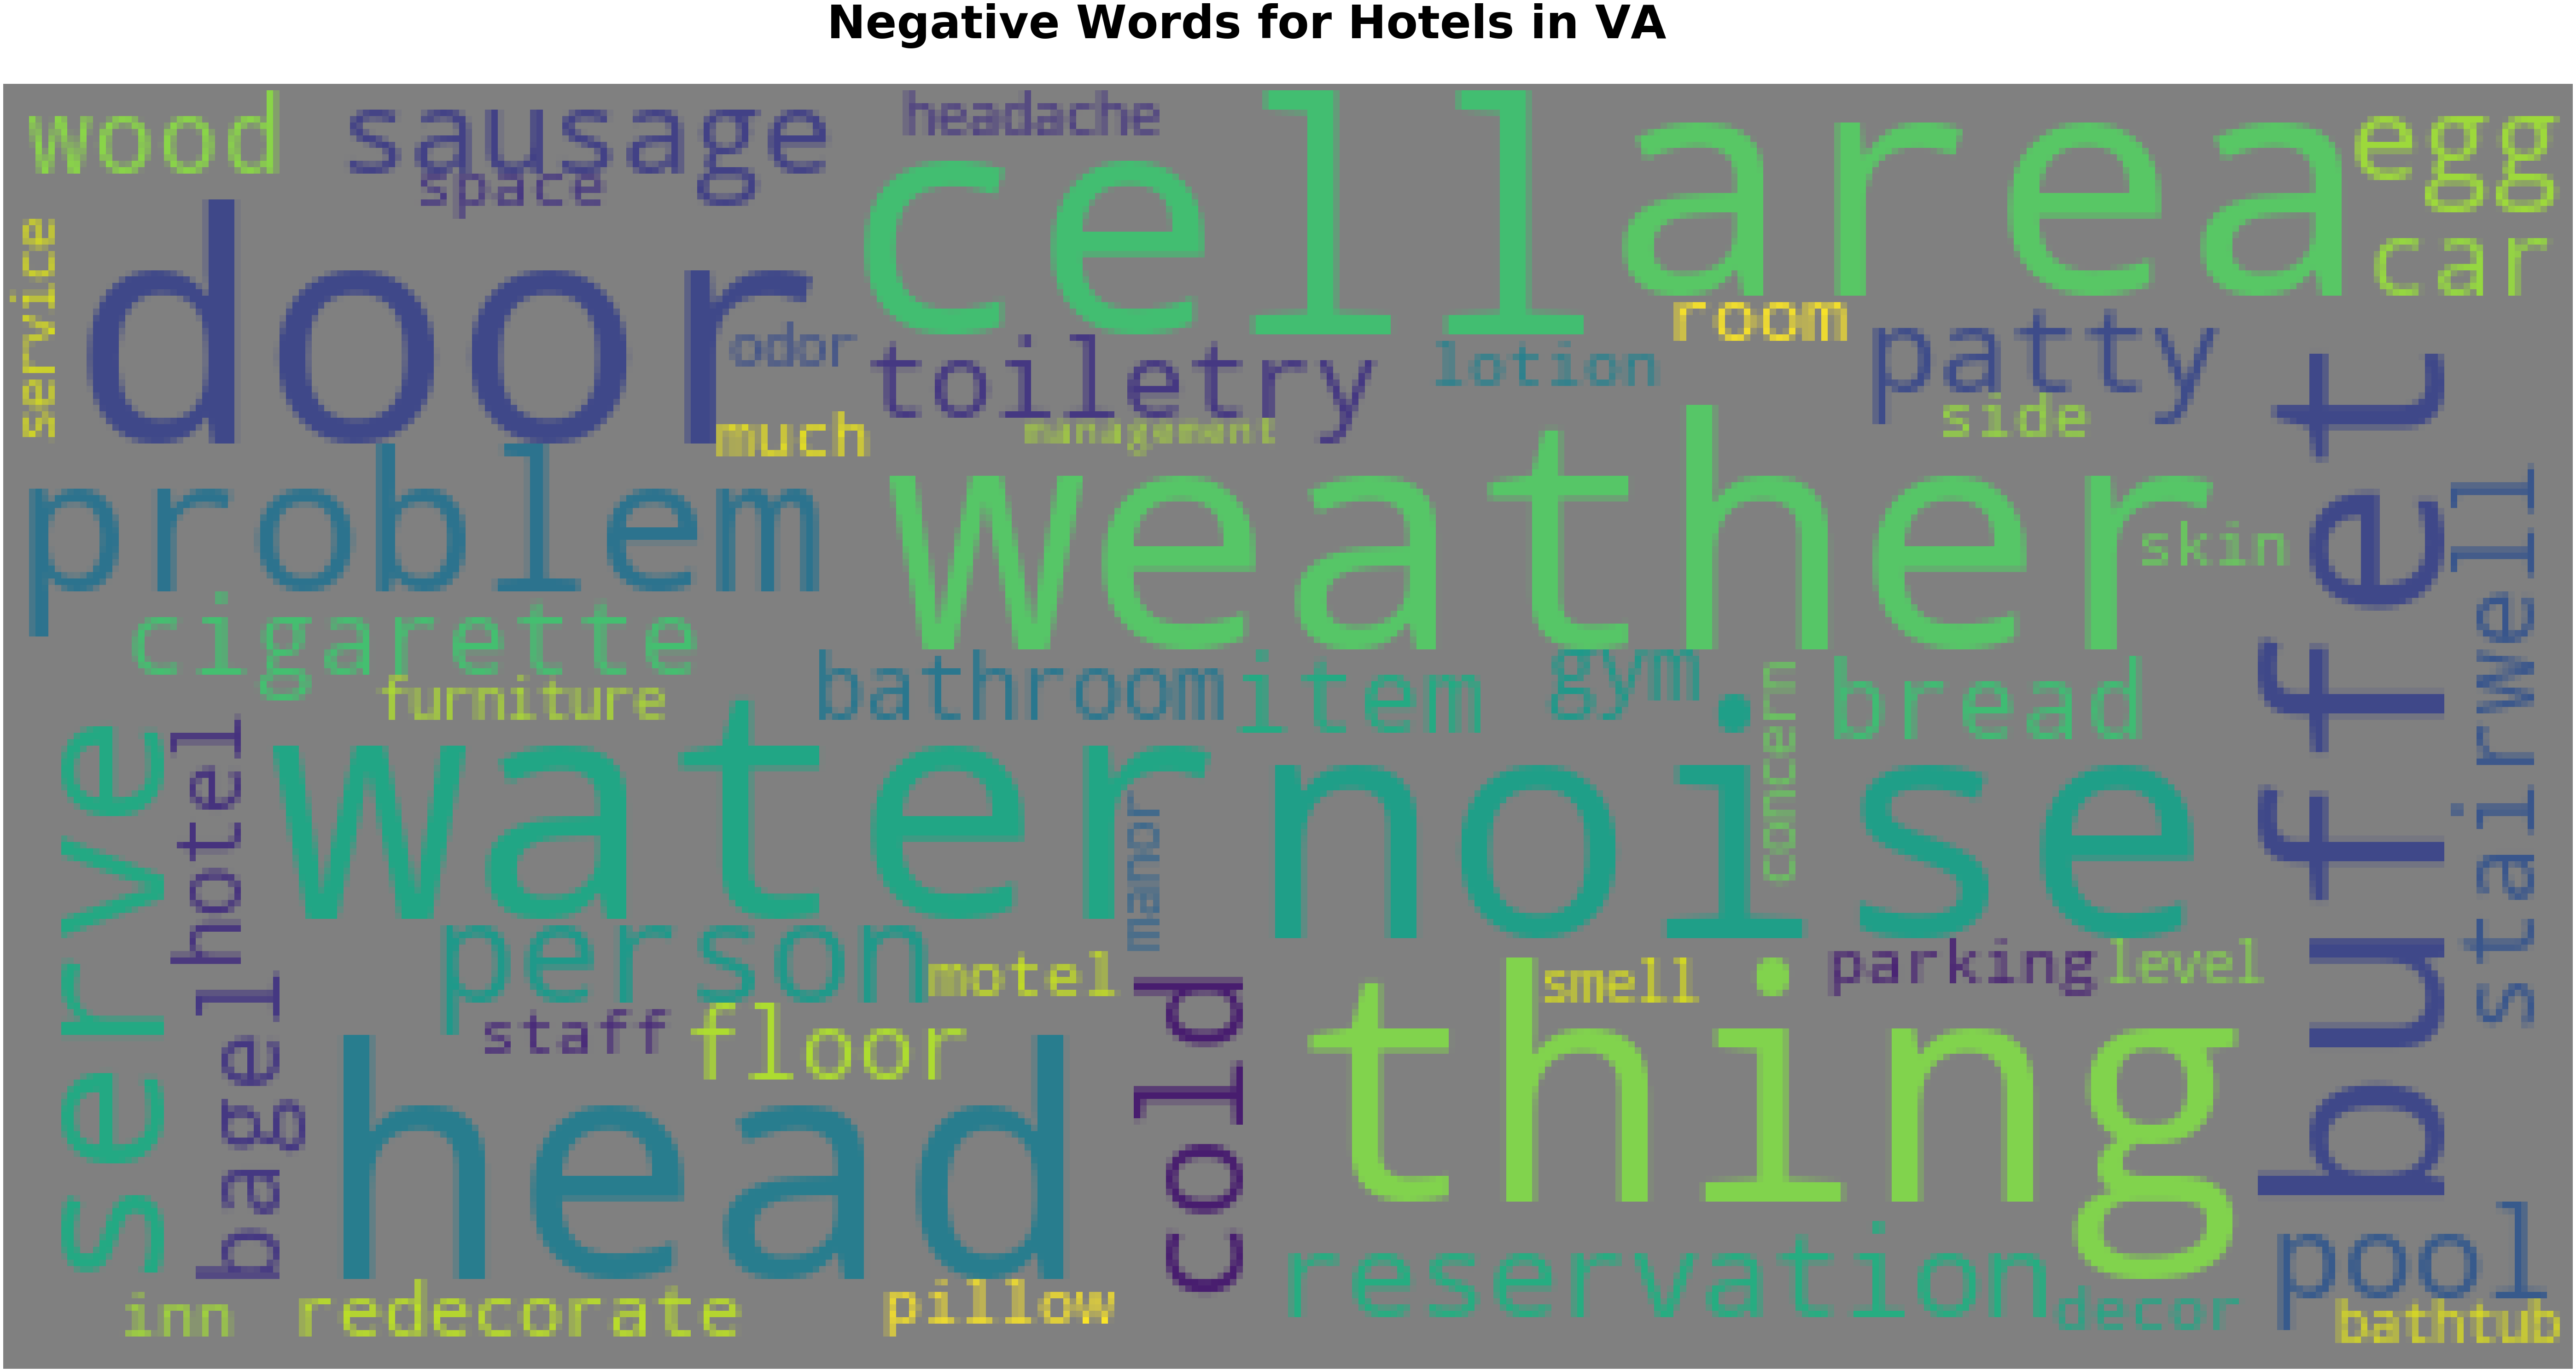

In [84]:
wc(text_neg,'grey','Negative Words for Hotels in VA' )

In [85]:
lowest = defaultdict()
highest = defaultdict()
for i in VA_term_dict:
    if VA_term_dict[i]:
        highest[i] = VA_term_dict[i].most_common()[:9]
        lowest[i] = VA_term_dict[i].most_common()[-9:]
highest_df = pd.DataFrame(highest)
lowest_df = pd.DataFrame(lowest)
lowest_df = lowest_df.drop(["OTHER"],1)
highest_df = highest_df.drop(["OTHER"],1)
highest_df

LOCATION          CHECKIN                     FOOD  \
0        (location, 9.5)       (check, 4)        (breakfast, 28.5)   
1             (place, 9)  (retro cool, 3)   (great breakfast, 5.0)   
2              (view, 6)     (chris, 2.5)      (full breakfast, 4)   
3       (valley view, 2)    (feedback, 2)  (breakfast buffet, 3.5)   
4      (western view, 2)     (hampton, 2)              (cookie, 3)   
5           (village, 2)     (phillip, 2)       (hot breakfast, 3)   
6    (great location, 2)    (midnight, 2)            (people, 2.5)   
7  (available area, 1.5)  (front lady, 1)        (fresh cookie, 2)   
8       (condition, 1.5)      (steven, 1)      (nice breakfast, 2)   

                BUILDING               ROOMS           CLEANLINESS  \
0        (property, 8.0)       (room, 58.75)     (clean ground, 3)   
1  (beautiful ground, 3)       (hotel, 35.5)  (clean furniture, 2)   
2           (setting, 2)        (bed, 22.75)          (quality, 1)   
3   (entire property, 2)          (tub, 8.0)           (beauty, 1)   
4     (establishment, 1)    (hampton inn, 6)      (quality inn, 1)   
5            (sunset, 1)           (pool, 5)  (proper lighting, 1)   
6               (the, 1)        (hot tub, 5)         (lighting, 1)   
7             (smoke, 1)  (indoor pool, 4.0)            (odor, -1)   
8             (paint, 1)    (king room, 3.5)           (smell, -1)   

               VALUE             SERVICE                BUSINESS  
0         (price, 4)       (staff, 66.5)             (life, 3.0)  
1         (value, 2)   (experience, 5.0)     (good western, 1.5)  
2    (great view, 2)     (desk staff, 5)    (owner manager, 1.5)  
3        (number, 1)      (service, 4.5)                (job, 1)  
4   (total staff, 1)   (staff member, 4)           (employee, 1)  
5   (expectation, 1)         (access, 3)               (golf, 1)  
6        (review, 1)      (manager, 2.5)  (cheerful employee, 1)  
7      (surprise, 1)   (old daughter, 2)   (helpful employee, 1)  
8  (noise level, -2)  (year daughter, 2)     (local activity, 1)

In [86]:
lowest_df

LOCATION                   CHECKIN                 FOOD  \
0            (choice, 1)  (reservation process, 1)            (item, 0)   
1          (position, 1)               (mr bob, 1)     (pool water, -1)   
2  (breakfast area, 0.5)           (easy check, 1)          (water, -1)   
3           (weather, 0)      (fabulous review, 1)       (toiletry, -1)   
4      (buffet area, -1)       (awesome review, 1)      (cigarette, -1)   
5           (person, -1)  (western springfield, 1)          (bagel, -1)   
6     (cold weather, -1)                (stacy, 1)          (bread, -1)   
7       (serve area, -2)         (reservation, -1)  (sausage patty, -2)   
8          (problem, -3)                   (w, -1)            (egg, -3)   

               BUILDING                ROOMS           CLEANLINESS  \
0            (beach, 1)           (much, -1)  (clean furniture, 2)   
1             (part, 1)     (other side, -1)          (quality, 1)   
2              (lot, 1)       (headache, -1)           (beauty, 1)   
3           (street, 1)        (bathtub, -1)      (quality inn, 1)   
4        (parking, 0.5)          (manor, -1)  (proper lighting, 1)   
5             (car, -1)      (furniture, -1)         (lighting, 1)   
6            (wood, -1)       (pillow, -1.5)            (odor, -1)   
7  (stairwell door, -1)  (parking space, -2)           (smell, -1)   
8      (floor door, -1)         (lotion, -2)           (noise, -2)   

               VALUE                  SERVICE                BUSINESS  
0         (price, 4)         (light staff, 1)  (cheerful employee, 1)  
1         (value, 2)  (professional staff, 1)   (helpful employee, 1)  
2    (great view, 2)     (reception staff, 1)     (local activity, 1)  
3        (number, 1)           (patronage, 1)          (gift shop, 1)  
4   (total staff, 1)                (face, 1)           (business, 1)  
5   (expectation, 1)            (concern, -1)           (industry, 1)  
6        (review, 1)               (head, -1)             (family, 1)  
7      (surprise, 1)              (thing, -1)     (other business, 1)  
8  (noise level, -2)       (cell service, -1)        (management, -2)

## WA Hotel Review

In [87]:
aspect_sent, WA_term_dict = gen_dict("hotel_reviewWA.txt")
WA_df = gen_rate(aspect_sent)
WA_df

aspect      pos      neg  rate
0      LOCATION  1000.00   123.75   4.6
1       CHECKIN   547.75    61.50   4.6
2          FOOD   909.25   152.50   4.4
3      BUILDING   302.75   146.50   3.7
4         ROOMS  2290.50   511.00   4.3
5   CLEANLINESS   194.50    74.00   3.9
6         VALUE   198.00    52.50   4.2
7       SERVICE  1222.75   122.50   4.6
8      BUSINESS   196.00    27.00   4.5
9         OTHER   553.50    74.25   4.5
10        TOTAL  7415.00  1345.50   4.4

In [88]:
a_series = pd. Series(['WA'] + list(WA_df['rate']), index = total_df. columns)
total_df = total_df.append(a_series, ignore_index=True)

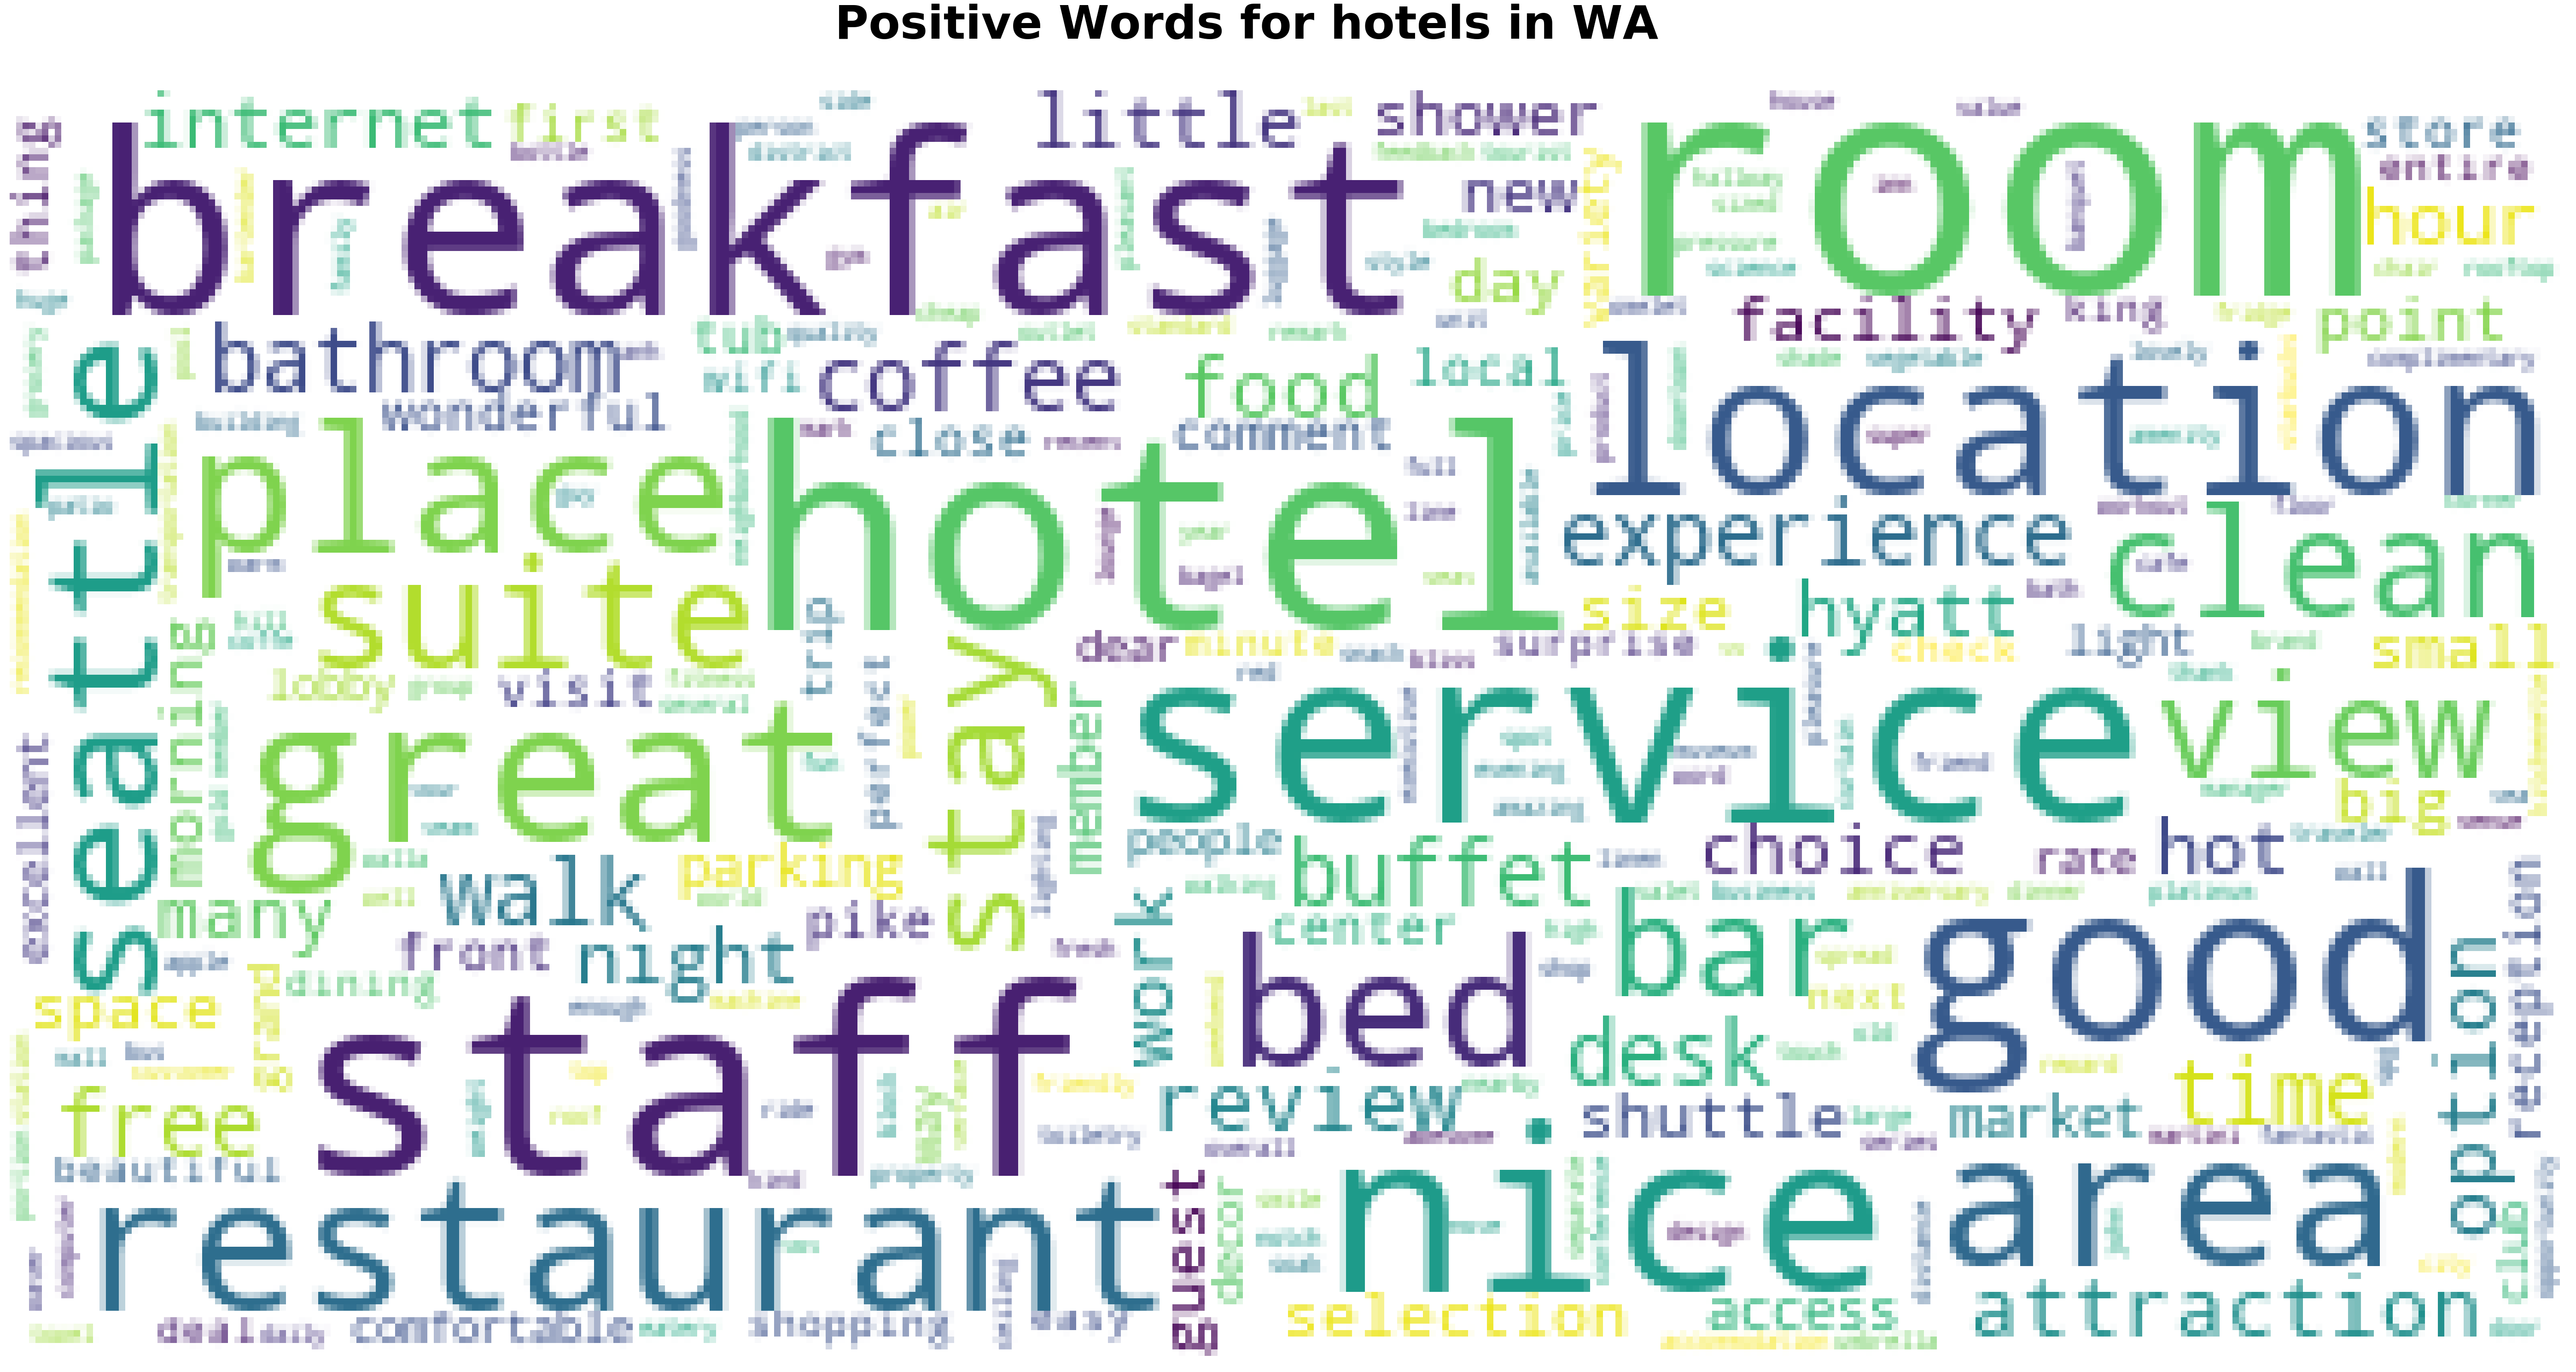

In [89]:
text_pos, text_neg = gen_text(WA_term_dict)
wc(text_pos,'white','Positive Words for hotels in WA' )

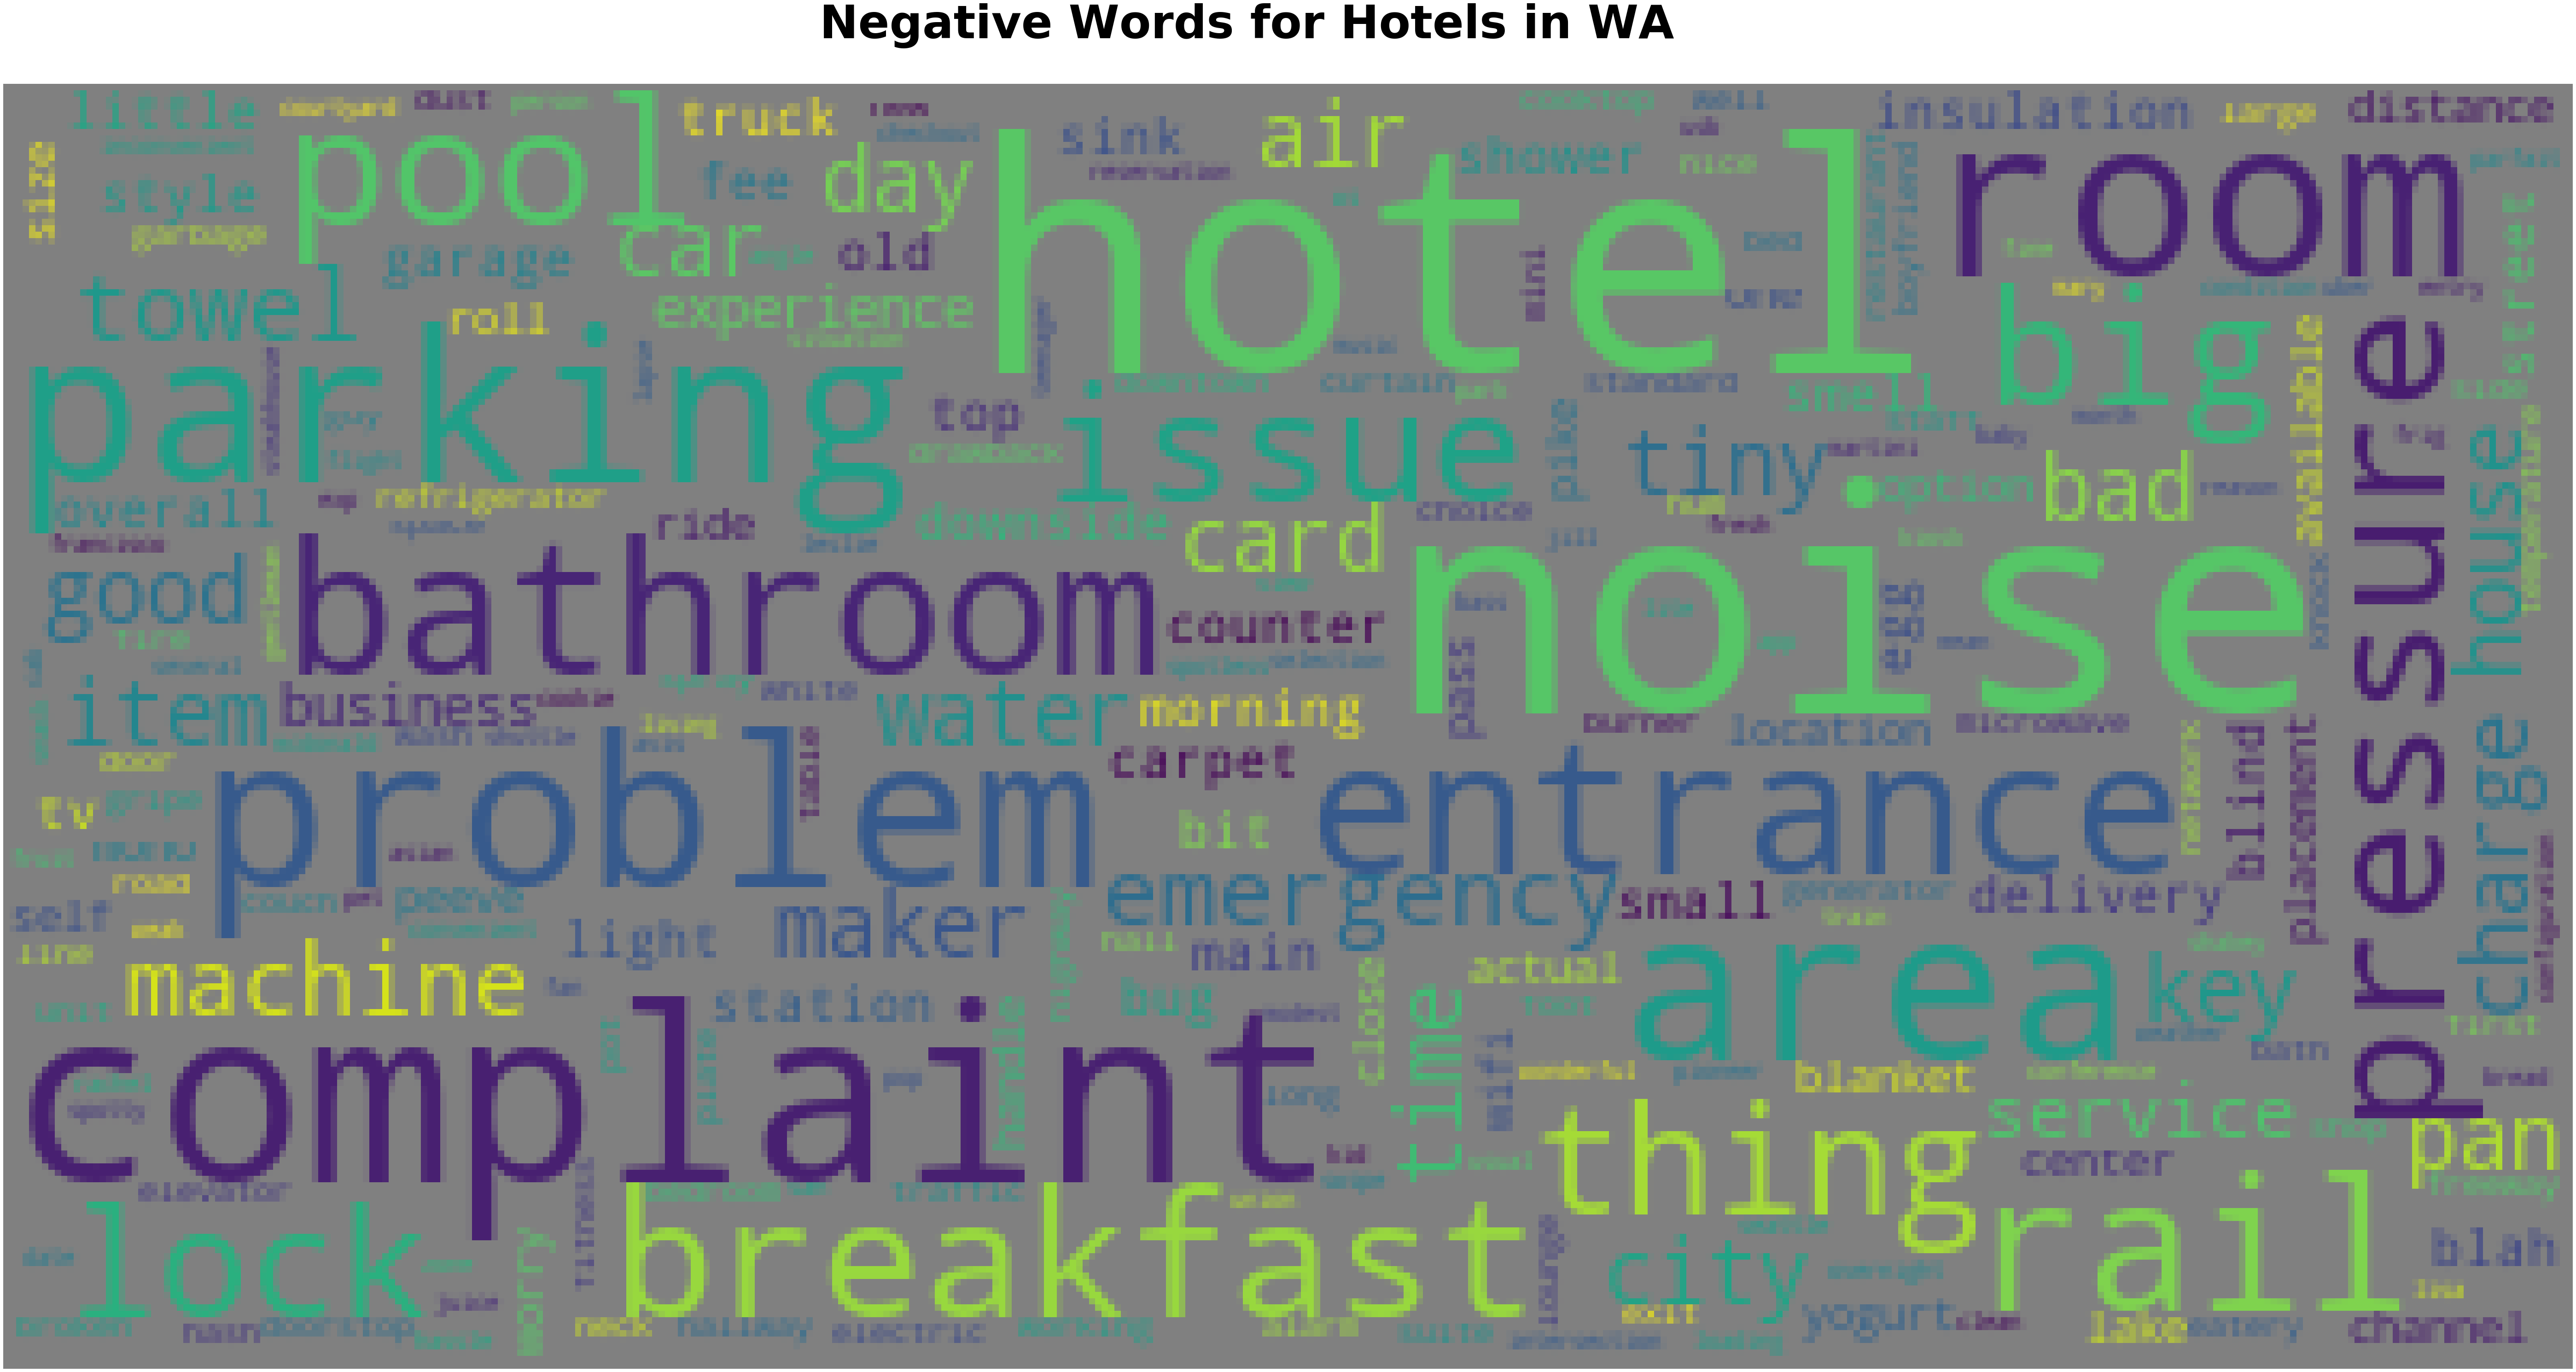

In [90]:
wc(text_neg,'grey','Negative Words for Hotels in WA' )

In [91]:
lowest = defaultdict()
highest = defaultdict()
for i in WA_term_dict:
    if WA_term_dict[i]:
        highest[i] = WA_term_dict[i].most_common()[:10]
        lowest[i] = WA_term_dict[i].most_common()[-10:]
highest_df = pd.DataFrame(highest)
lowest_df = pd.DataFrame(lowest)
lowest_df = lowest_df.drop(["OTHER"],1)
highest_df = highest_df.drop(["OTHER"],1)
highest_df

LOCATION              CHECKIN  \
0          (location, 244.0)     (feedback, 80.0)   
1               (view, 99.5)  (grand hyatt, 40.5)   
2             (place, 50.75)         (wifi, 21.5)   
3     (great location, 25.5)  (hyatt seattle, 18)   
4               (choice, 17)     (jonathan, 17.0)   
5               (size, 15.5)      (kind word, 16)   
6  (incredible location, 14)        (wi fi, 15.5)   
7               (area, 12.5)      (seattle, 14.5)   
8              (visit, 11.5)        (hyatt, 13.0)   
9               (spot, 10.0)            (jon, 12)   

                            FOOD           BUILDING                ROOMS  \
0             (breakfast, 168.0)   (property, 20.5)        (room, 505.5)   
1                   (food, 42.0)     (downtown, 11)      (hotel, 271.25)   
2             (restaurant, 35.0)    (parking, 10.5)         (bed, 127.0)   
3       (breakfast buffet, 28.5)  (hyatt house, 10)          (guest, 59)   
4                   (people, 21)          (home, 8)     (bathroom, 28.5)   
5         (free breakfast, 18.5)          (part, 7)        (suite, 25.0)   
6              (selection, 14.5)    (building, 6.0)       (shower, 24.0)   
7                  (variety, 12)     (walking, 5.5)   (front desk, 20.5)   
8  (complimentary breakfast, 10)     (portion, 5.5)        (lobby, 19.0)   
9                  (coffee, 8.5)       (upgrade, 5)  (hotel staff, 17.5)   

                 CLEANLINESS                   VALUE                 SERVICE  \
0            (amenity, 24.5)           (value, 18.5)         (staff, 442.25)   
1               (regard, 14)     (expectation, 15.5)         (service, 63.5)   
2   (guest satisfaction, 12)           (price, 15.0)      (experience, 40.0)   
3              (comfort, 10)          (option, 11.5)         (shuttle, 36.0)   
4             (quality, 8.5)               (need, 9)          (access, 21.5)   
5  (housekeeping staff, 8.0)             (rate, 6.5)            (travel, 19)   
6           (clean staff, 7)             (number, 5)            (team, 17.5)   
7        (housekeeping, 5.0)              (bonus, 5)   (last experience, 16)   
8             (happiness, 5)             (amount, 4)  (customer service, 14)   
9    (air conditioning, 4.5)  (close achievement, 4)      (desk staff, 14.0)   

                  BUSINESS  
0           (business, 27)  
1                (job, 17)  
2           (family, 13.5)  
3  (general manager, 11.5)  
4            (shopping, 6)  
5             (job gal, 6)  
6     (business center, 5)  
7              (future, 4)  
8   (customer standard, 4)  
9      (pikes market, 3.5)

In [92]:
lowest_df

LOCATION                CHECKIN                 FOOD  \
0      (light rail, -2)              (usb, -1)            (pan, -2)   
1       (situation, -2)             (jill, -1)        (utensil, -2)   
2   (light station, -2)  (seattle weather, -1)    (regular egg, -2)   
3     (living area, -2)             (tv, -1.5)         (waffle, -2)   
4      (only issue, -2)             (roll, -2)        (sausage, -2)   
5            (mono, -2)         (leslie, -2.0)  (plastic plate, -2)   
6    (mono station, -2)             (lock, -2)        (cutlery, -2)   
7  (breakfast area, -2)         (mcdonald, -2)   (refrigerator, -3)   
8  (only complaint, -3)            (entry, -2)      (microwave, -3)   
9    (rail station, -5)           (time, -4.0)           (egg, -10)   

                   BUILDING                  ROOMS              CLEANLINESS  \
0      (street noise, -2.5)     (only gripe, -3.5)           (wash rag, -2)   
1        (fire alarm, -2.5)  (parking space, -3.5)        (garbage can, -2)   
2       (broken rail, -2.5)             (hall, -4)       (noise factor, -2)   
3      (parking garage, -3)          (protest, -4)               (lack, -2)   
4         (parking lot, -3)       (only thing, -4)     (monorail noise, -2)   
5         (architect, -3.0)             (sink, -4)      (noise problem, -2)   
6   (garage entrance, -3.0)      (complaint, -5.5)      (noise machine, -3)   
7  (parking entrance, -3.0)        (kitchen, -6.5)  (overall quality, -3.0)   
8                 (car, -4)          (thing, -7.5)    (noise complaint, -4)   
9         (elevator, -11.0)              (mom, -8)            (noise, -9.5)   

                       VALUE                 SERVICE                 BUSINESS  
0              (ability, -1)            (charge, -2)         (large desk, -1)  
1       (only complaint, -1)           (traffic, -2)    (rental business, -1)  
2  (treasured blanket, -1.5)               (key, -2)   (storage business, -1)  
3       (major downside, -2)  (first experience, -2)    (family business, -1)  
4    (potential machine, -2)   (morning staffer, -2)       (good channel, -1)  
5       (dissapointment, -2)         (blah blah, -2)    (corporate chain, -1)  
6          (noise level, -3)    (only complaint, -2)  (business traveler, -1)  
7    (signal strength, -3.5)  (costumer service, -2)     (firm placement, -1)  
8             (downside, -4)    (bad experience, -2)             (parent, -1)  
9      (only downside, -9.5)       (housekeeper, -2)       (management, -1.5)

## Compare 15 States

In [103]:
total_df['true_rate'] = [4.1, 4.0, 4.0, 4.0, 3.9, 4.3, 4.3, 4.3, 4.3, 4.3, 4.2, 3.9, 4.1, 4.4, 4.2]
total_df.to_csv("15 States rate.csv")

In [104]:
total_df

state  location  checkin  food  building  room  cleanliness  value  \
0     AZ       4.4      4.6   4.2       3.7   4.6          3.6    4.5   
1     CA       4.5      4.4   4.3       3.8   4.2          3.9    4.3   
2     CO       4.4      4.8   4.7       3.7   4.5          4.8    4.4   
3     FL       4.6      4.4   4.2       4.1   4.2          3.8    4.4   
4     GA       4.4      4.4   4.5       3.7   4.2          4.0    4.3   
5     HI       4.7      4.8   4.2       4.0   4.5          4.6    5.0   
6     IL       4.7      4.6   4.4       4.2   4.3          4.3    4.3   
7     NY       4.5      4.4   4.3       3.5   4.3          4.0    4.4   
8     OR       4.8      4.4   4.3       4.3   4.6          4.9    4.6   
9     PA       4.7      4.6   4.6       4.2   4.4          4.2    4.5   
10    TN       4.6      4.4   4.1       3.2   4.2          3.2    5.0   
11    TX       4.6      4.4   4.7       3.8   4.2          3.8    4.5   
12    VA       4.3      4.7   4.4       4.4   4.6          3.9    4.5   
13    WA       4.6      4.6   4.4       3.7   4.3          3.9    4.2   
14    LA       4.7      4.6   4.5       4.0   4.3          3.8    4.5   

    service  business  other  total  true_rate  
0       4.5       4.6    4.3    4.4        4.1  
1       4.6       4.5    4.5    4.3        4.0  
2       4.4       5.0    4.6    4.5        4.0  
3       4.6       4.2    4.3    4.3        4.0  
4       4.5       4.3    4.4    4.3        3.9  
5       4.8       4.6    4.7    4.6        4.3  
6       4.6       4.6    4.5    4.5        4.3  
7       4.6       4.8    4.6    4.4        4.3  
8       4.9       5.0    4.6    4.6        4.3  
9       4.8       4.5    4.6    4.5        4.2  
10      4.5       4.7    3.9    4.2        3.9  
11      4.6       4.7    4.4    4.4        4.1  
12      4.8       4.6    4.5    4.6        4.4  
13      4.6       4.5    4.5    4.4        4.2  
14      4.7       4.5    4.4    4.4        4.3